In [1]:
%matplotlib inline
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
from collections import OrderedDict
from datetime import datetime
from tqdm import tqdm

matplotlib.style.use('matplotlibrc')

In [4]:
# Define data paths.
records_path = "records.csv"
authors_path = "authors.json"
records = Table.read(records_path)
# Ignore the dummy line, if it exists.
if records["id"][0] == "dummy":
    records = records[1:]
# Let's add some useful columns.
records["created_decimal_year"] = Time(records["created"]).decimalyear

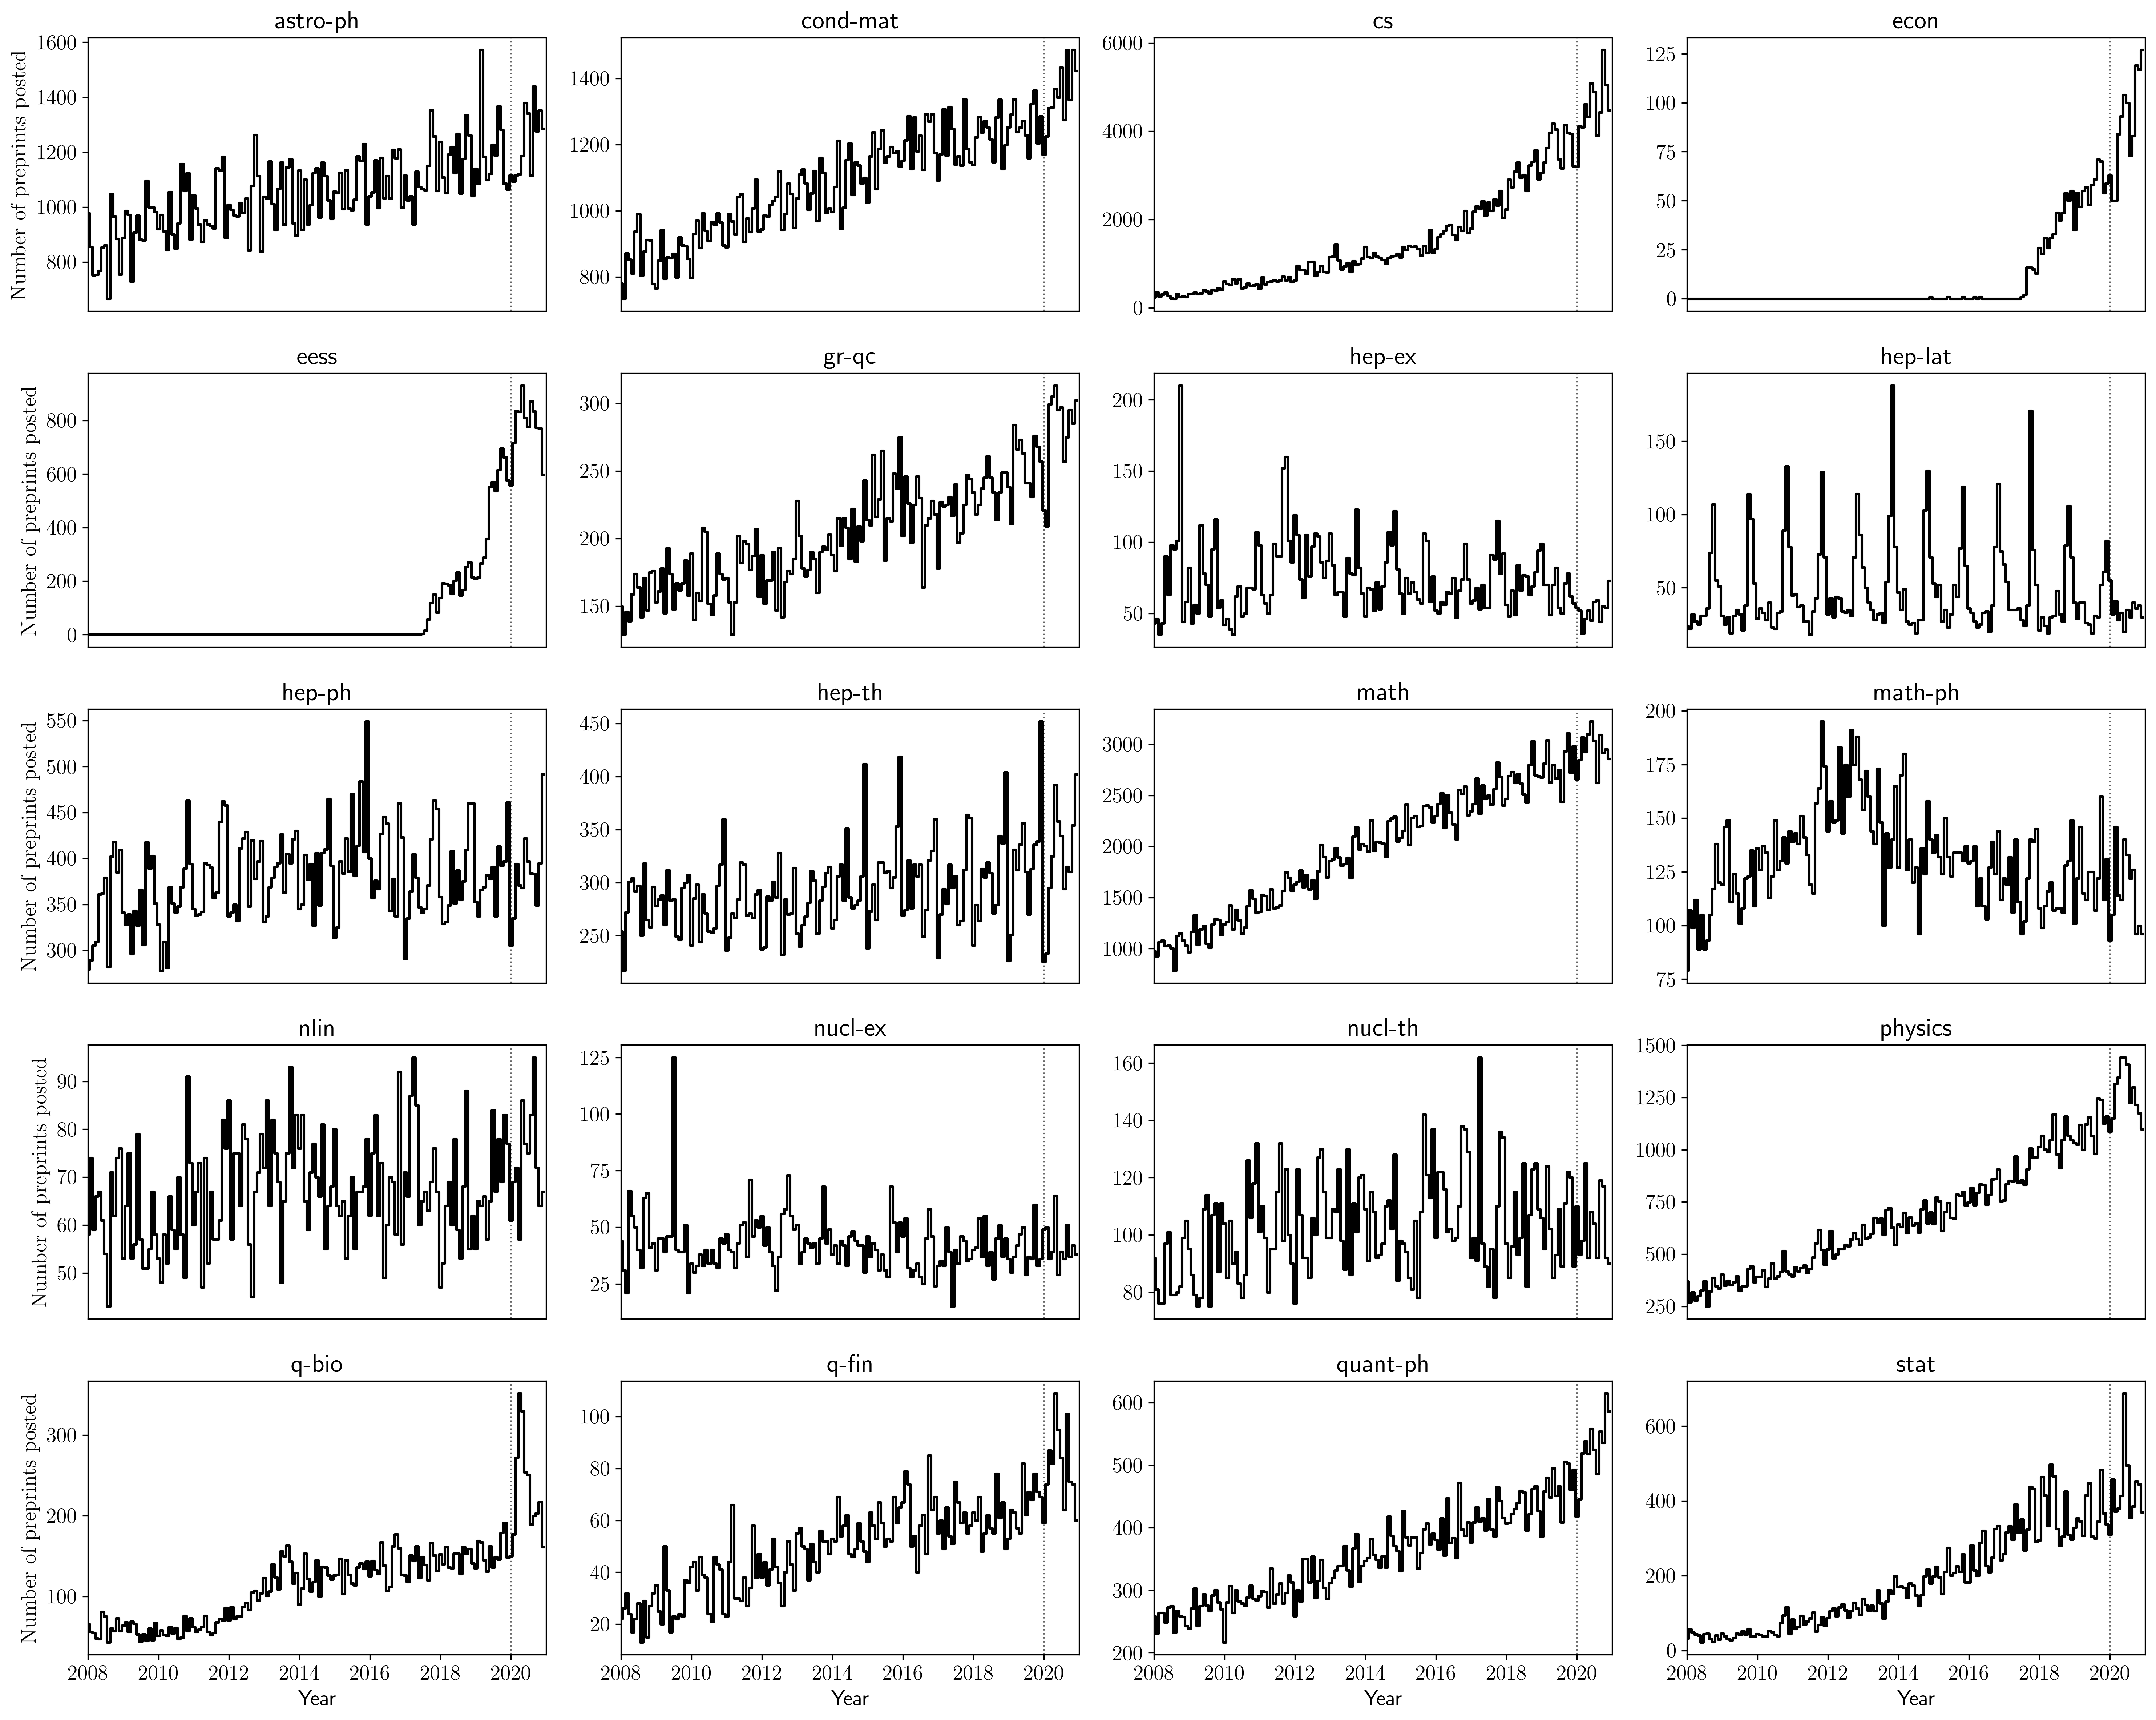

In [5]:
# Plot submissions by time for each field.

#records["year"] = records["created_decimal_year"].astype(int)

from collections import Counter
from matplotlib import cm

# Now let's plot by year for each field.
fig, axes = plt.subplots(5, 4, figsize=(5 * 4, 4 * 4))
u = set(records["primary_parent_category"])
cmap = cm.get_cmap('tab20', len(u))
colors = { v: cmap(i) for i, v in enumerate(sorted(list(set(records["primary_parent_category"])))) }

for i, group in enumerate(records.group_by(["primary_parent_category"]).groups):

    ppc = group["primary_parent_category"][0]

    ax = axes.flatten()[i]
    ax.set_title(r"{}".format(ppc))

    #counts = Counter(group["year"])
    ys = group["created_decimal_year"]
    bins = np.arange(2008, 2021 + 1/12, 1/12)
    
    H, bin_edges = np.histogram(group["created_decimal_year"], bins)
    
    #x = np.array(list(counts.keys()))
    #y = np.array([counts[xi] for xi in x])

    ax.plot(
        bins[:-1],
        H,
        #c=colors[ppc],
        c="k",
        drawstyle="steps-mid",
        label=ppc,
    )
    
for ax in axes.flatten():
    if ax.is_last_row():
        ax.set_xlabel(r"Year")
        ax.set_xticks(range(2008, 2021, 2))
    else:
        ax.set_xticks([])
        
    if ax.is_first_col():
        ax.set_ylabel(r"$\textrm{Number~of~pre\-prints~posted}$")
    
    ax.axvline(2020, c="#666666", ls=":", lw=1, zorder=-1)
    ax.set_xlim(2008, 2021)

fig.tight_layout()


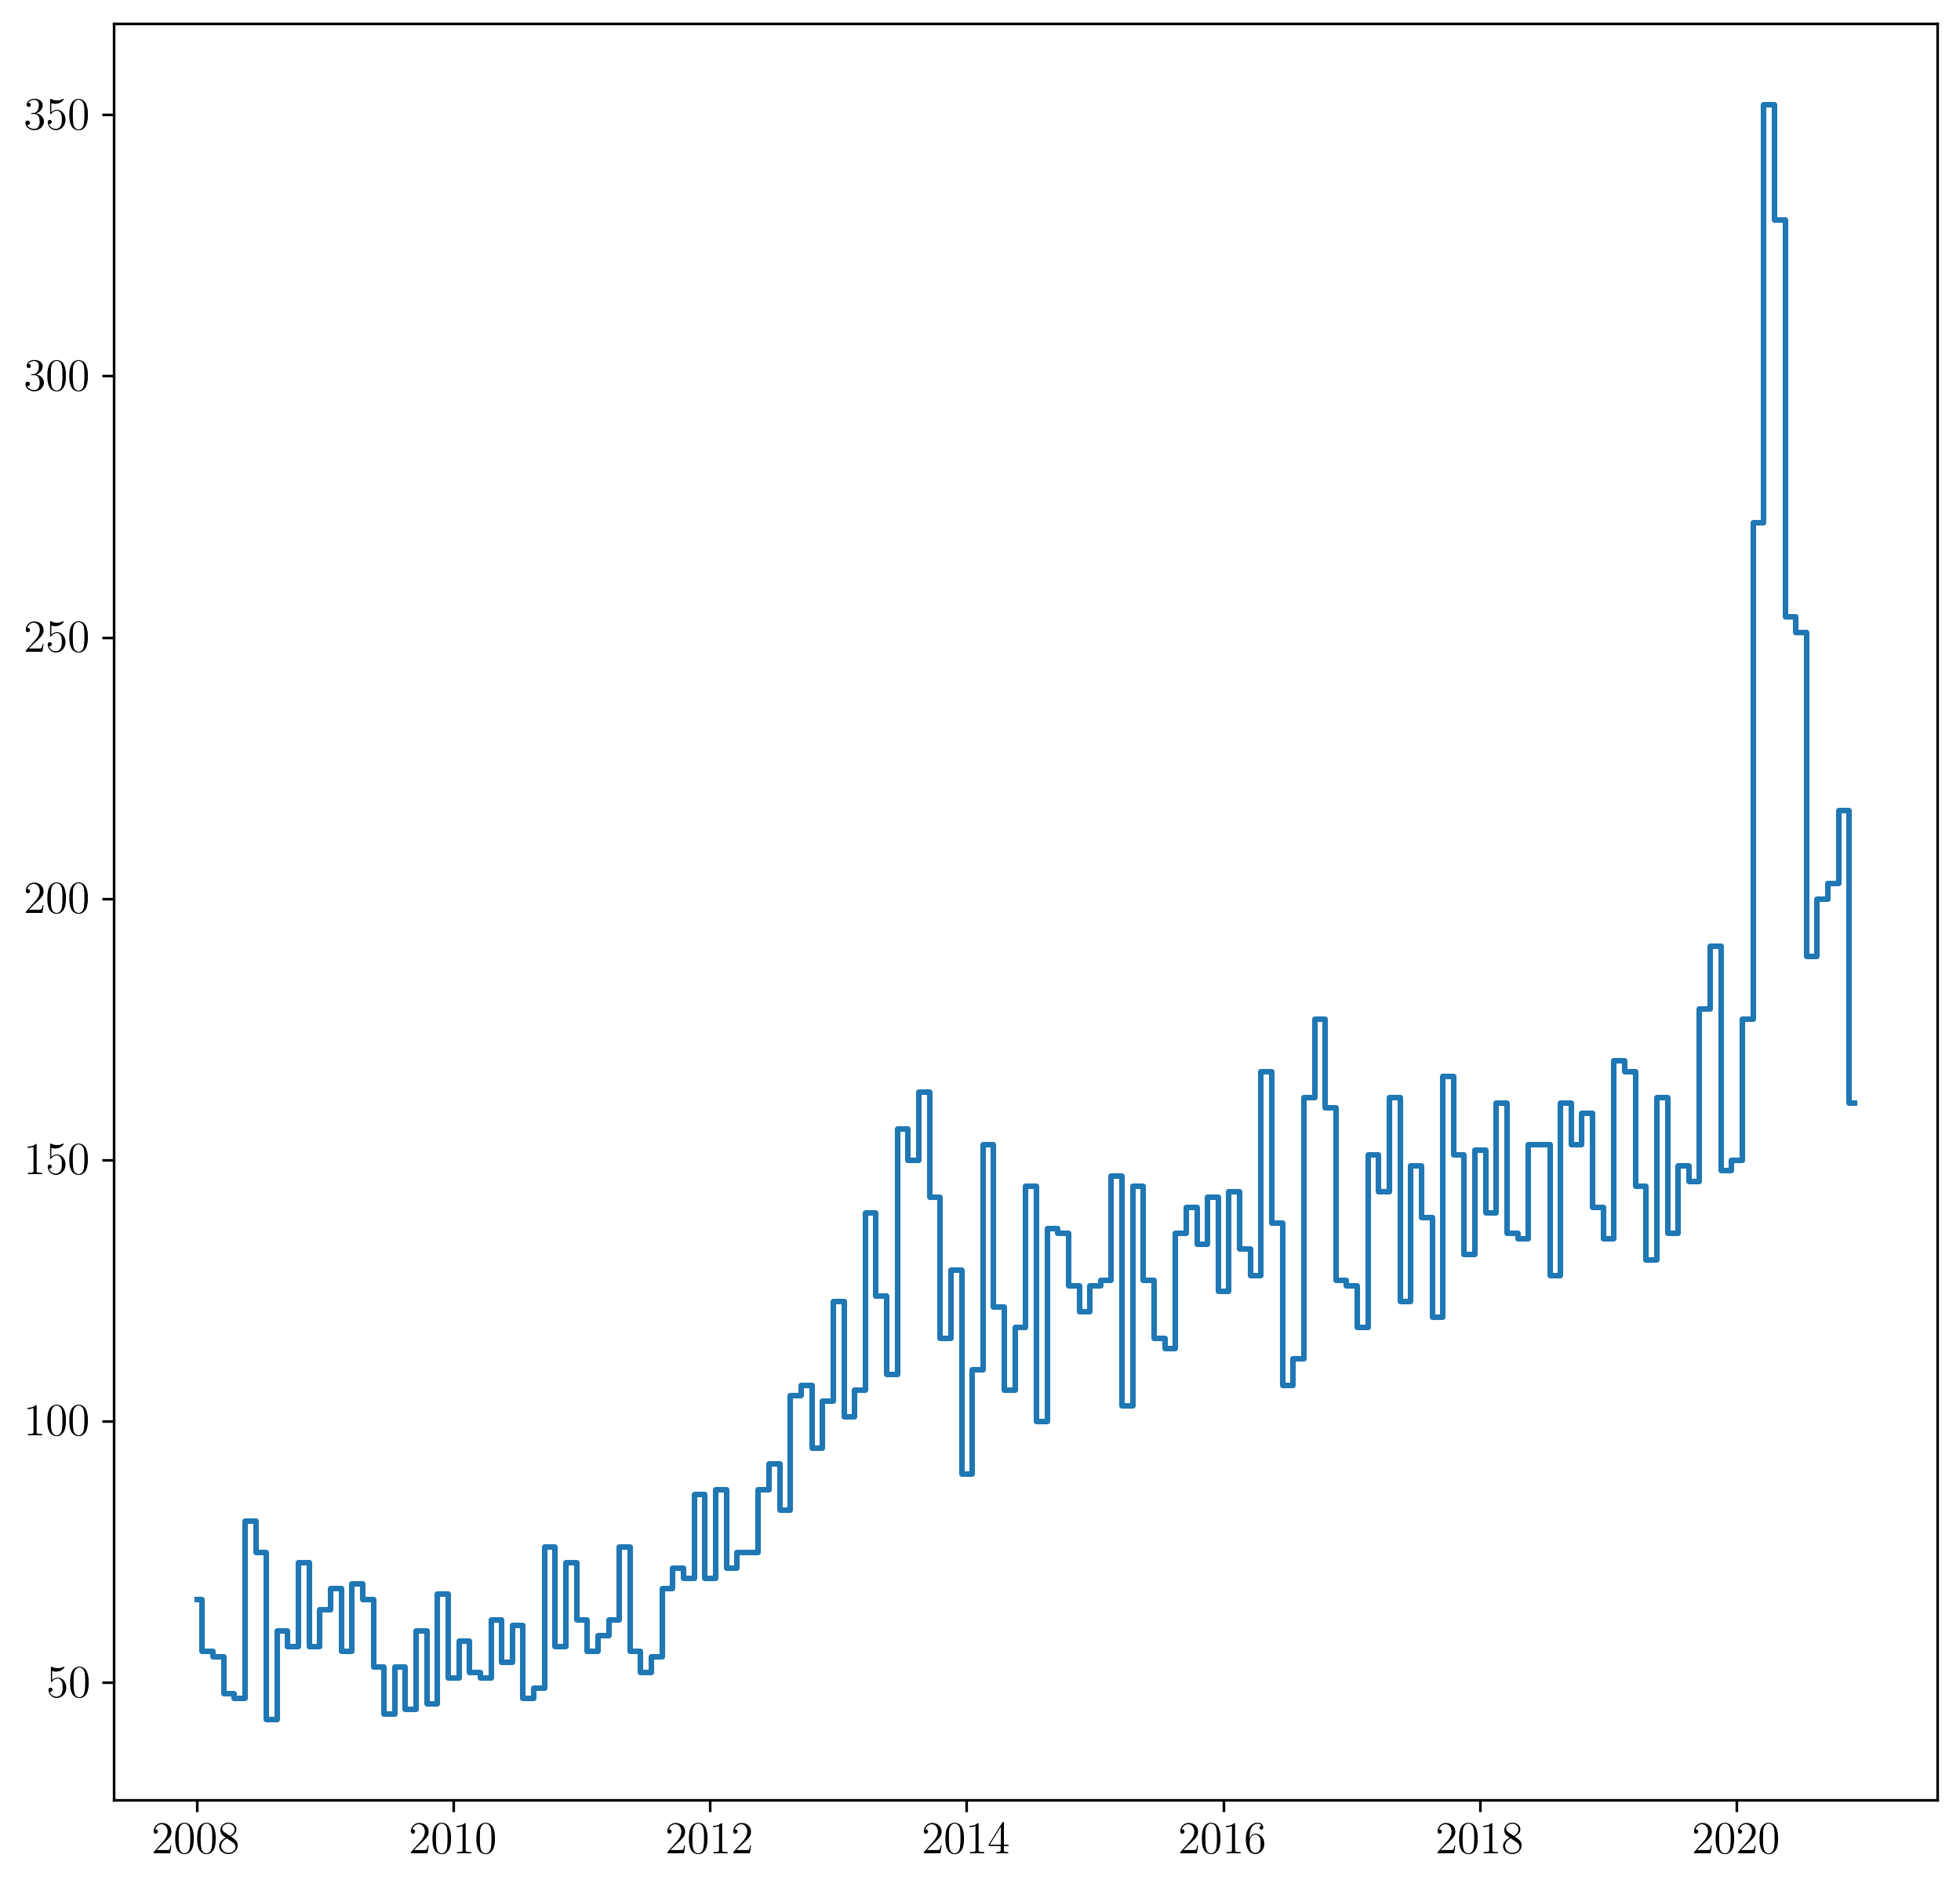

In [213]:
# Let's model hep-lat first.

ppc = "q-bio"
mask = (records["primary_parent_category"] == ppc)

group = records[mask]

#counts = Counter(group["year"])
ys = group["created_decimal_year"]
bins = np.arange(2008, 2021 + 1/12, 1/12)

H, bin_edges = np.histogram(group["created_decimal_year"], bins)

fig, ax = plt.subplots()
ax.plot(
    bins[:-1],
    H,
    drawstyle="steps-mid"
)


In [215]:
import george
from george import kernels

ok = (bins[1:] < 2020)
t = bins[1:][ok]
y = H[ok]


k1 = 2 * kernels.RationalQuadraticKernel(metric=1, log_alpha=1)

k1 = 10 * kernels.ExpSquaredKernel(metric=1)
k2 = 10 * kernels.ExpSine2Kernel(gamma=1, log_period=np.log(1))
k2.freeze_parameter("k2:log_period")
kernel = k1 + k2
#kernel.freeze_parameter("k2:k2:log_period")
#kernel = k1

gp = george.GP(kernel, mean=np.mean(y), fit_mean=True,
              white_noise=np.log(1), fit_white_noise=True)
gp.compute(t)
print(gp.log_likelihood(y))
print(gp.grad_log_likelihood(y))



-13090.718859378172
[ 2.03222266e-01  1.20909270e+04  5.84600144e+02 -3.19204638e+02
  1.72954174e+02  4.28075753e+02]


In [216]:
k2.parameter_names


('k1:log_constant', 'k2:gamma', 'k2:log_period')

In [217]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))


-13090.718859378172
-605.5081644723915


In [218]:
for name in gp.parameter_names:
    print(name, gp.get_parameter(name))

mean:value 109.86578518652126
white_noise:value 5.297441053334022
kernel:k1:k1:log_constant 7.06974502057804
kernel:k1:k2:metric:log_M_0_0 1.134495154182673
kernel:k2:k1:log_constant 2.972476634261406
kernel:k2:k2:gamma 10.830452146821525
kernel:k2:k2:log_period 0.0


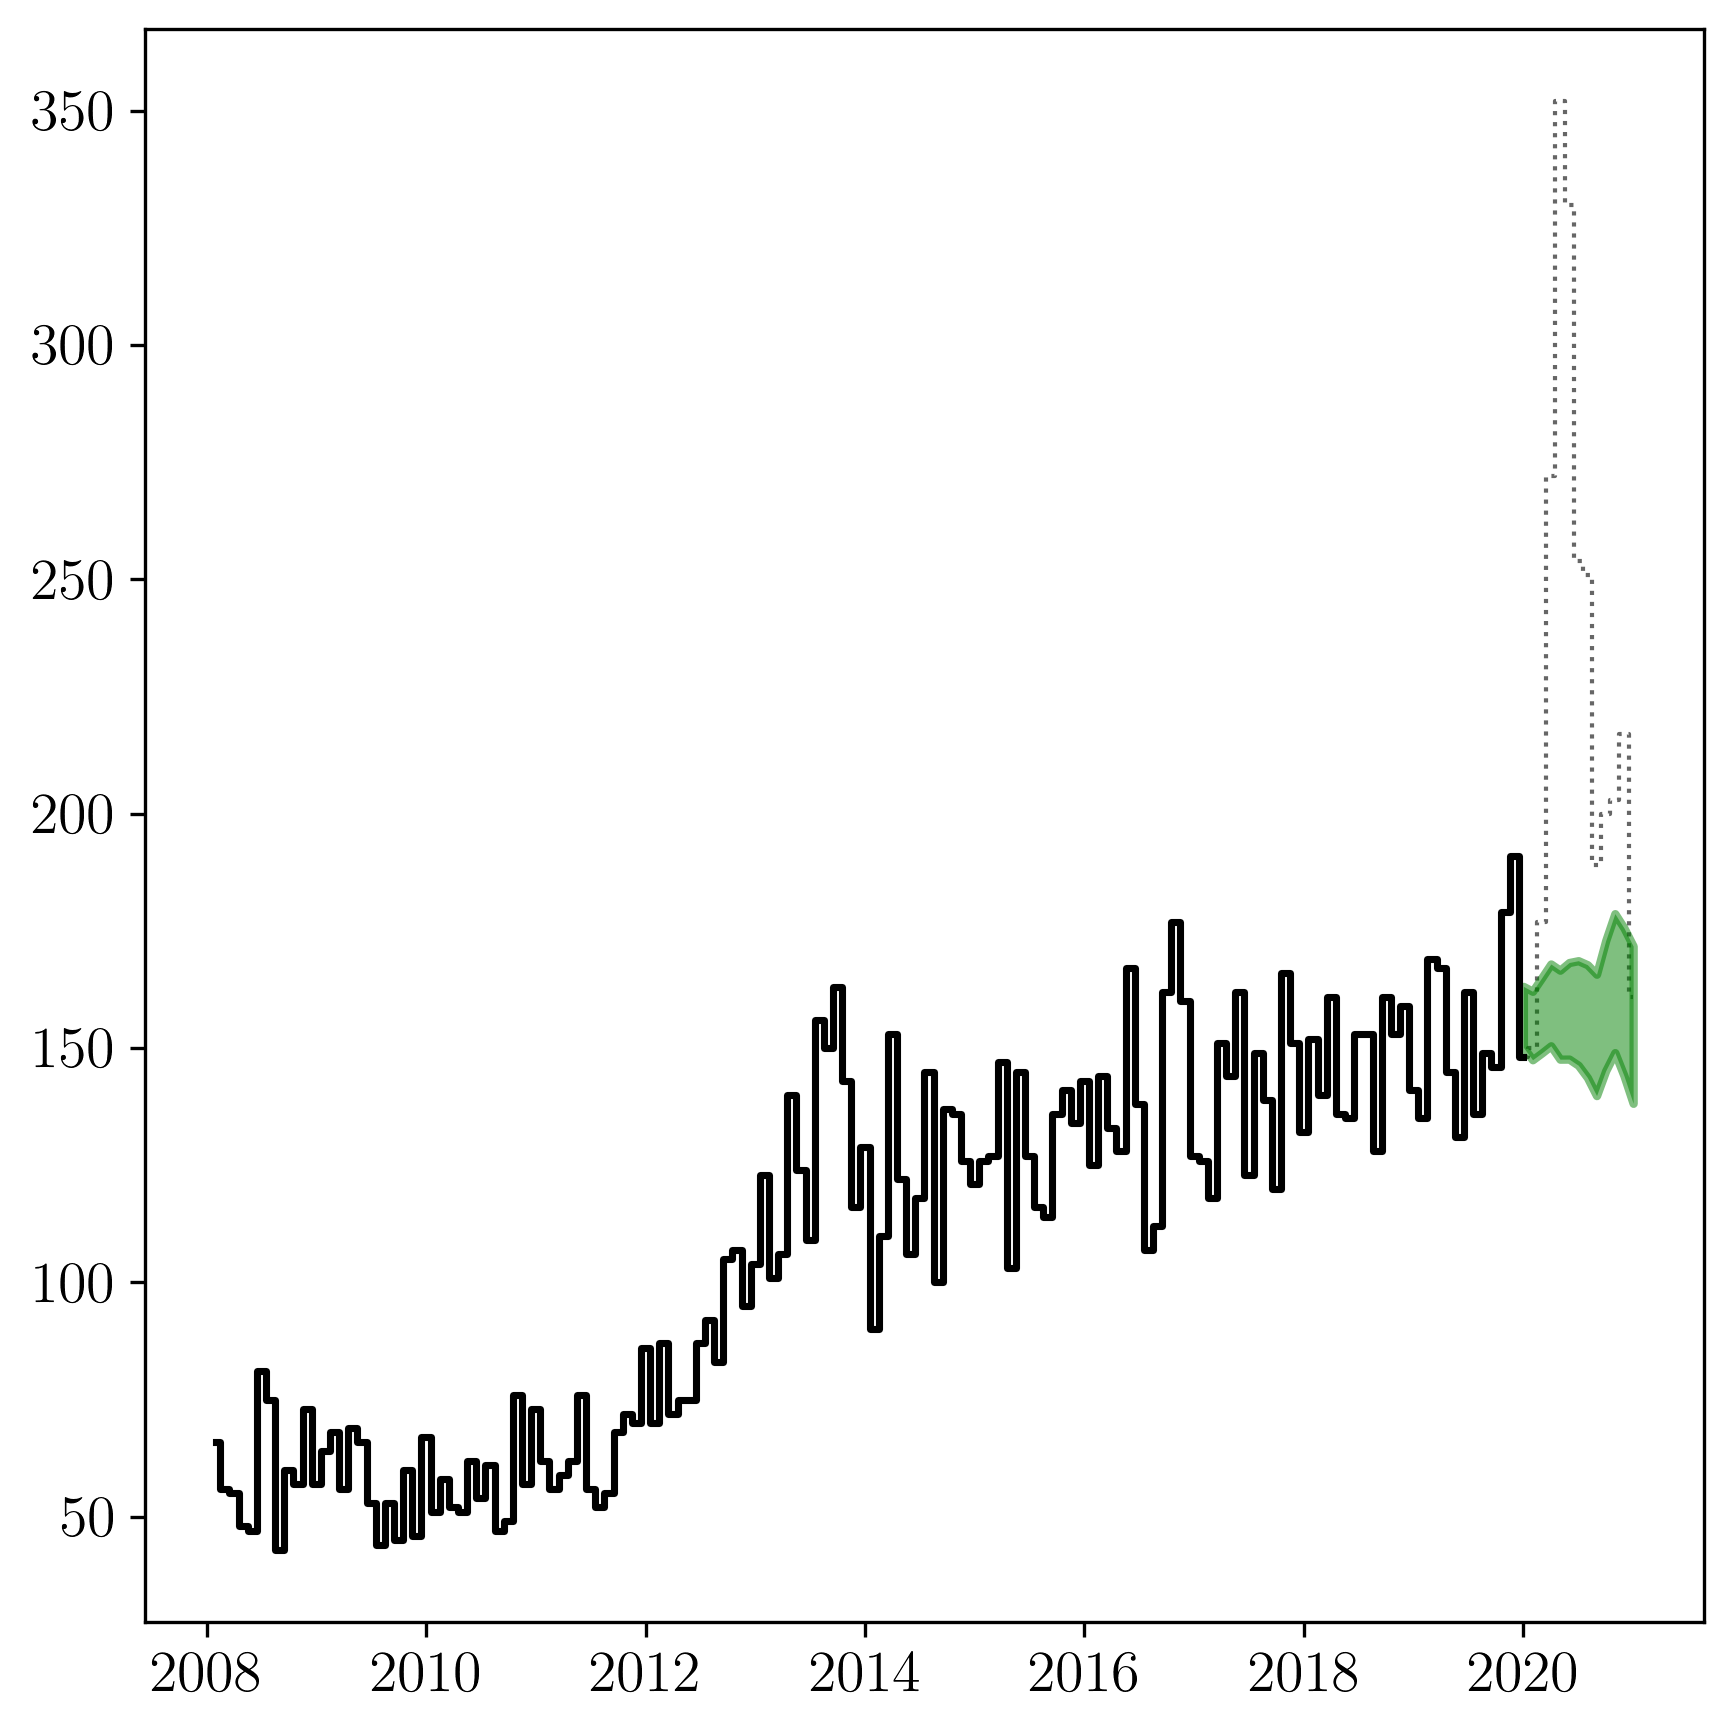

In [225]:
x = np.arange(2020, 2021 + 1/12, 1/12)
mu, var = gp.predict(y, x, return_var=True)#kernel=k1)
std = np.sqrt(var)
        
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(t, y, c="k", drawstyle="steps-mid")
ax.plot(bins[1:], H, c="#666666", ls=":", drawstyle="steps-mid", zorder=-1, lw=1)
ax.fill_between(x, mu+std, mu-std, color="g", alpha=0.5)
fig.tight_layout()

In [275]:
print(np.sum(H[~ok]))
print(np.sum(mu))

4153
2046.6221436251406


In [221]:
!conda install emcee

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - emcee

Current channels:

  - http://ssb.stsci.edu/astroconda/osx-64
  - http://ssb.stsci.edu/astroconda/noarch
  - https://conda.anaconda.org/sherpa/osx-64
  - https://conda.anaconda.org/sherpa/noarch
  - https://conda.anaconda.org/cxc/osx-64
  - https://conda.anaconda.org/cxc/noarch
  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [162]:
12*40.14

481.68

<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))
<ipython-input-233-243b4d33a341>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


'   \nfor ax in axes.flatten():\n    if ax.is_last_row():\n        ax.set_xlabel(r"Year")\n        ax.set_xticks(range(2008, 2021, 2))\n    else:\n        ax.set_xticks([])\n        \n    if ax.is_first_col():\n        ax.set_ylabel(r"$\textrm{Number~of~pre\\-prints~posted}$")\n    \n    ax.axvline(2020, c="#666666", ls=":", lw=1, zorder=-1)\n    ax.set_xlim(2008, 2021)\n\nfig.tight_layout()\n'

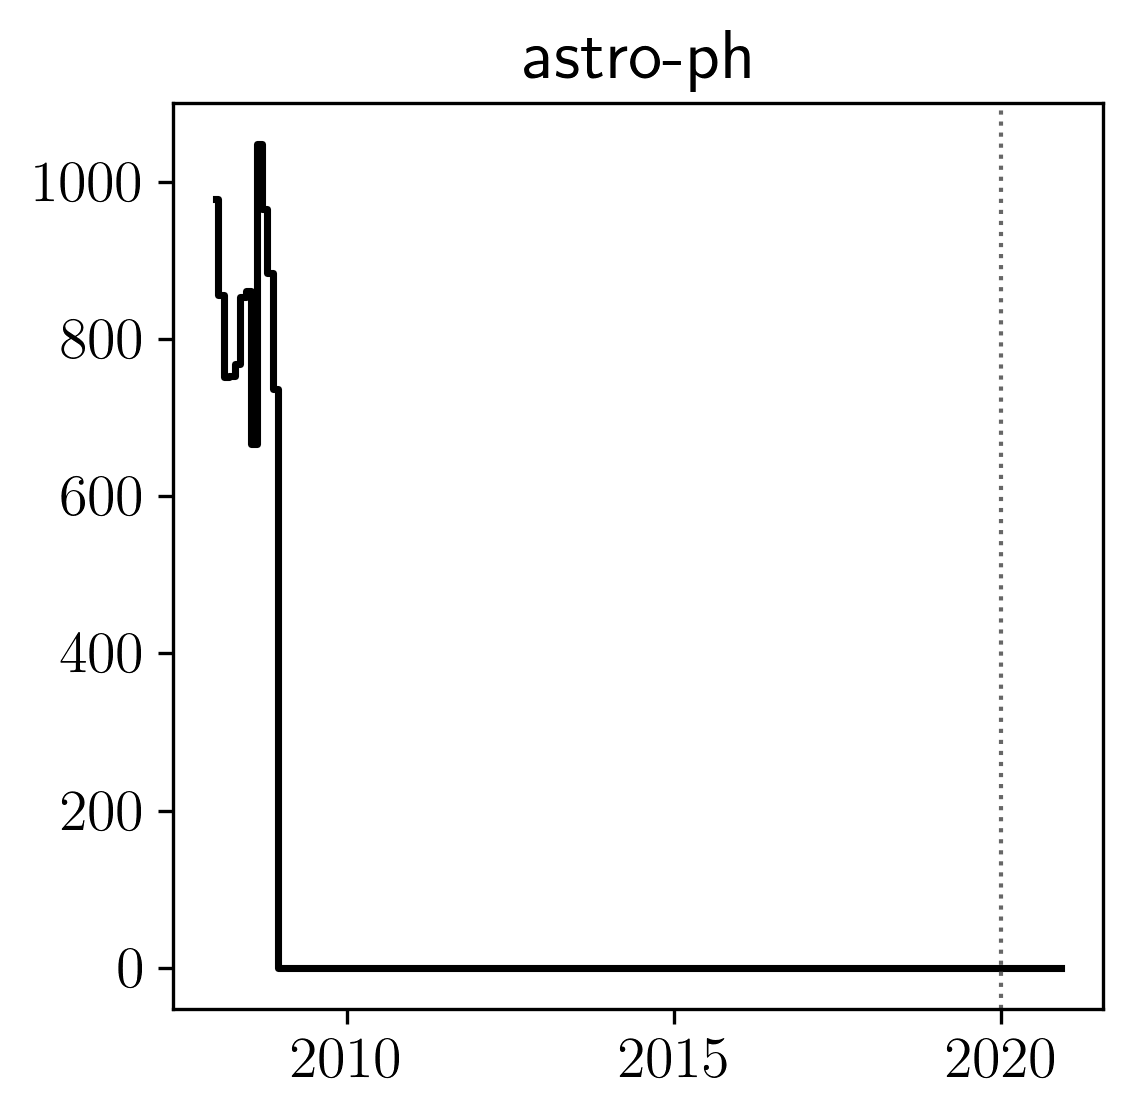

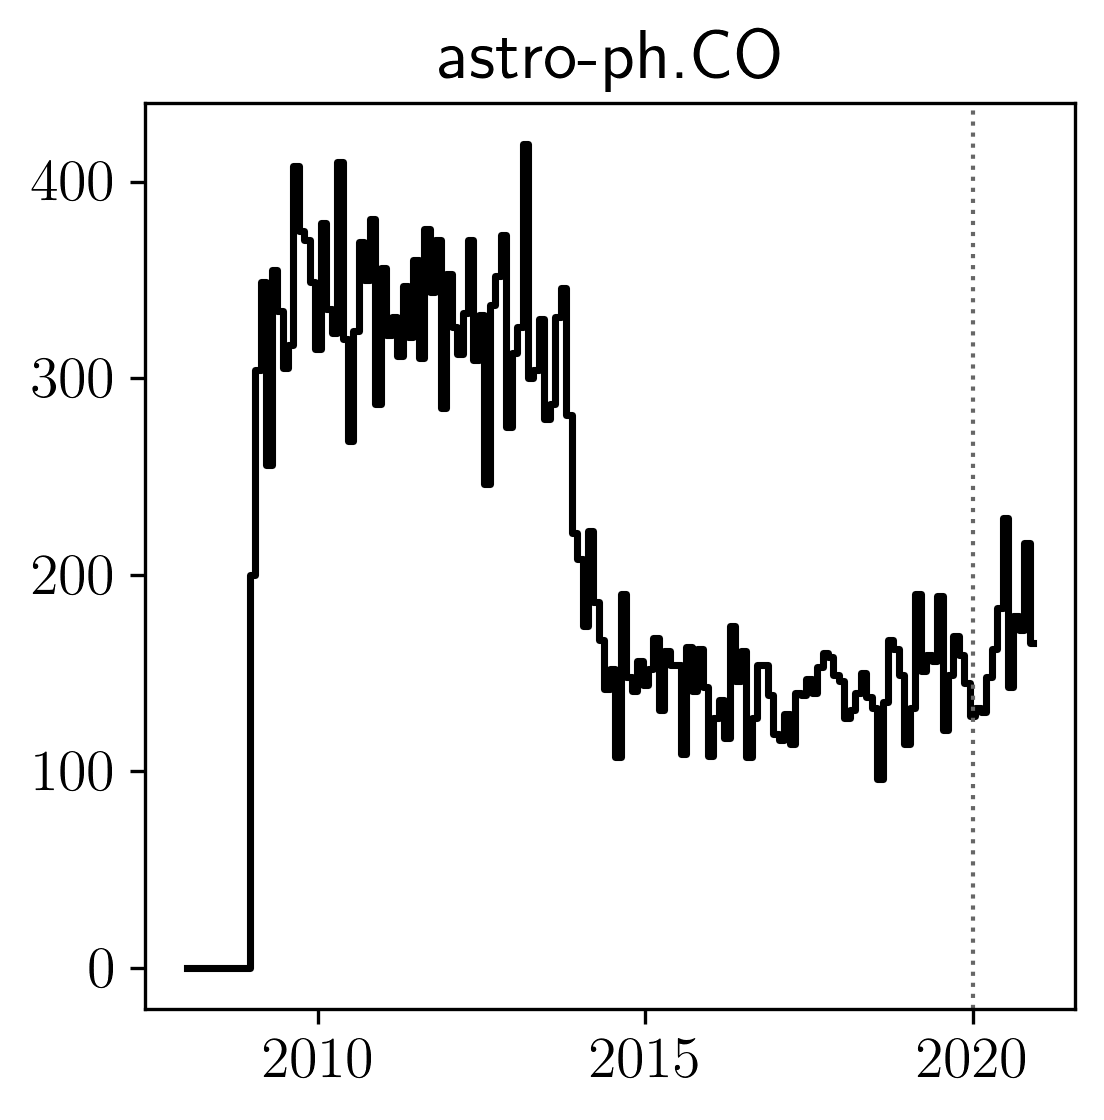

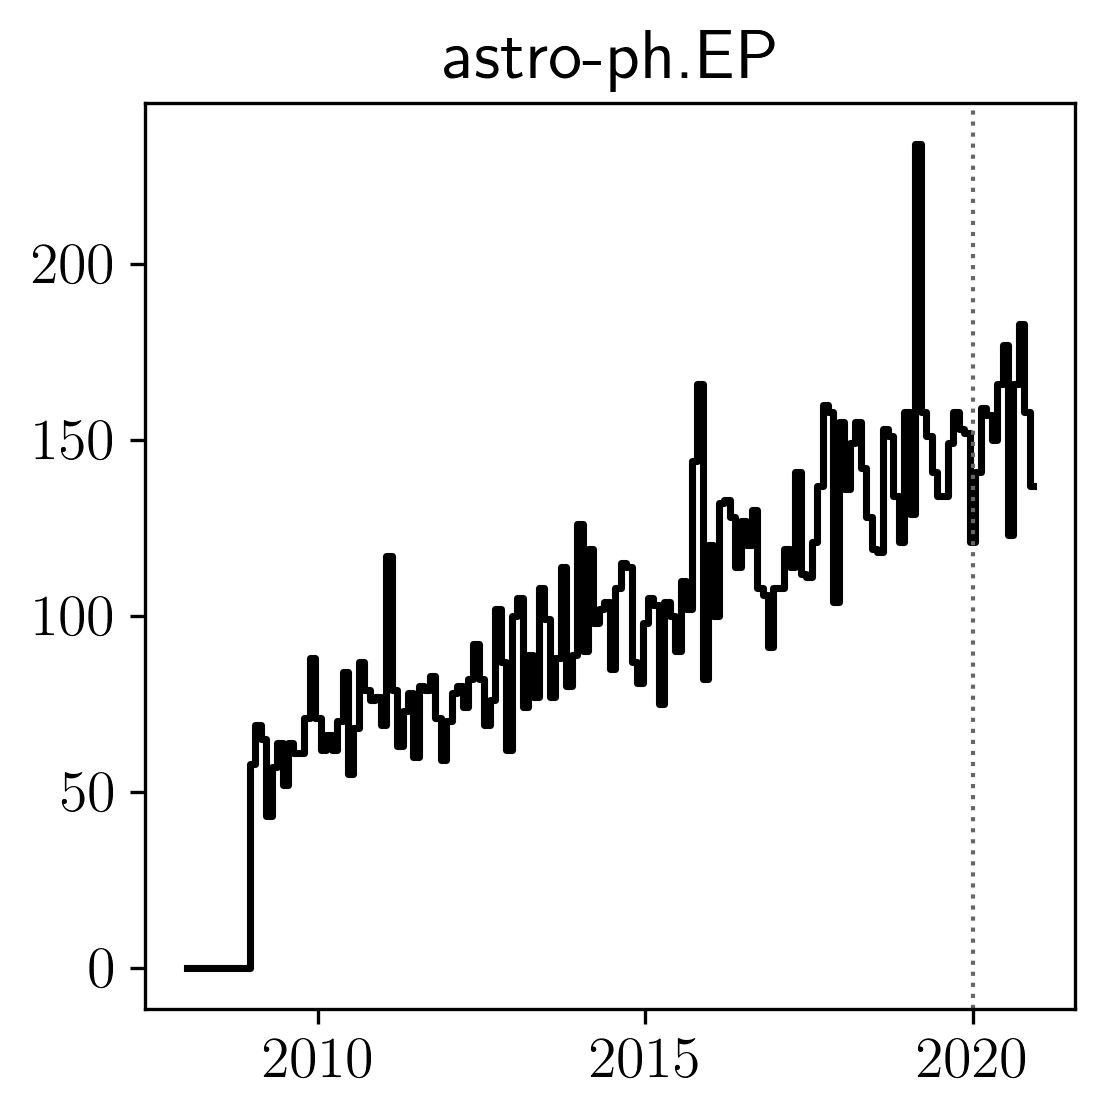

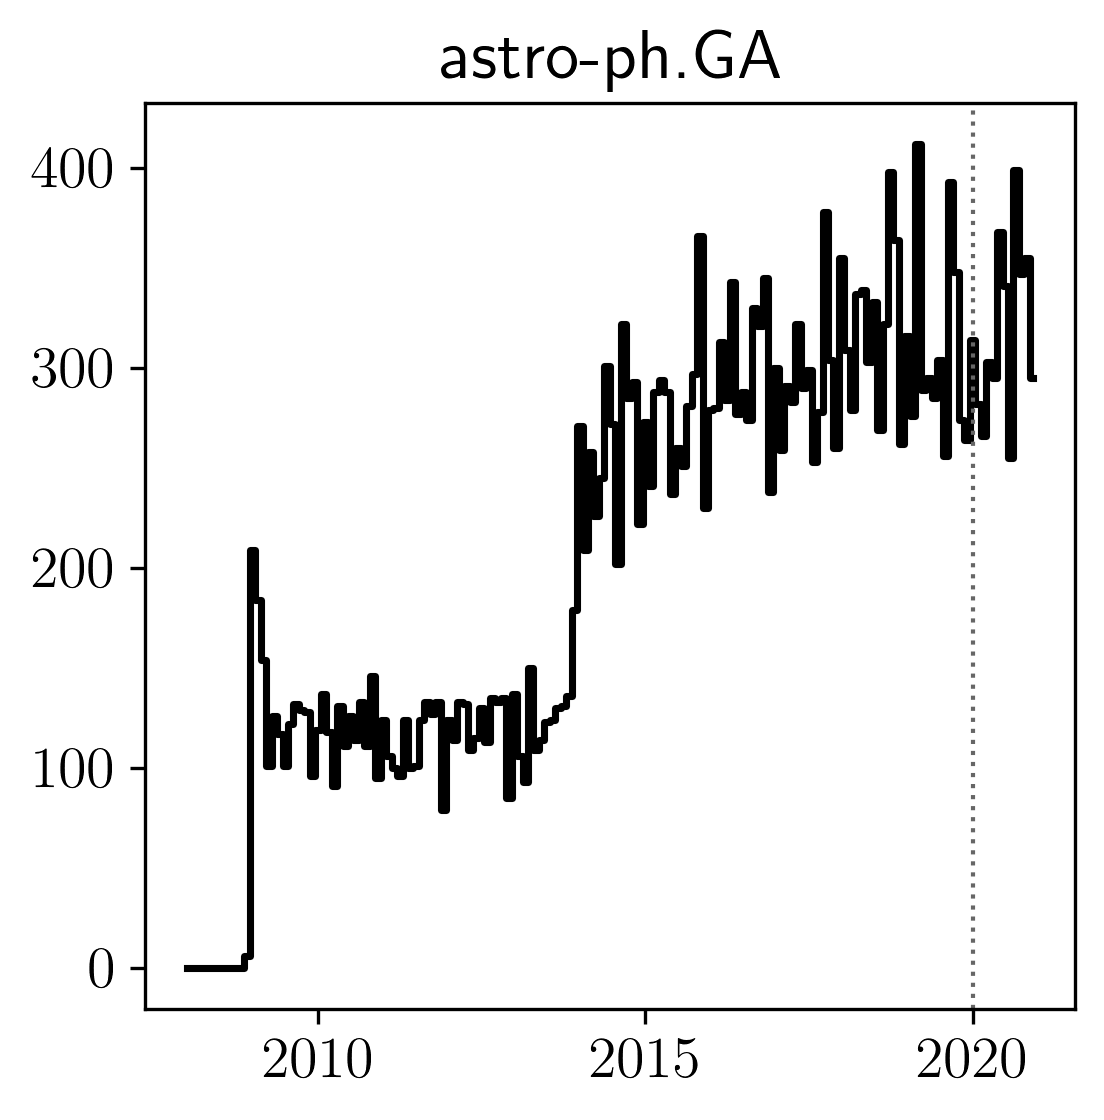

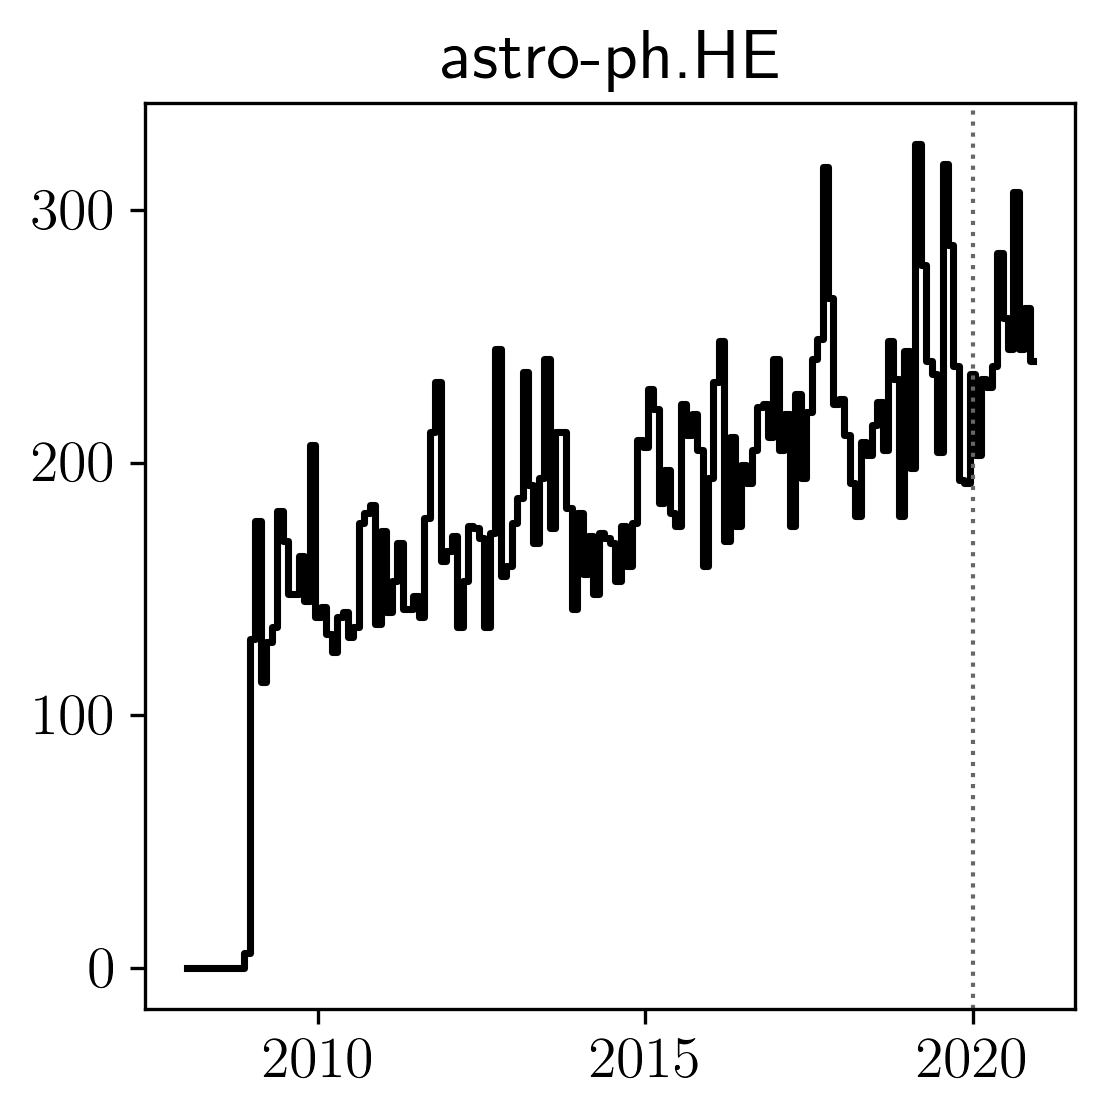

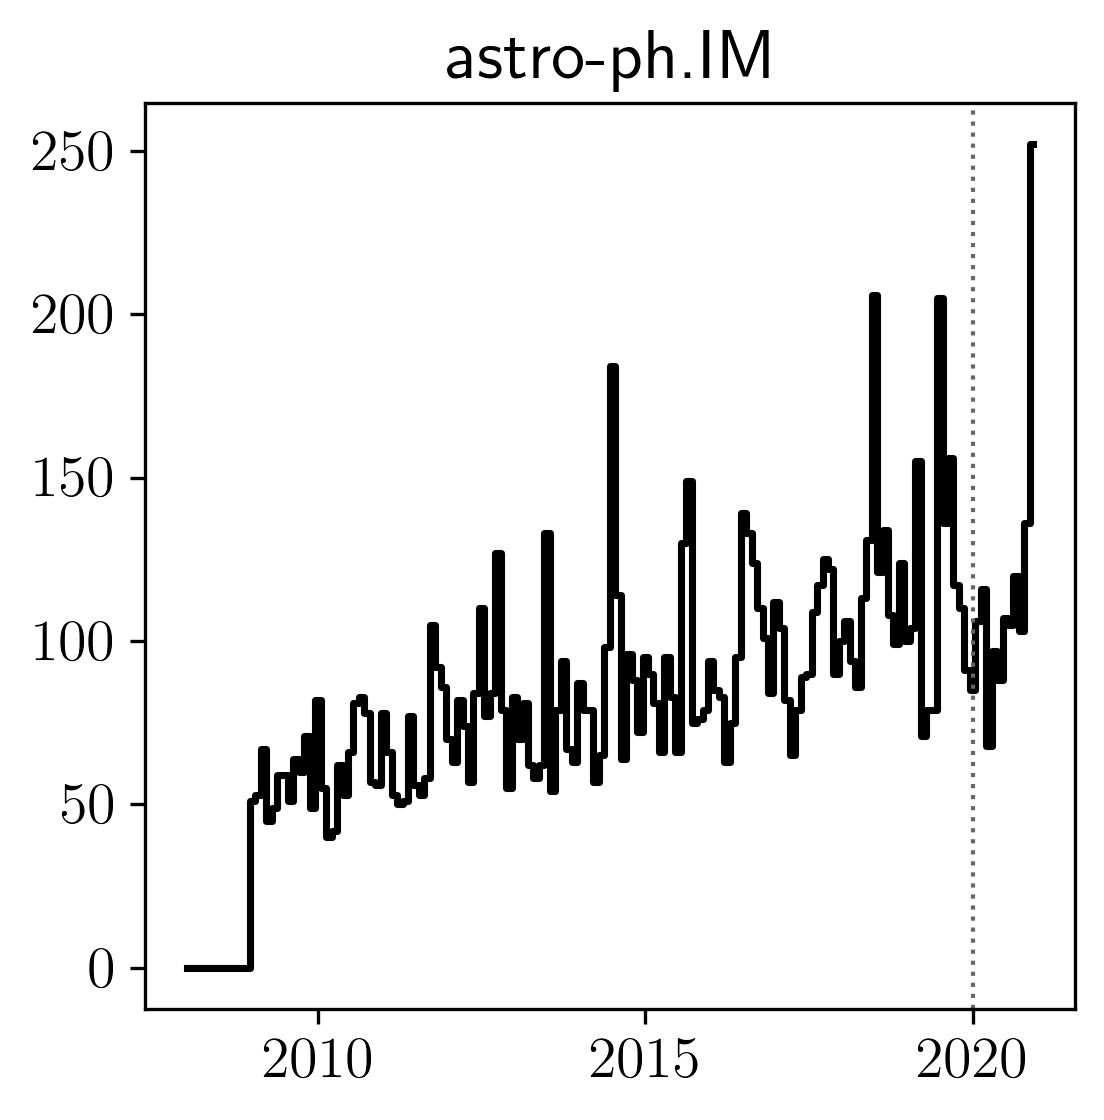

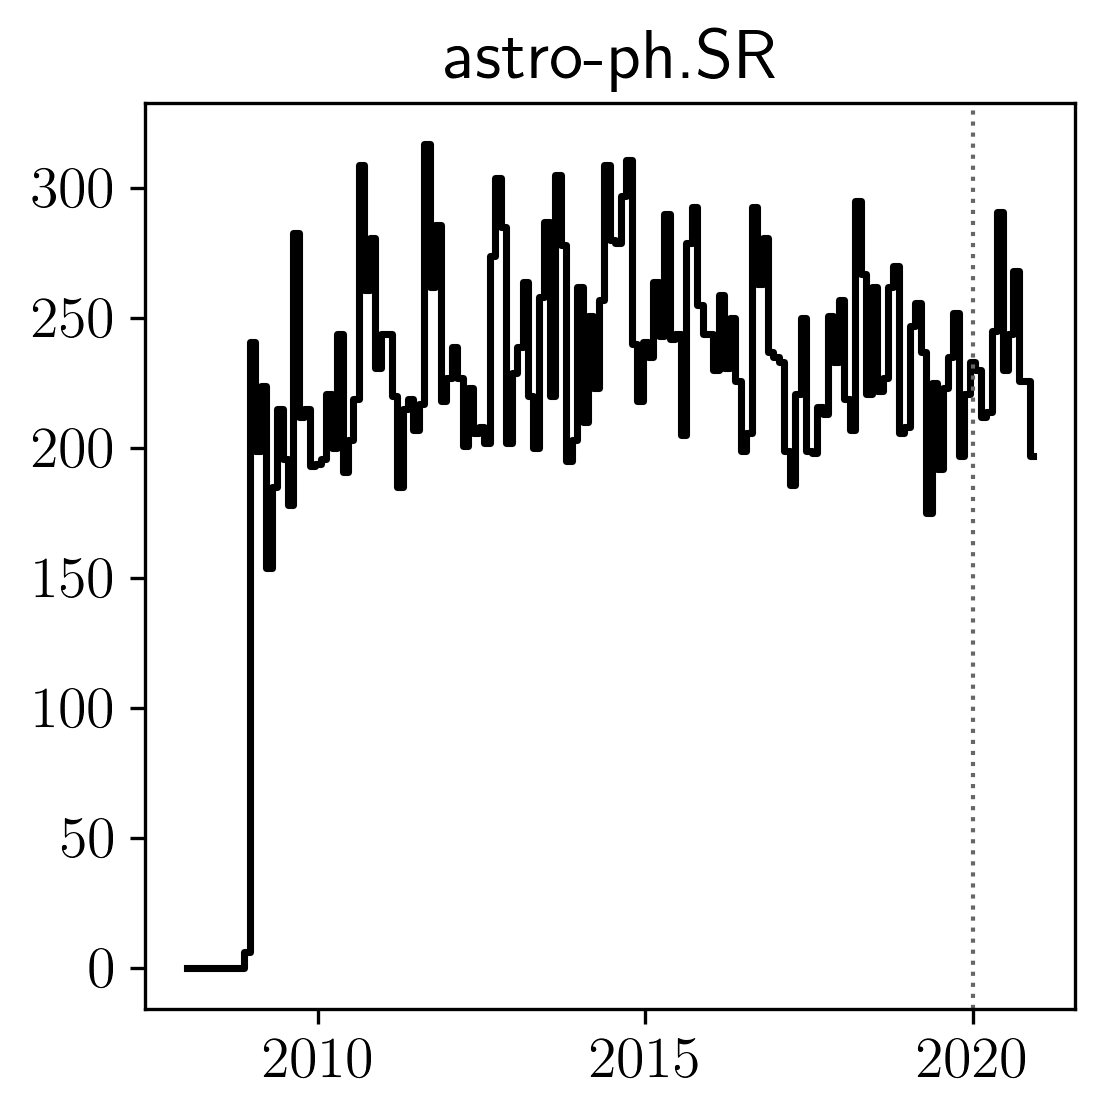

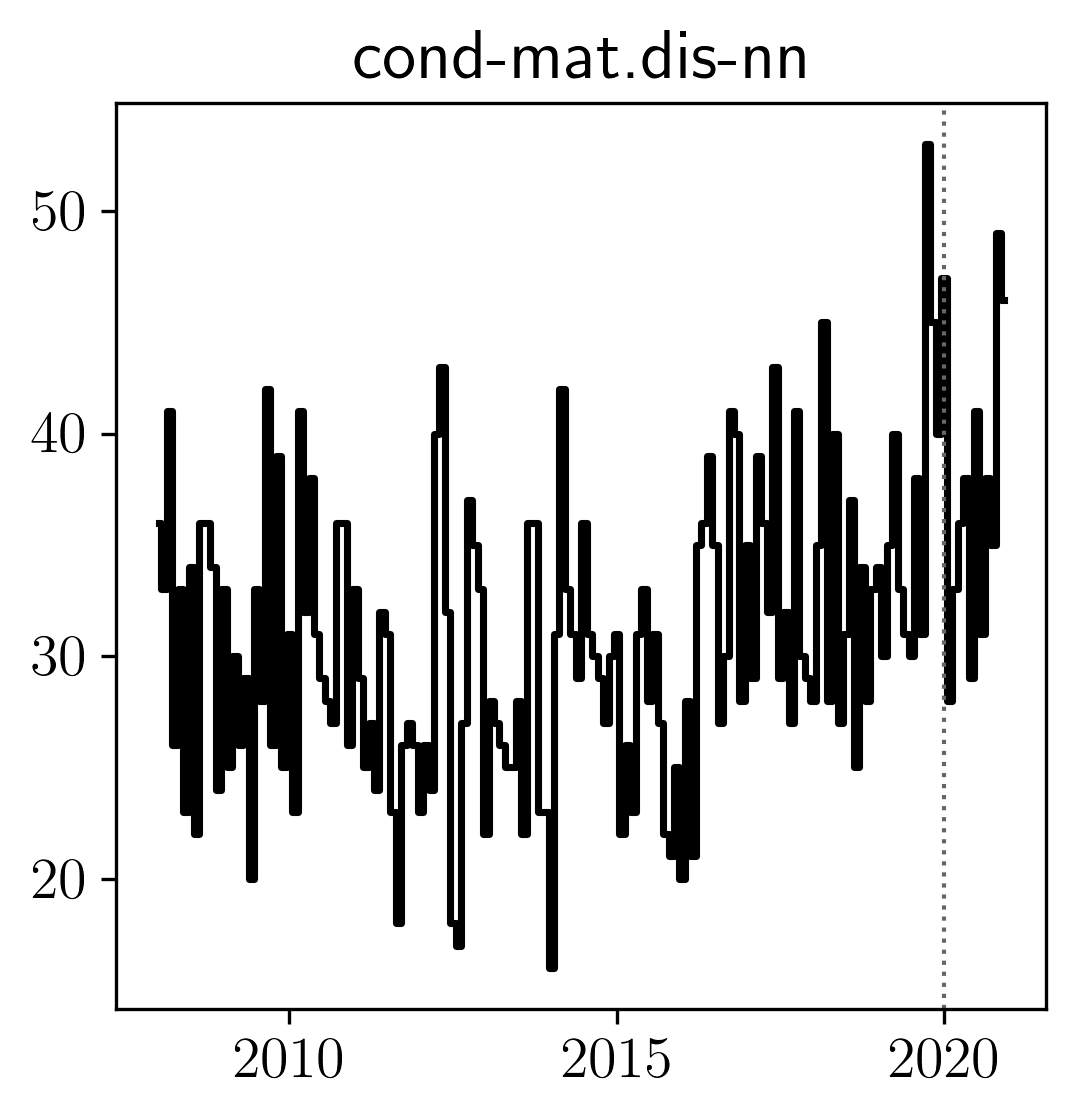

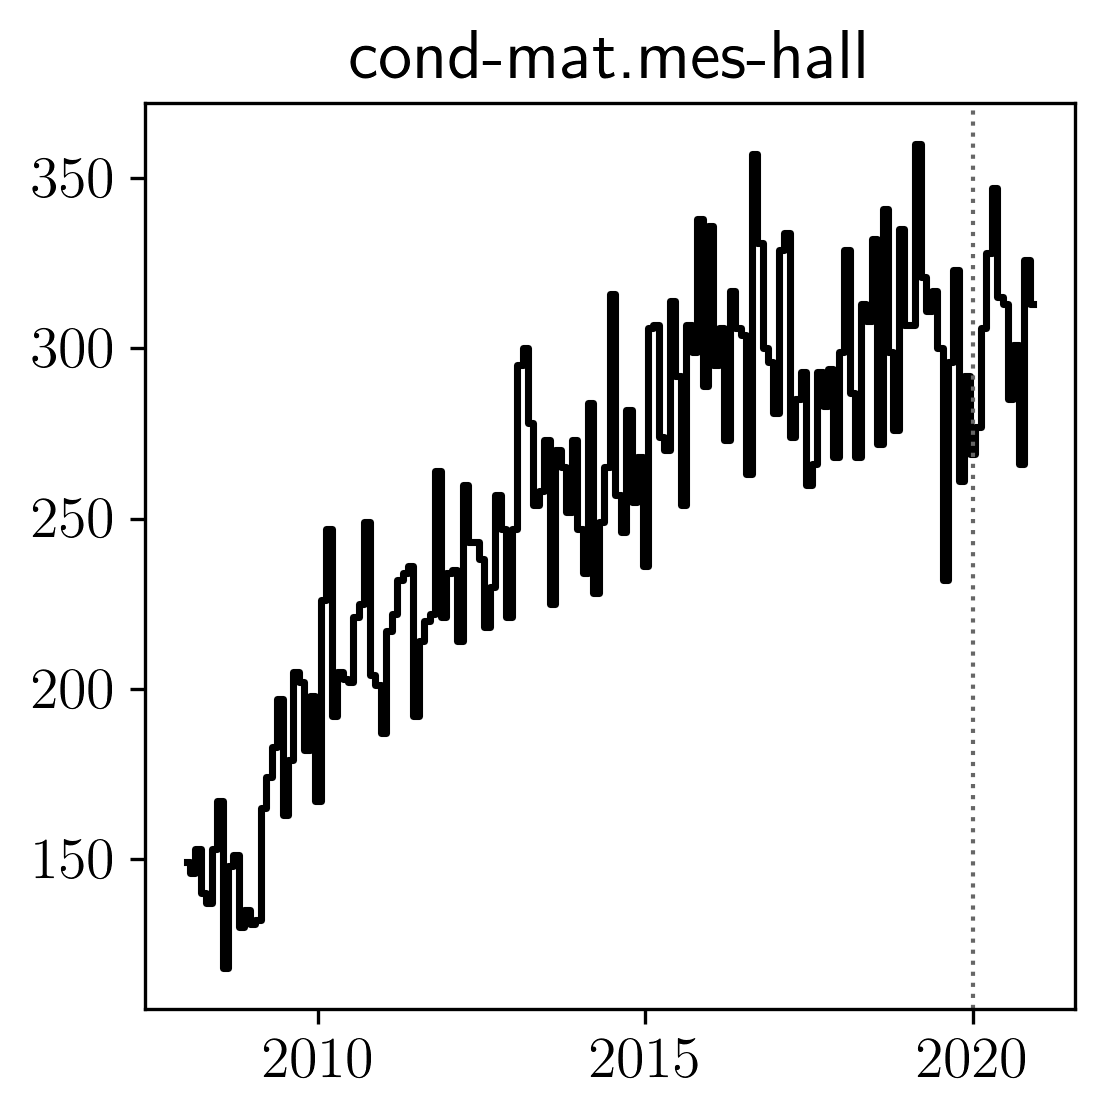

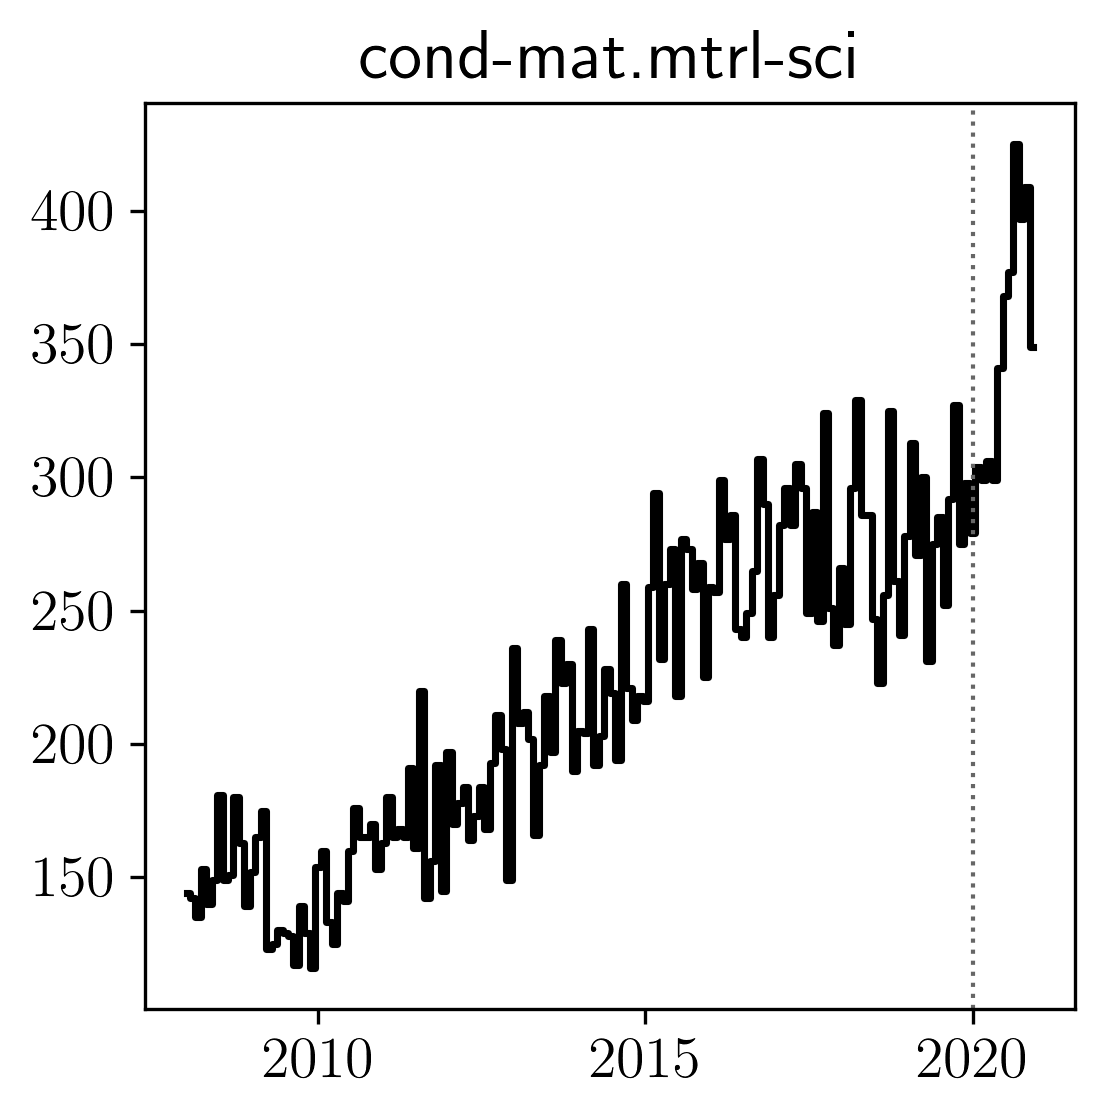

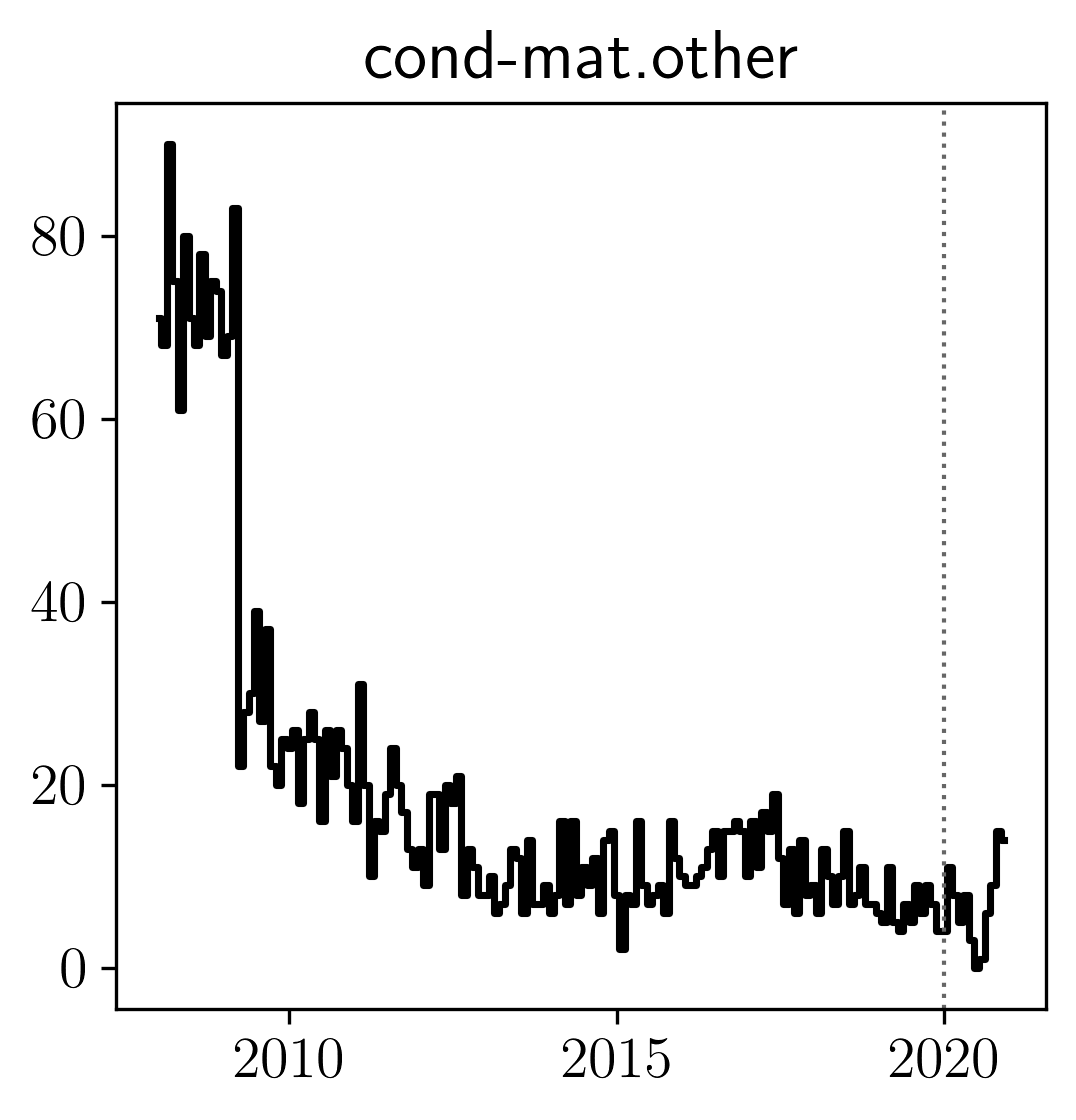

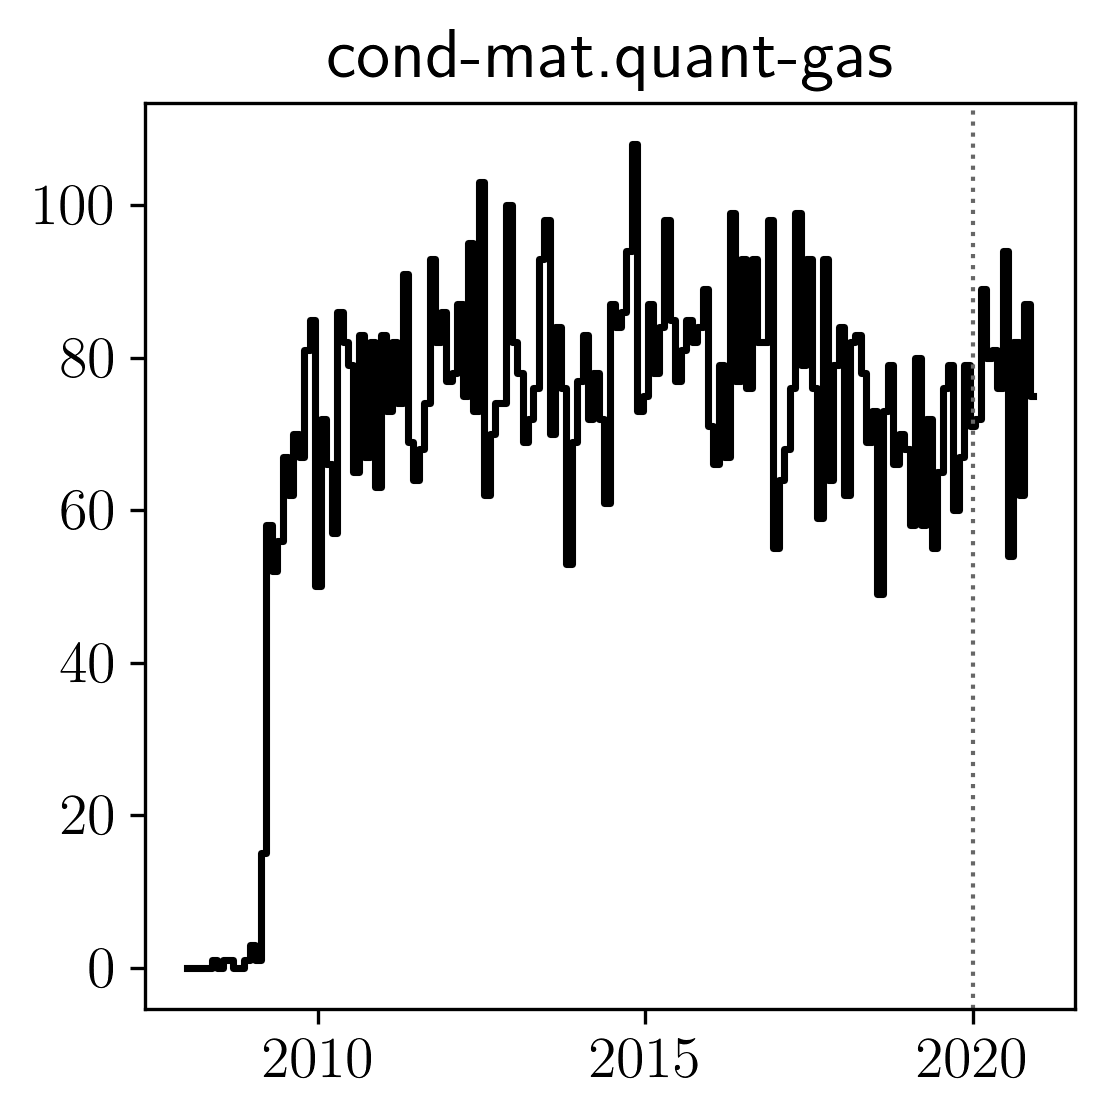

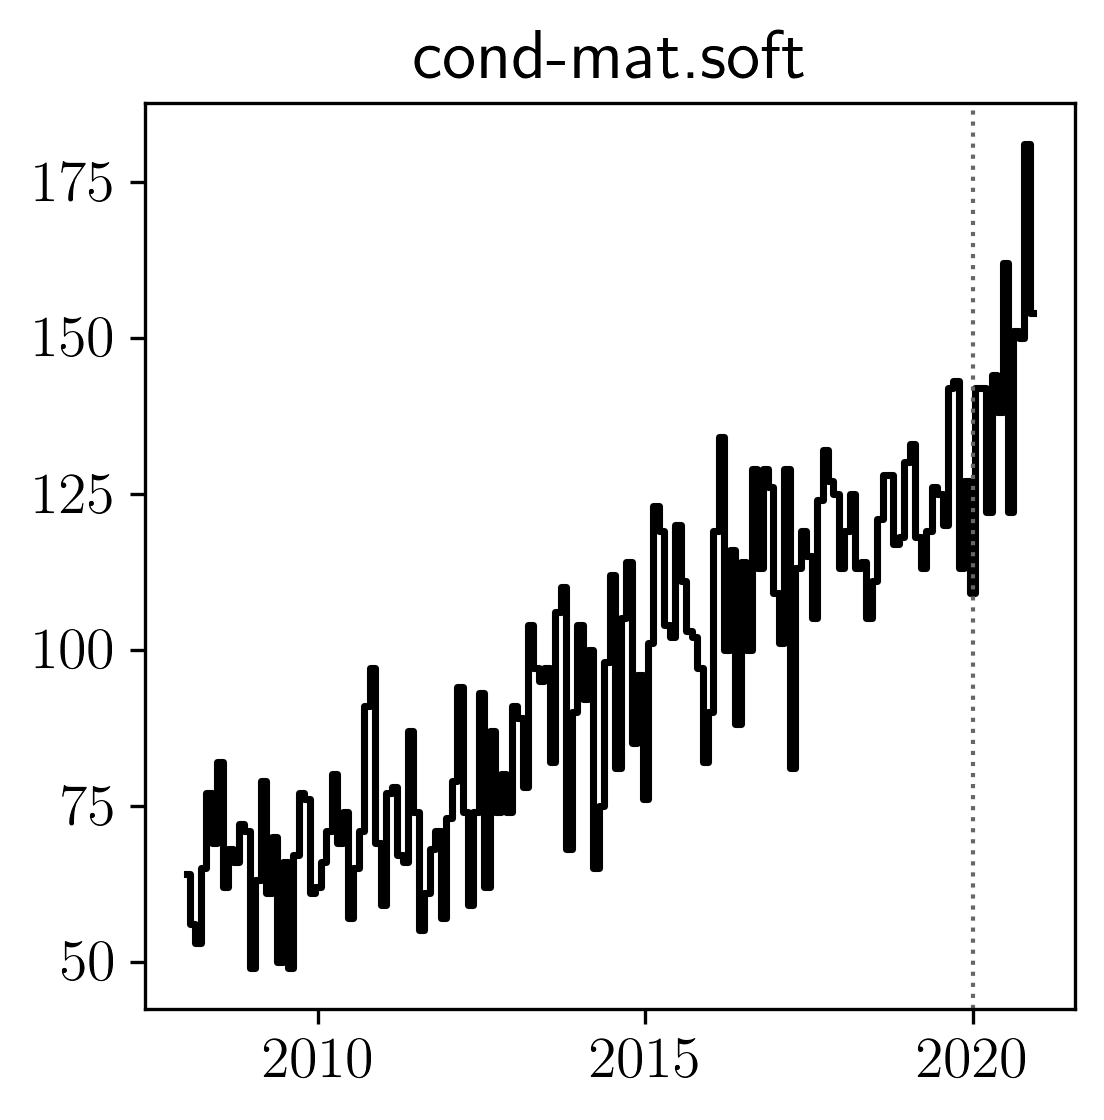

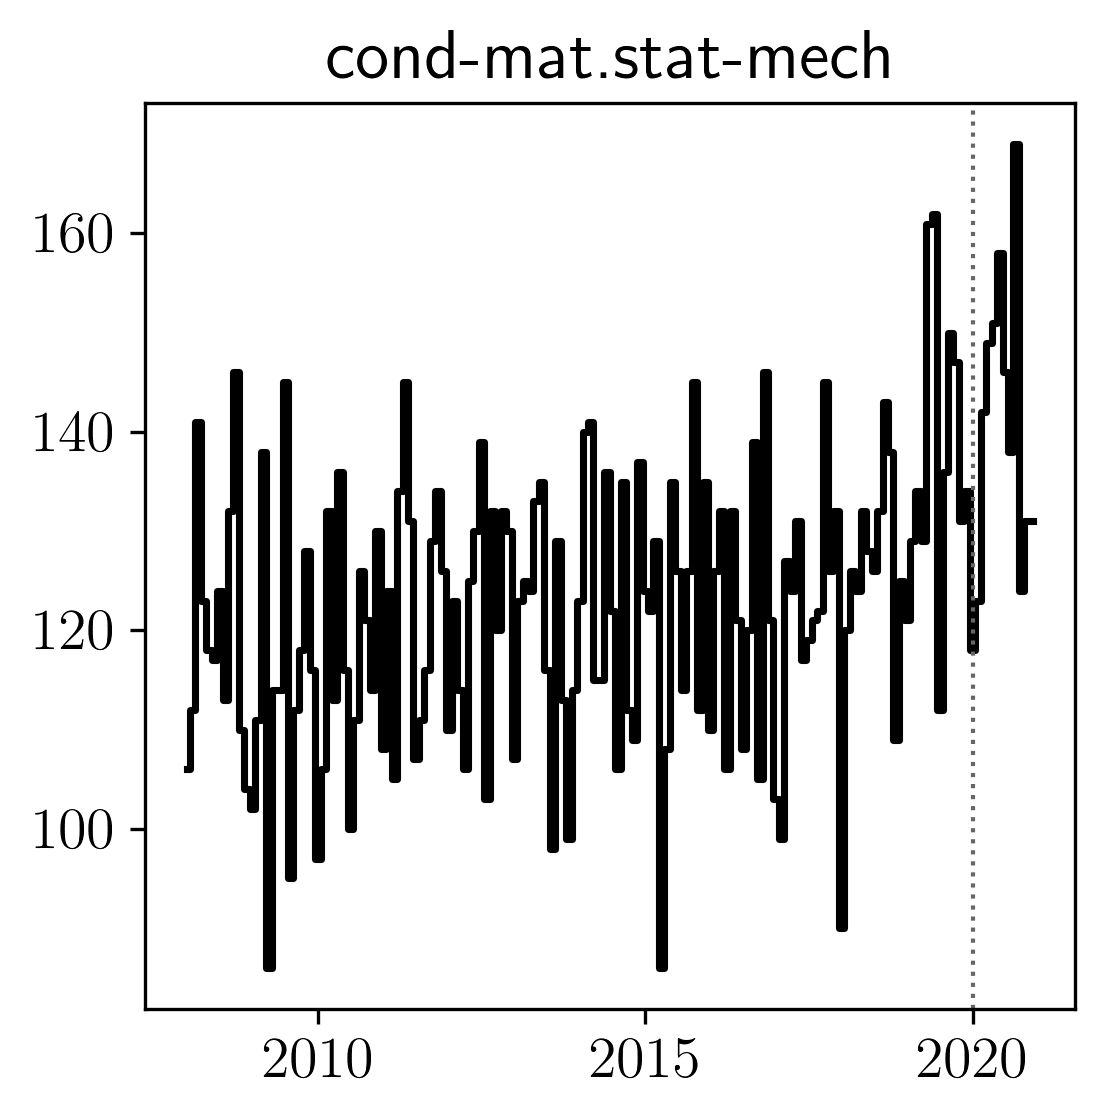

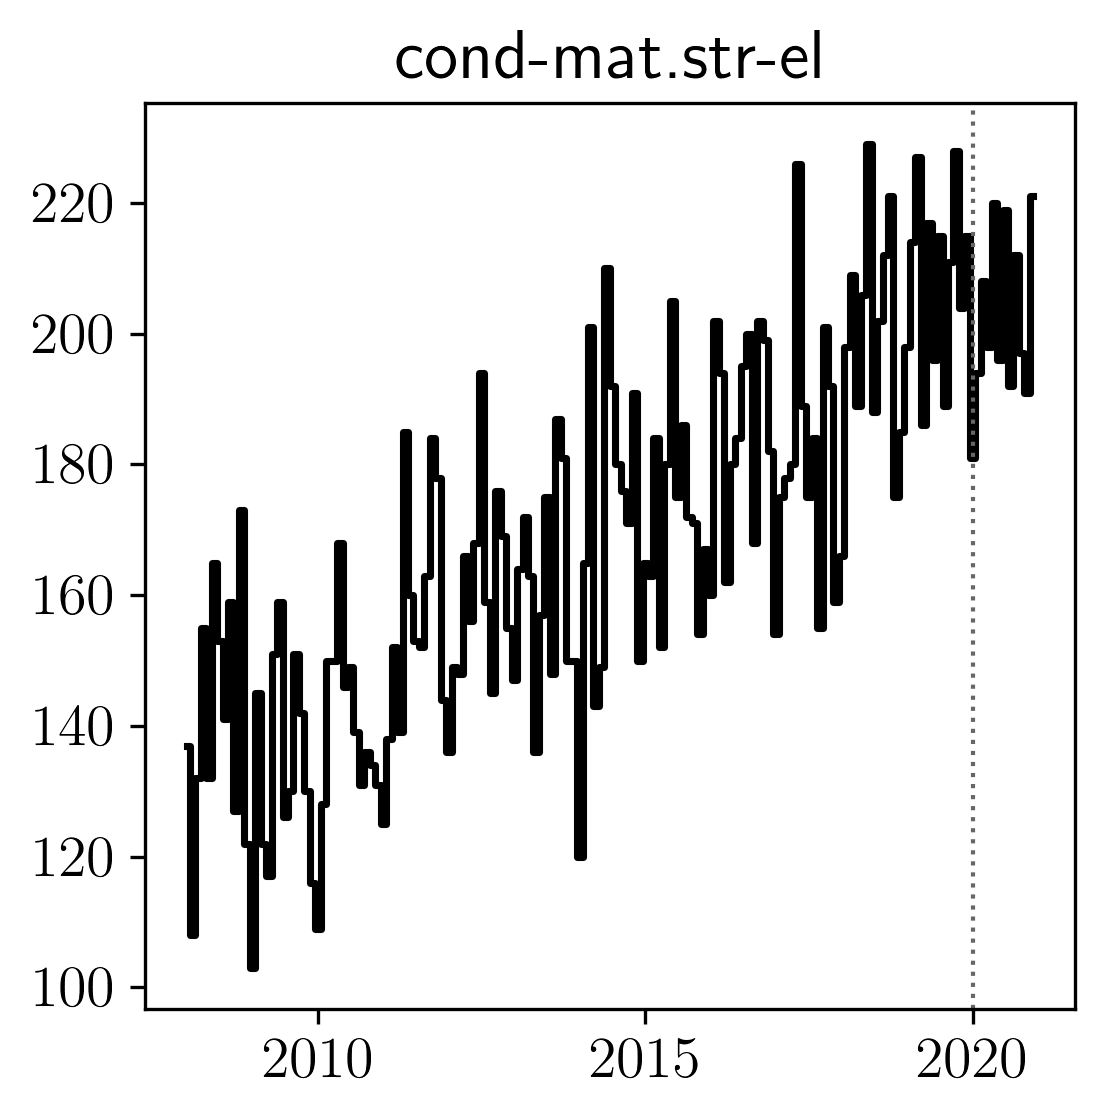

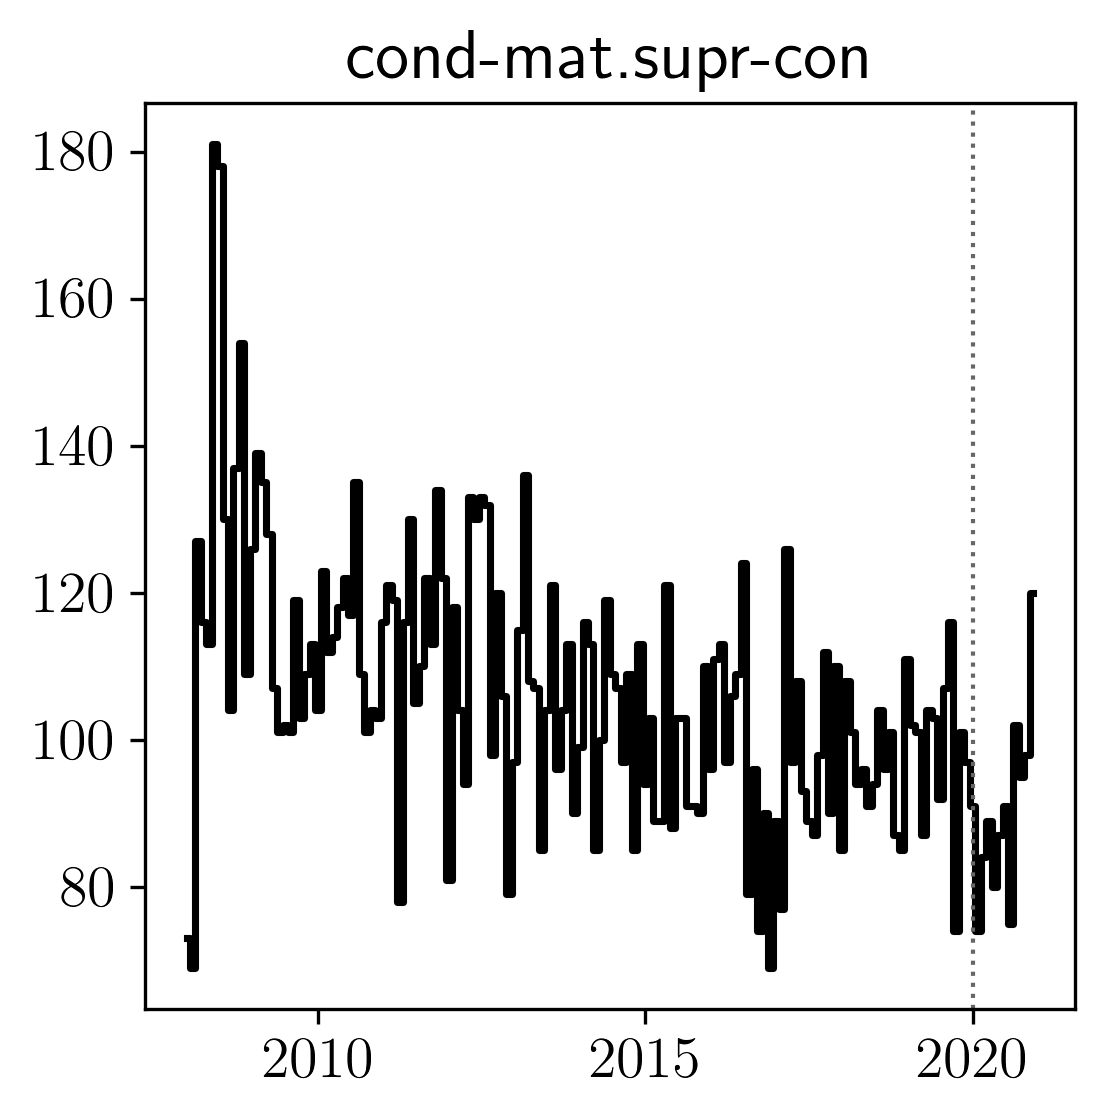

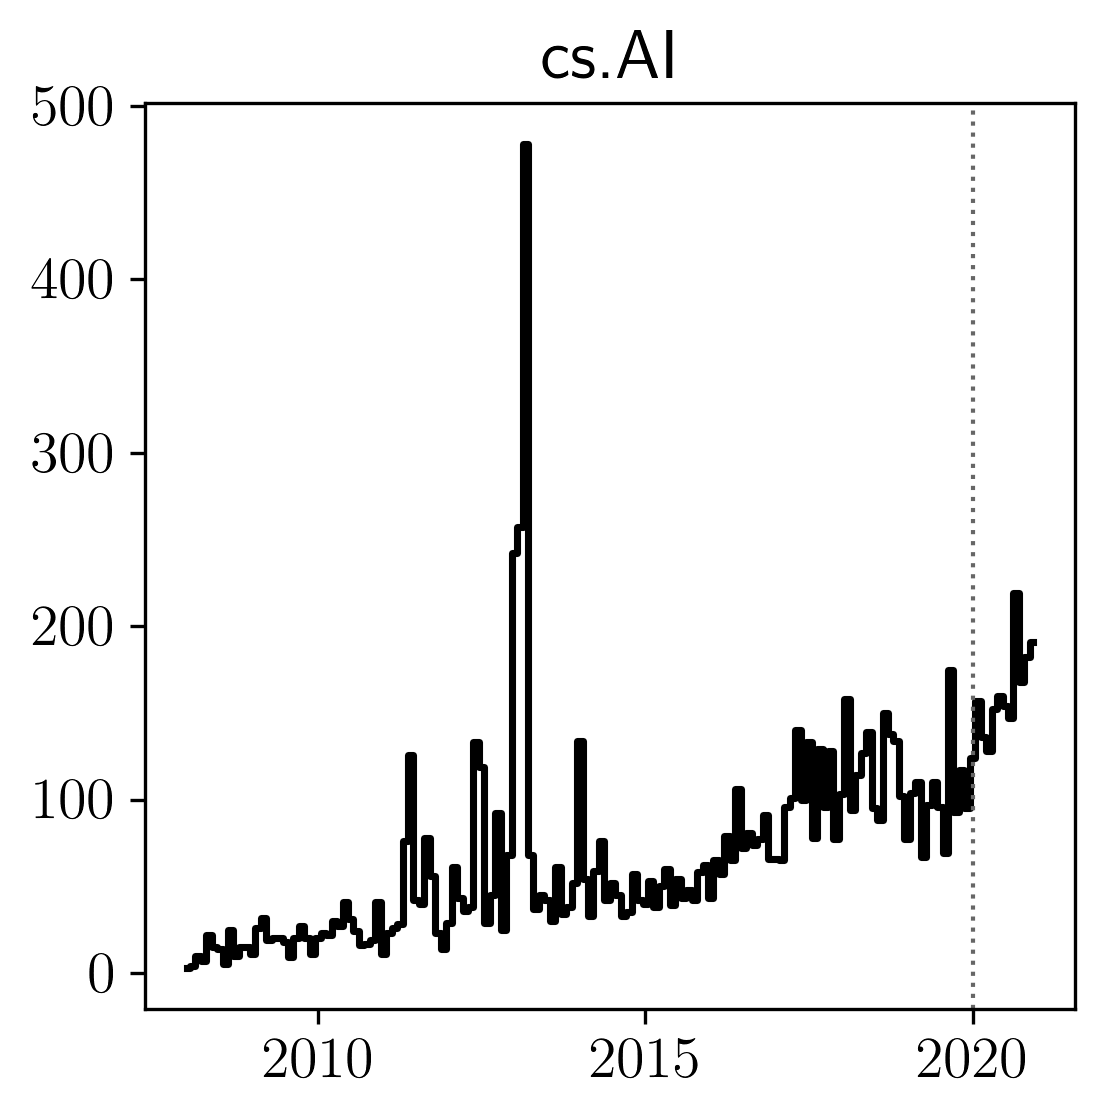

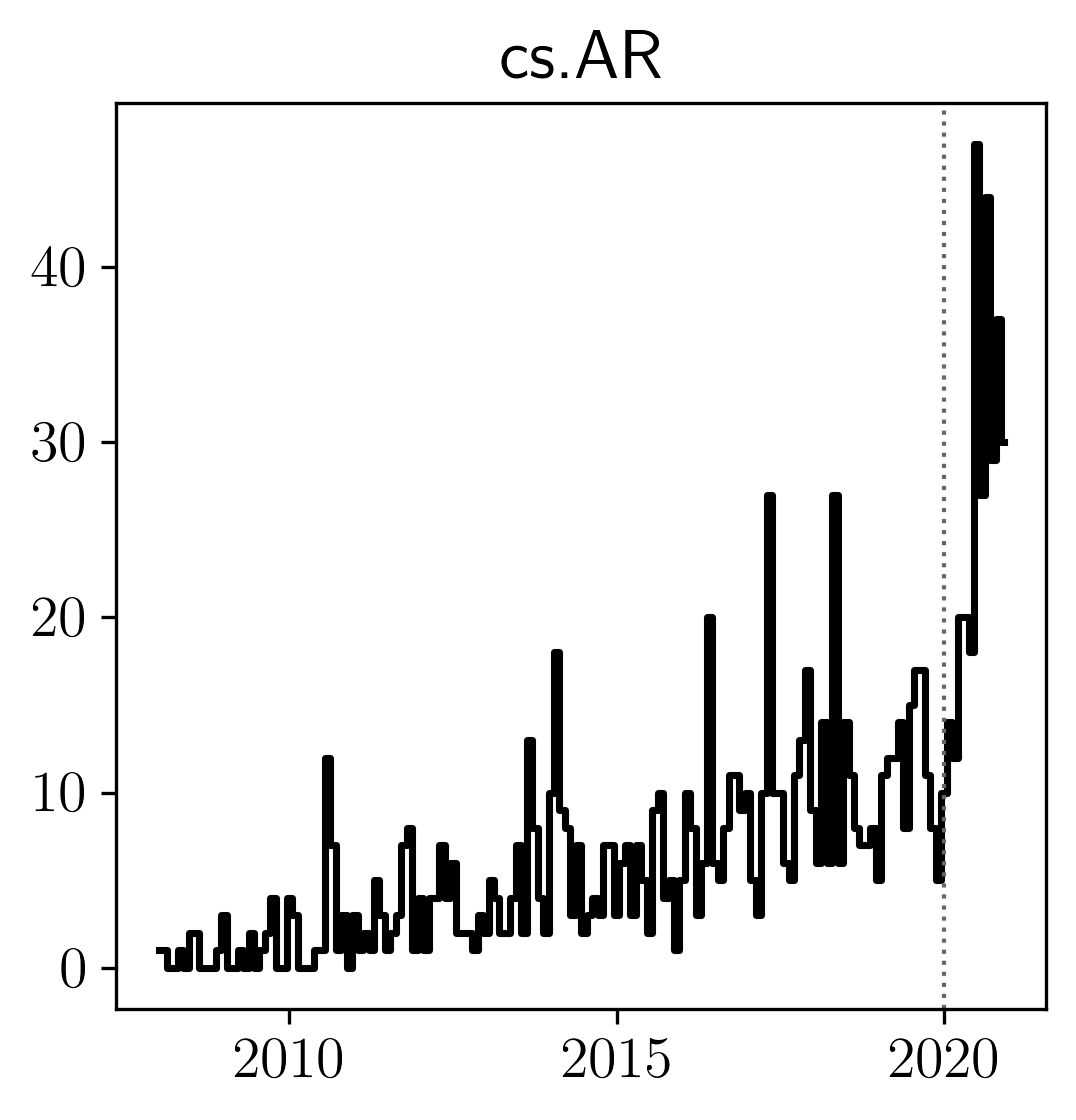

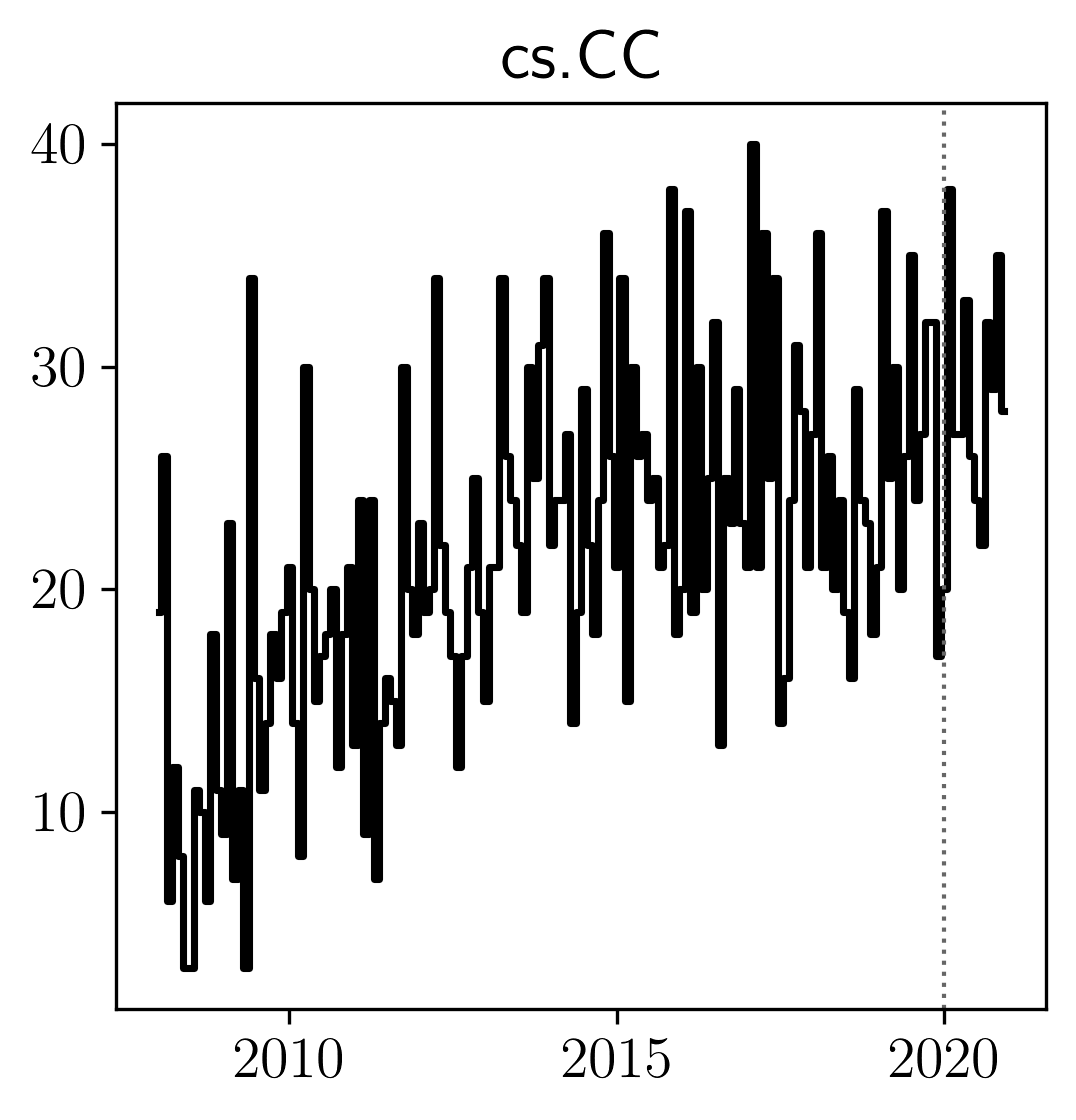

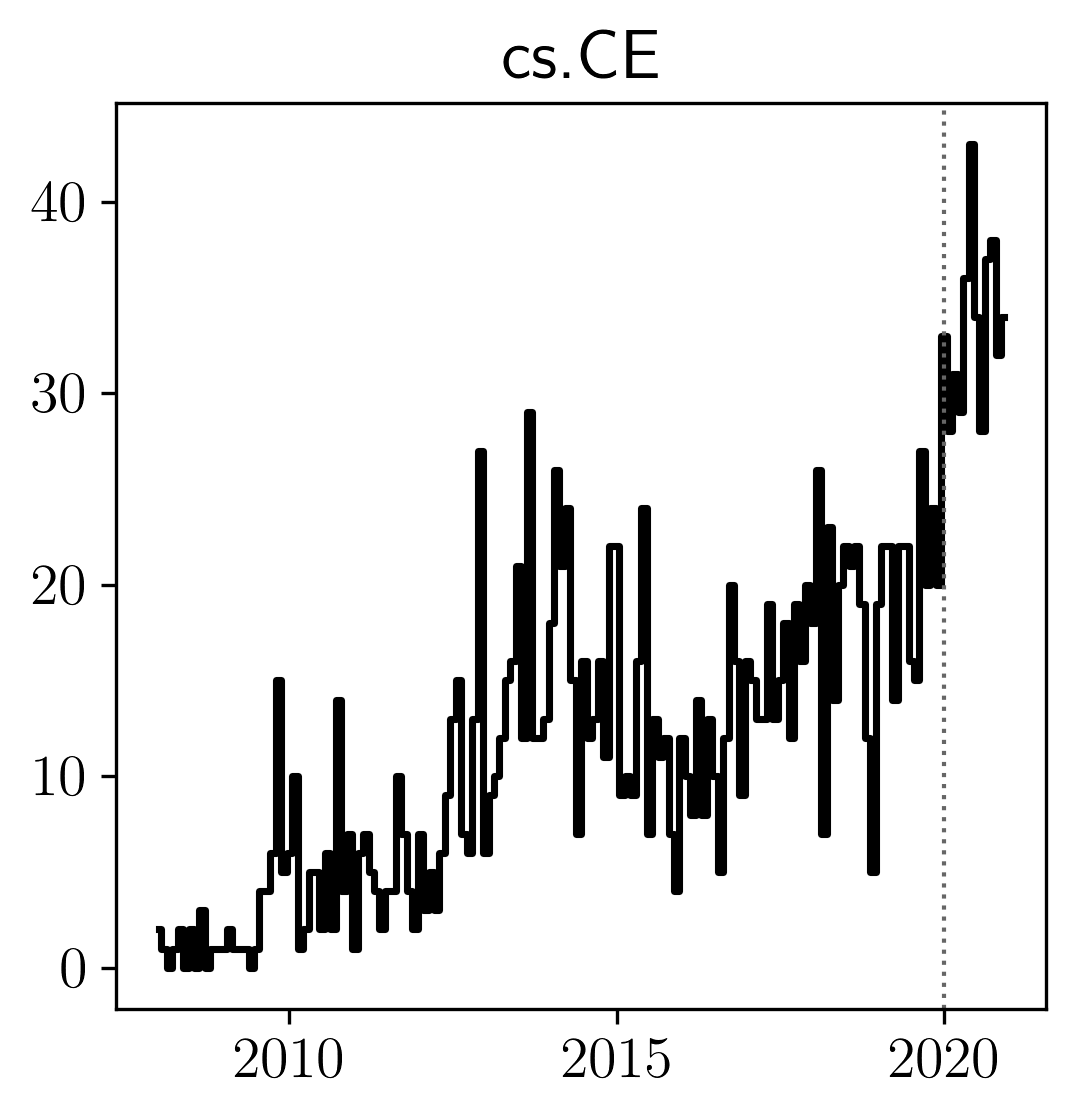

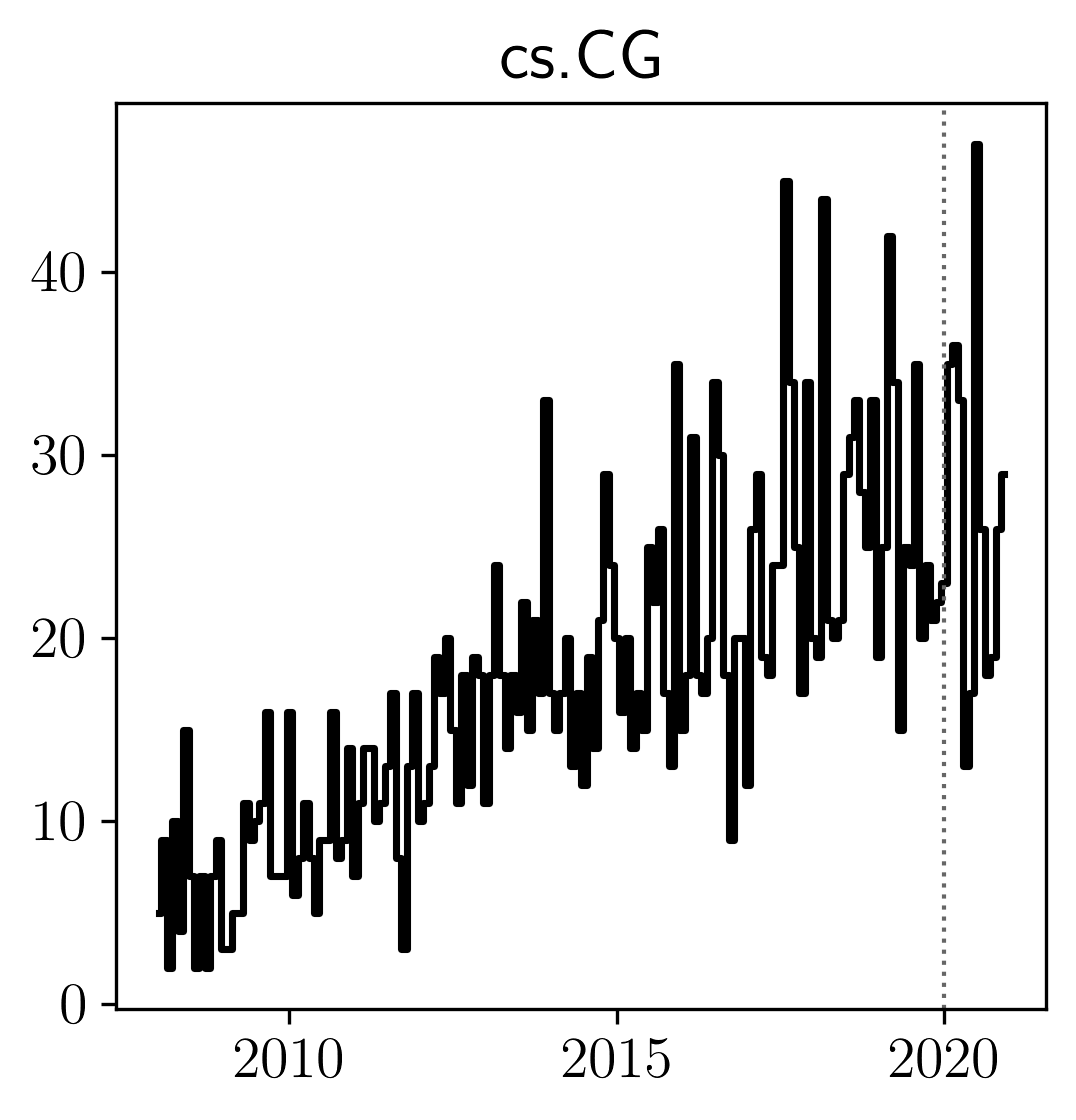

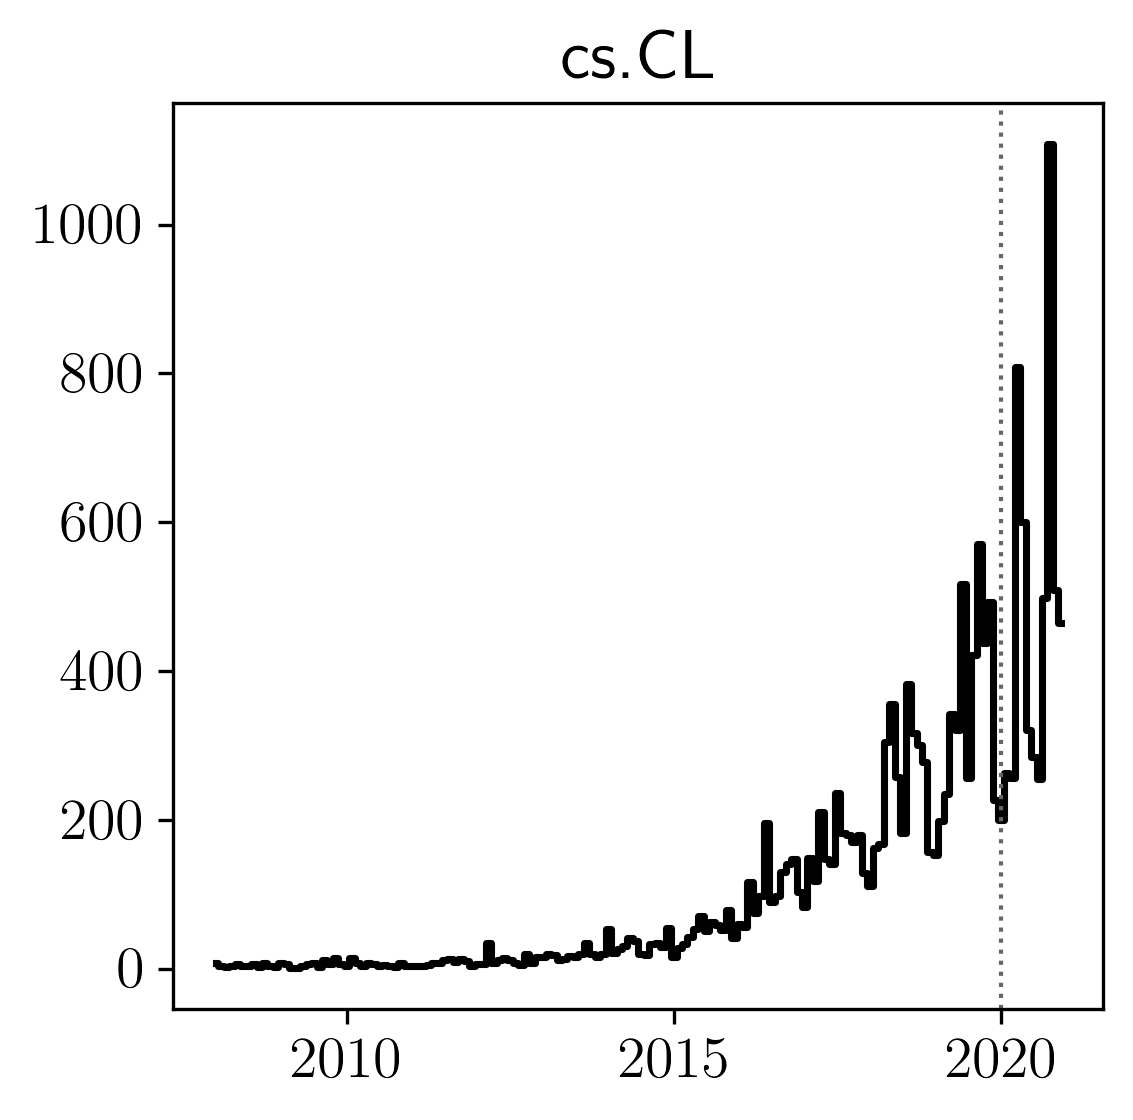

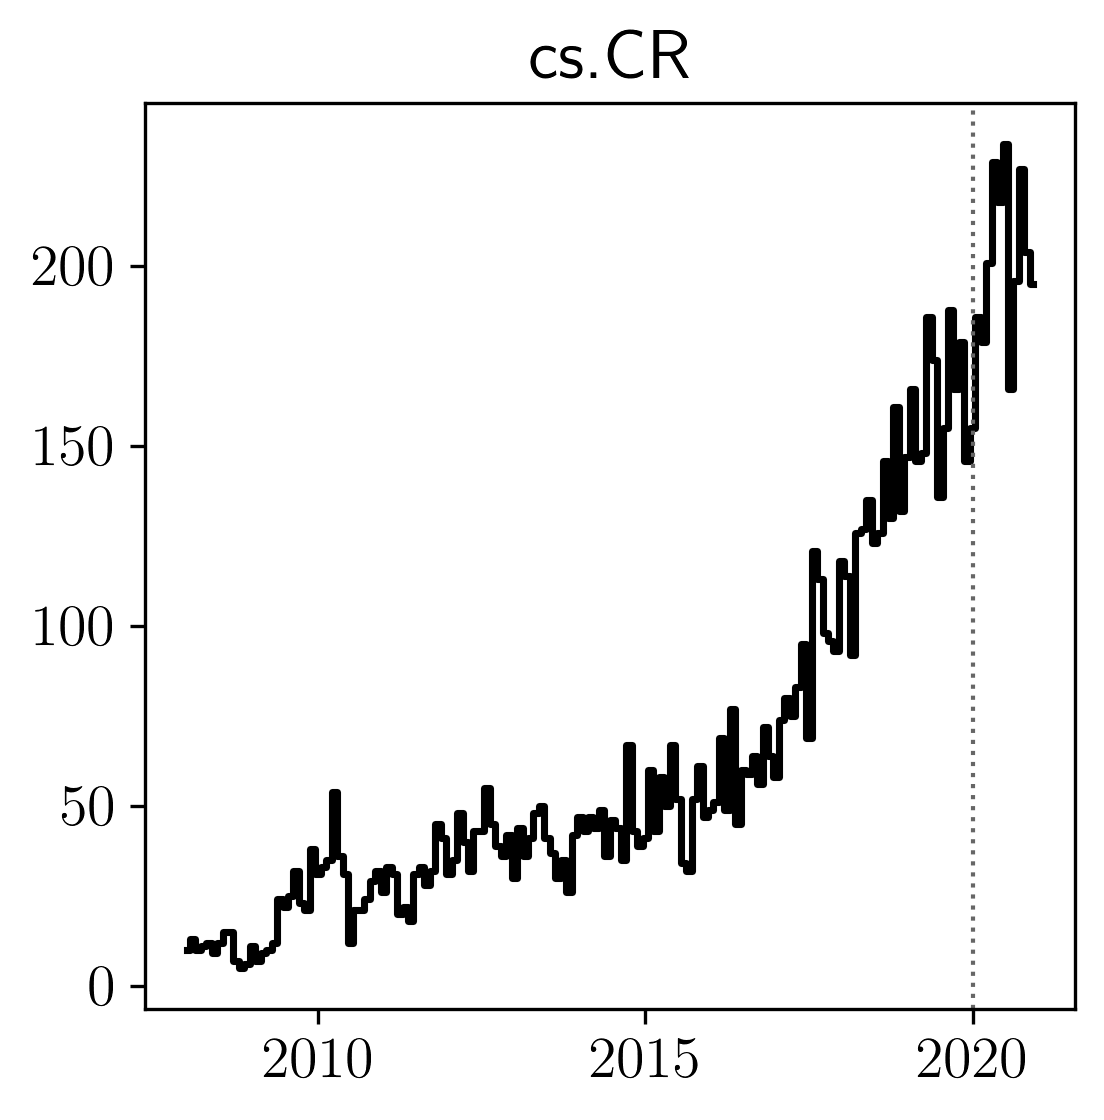

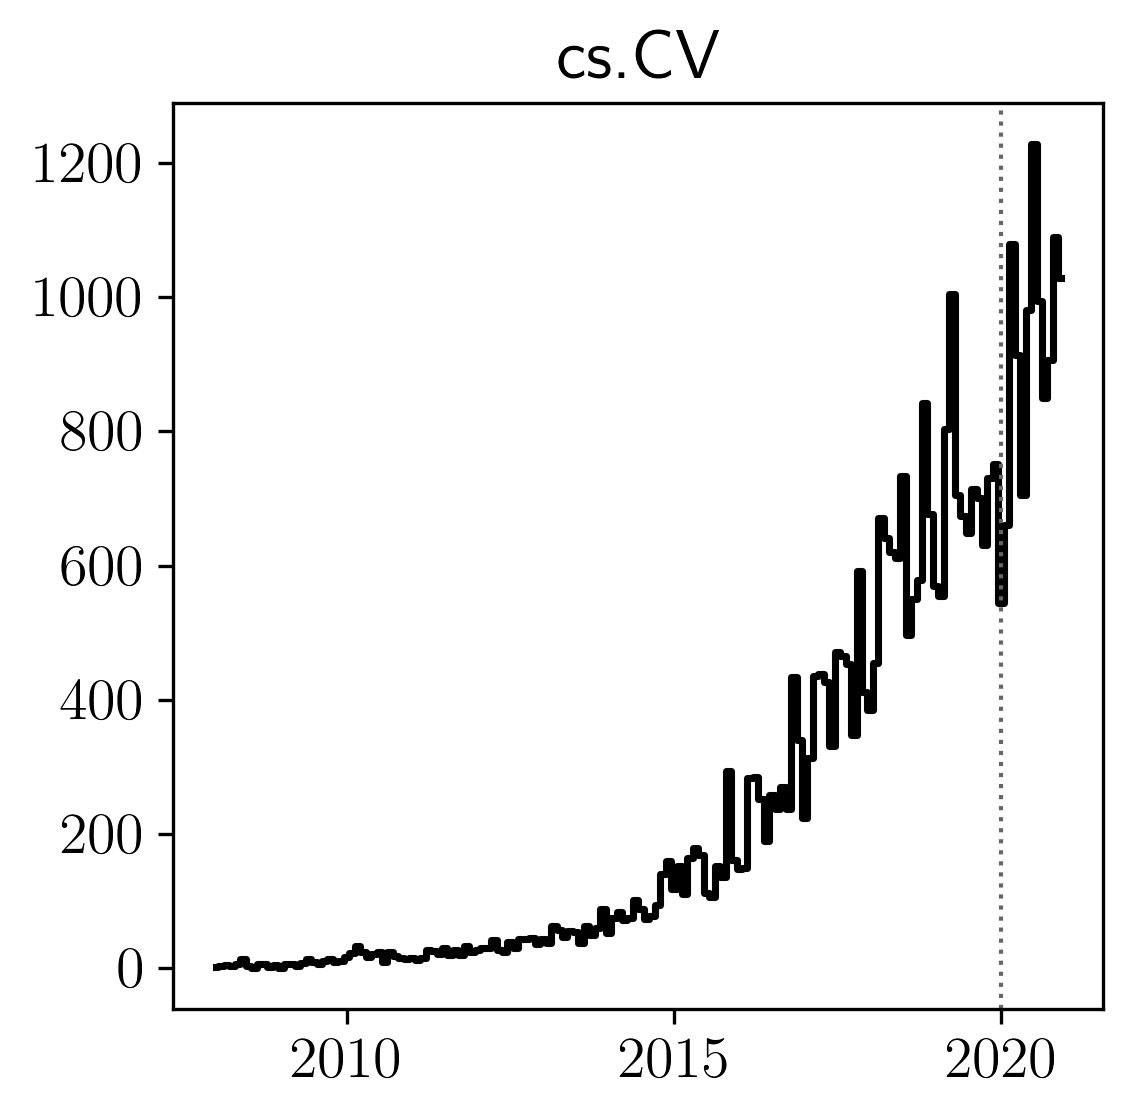

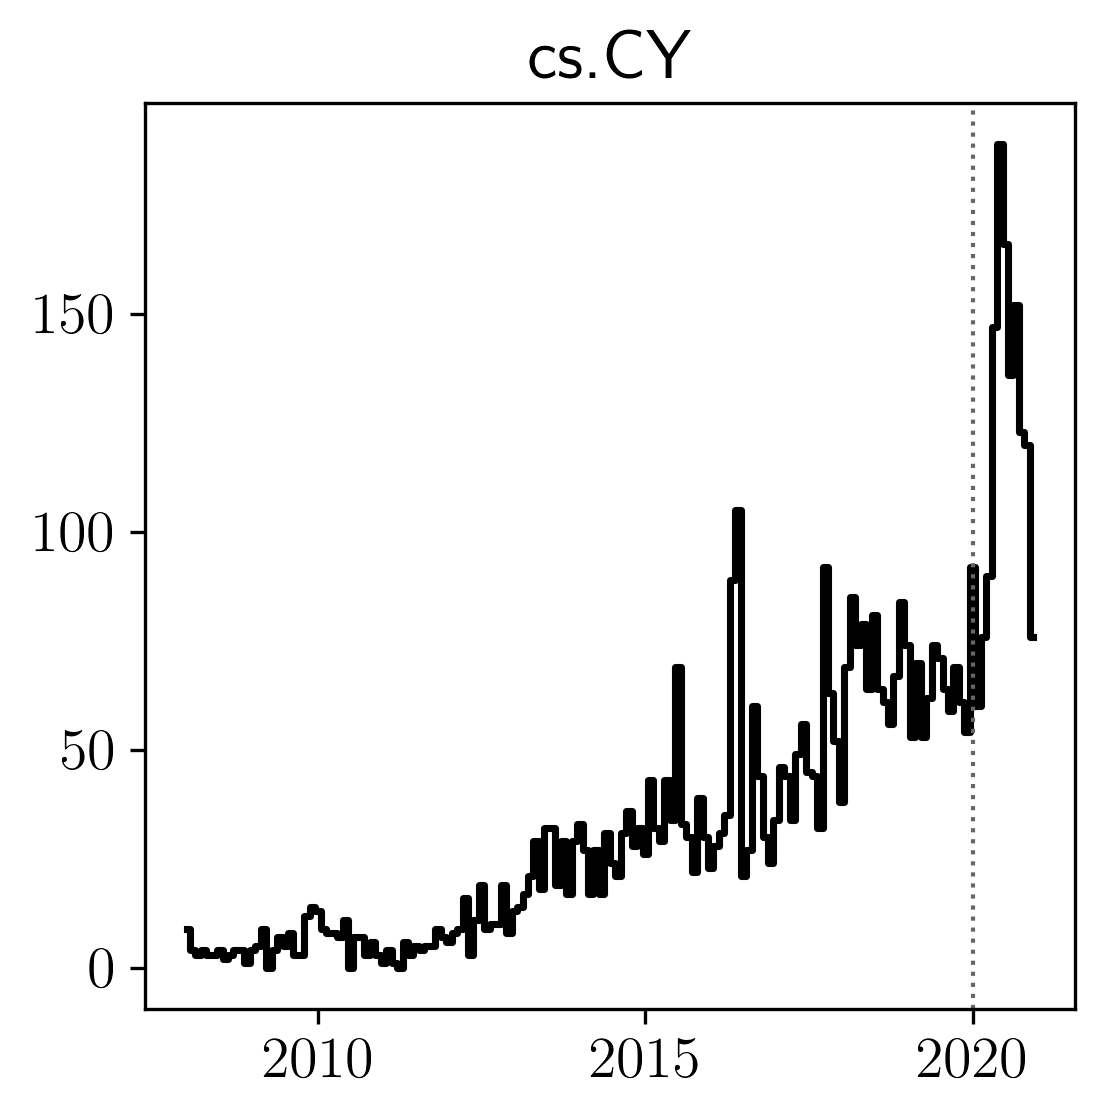

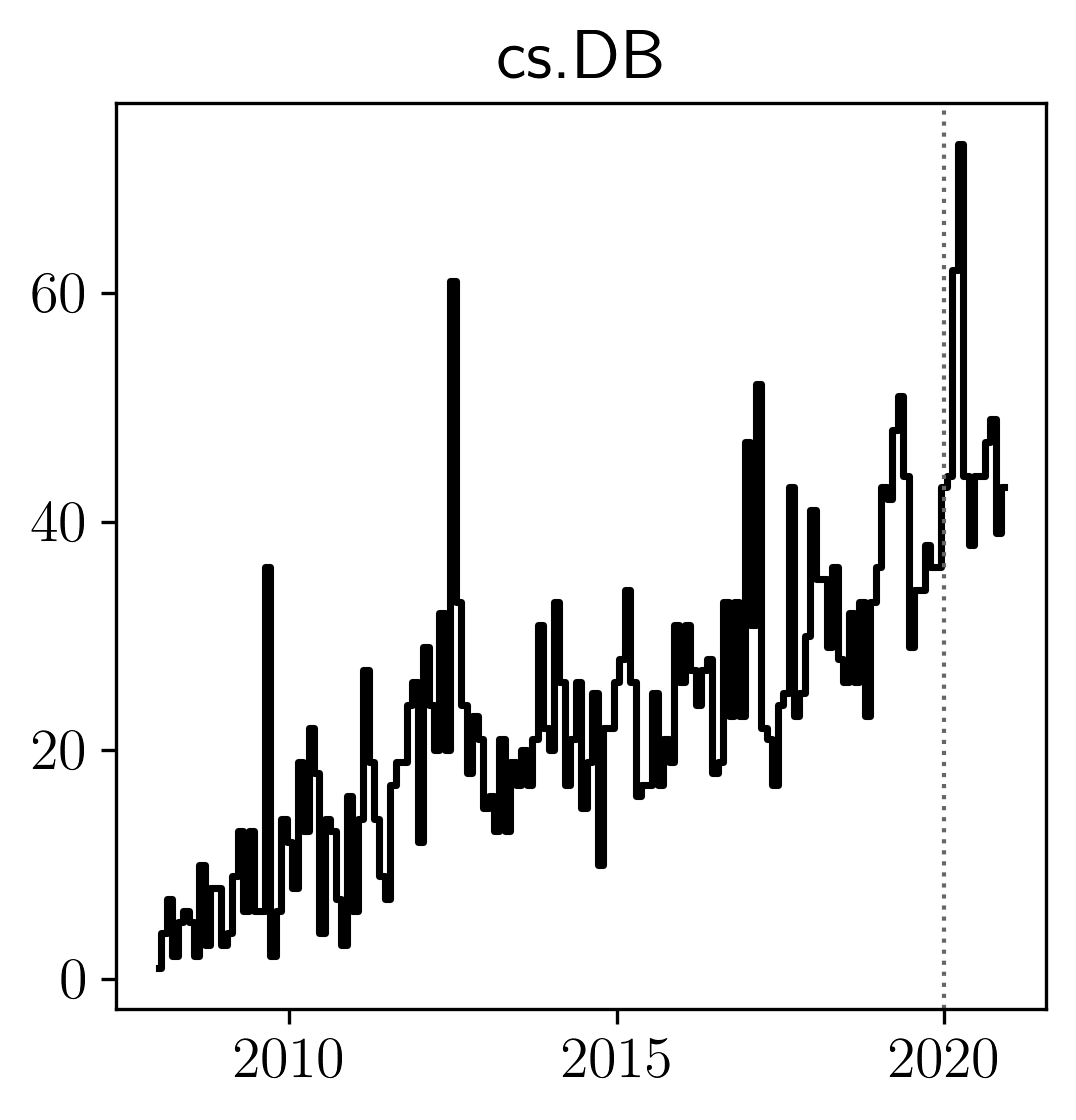

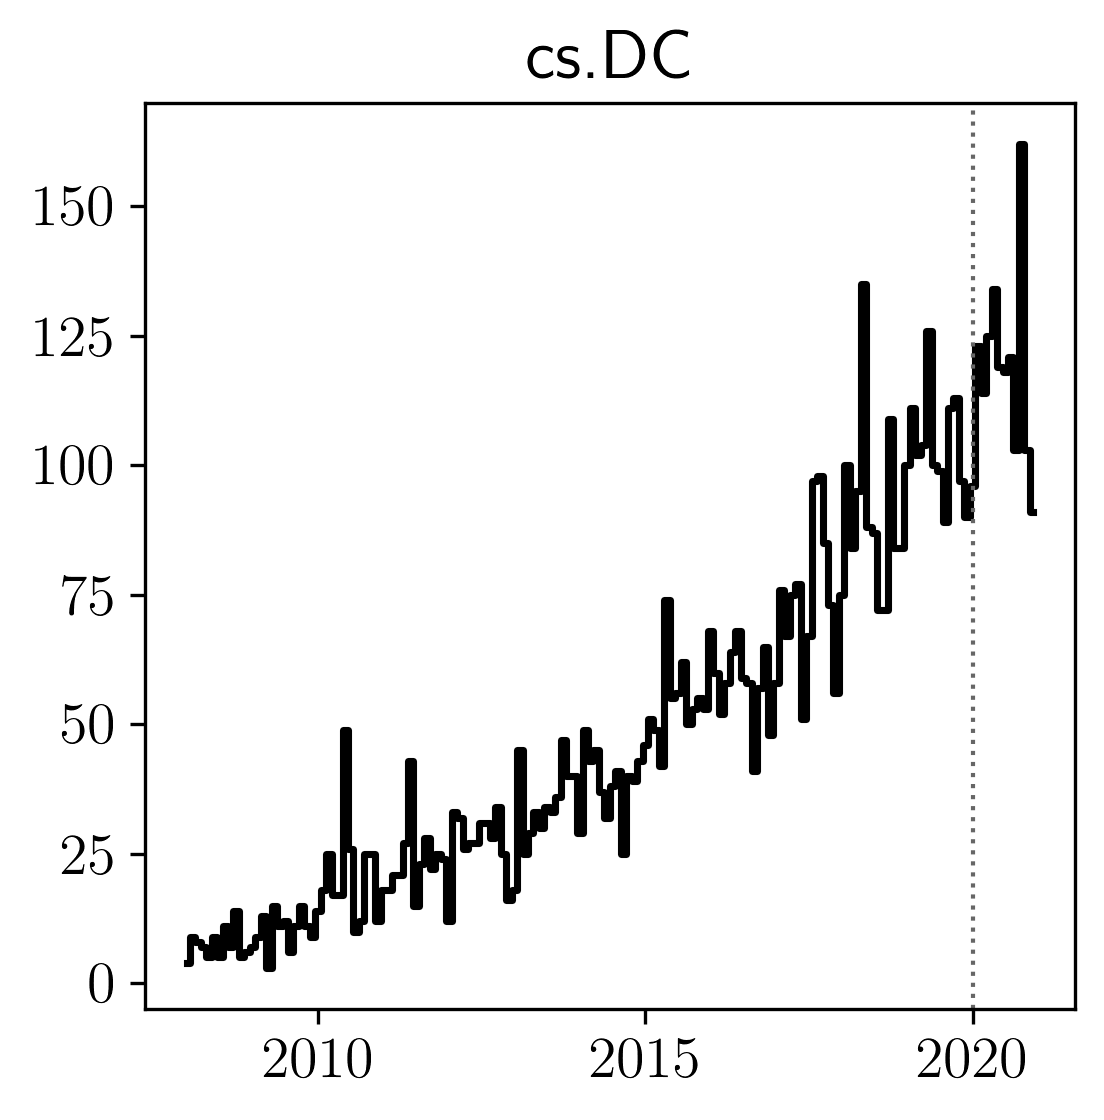

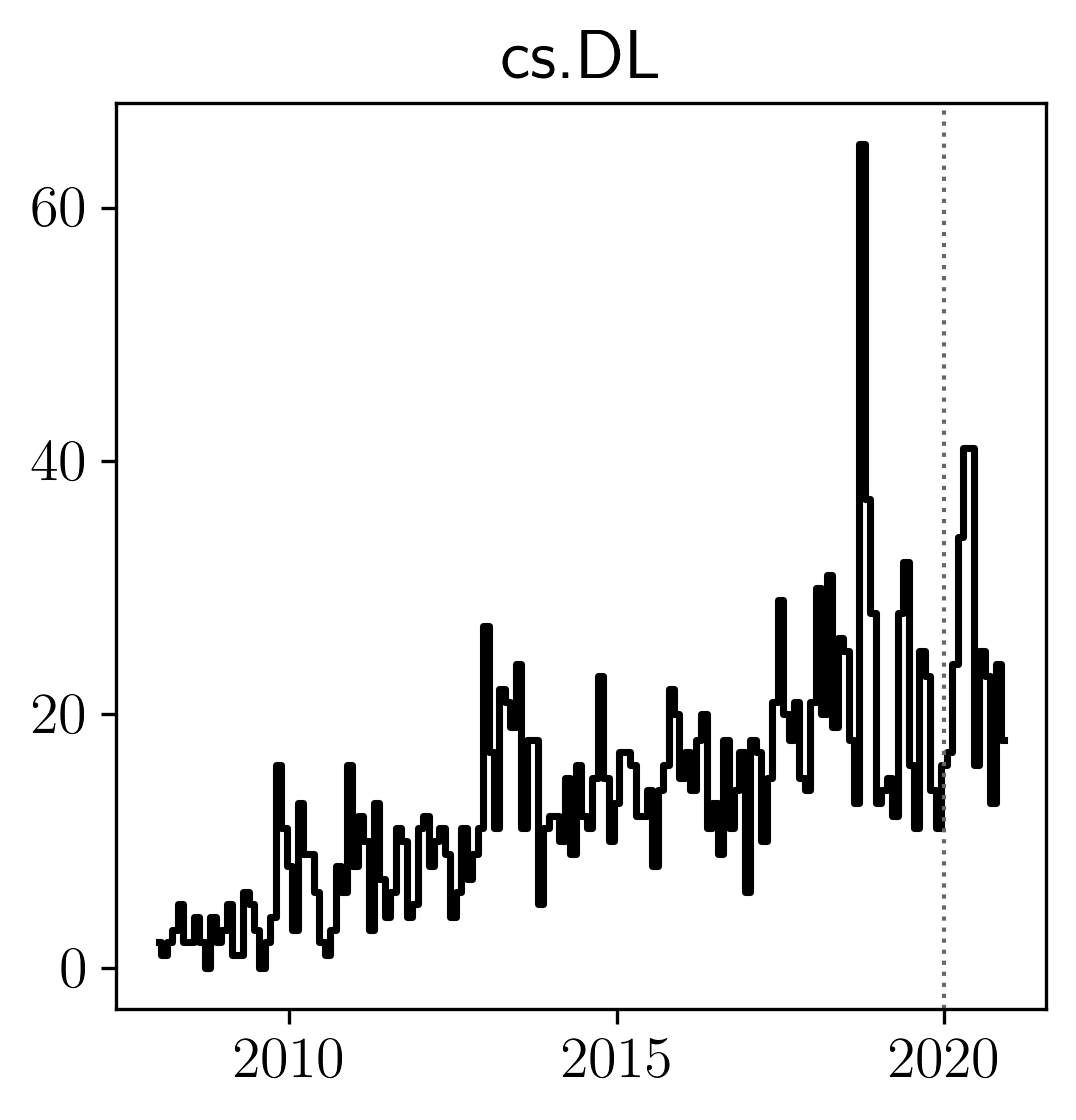

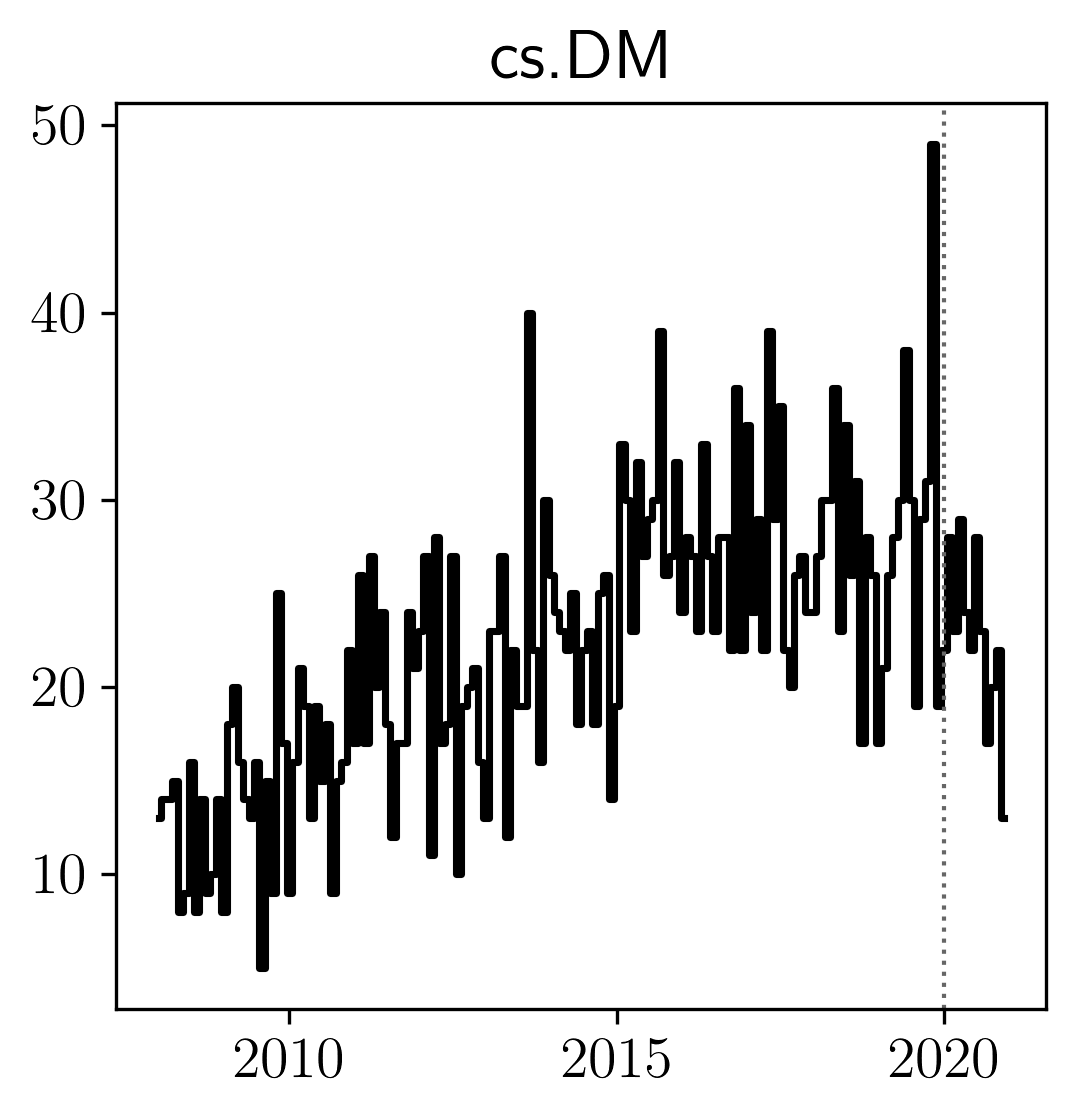

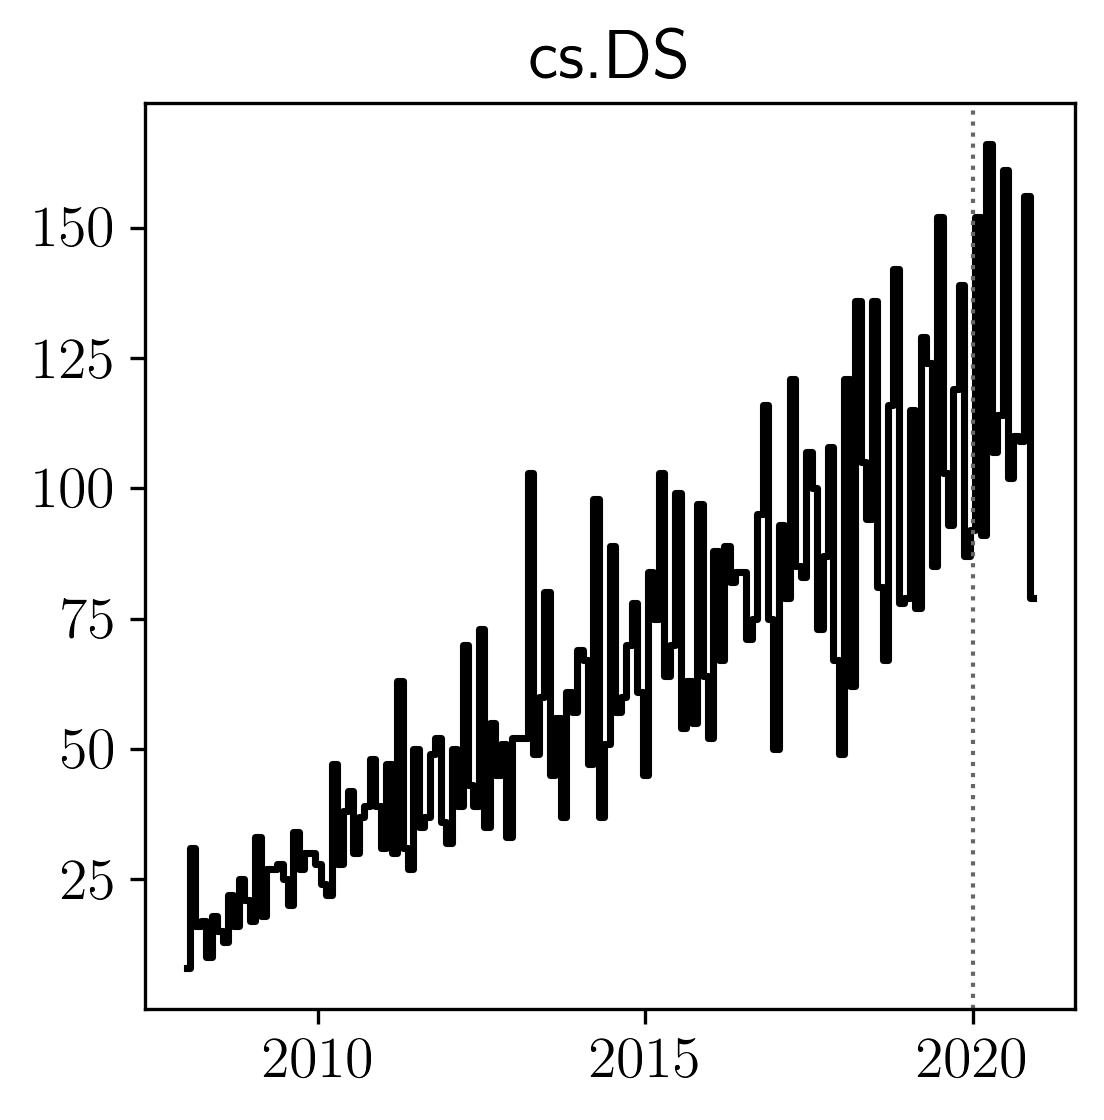

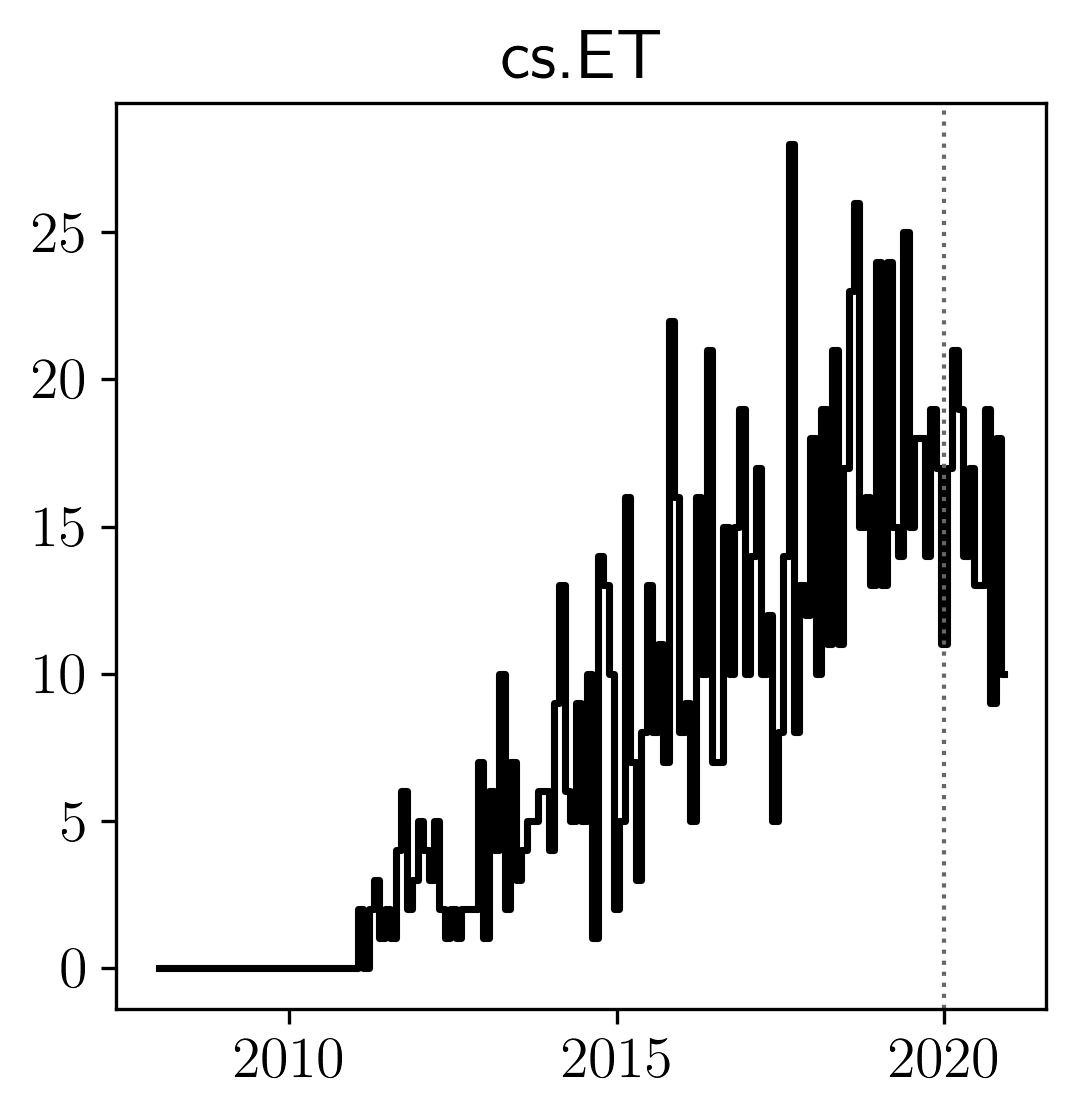

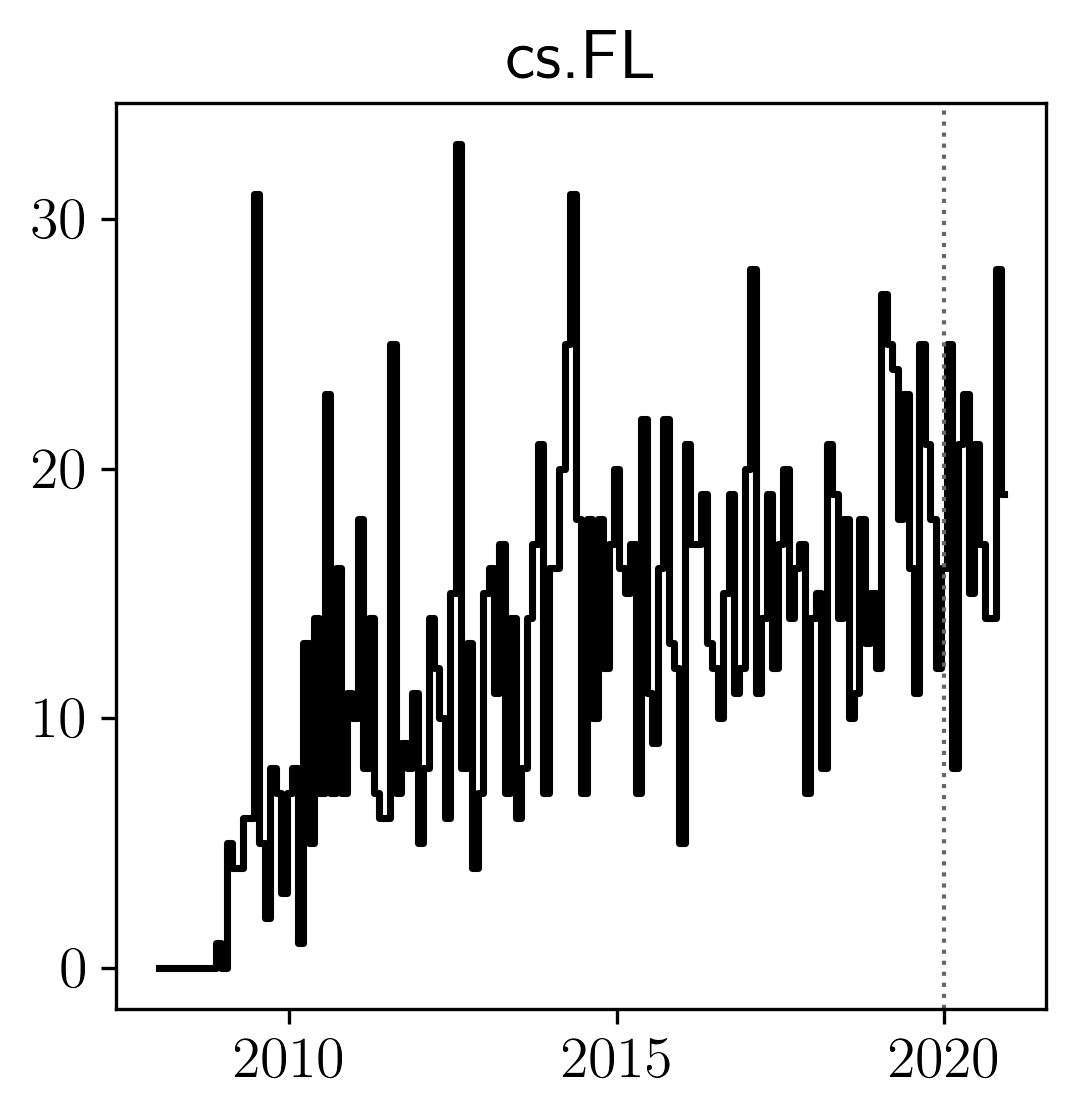

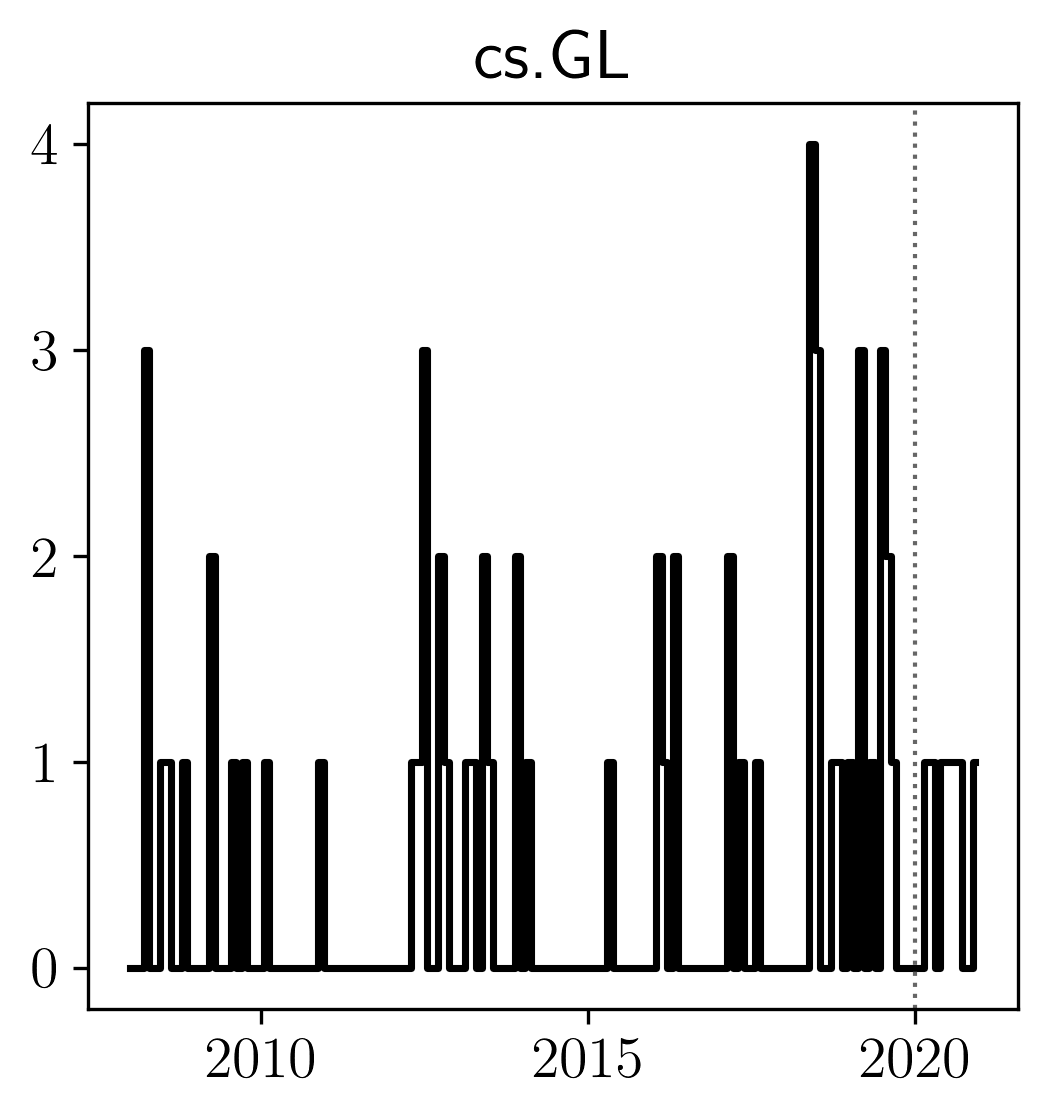

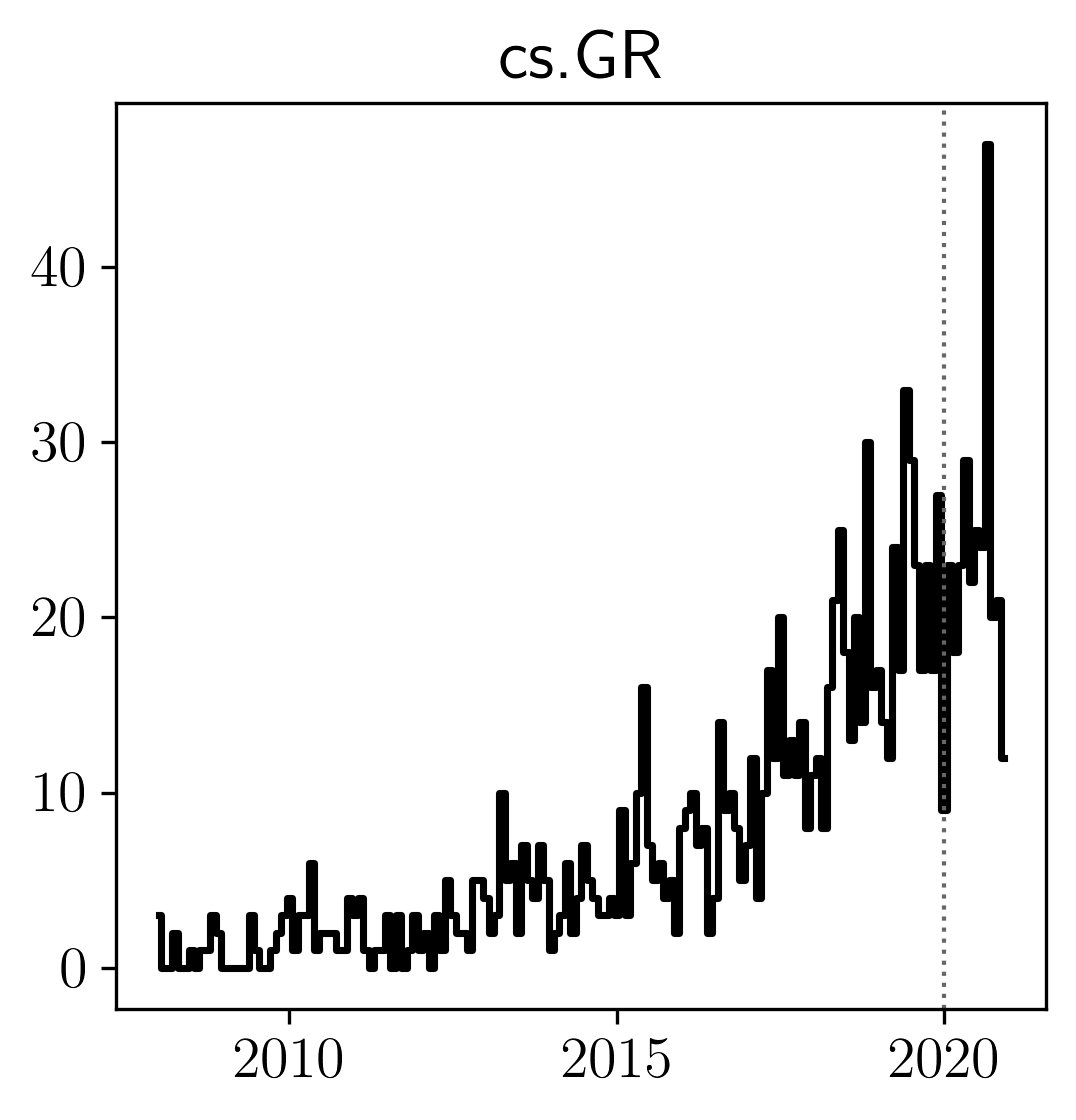

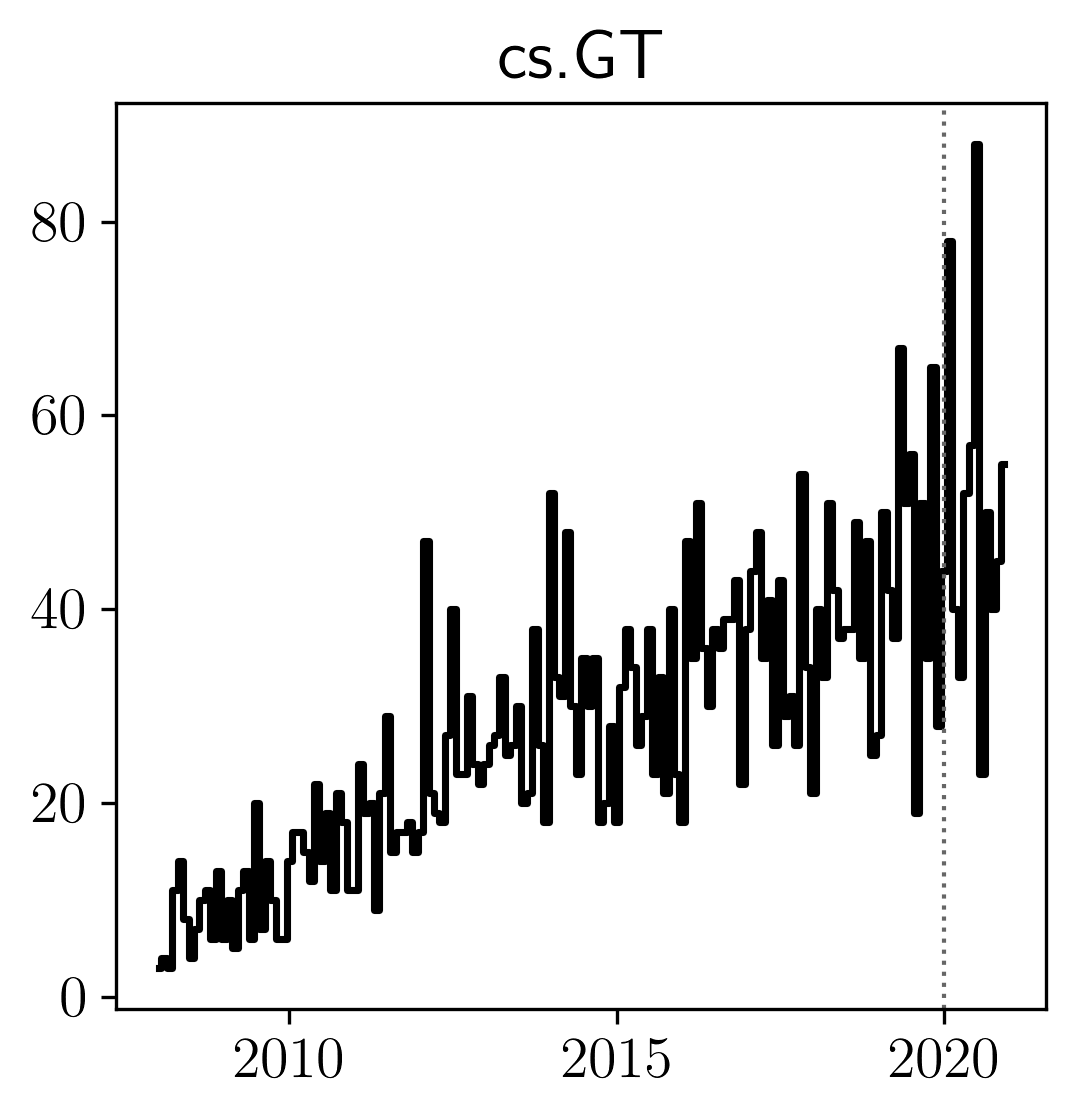

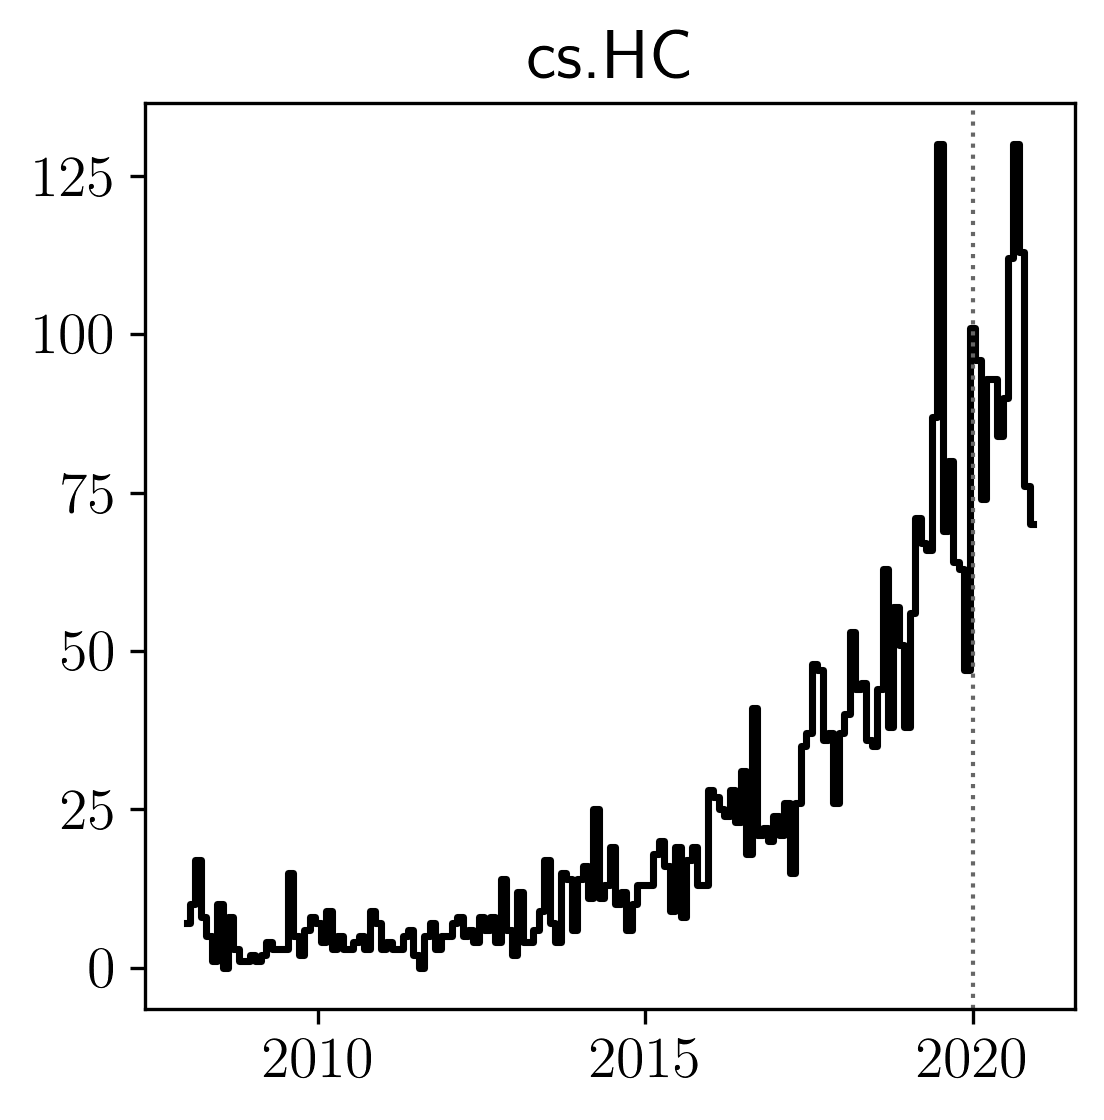

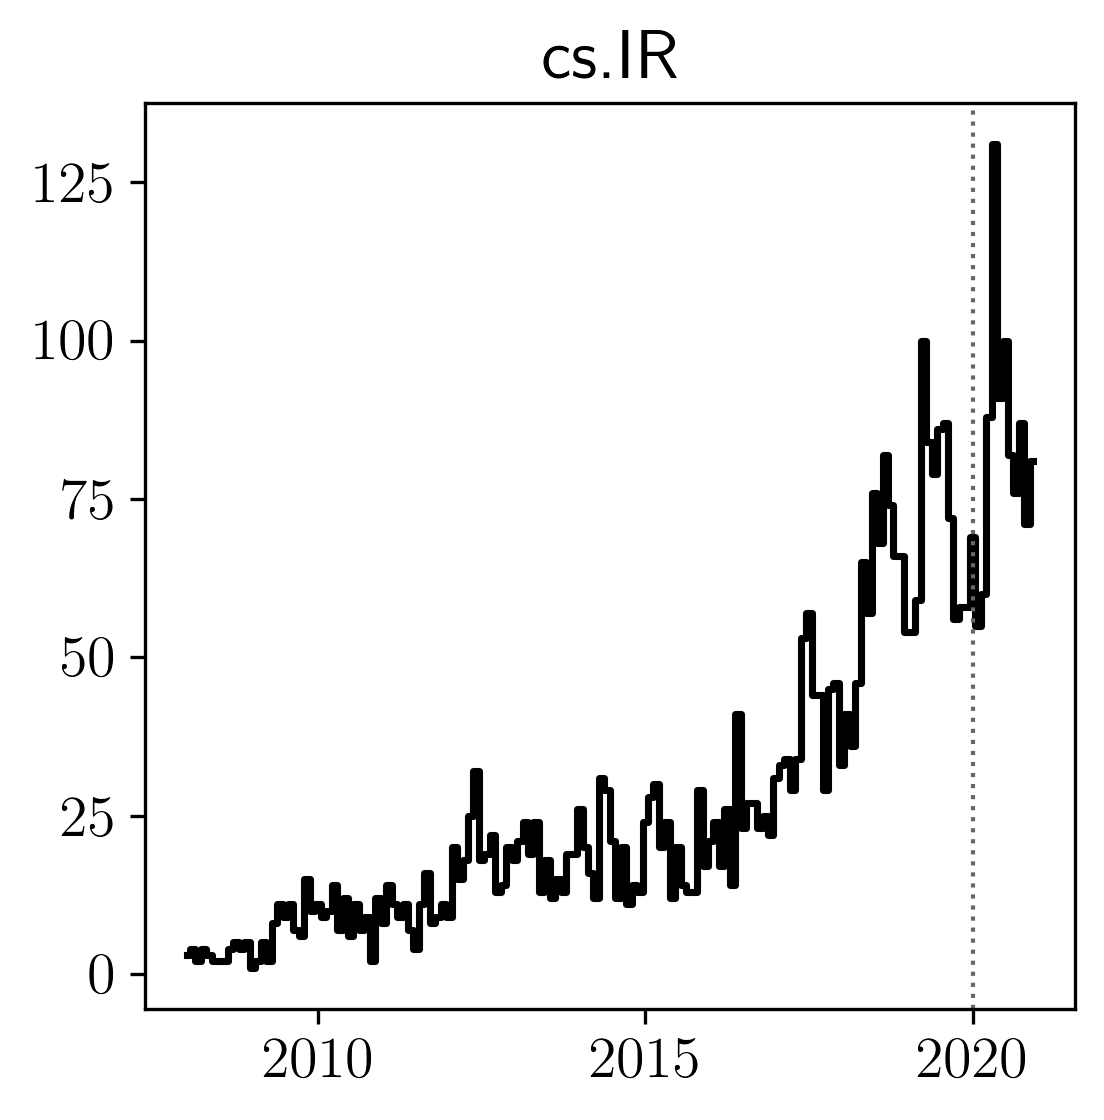

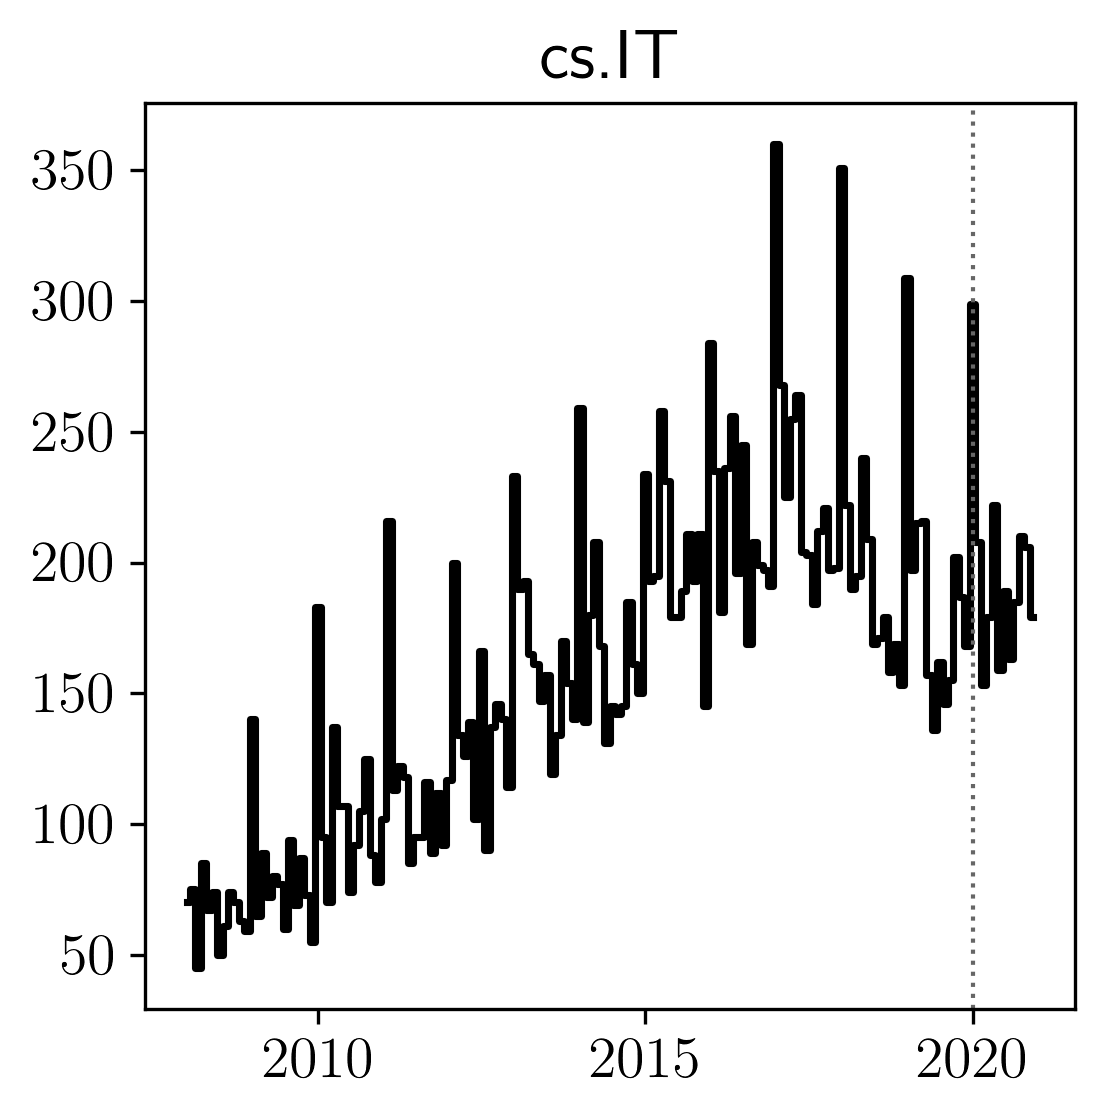

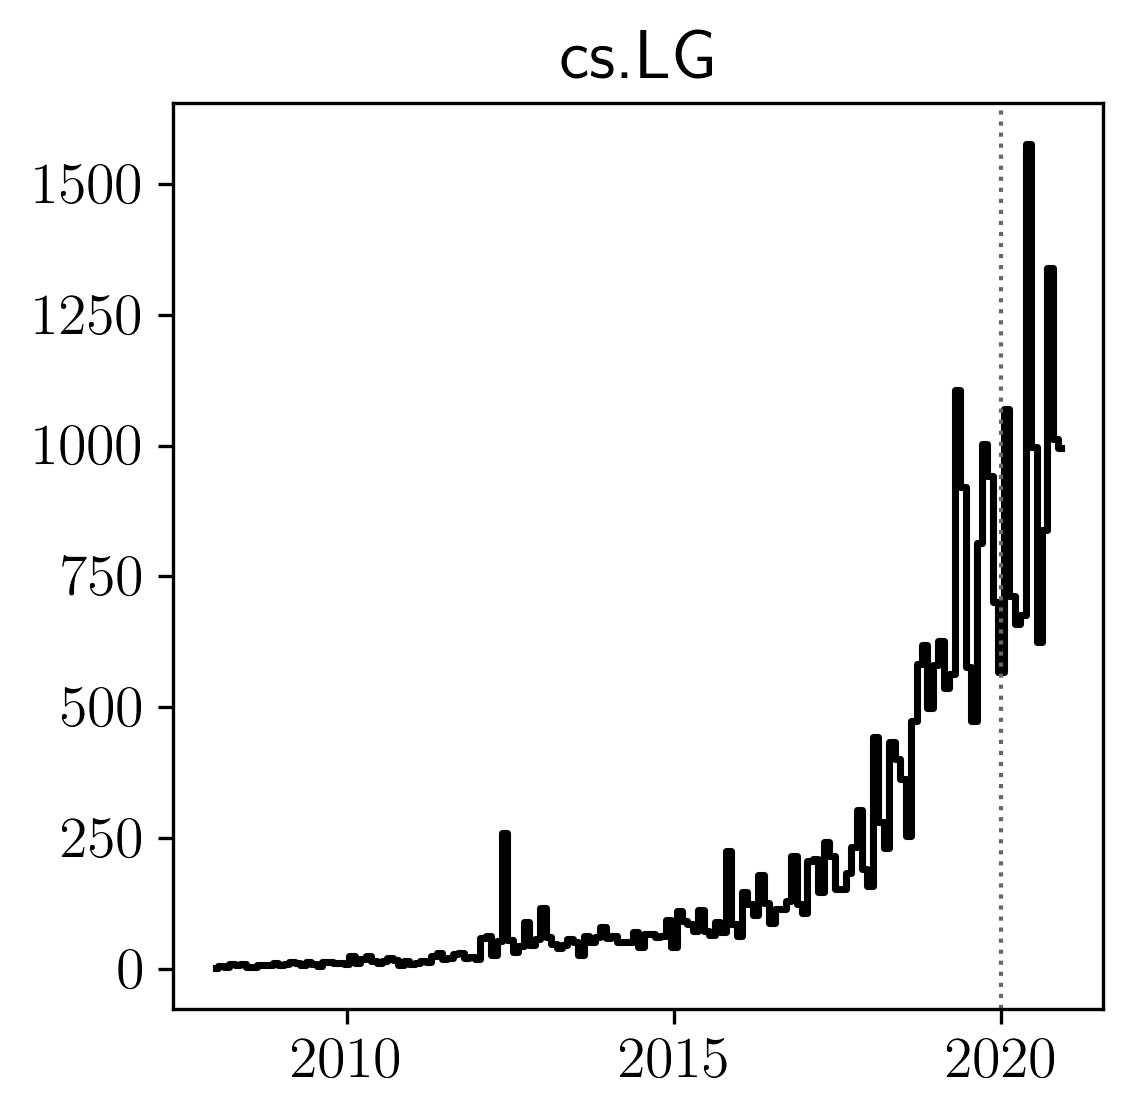

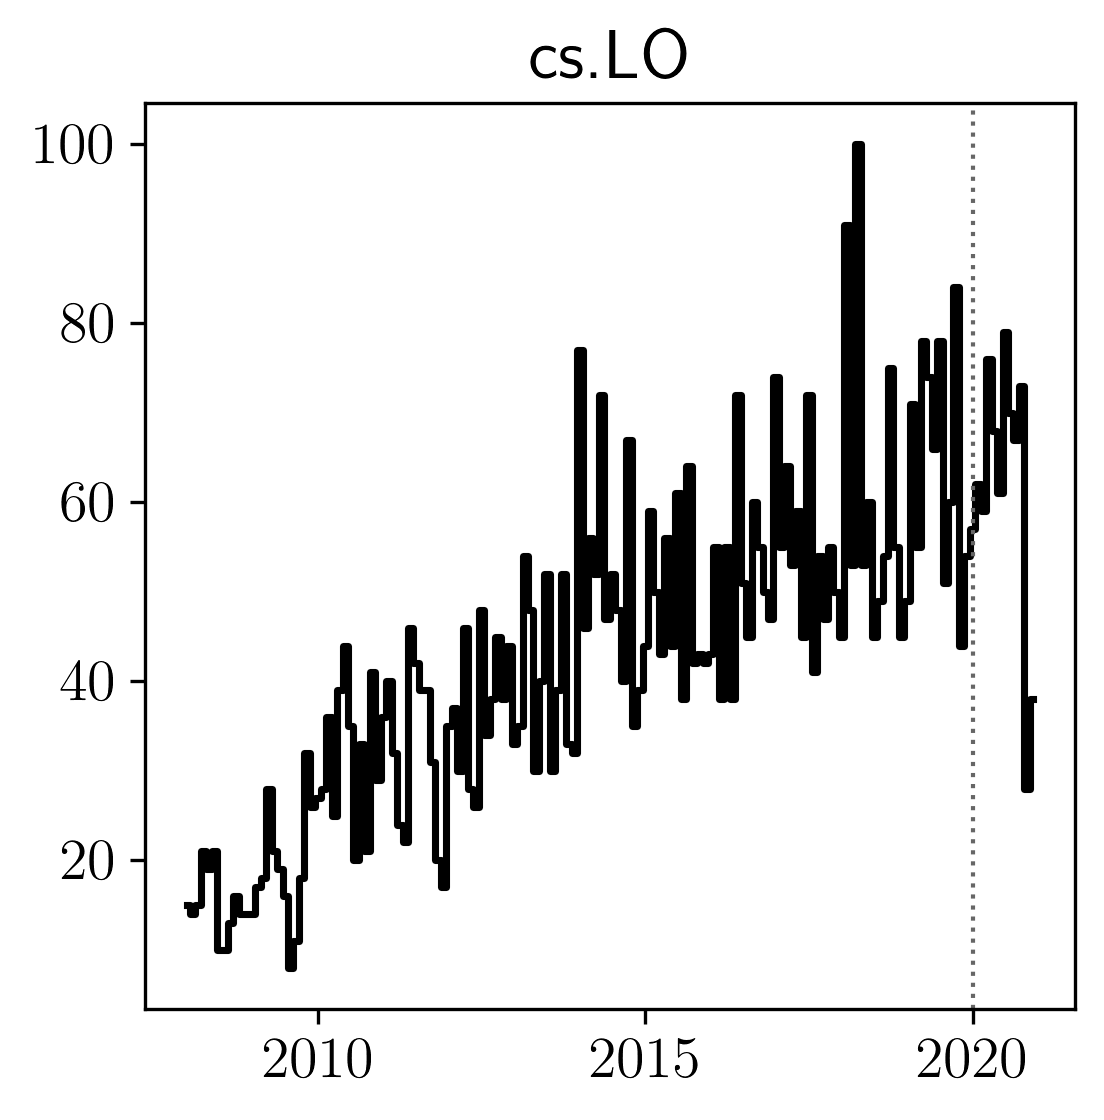

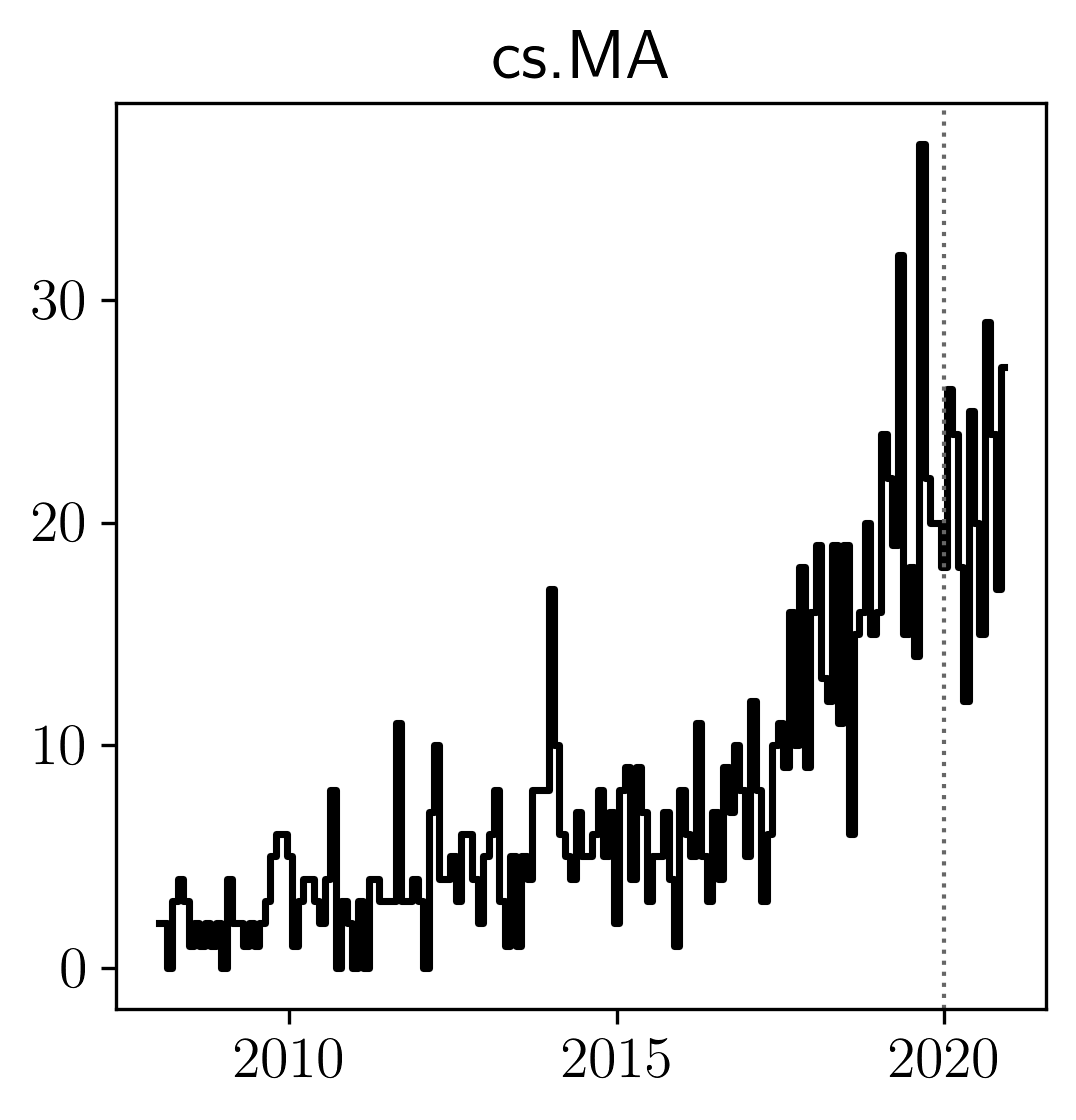

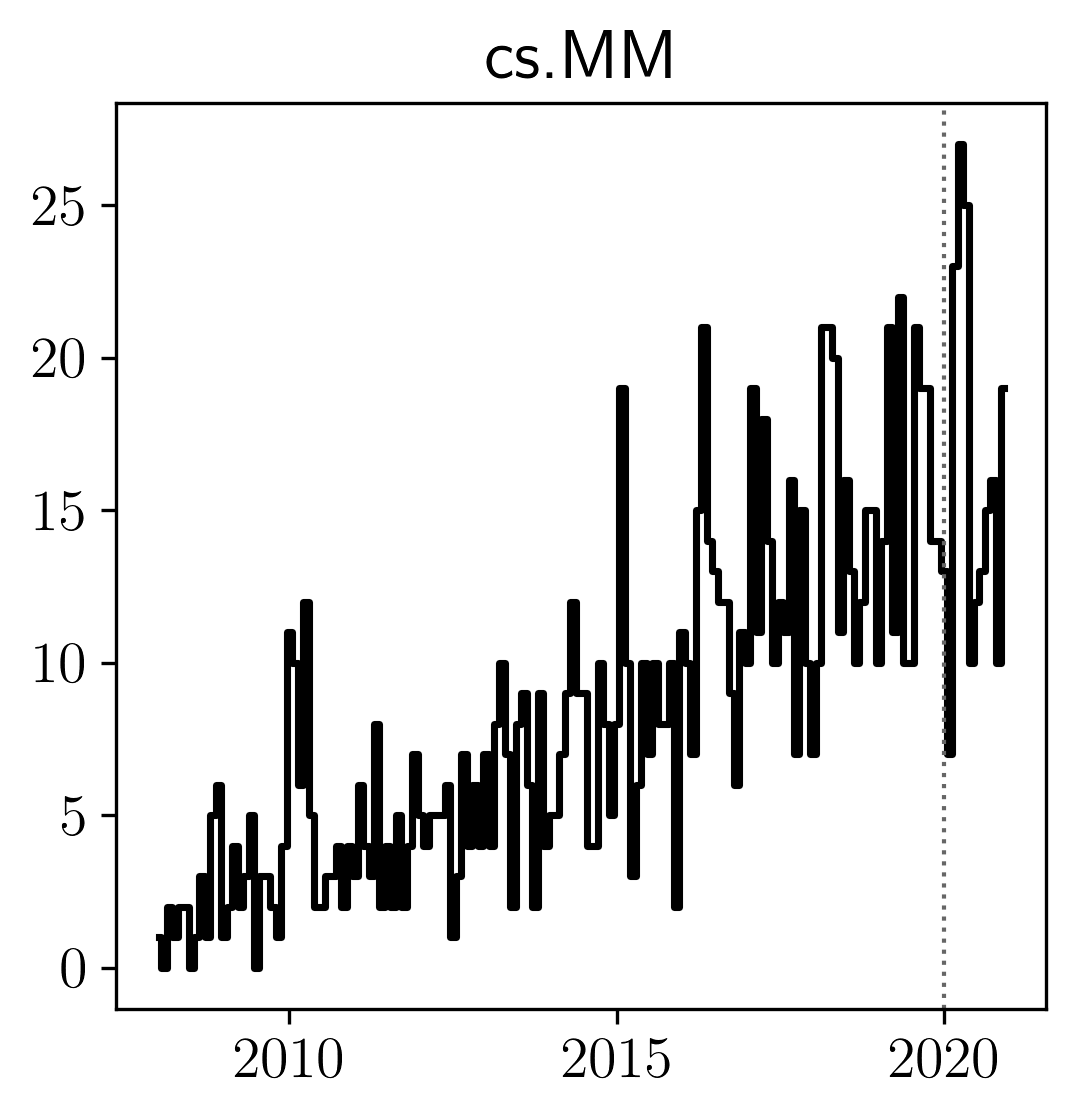

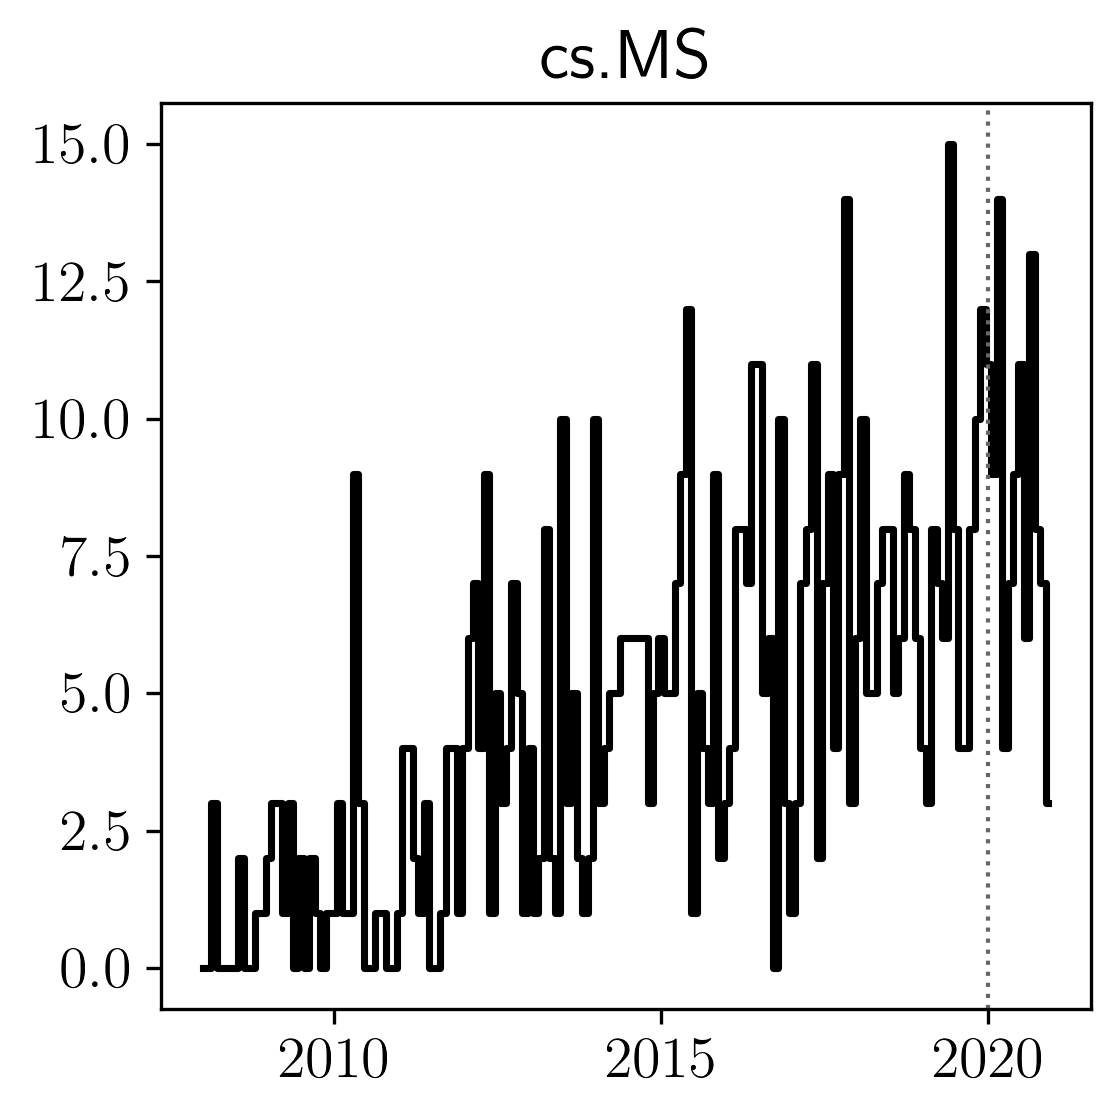

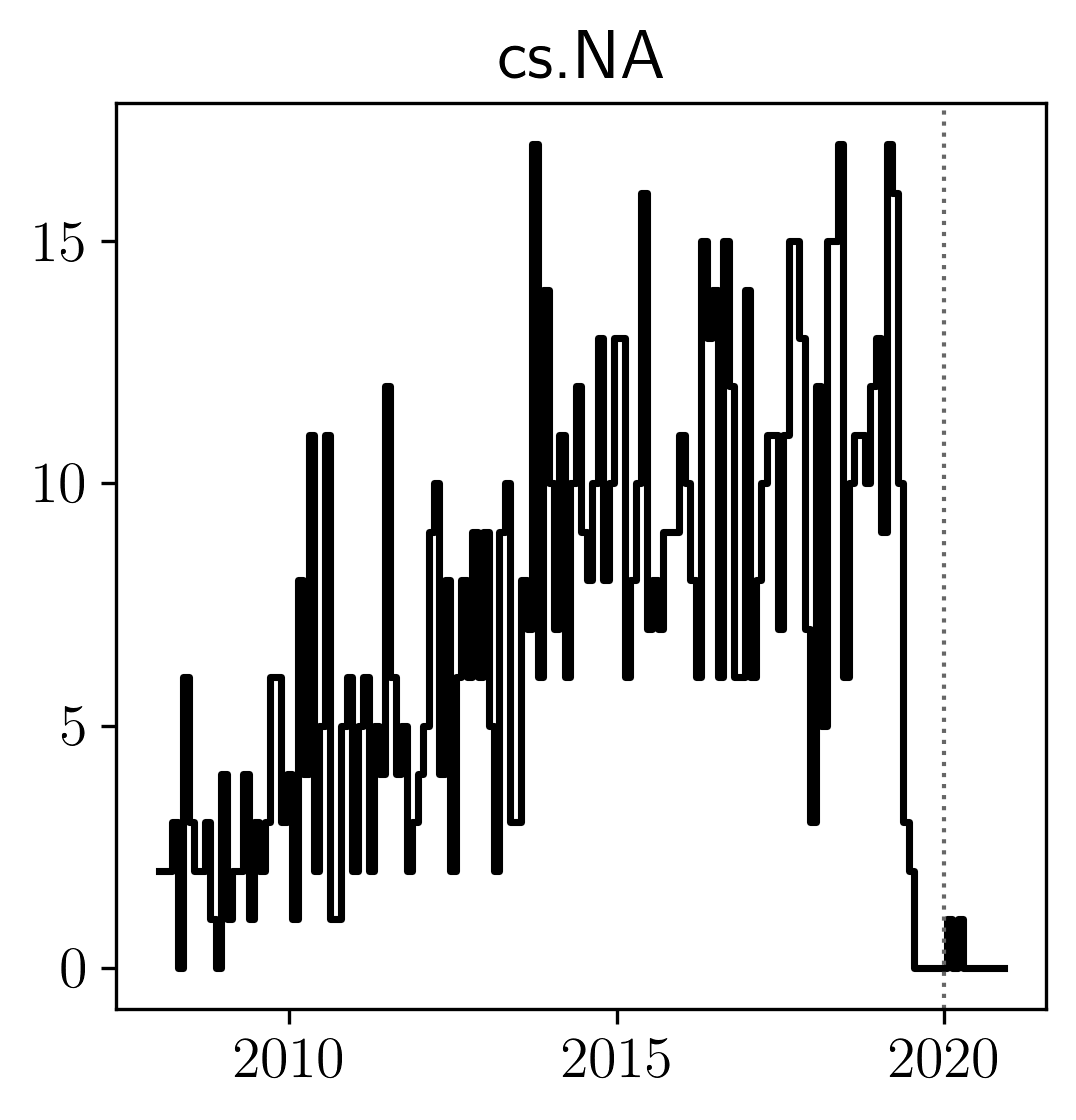

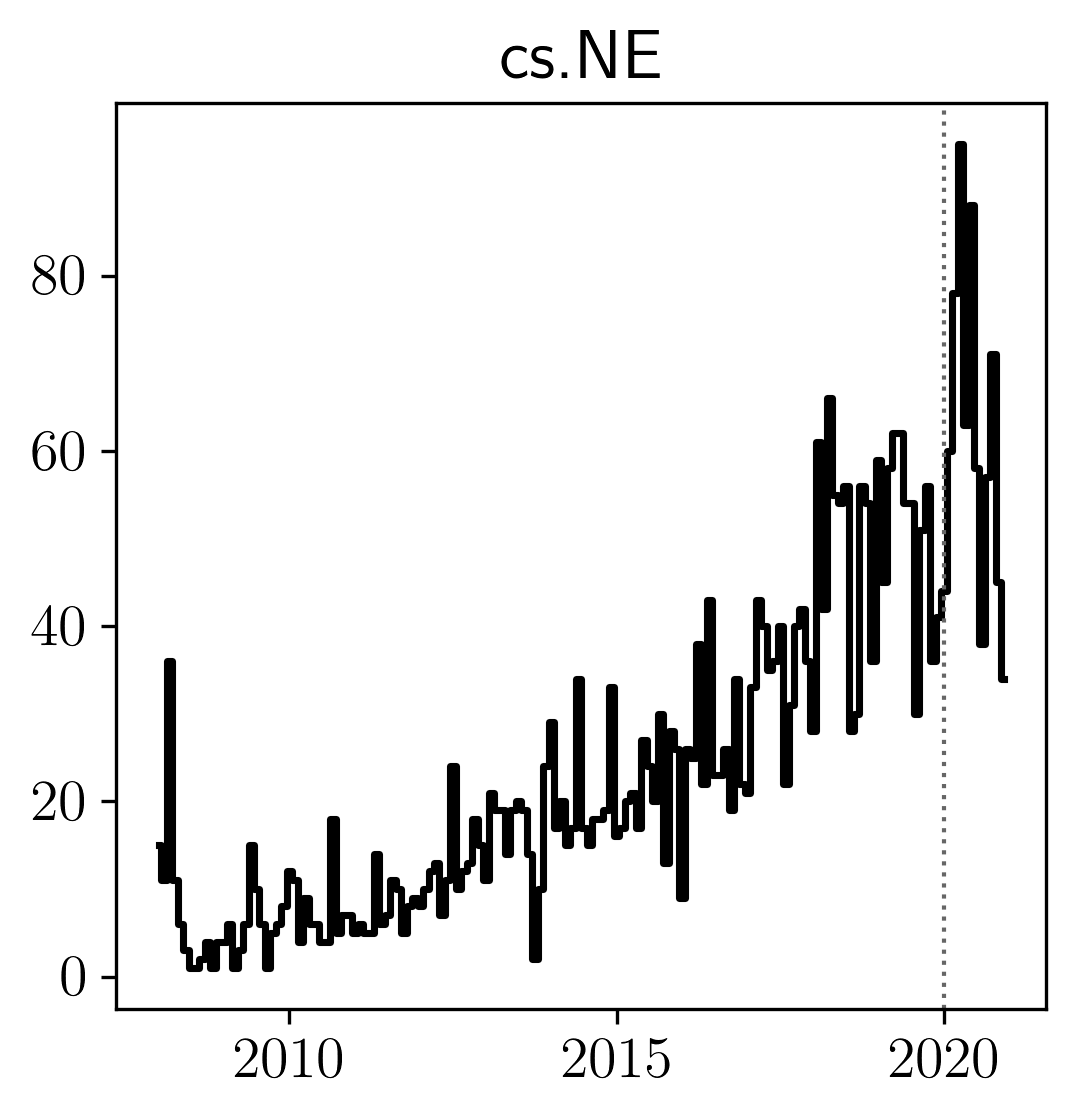

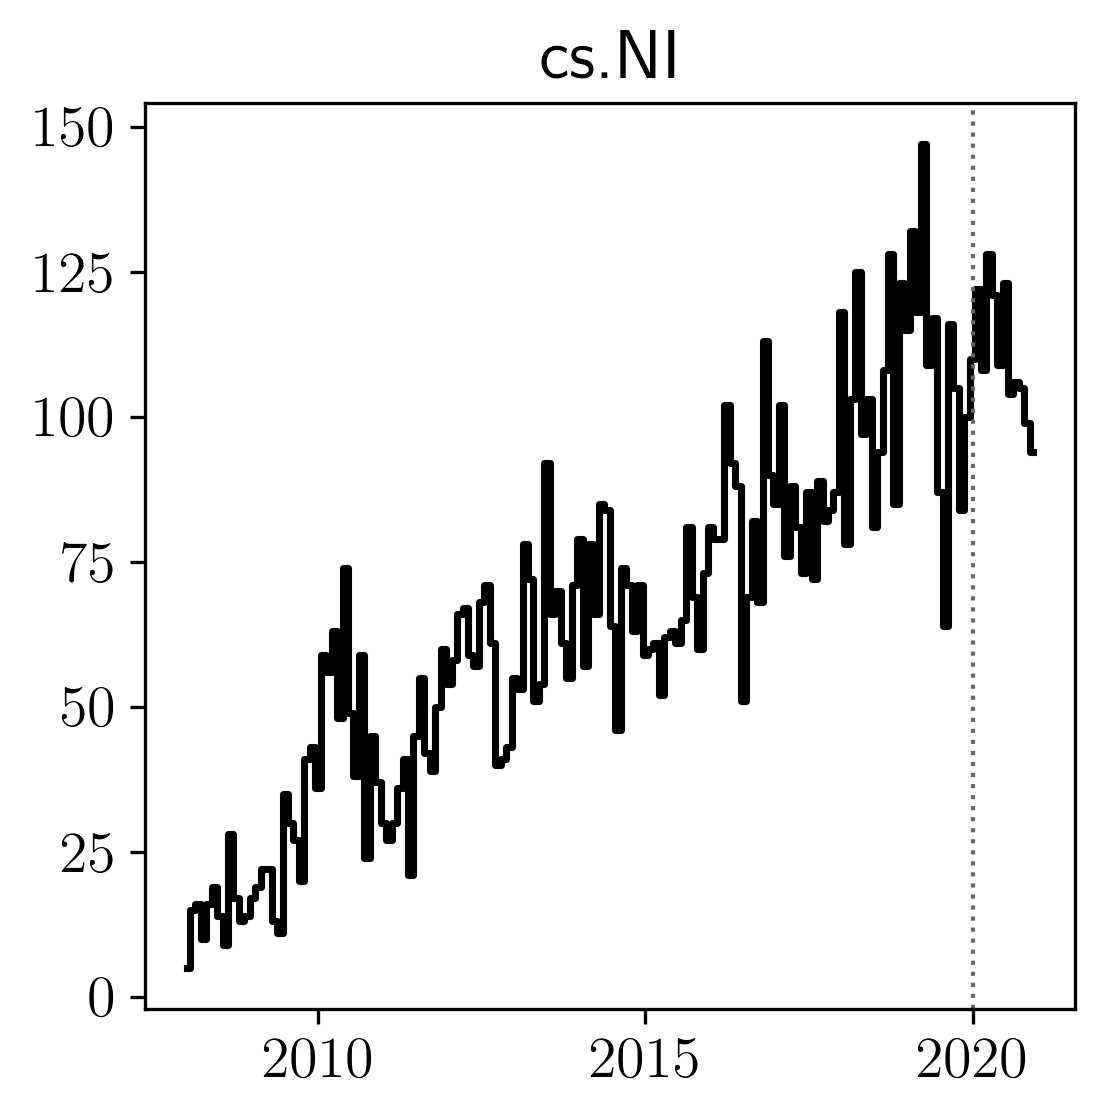

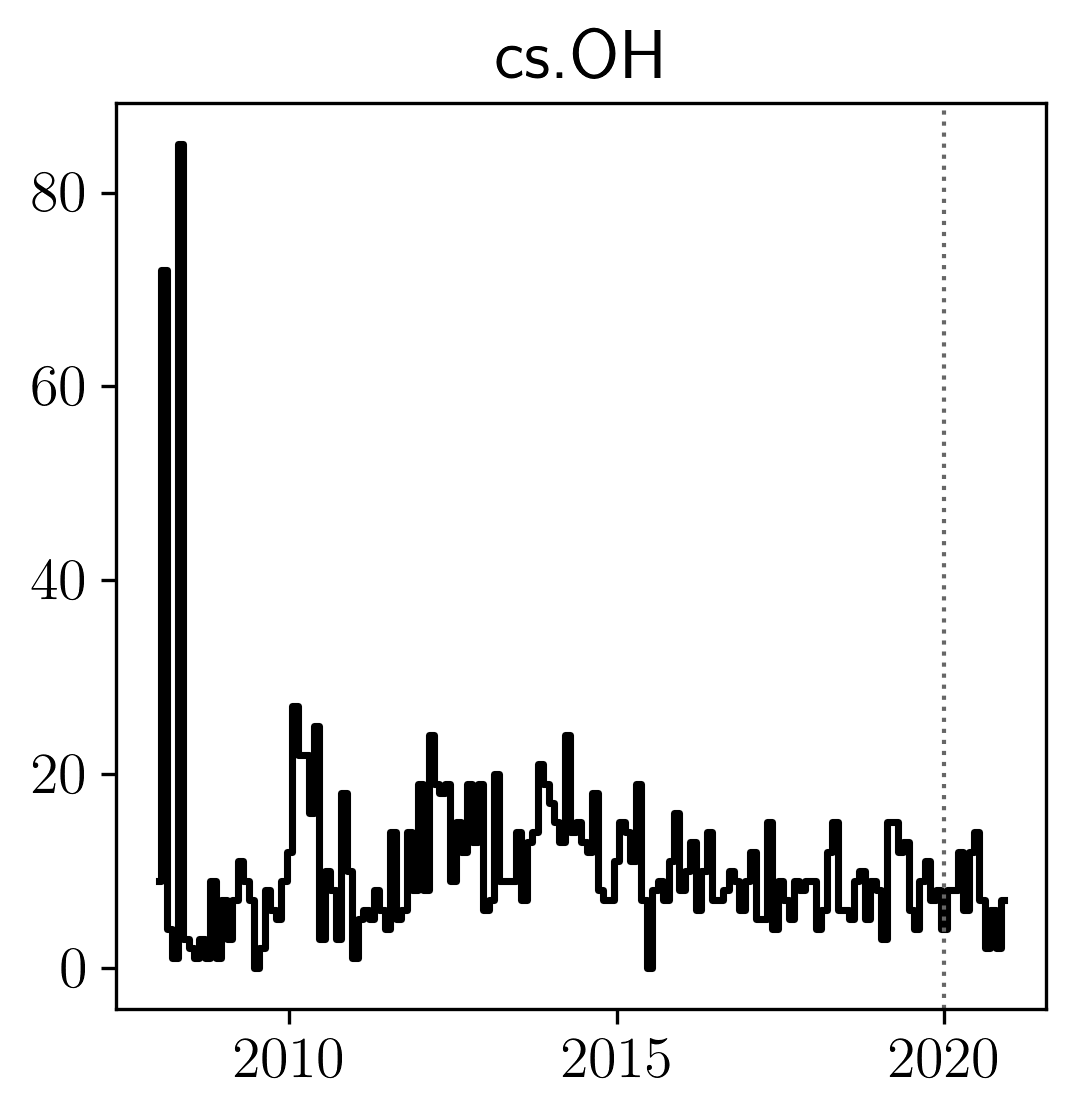

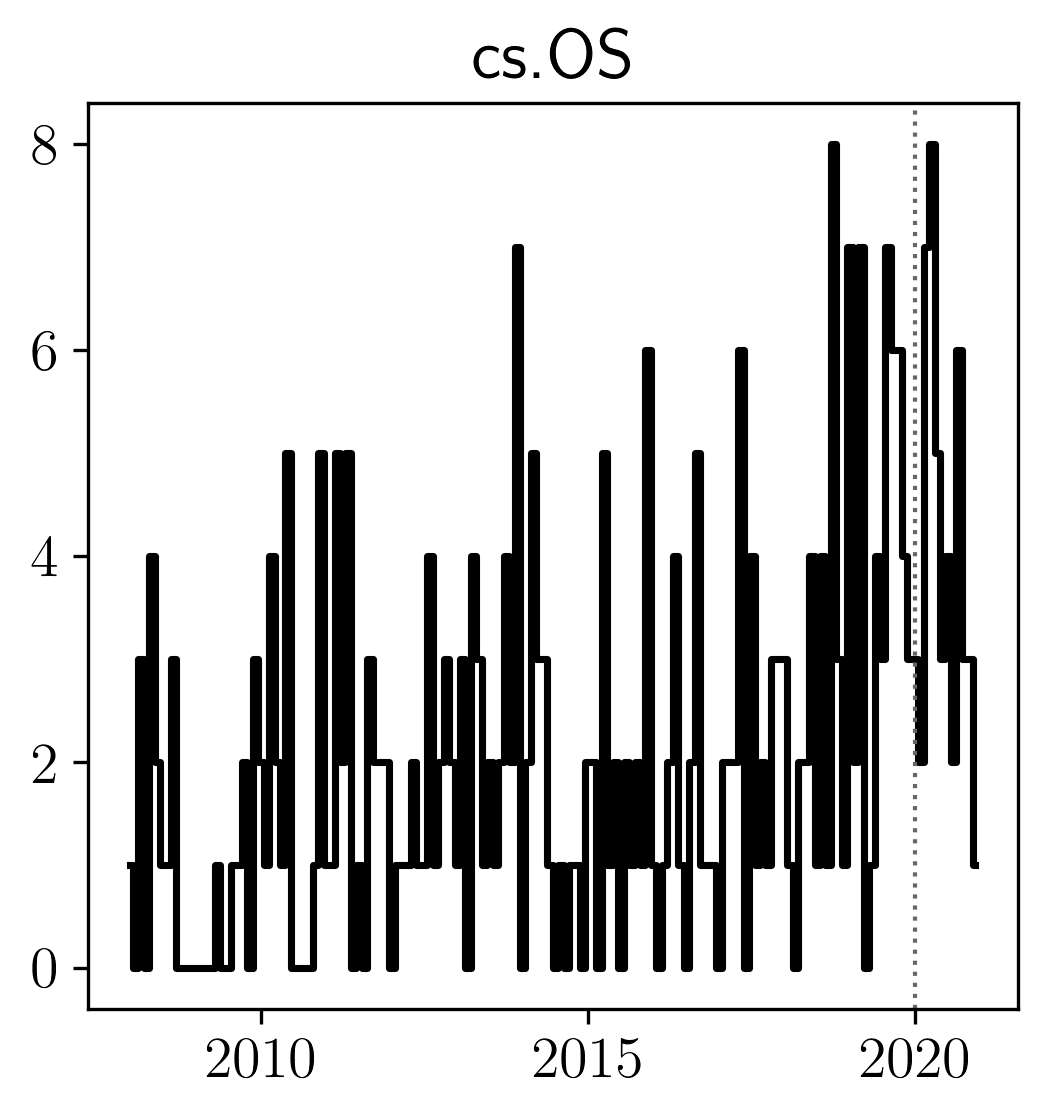

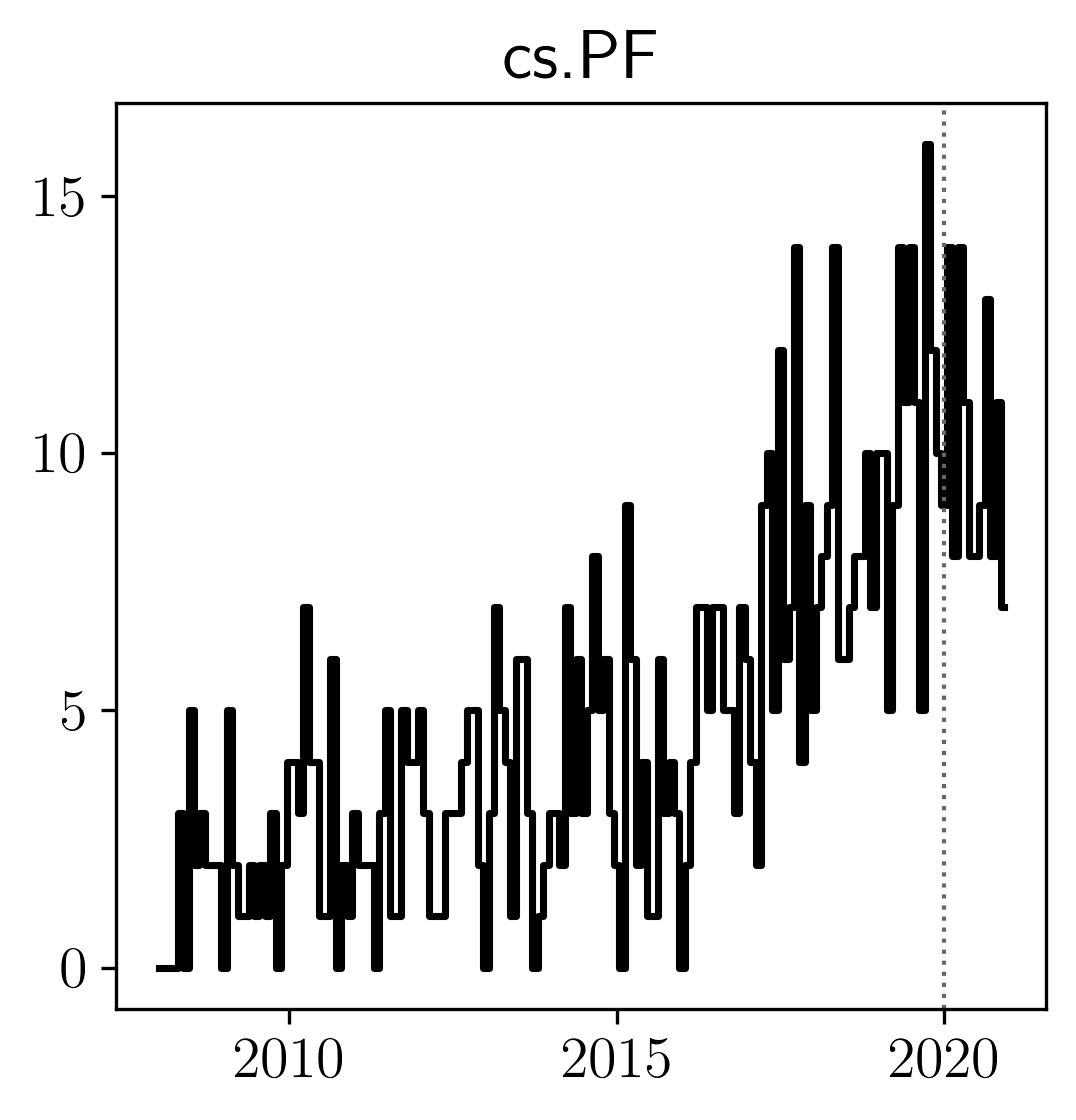

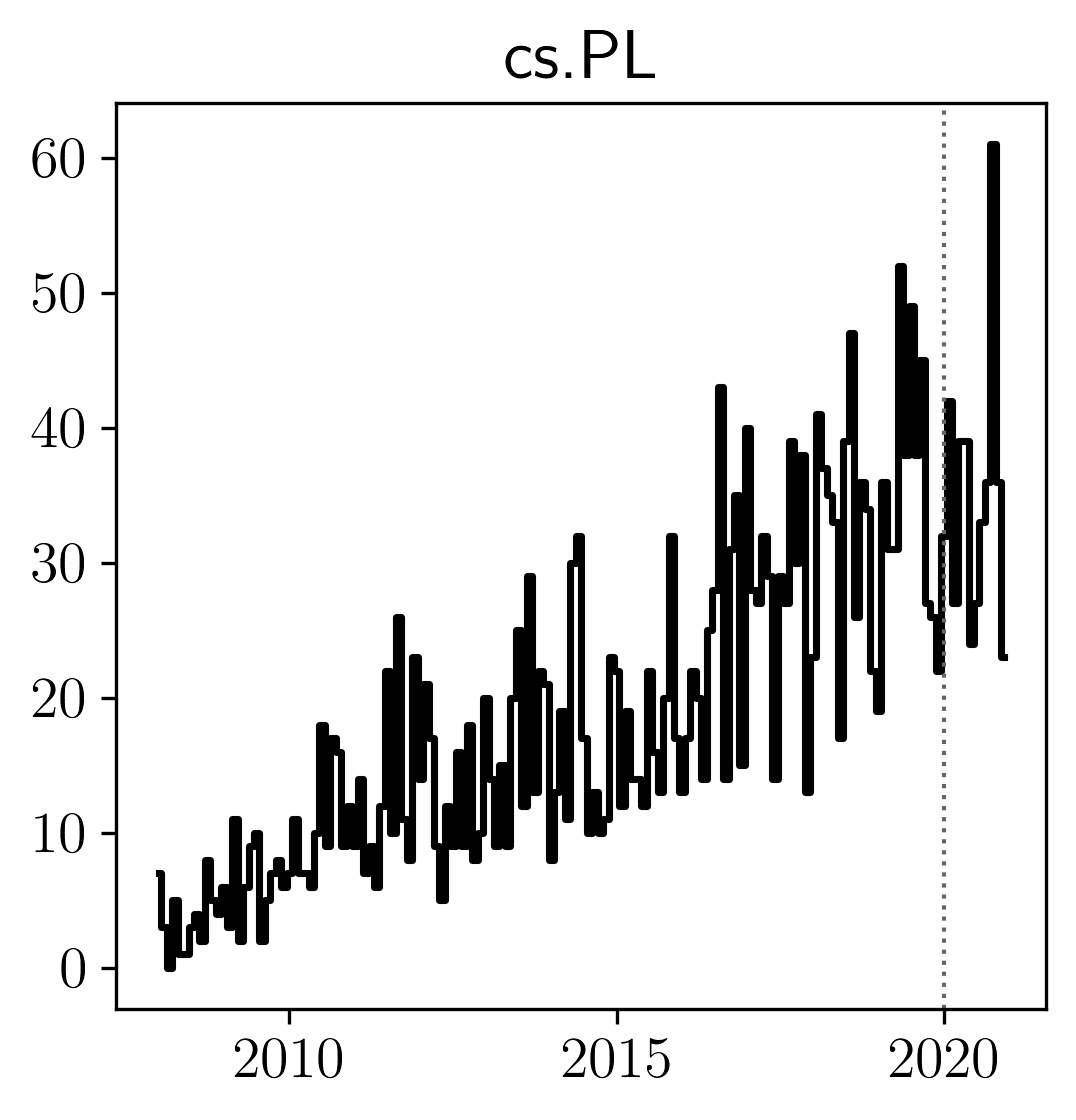

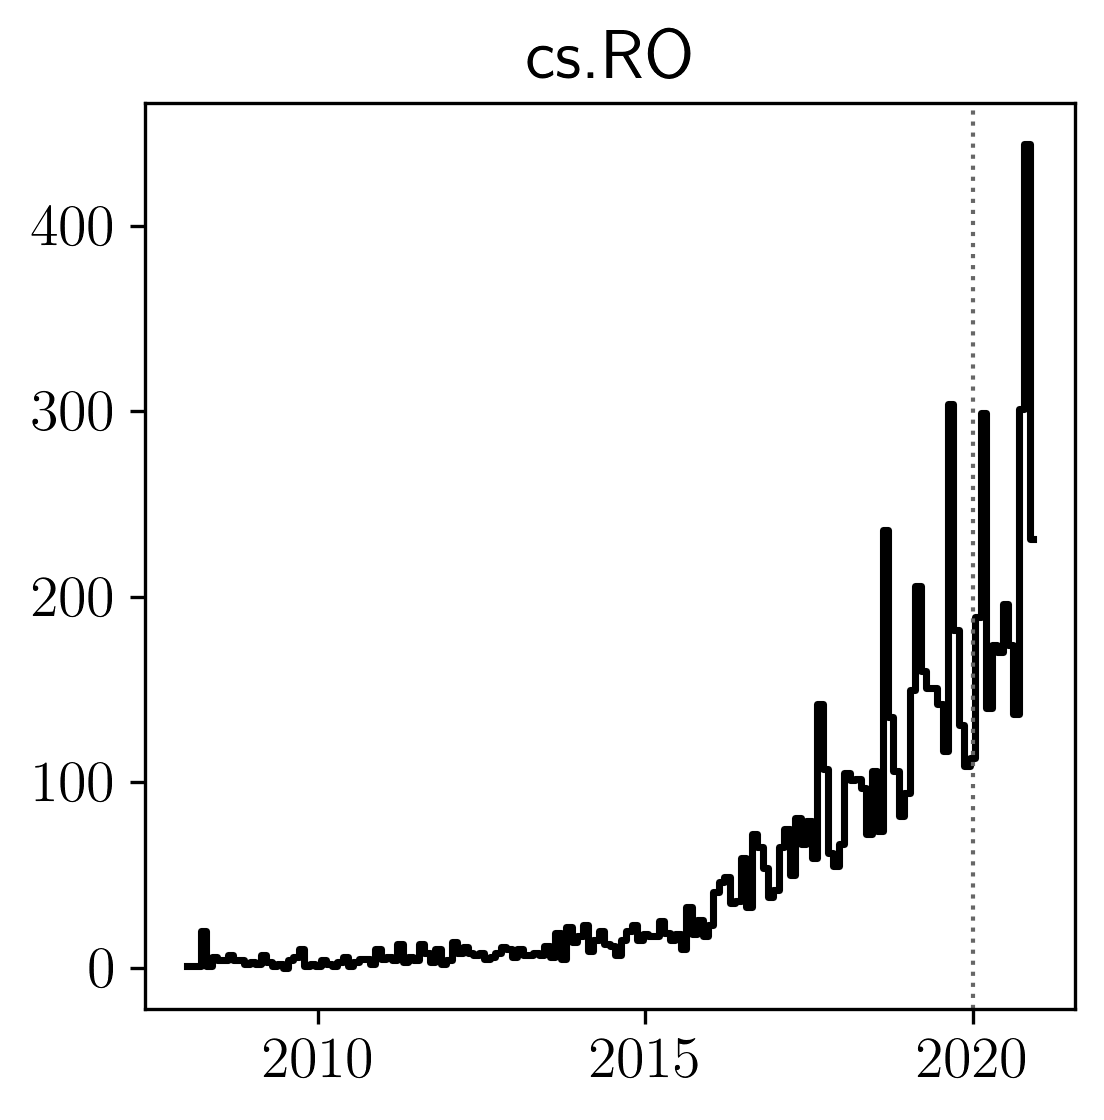

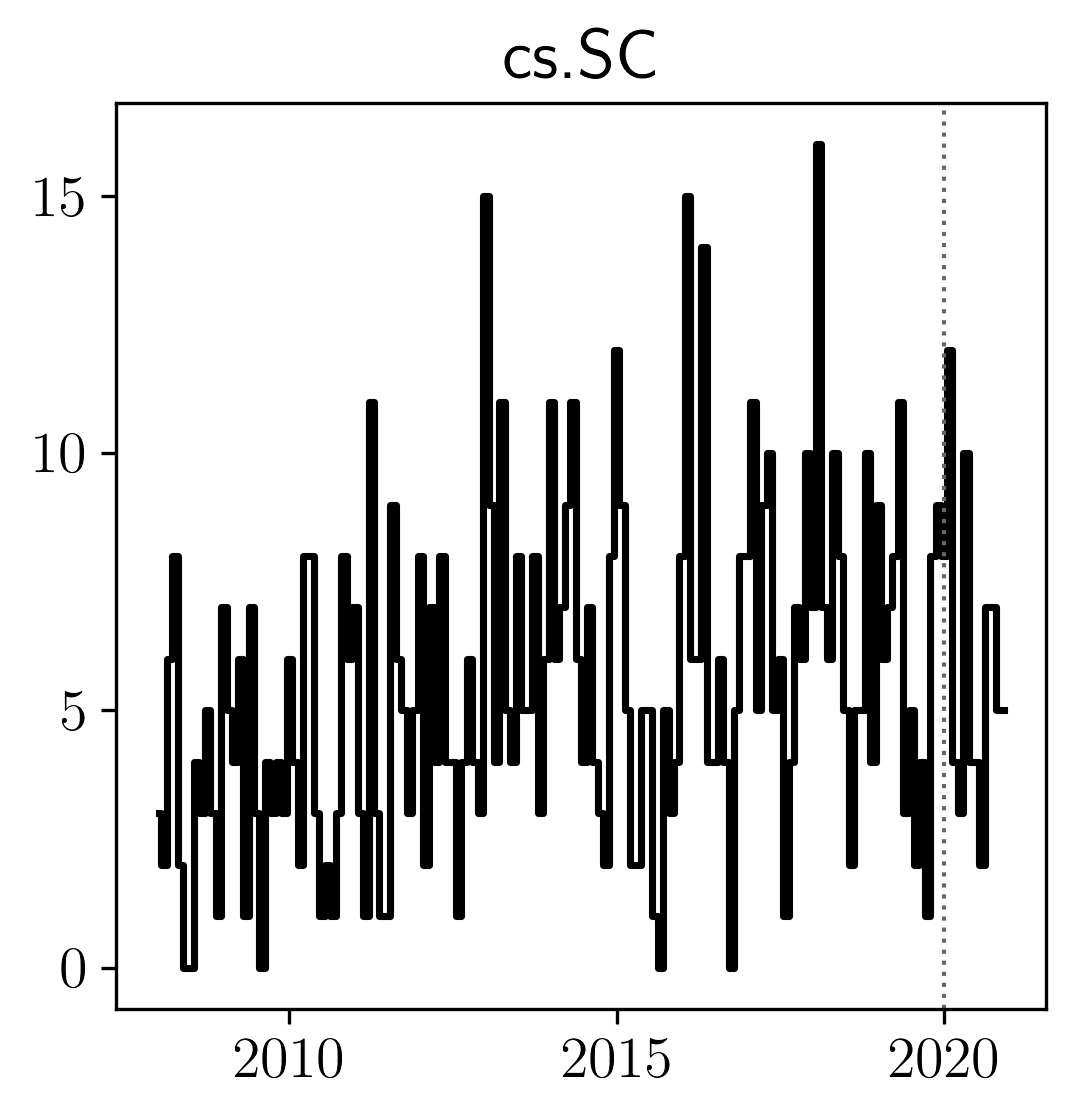

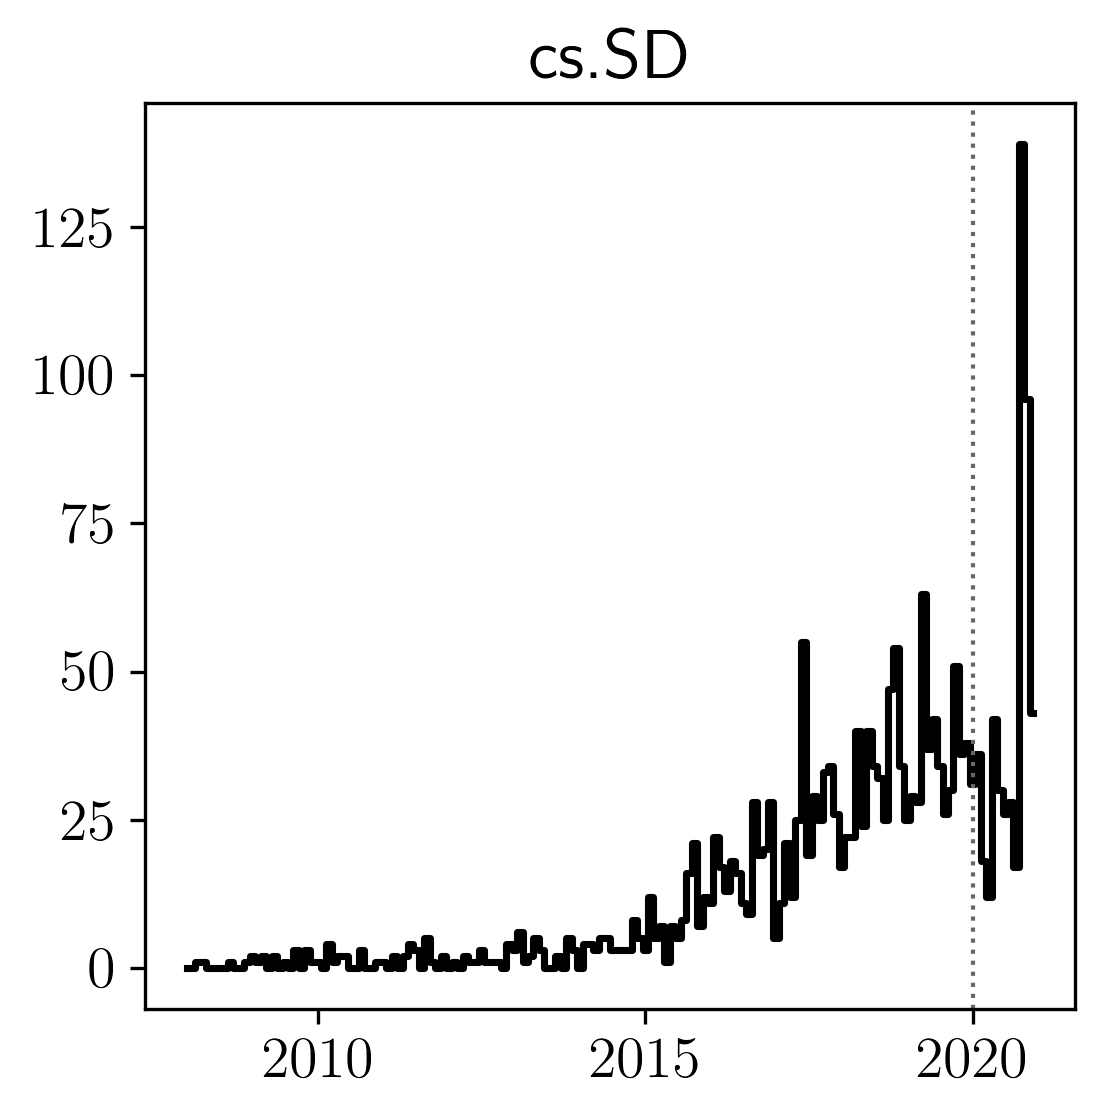

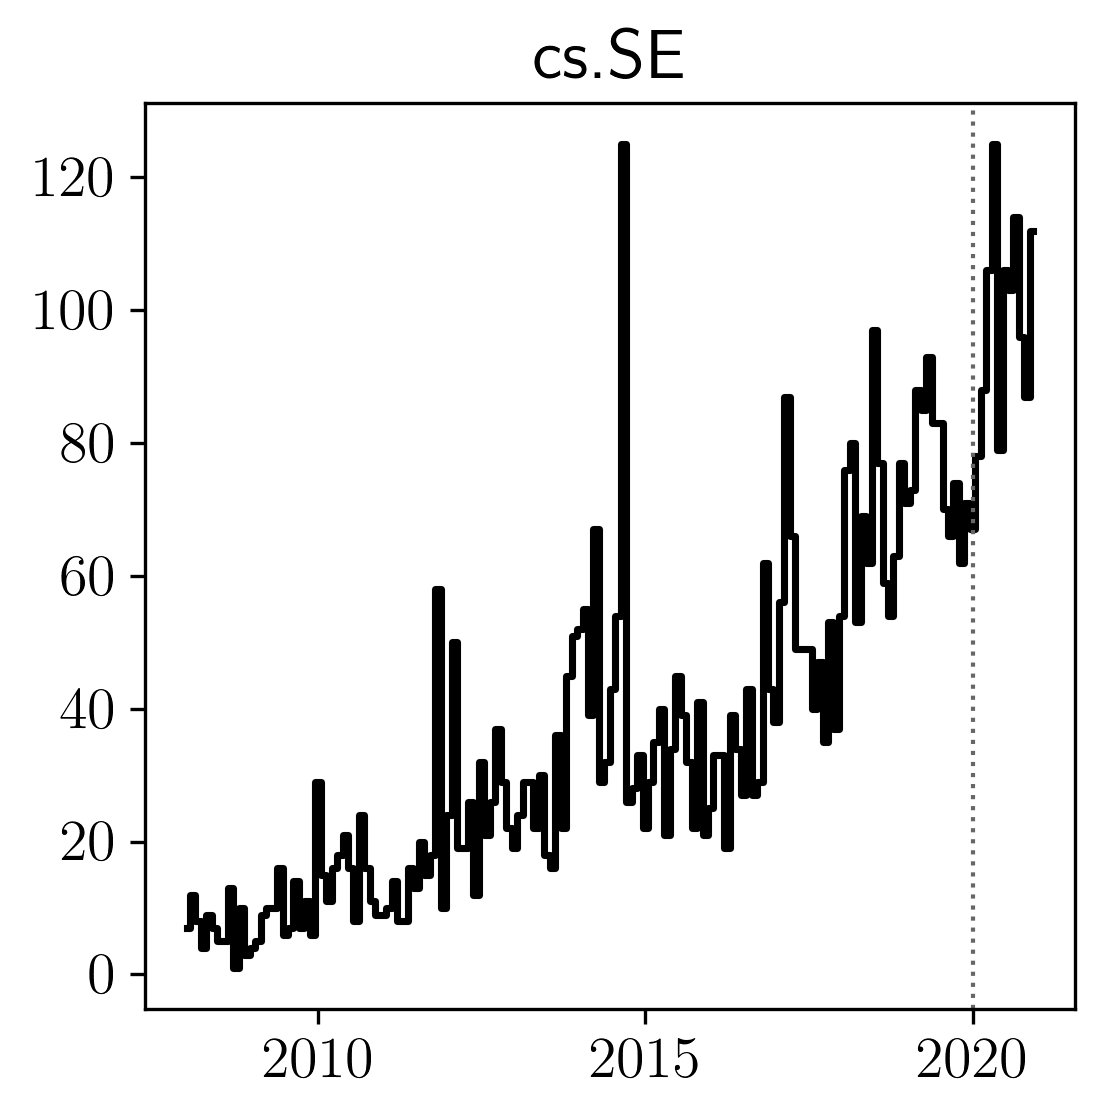

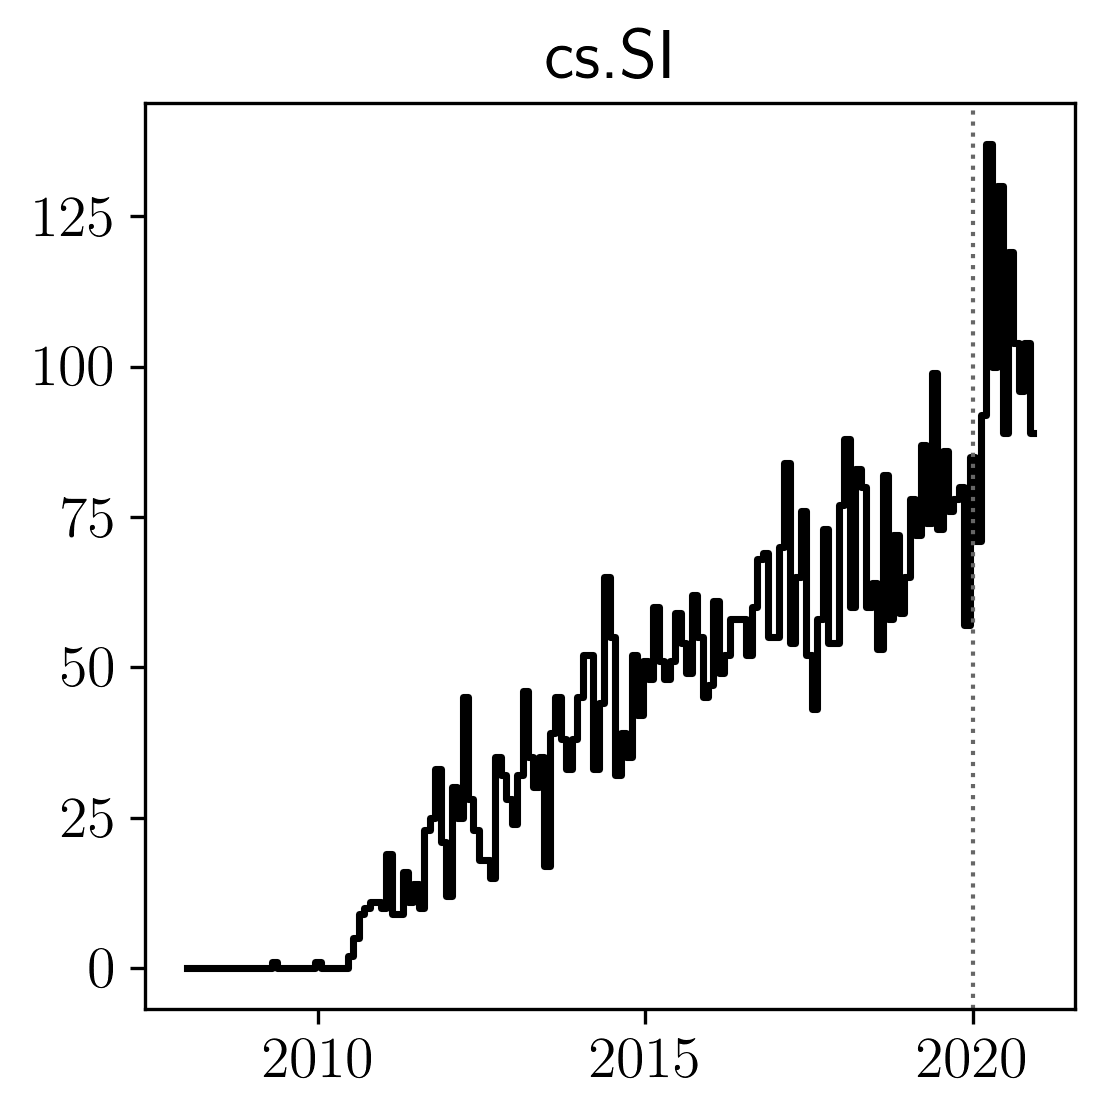

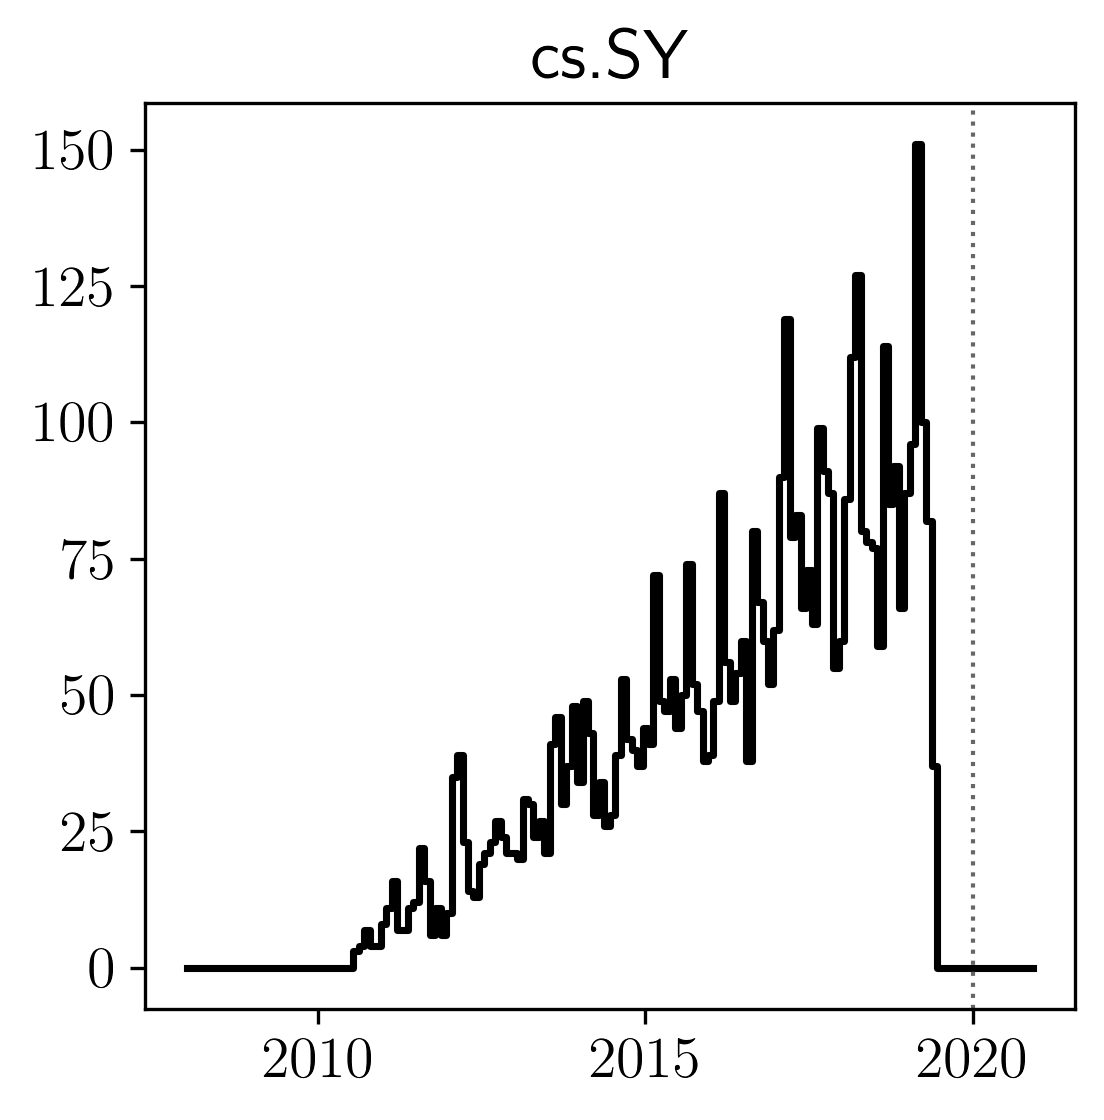

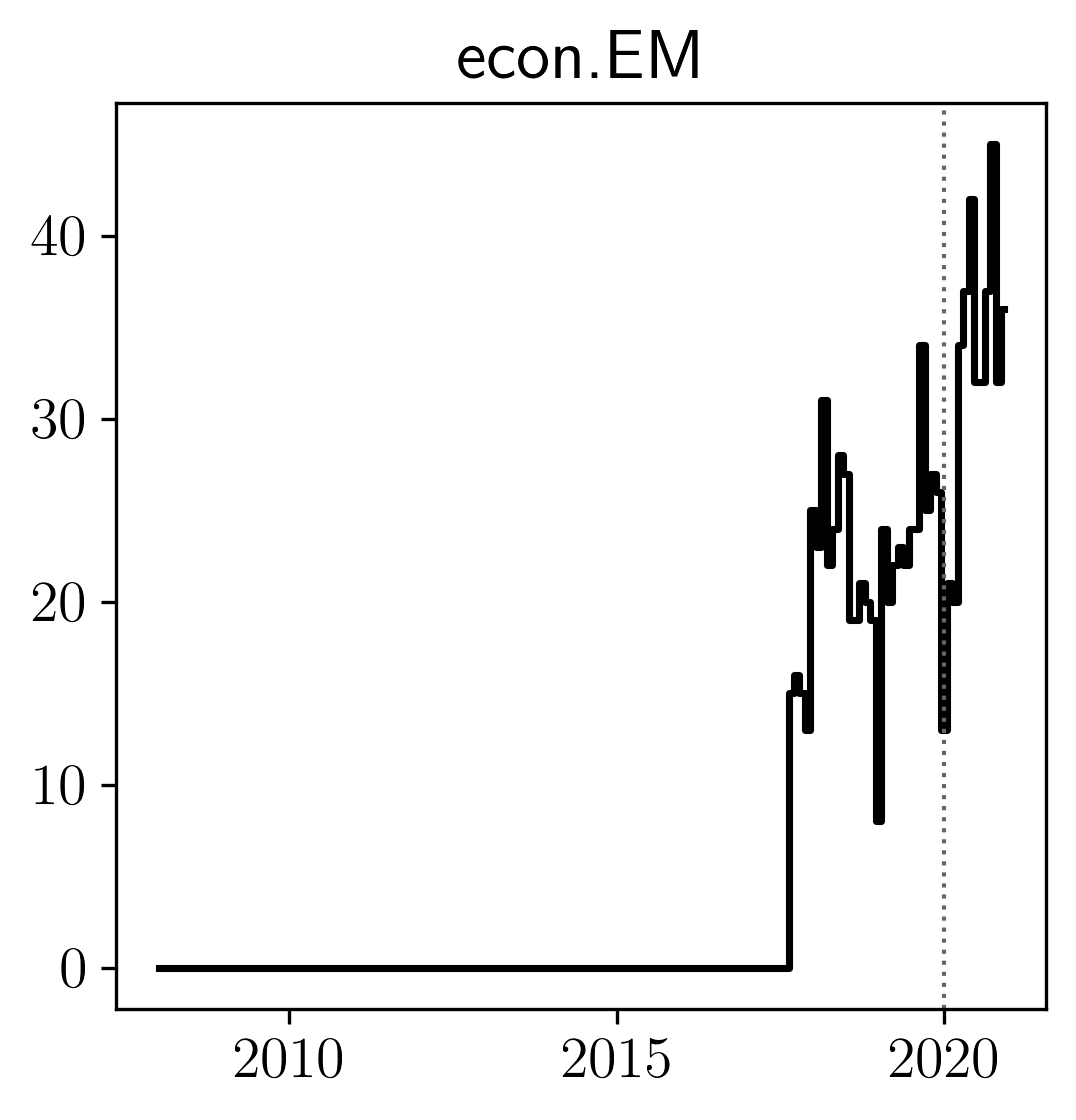

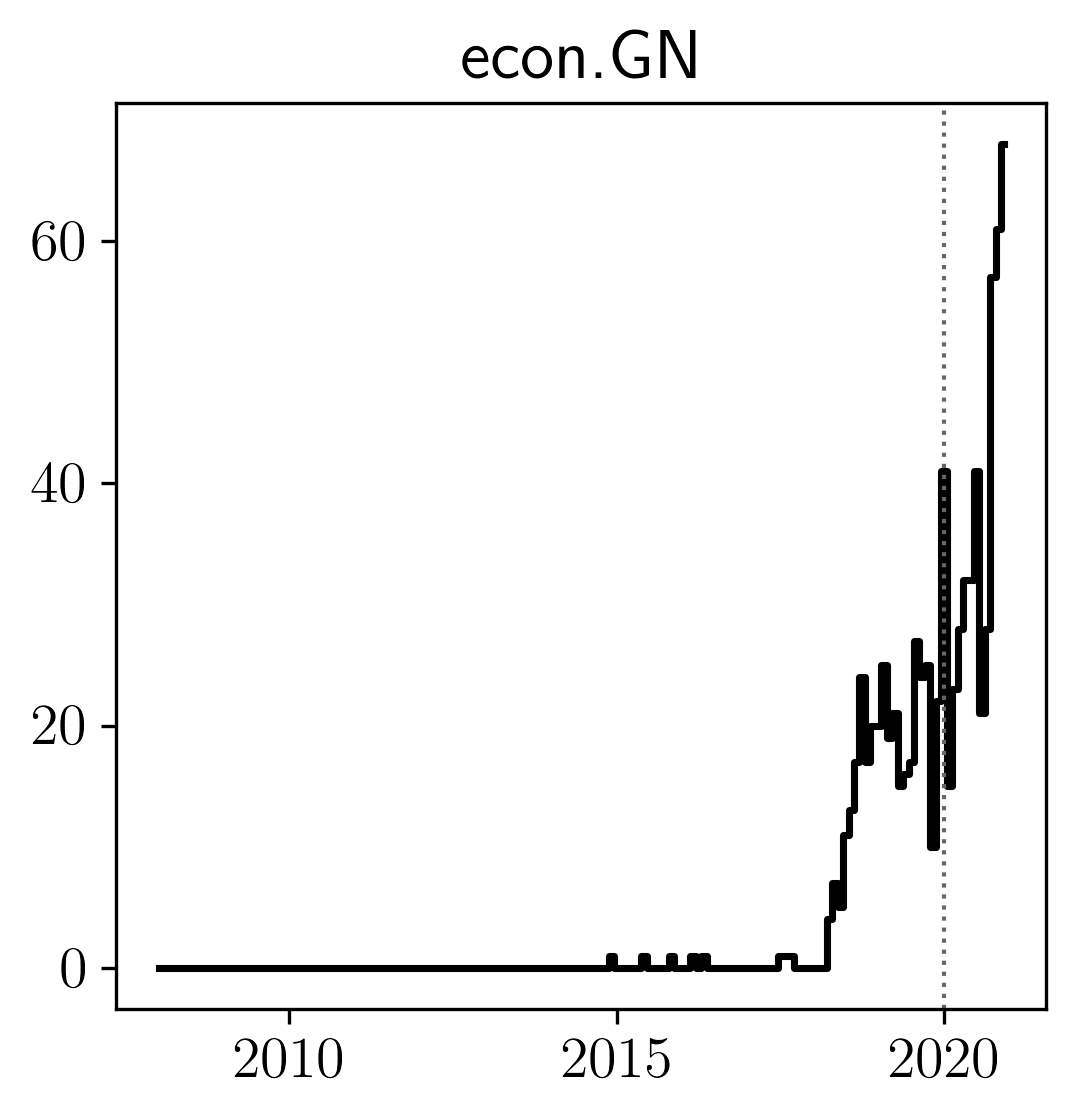

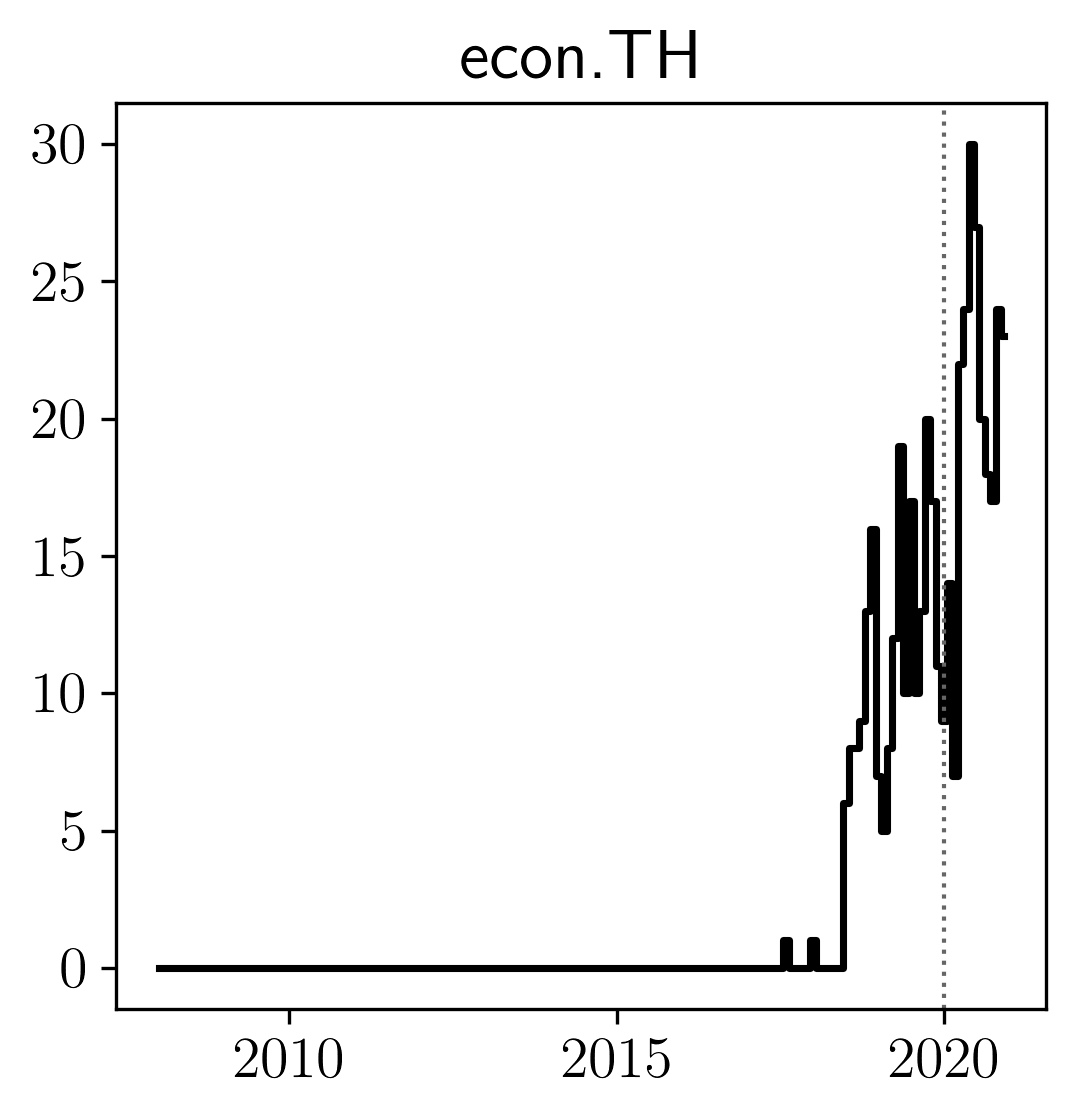

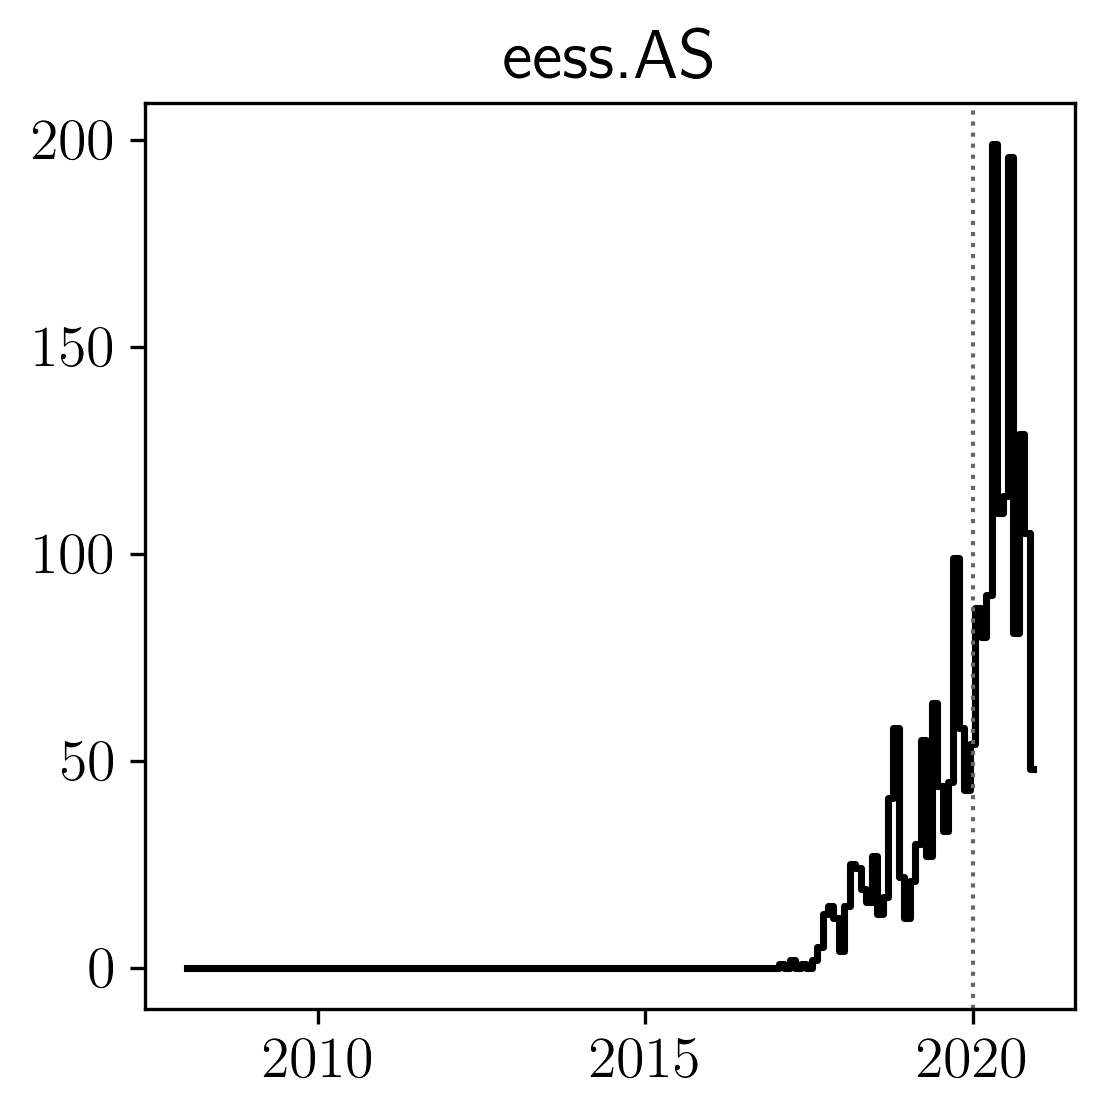

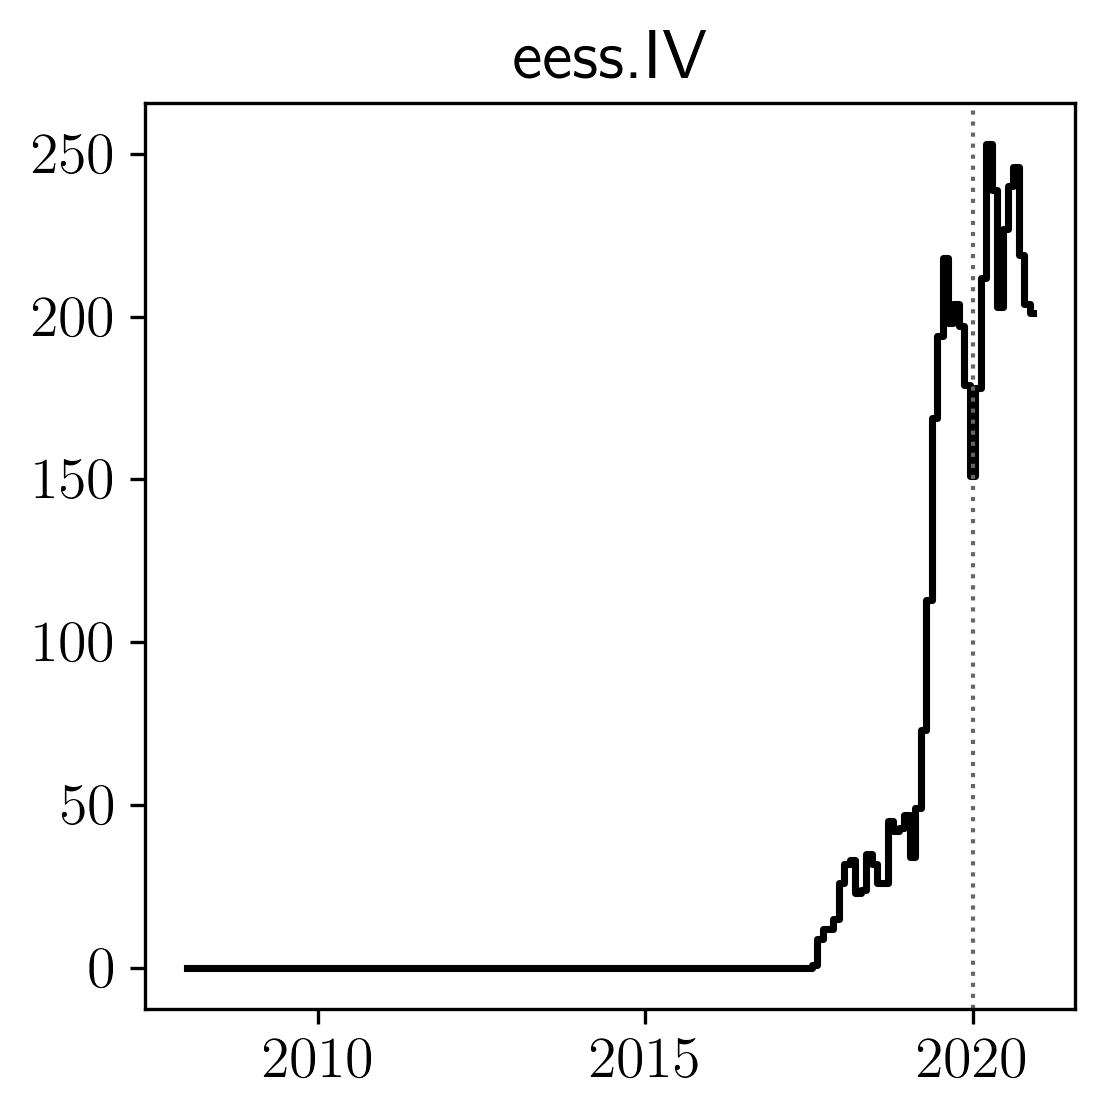

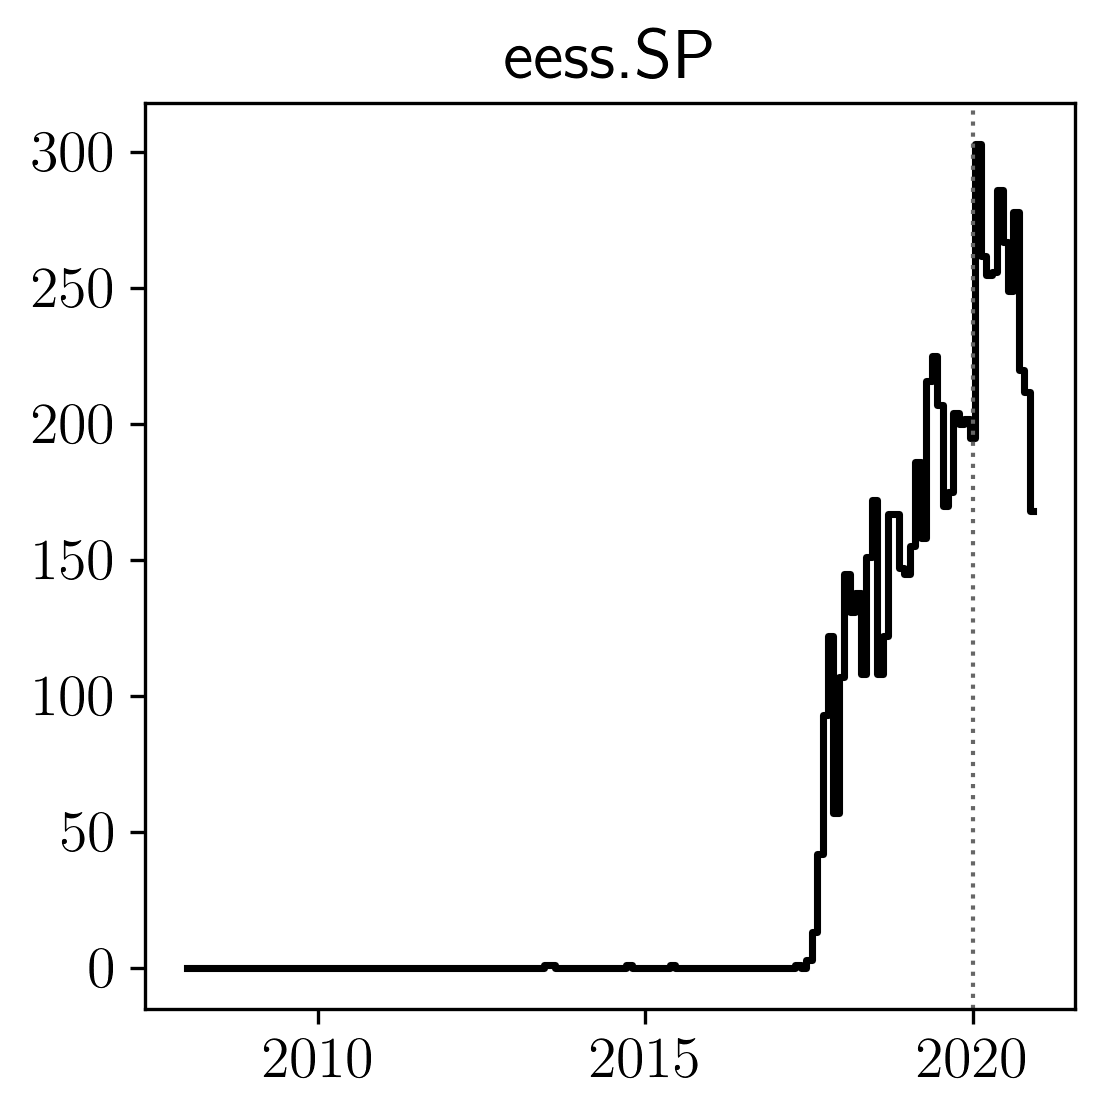

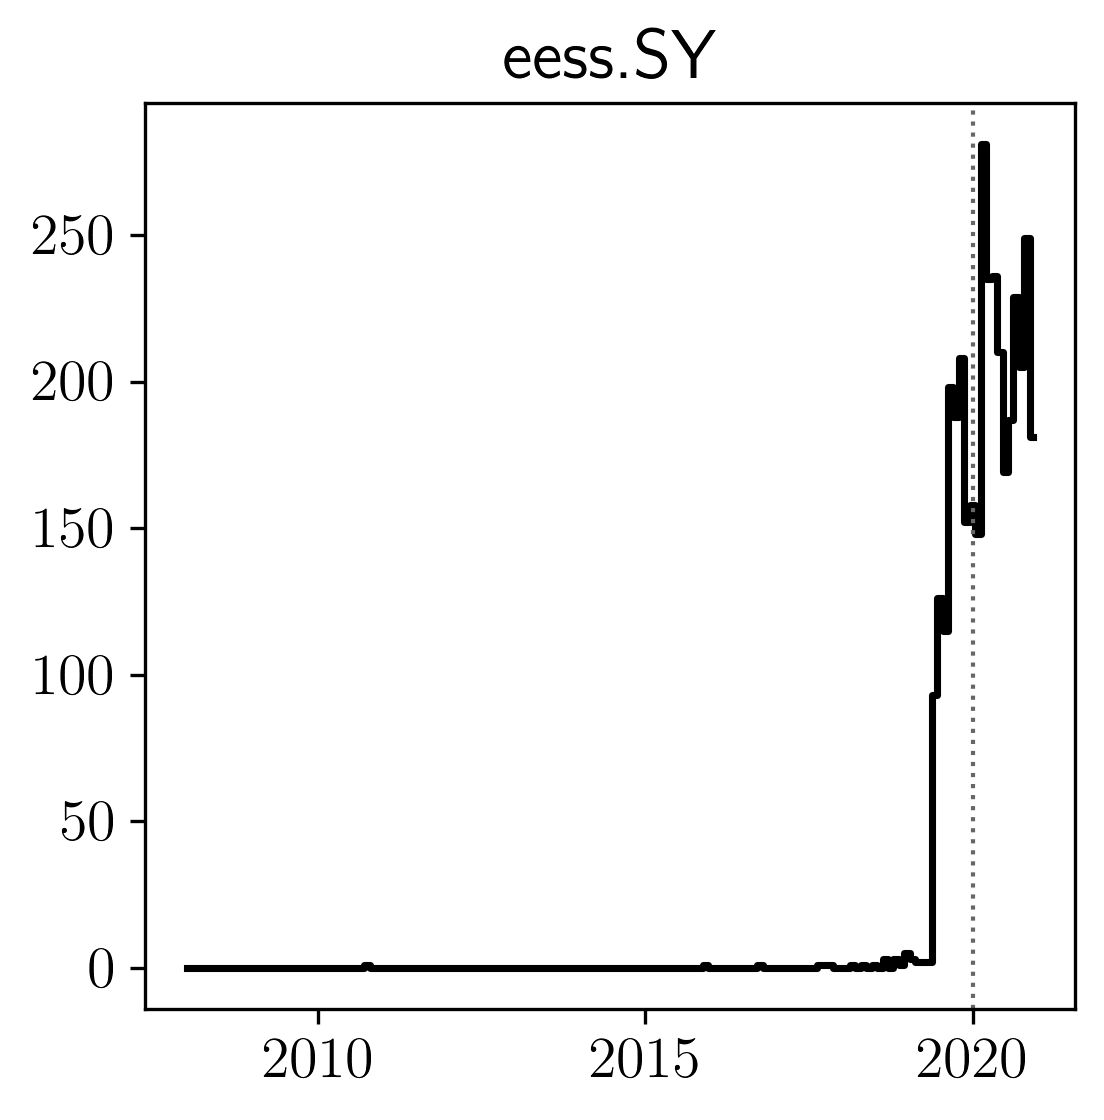

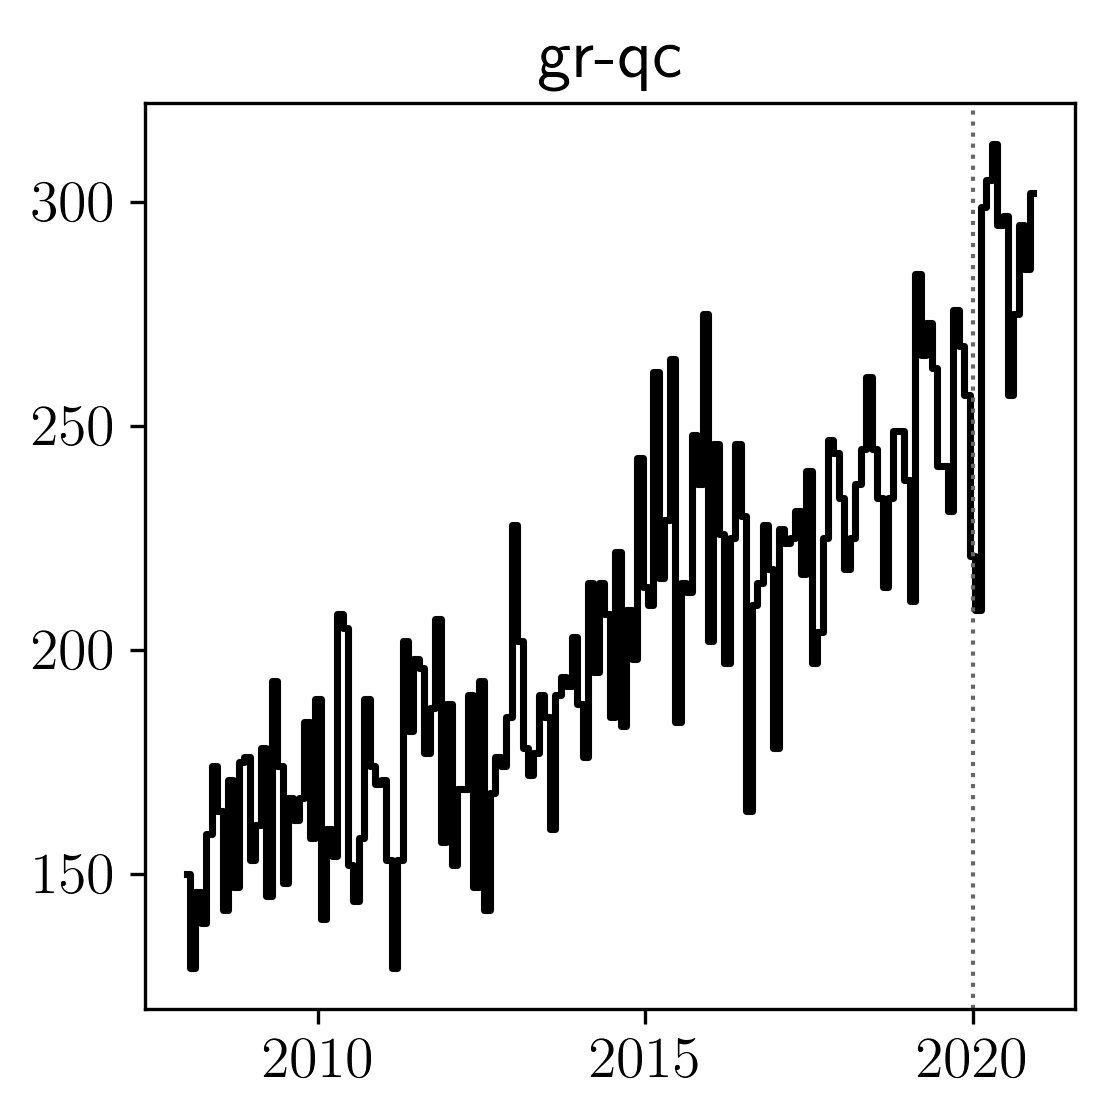

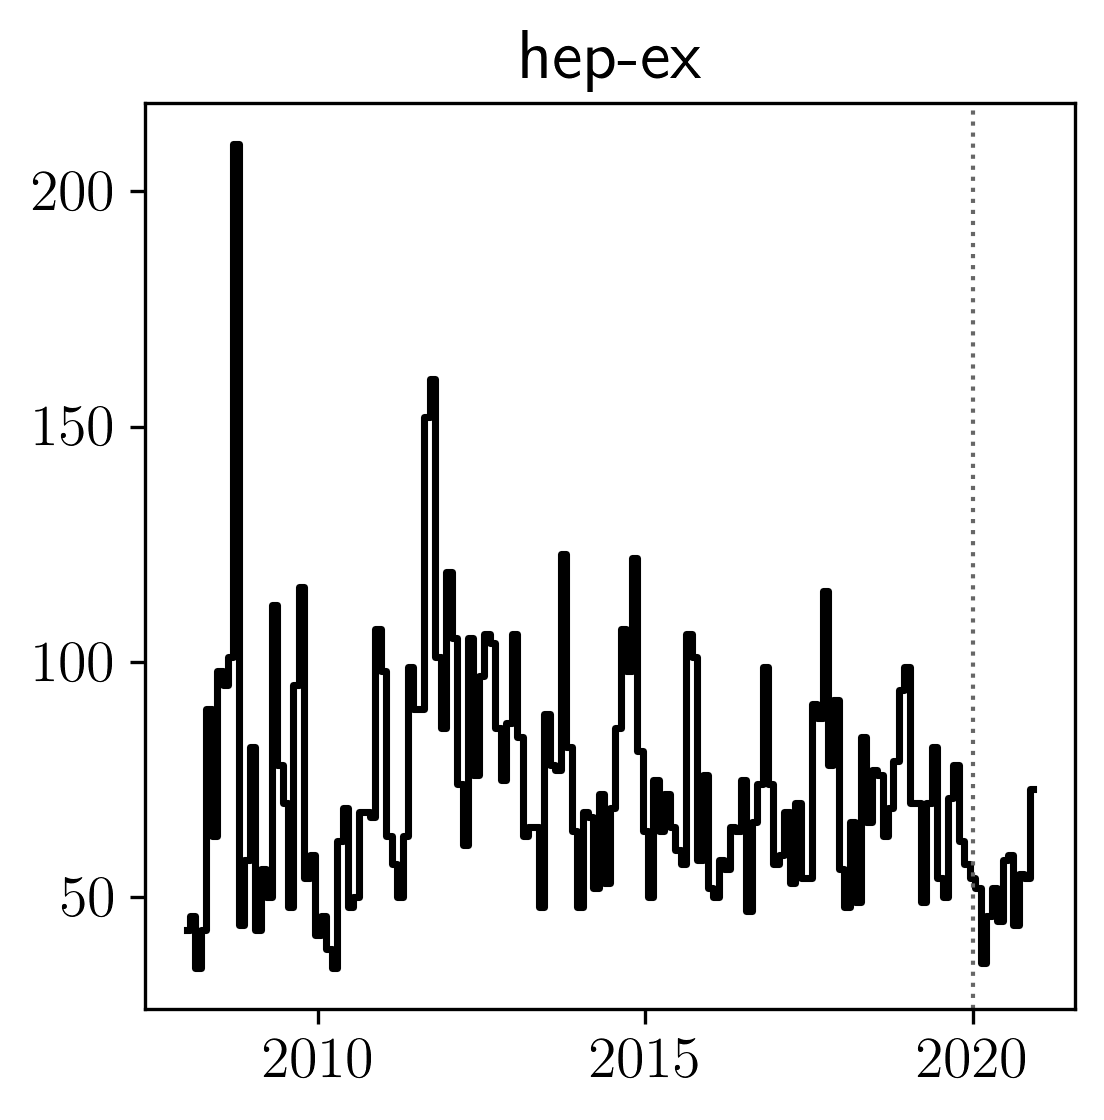

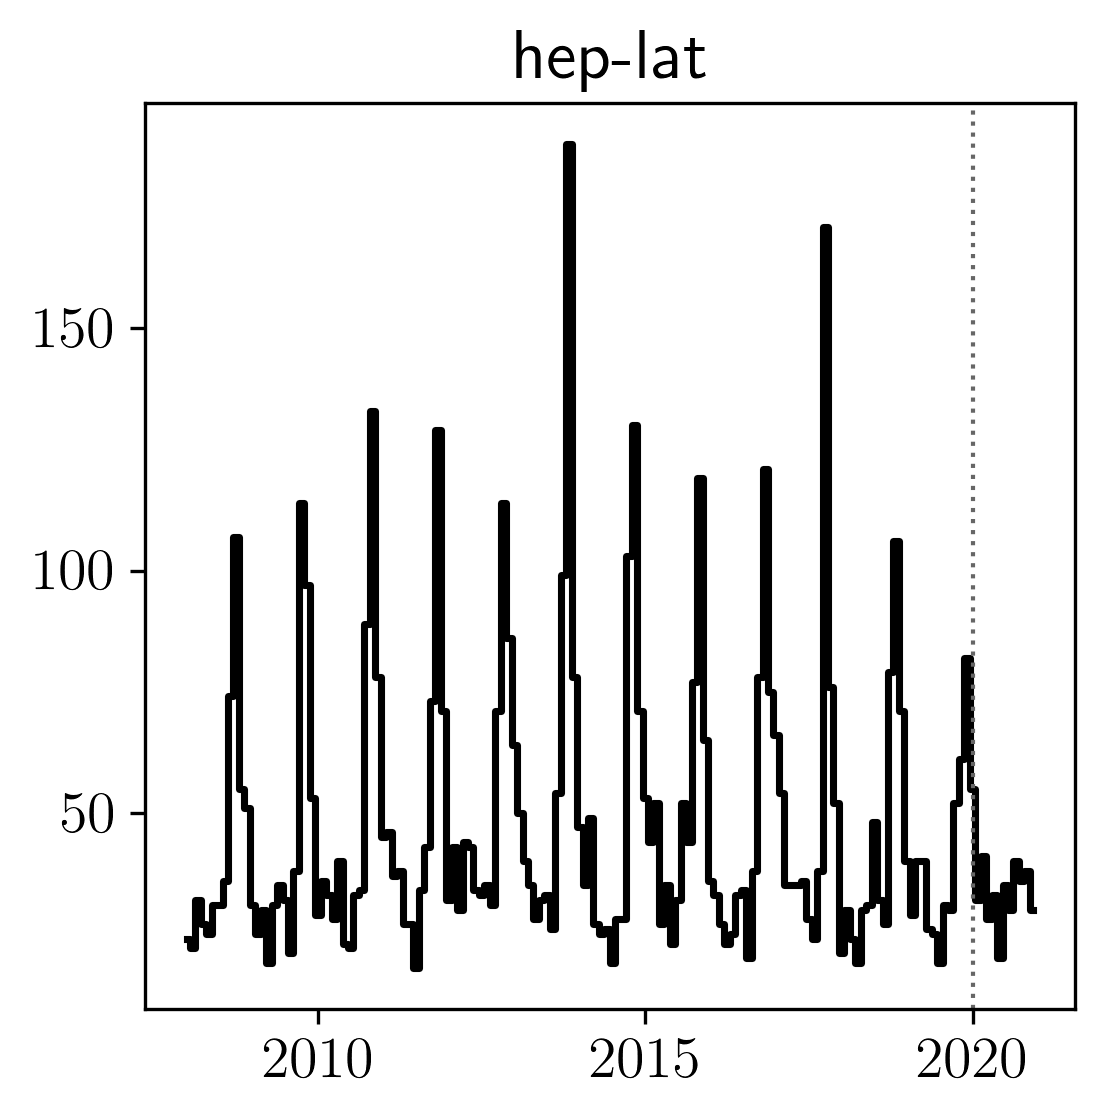

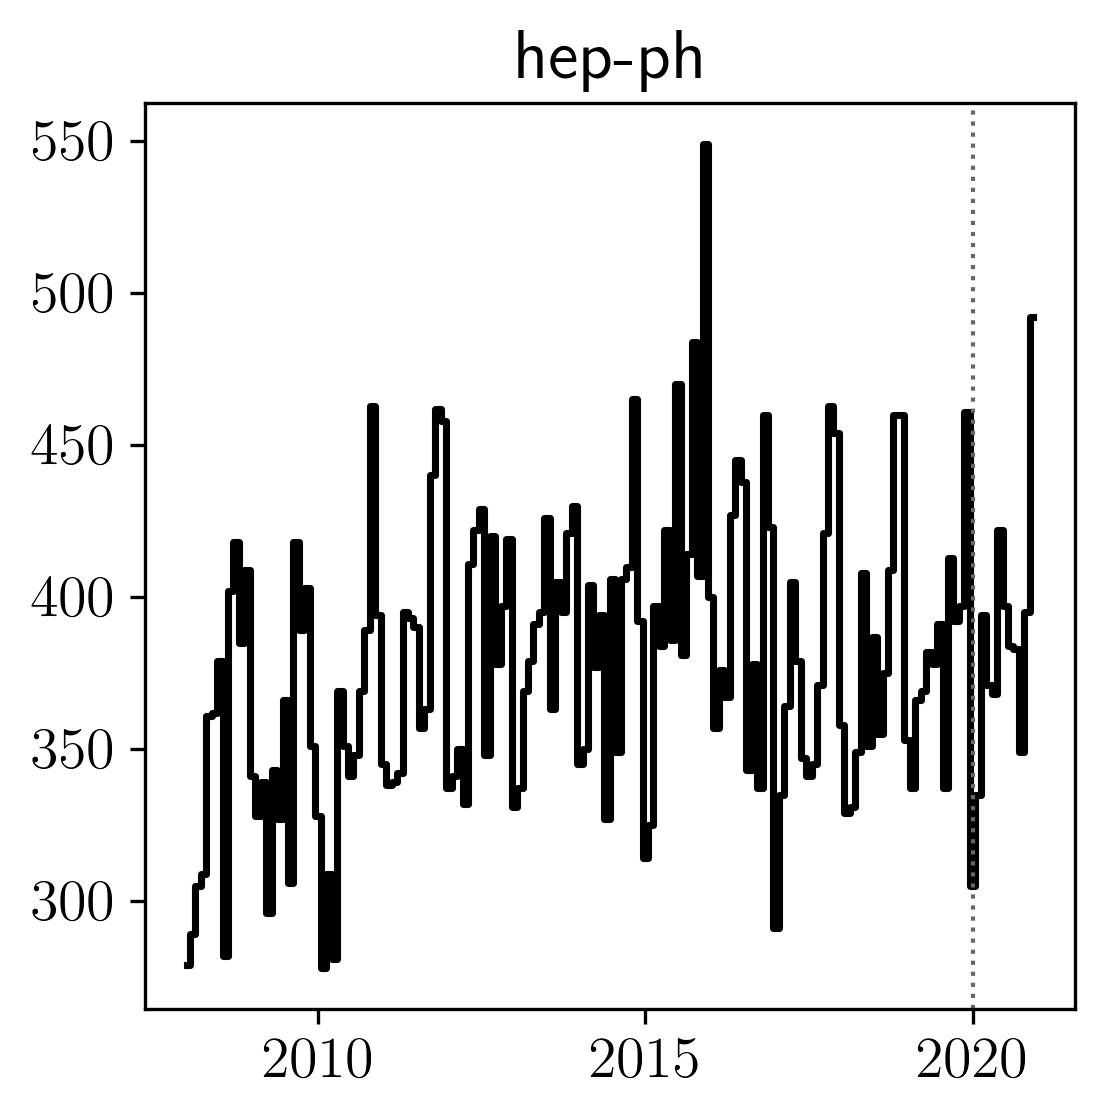

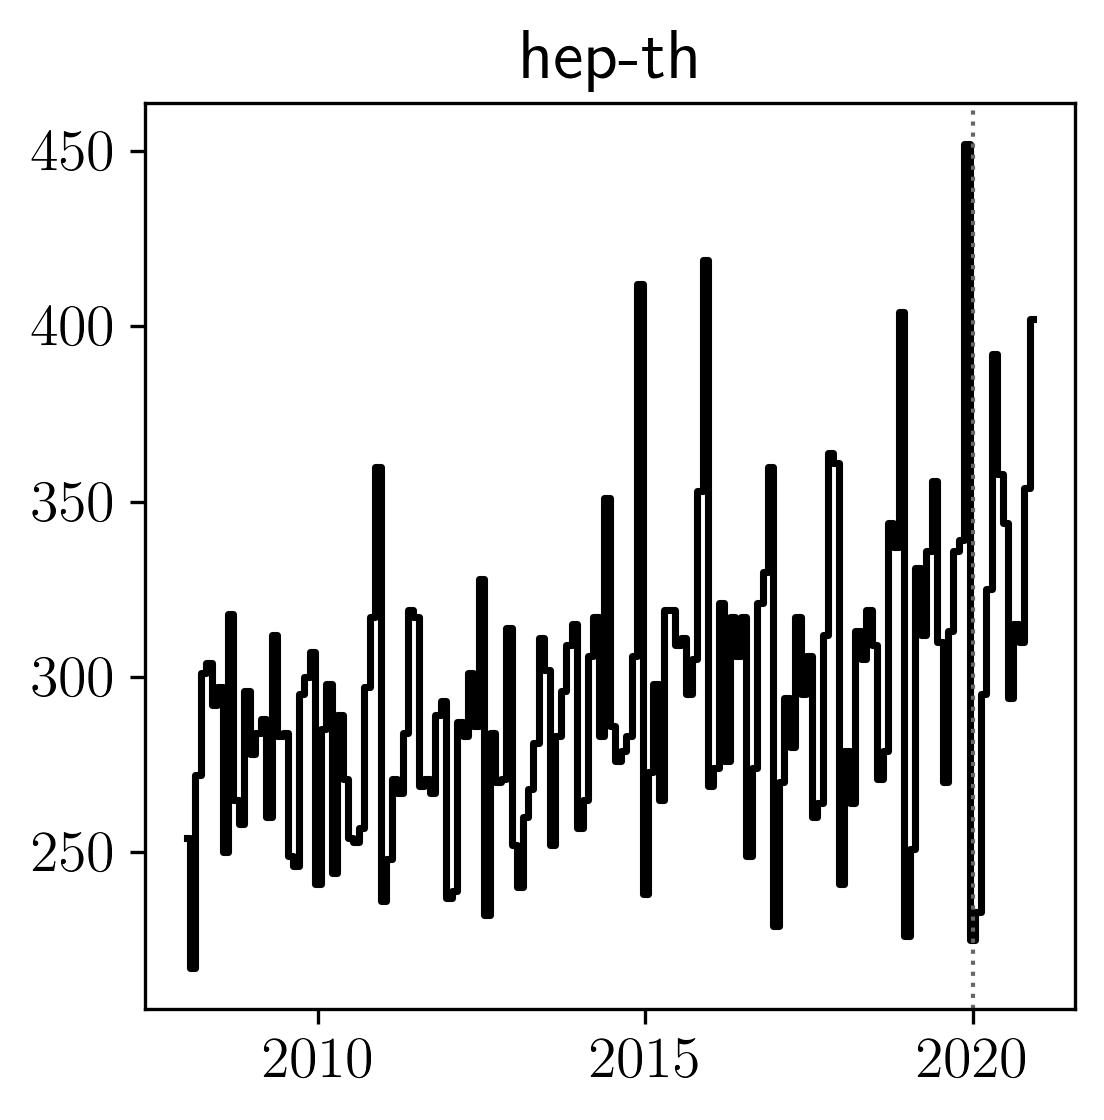

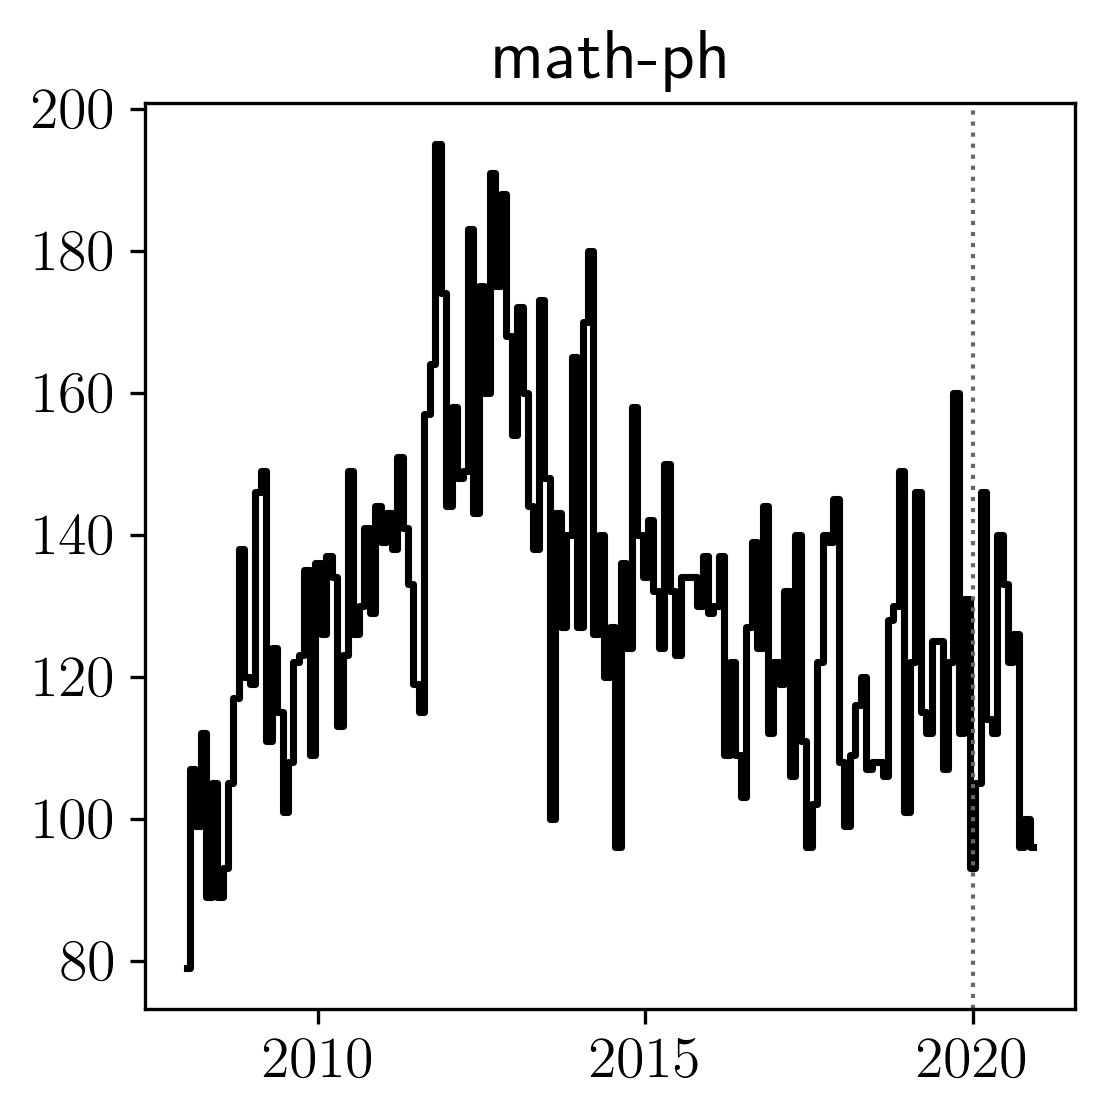

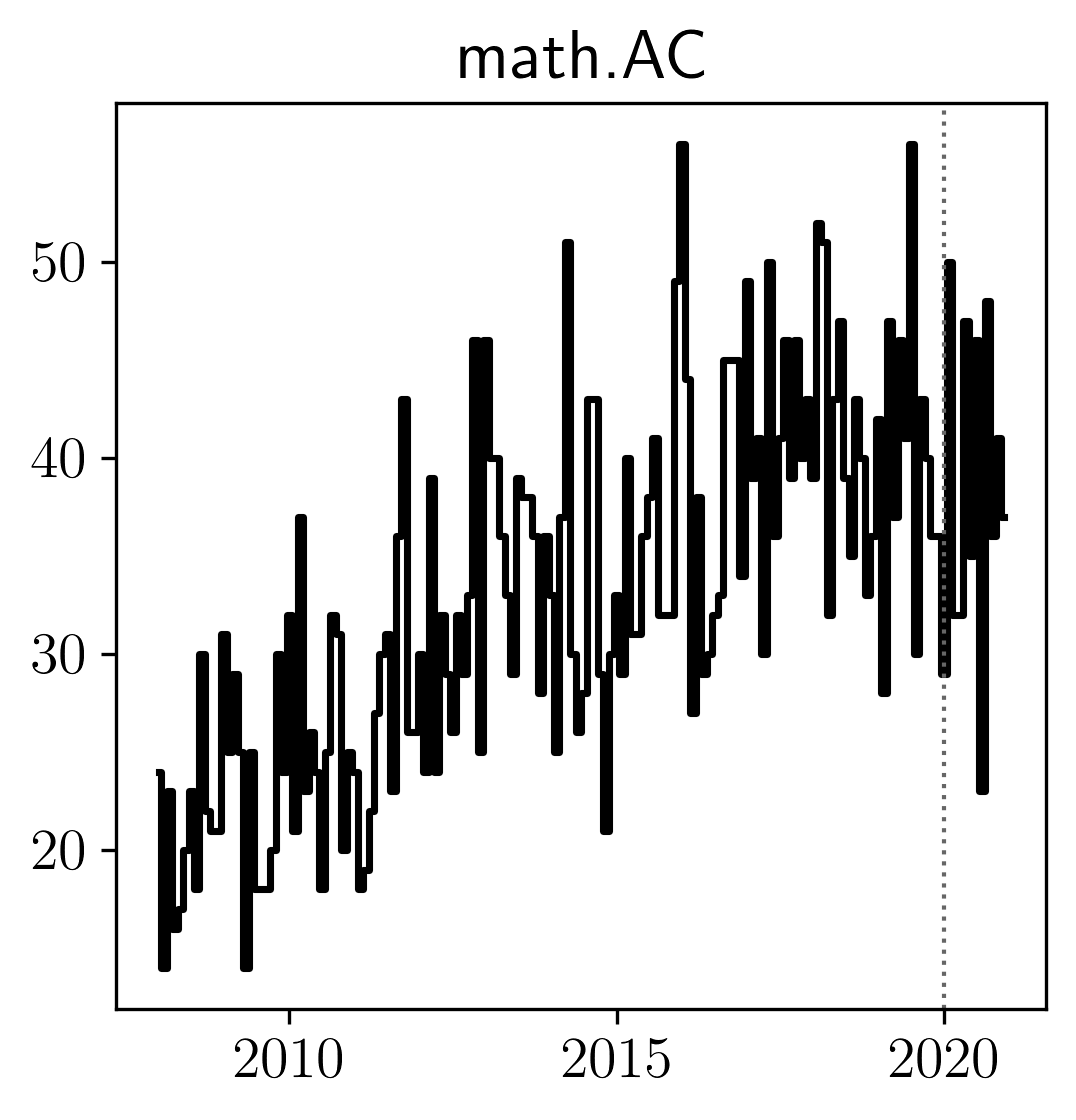

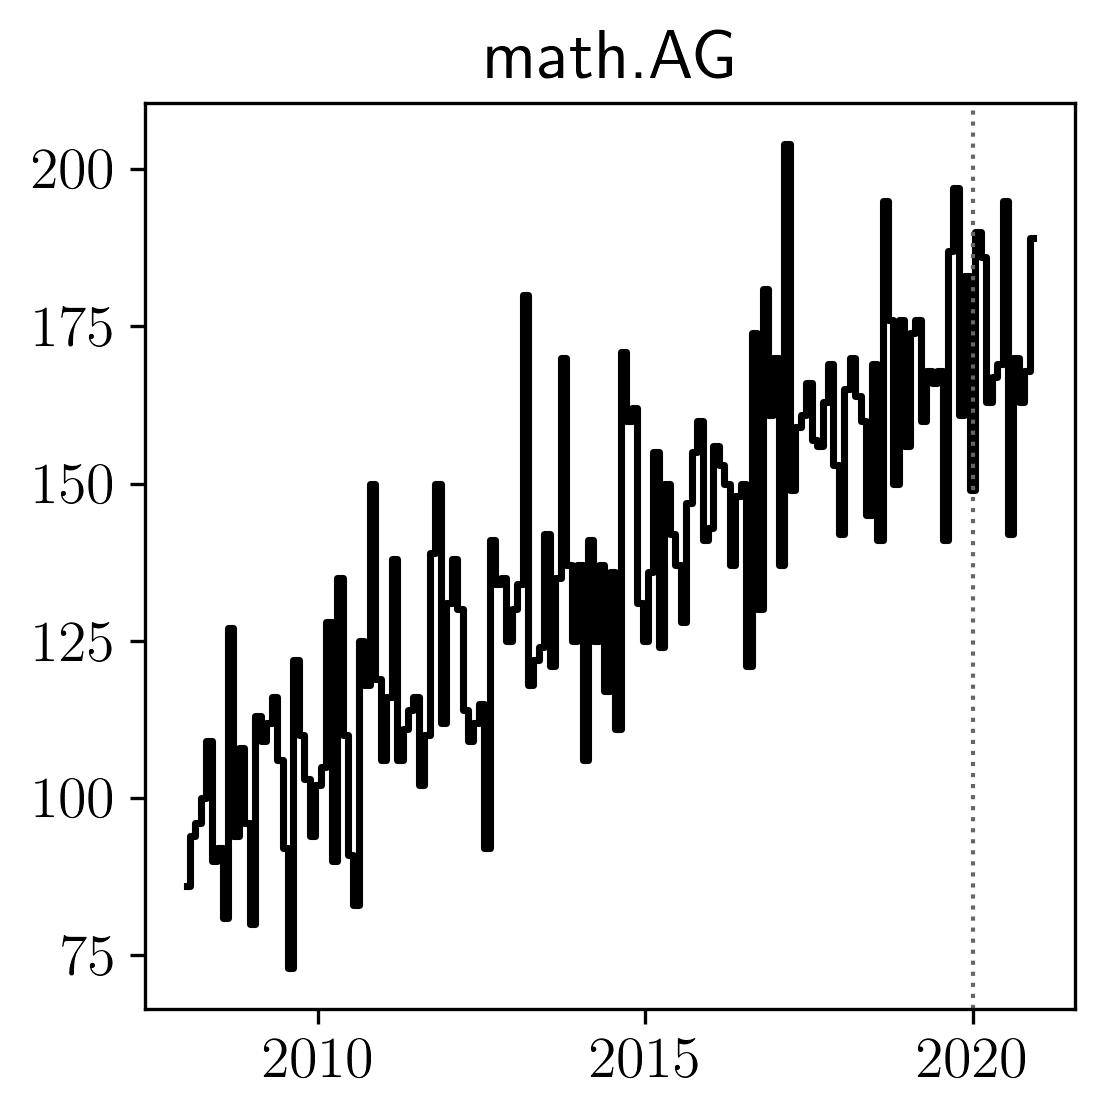

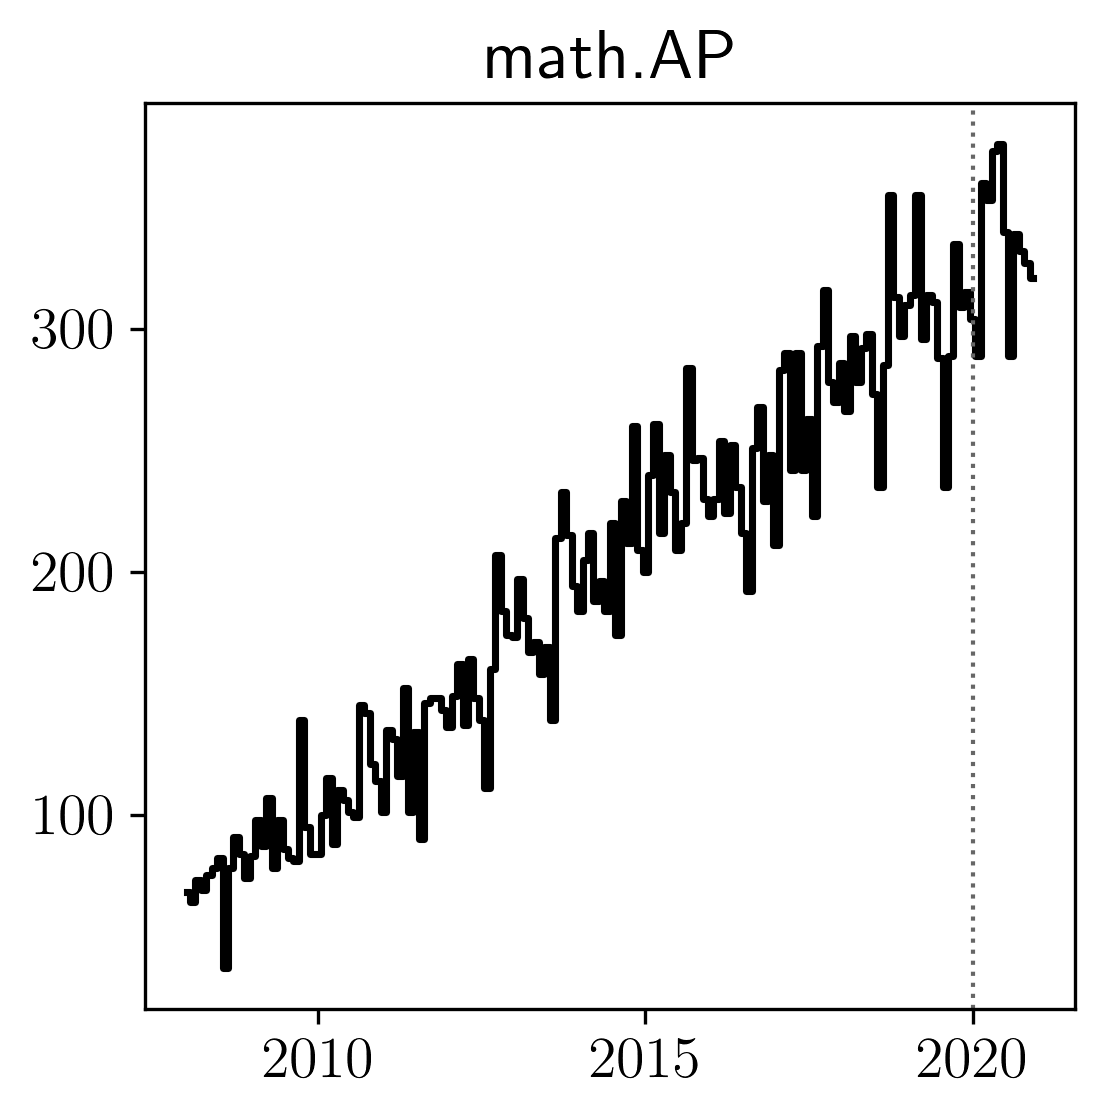

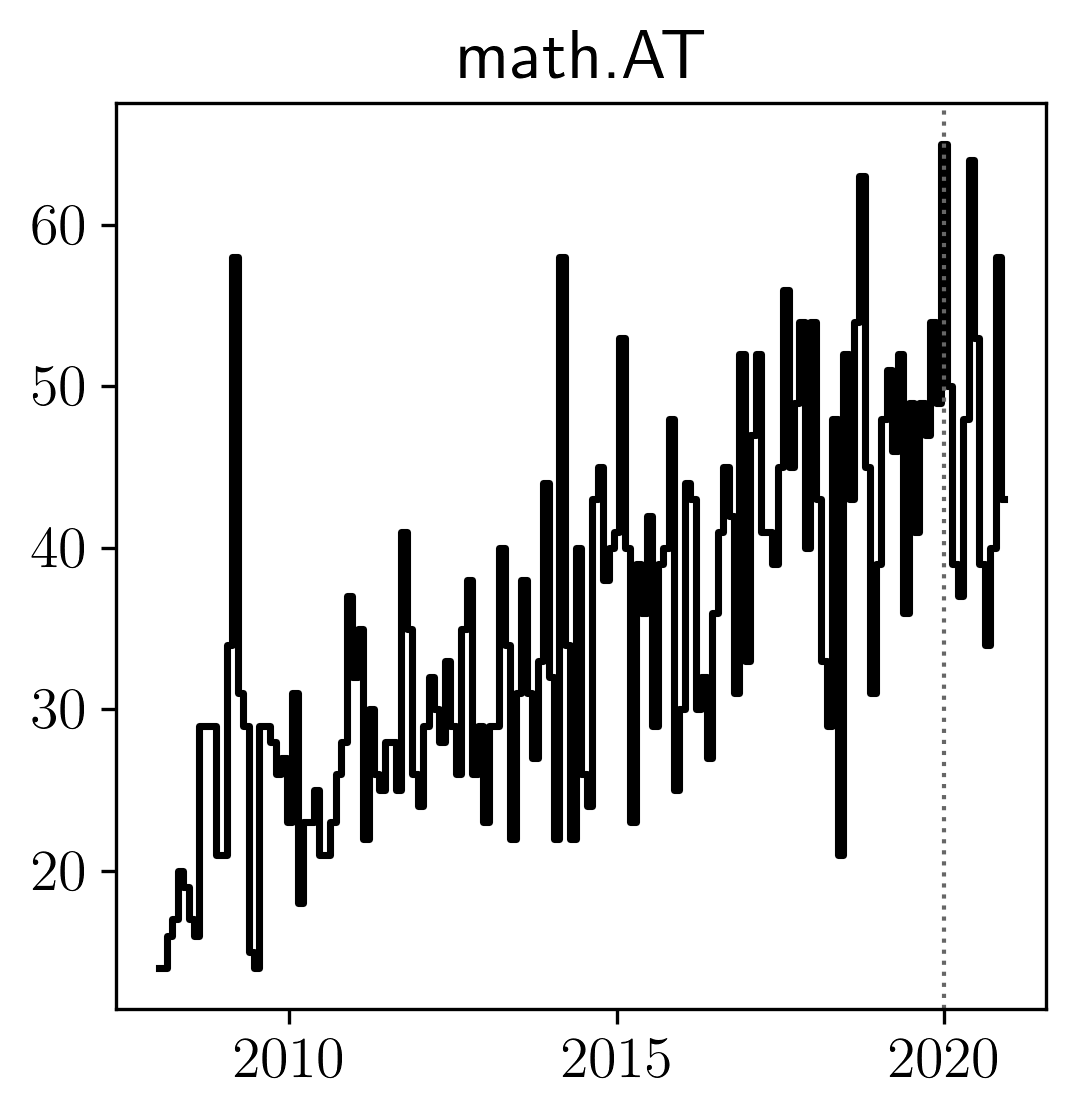

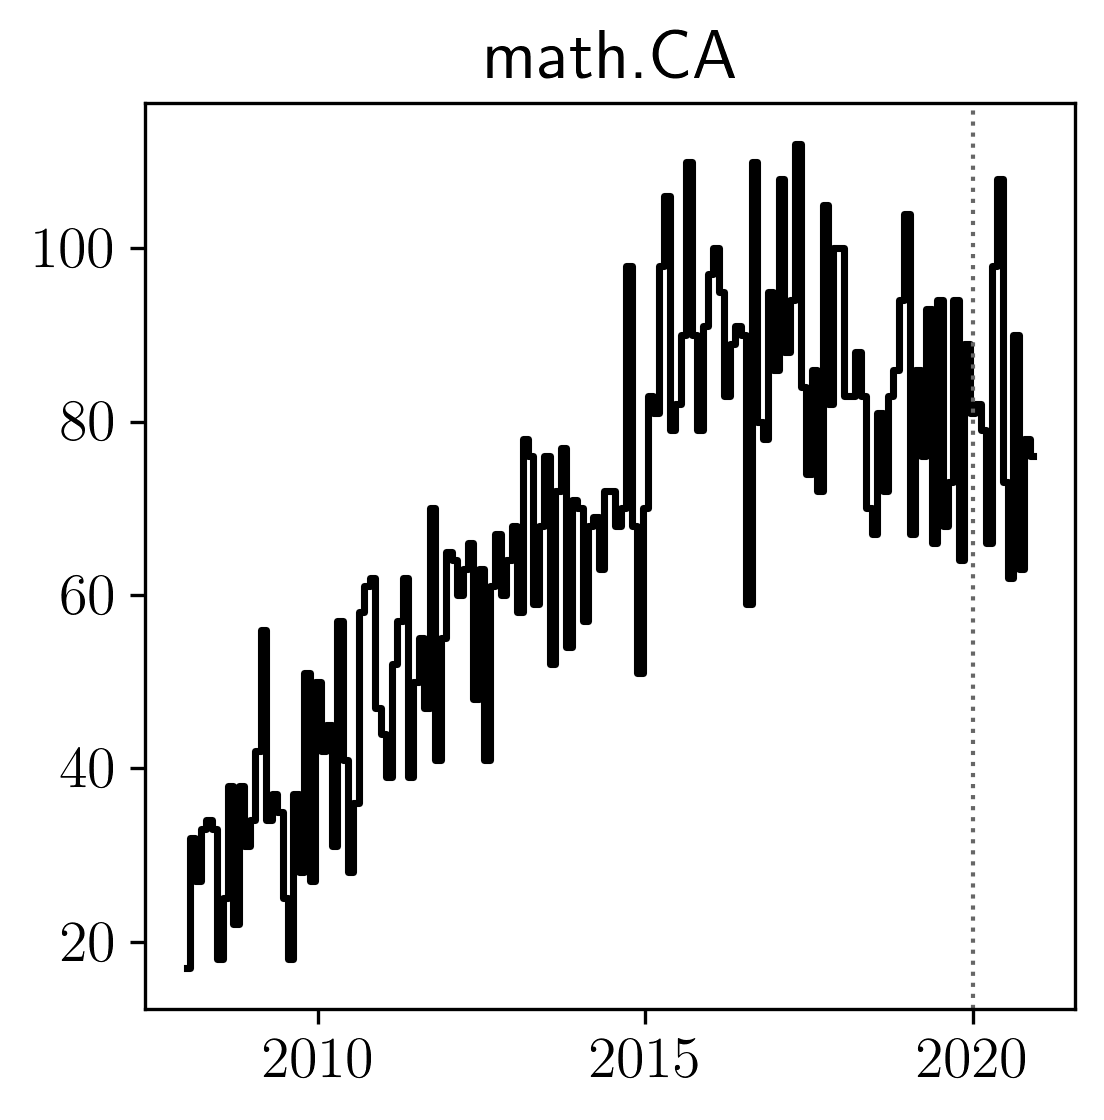

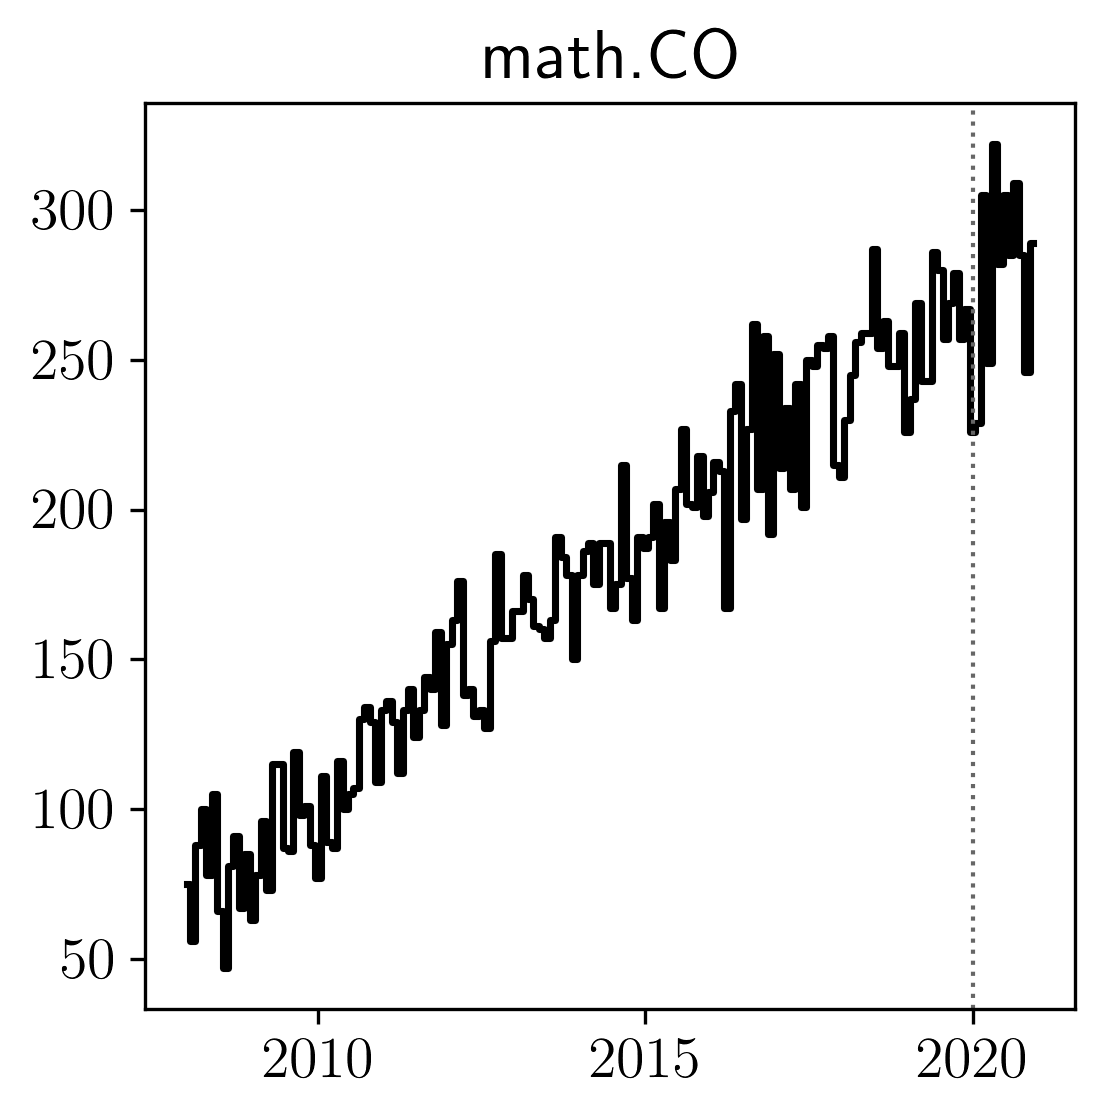

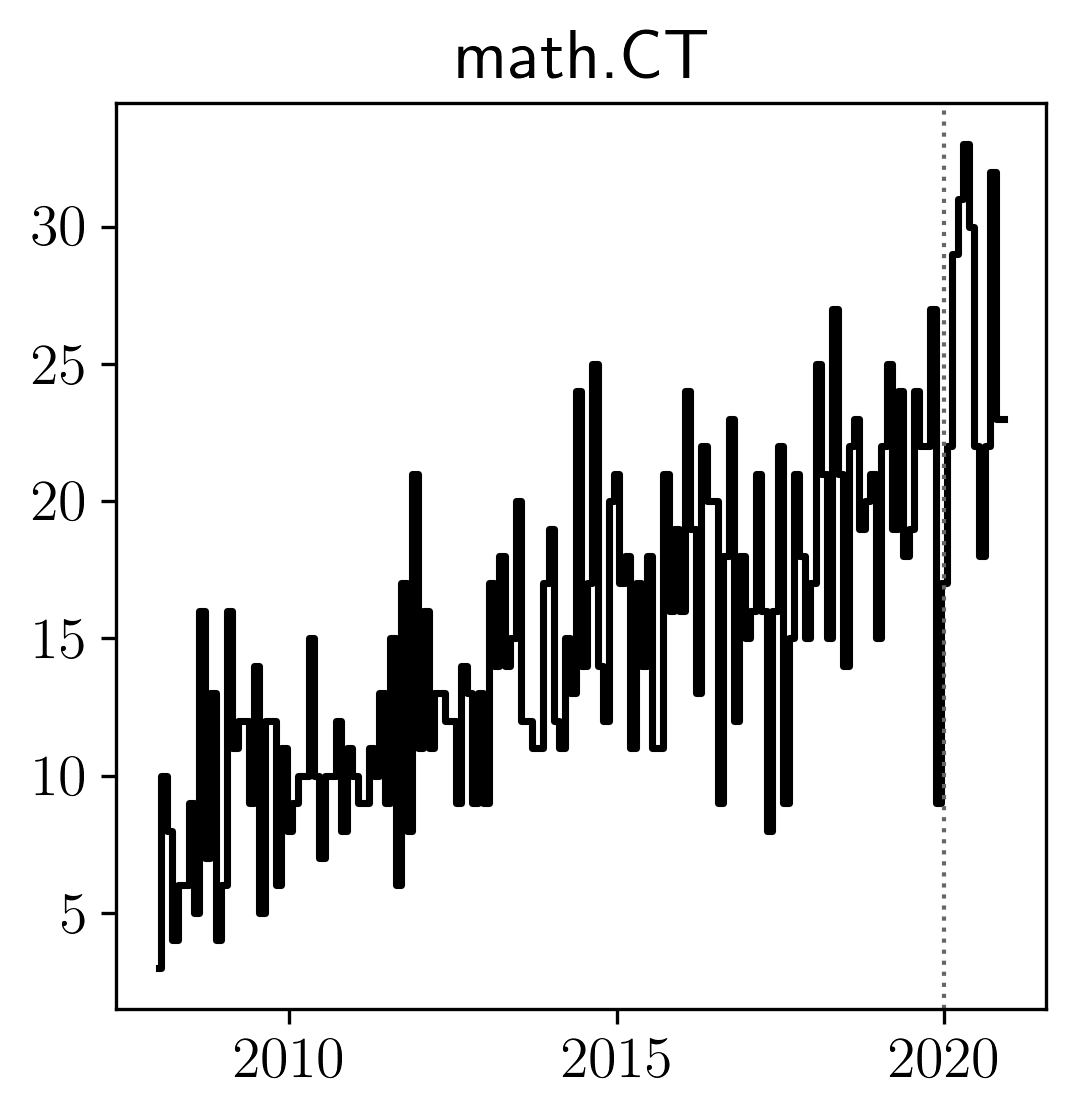

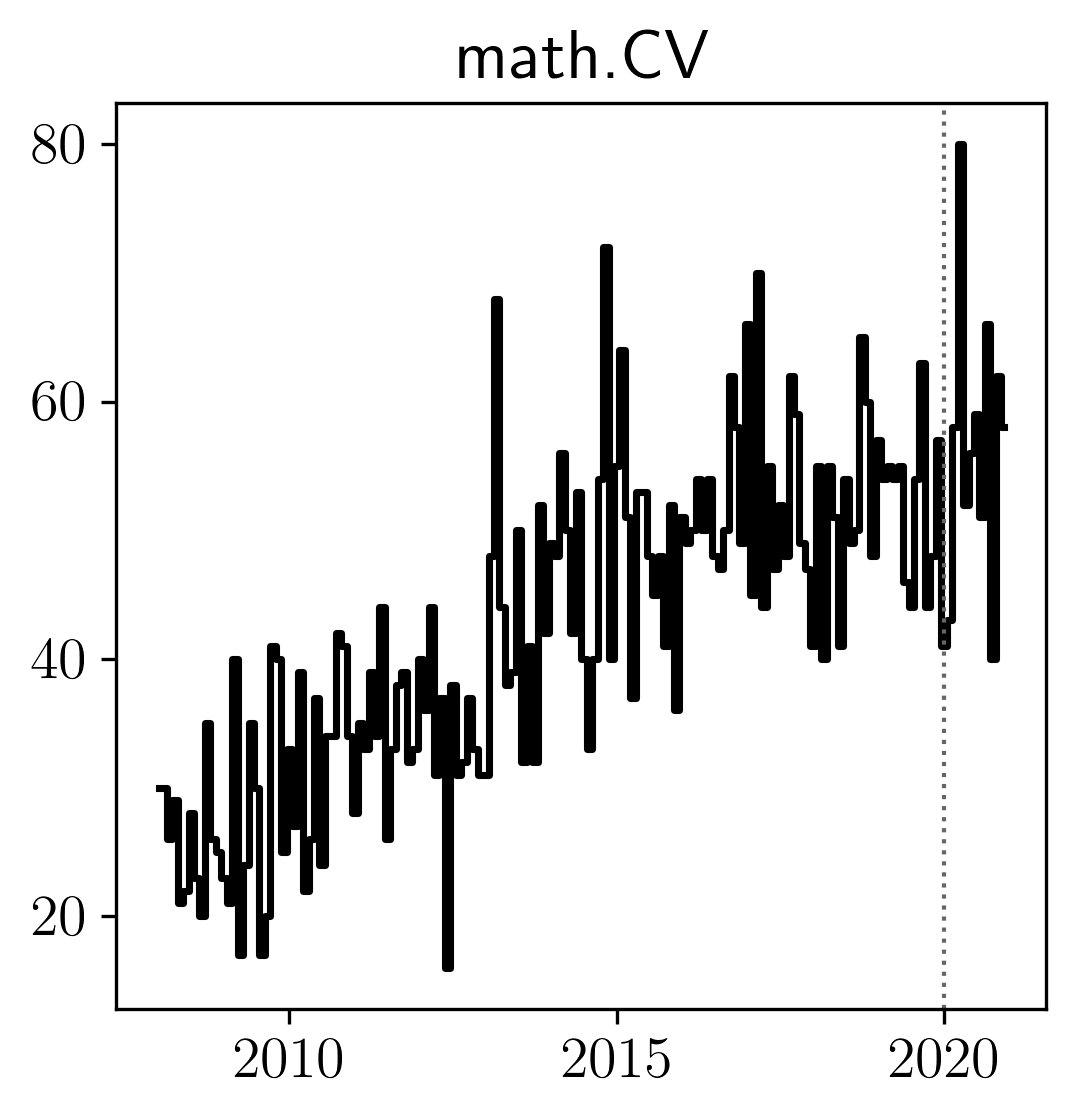

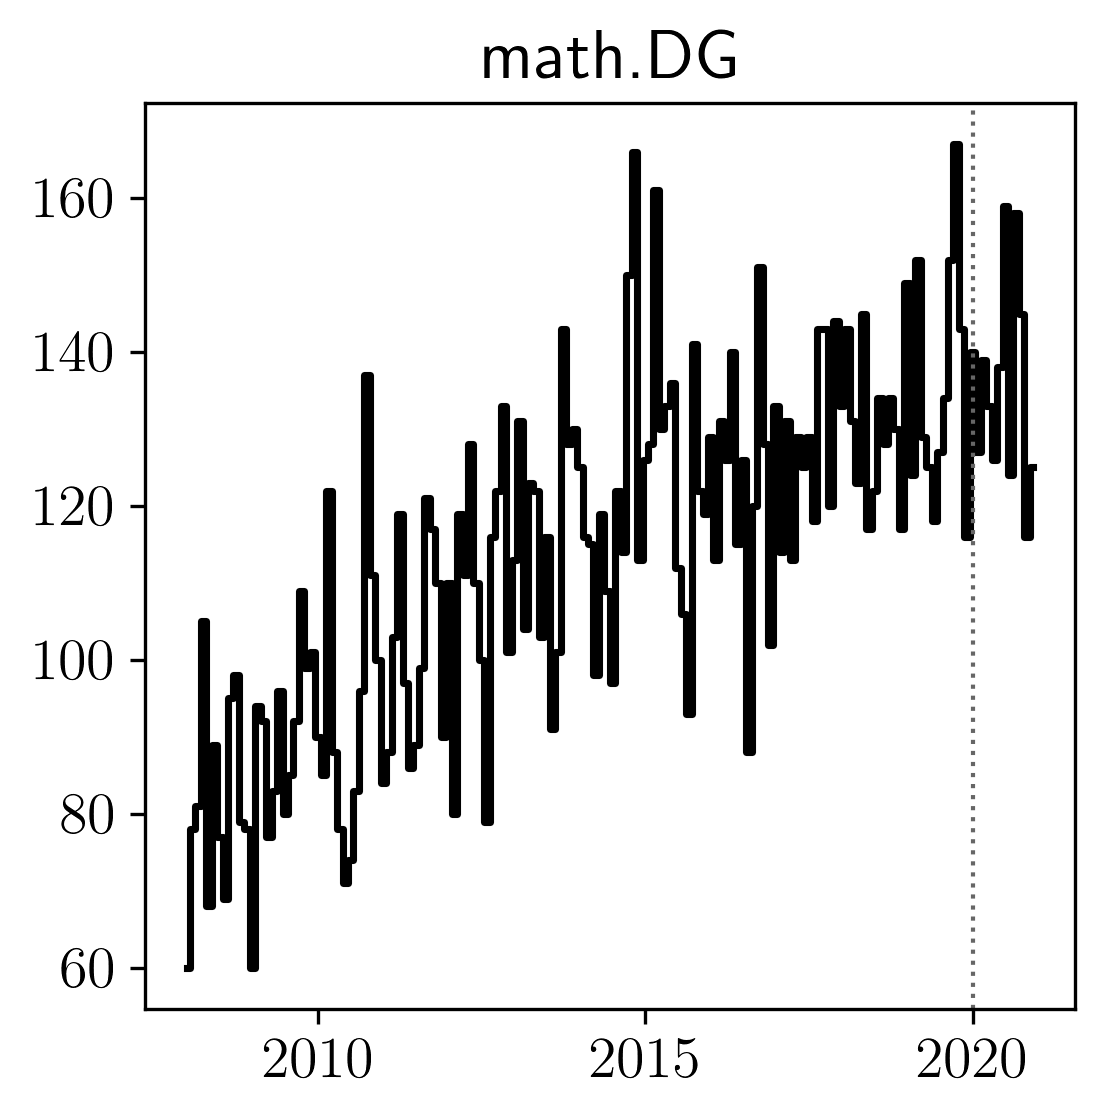

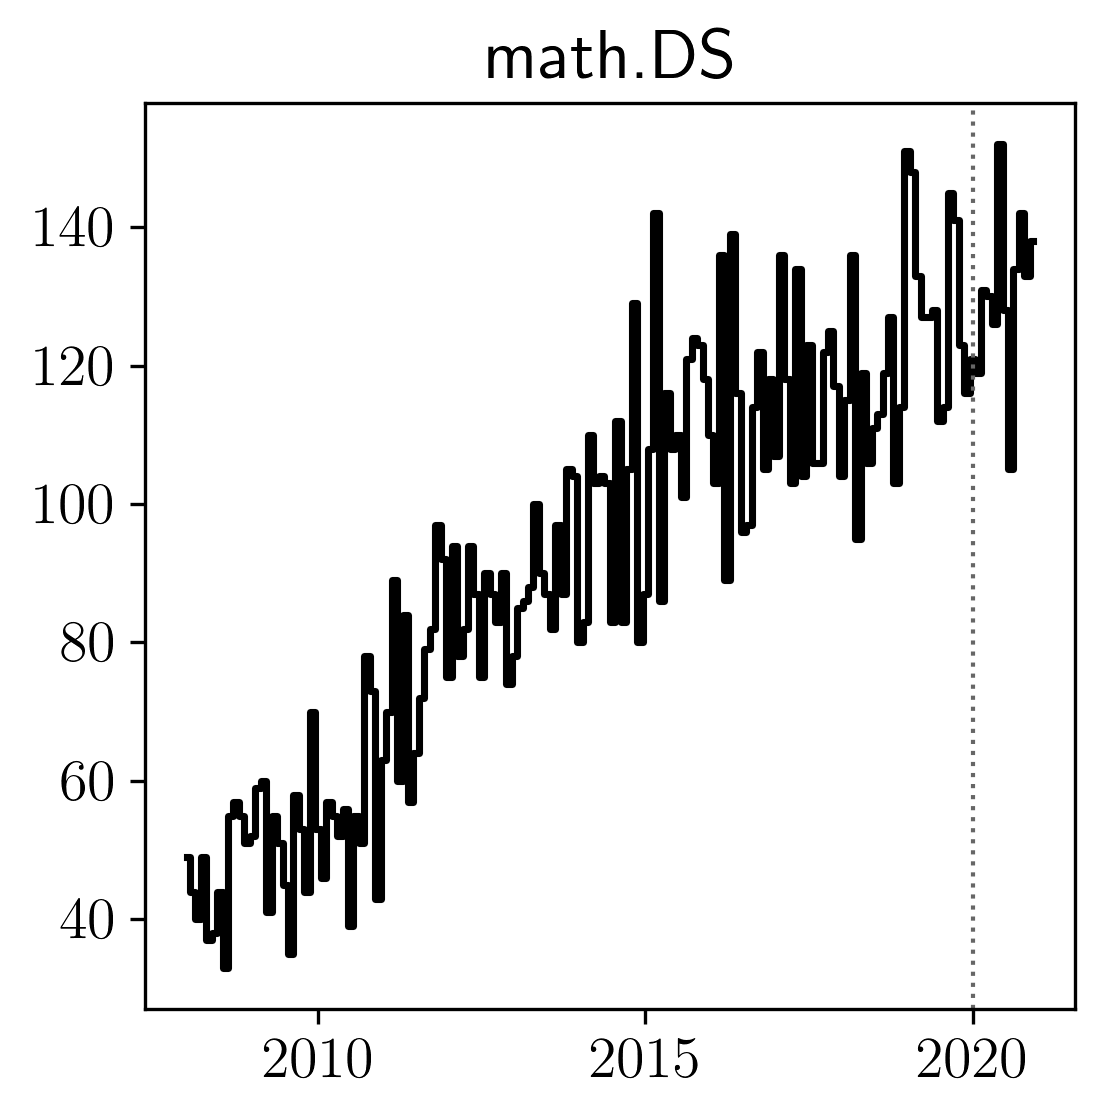

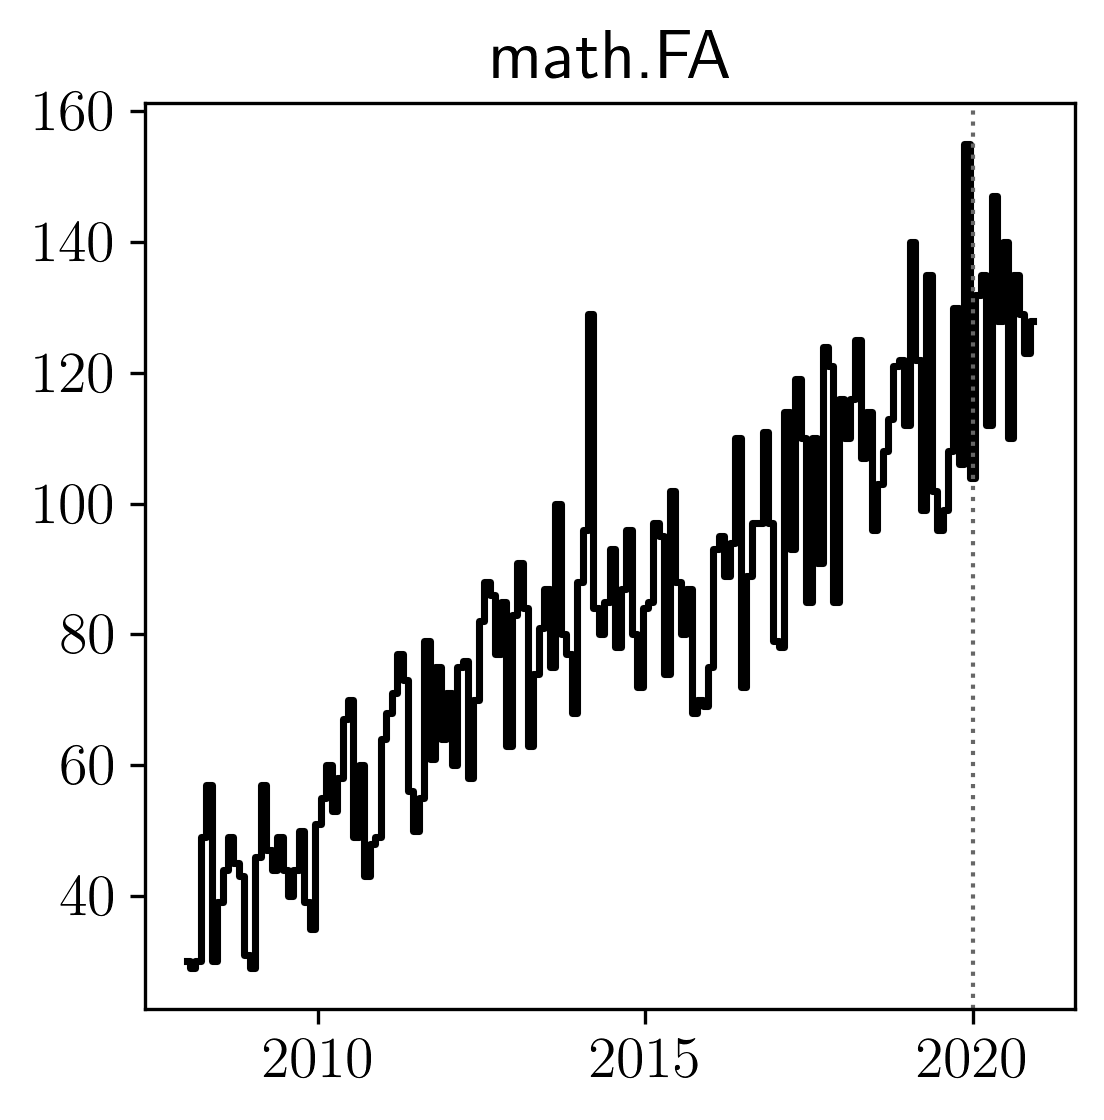

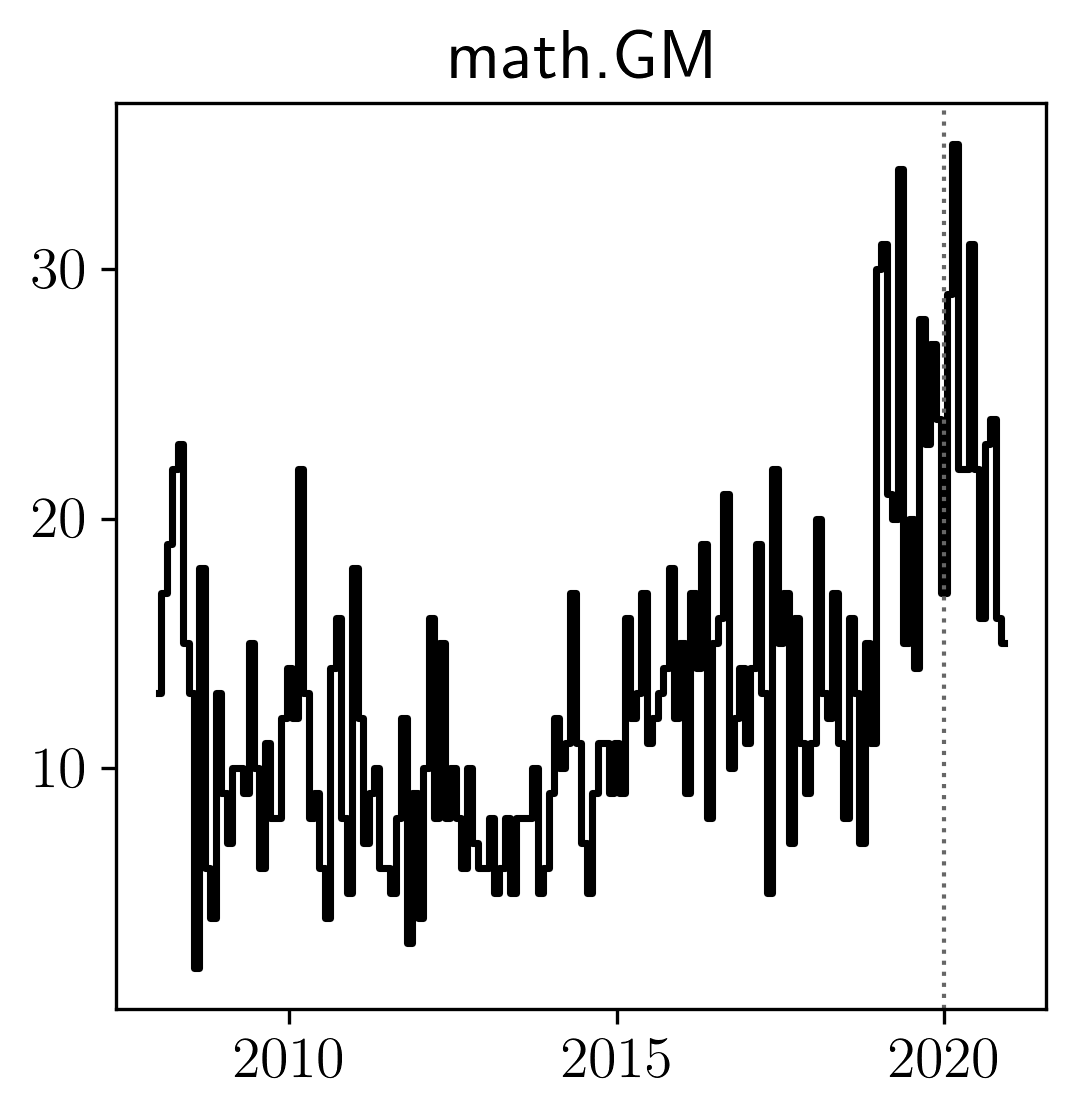

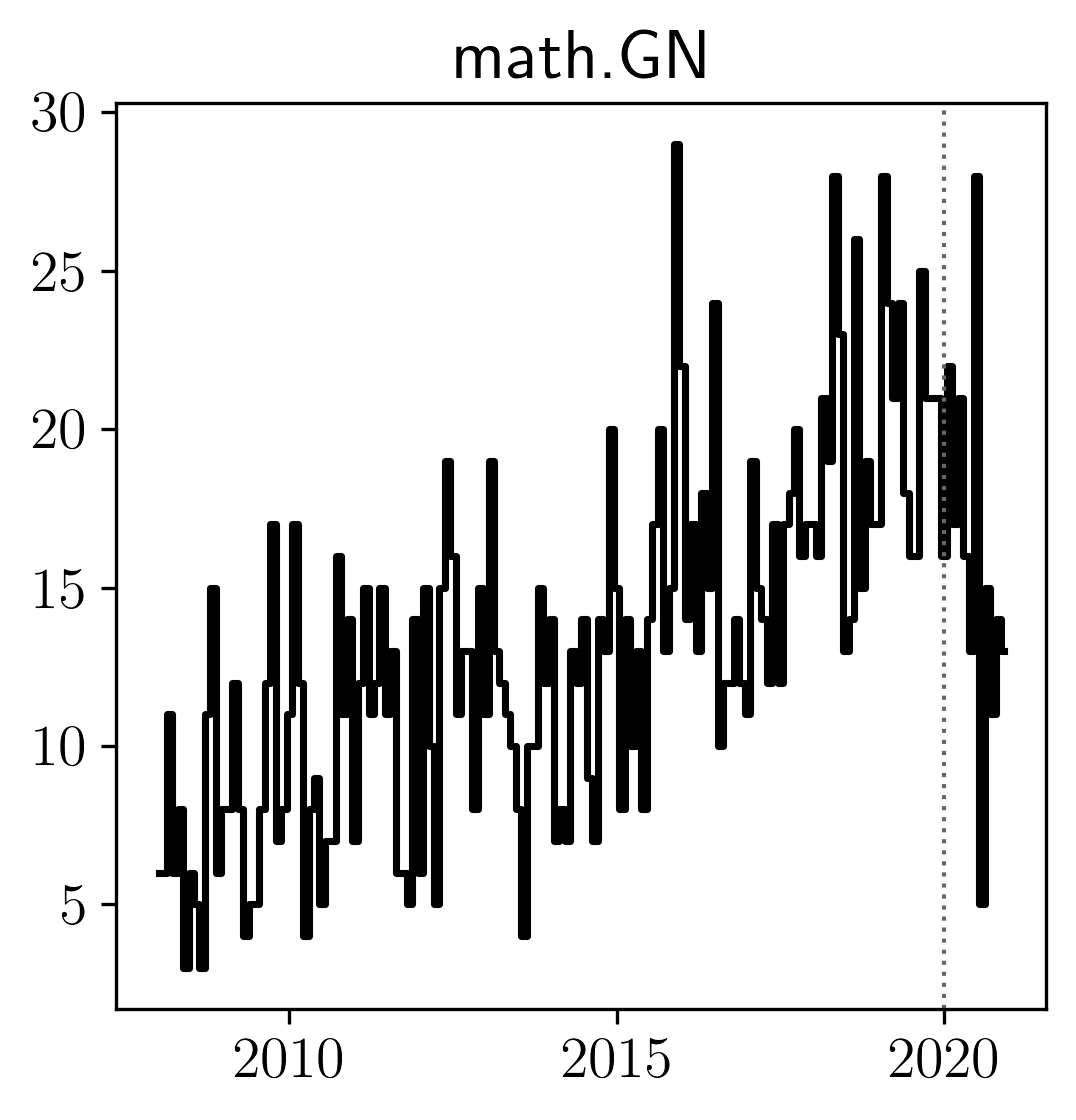

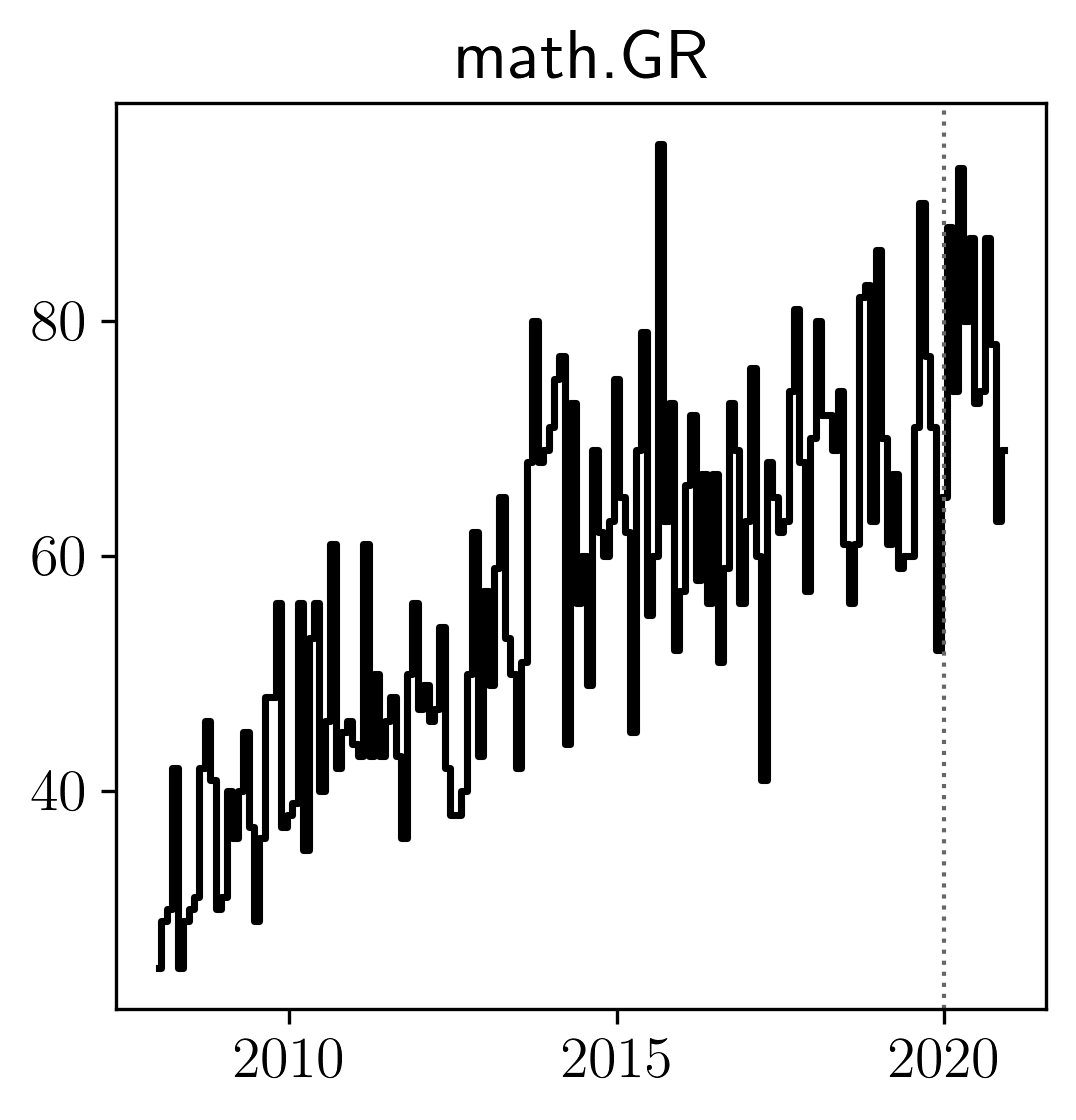

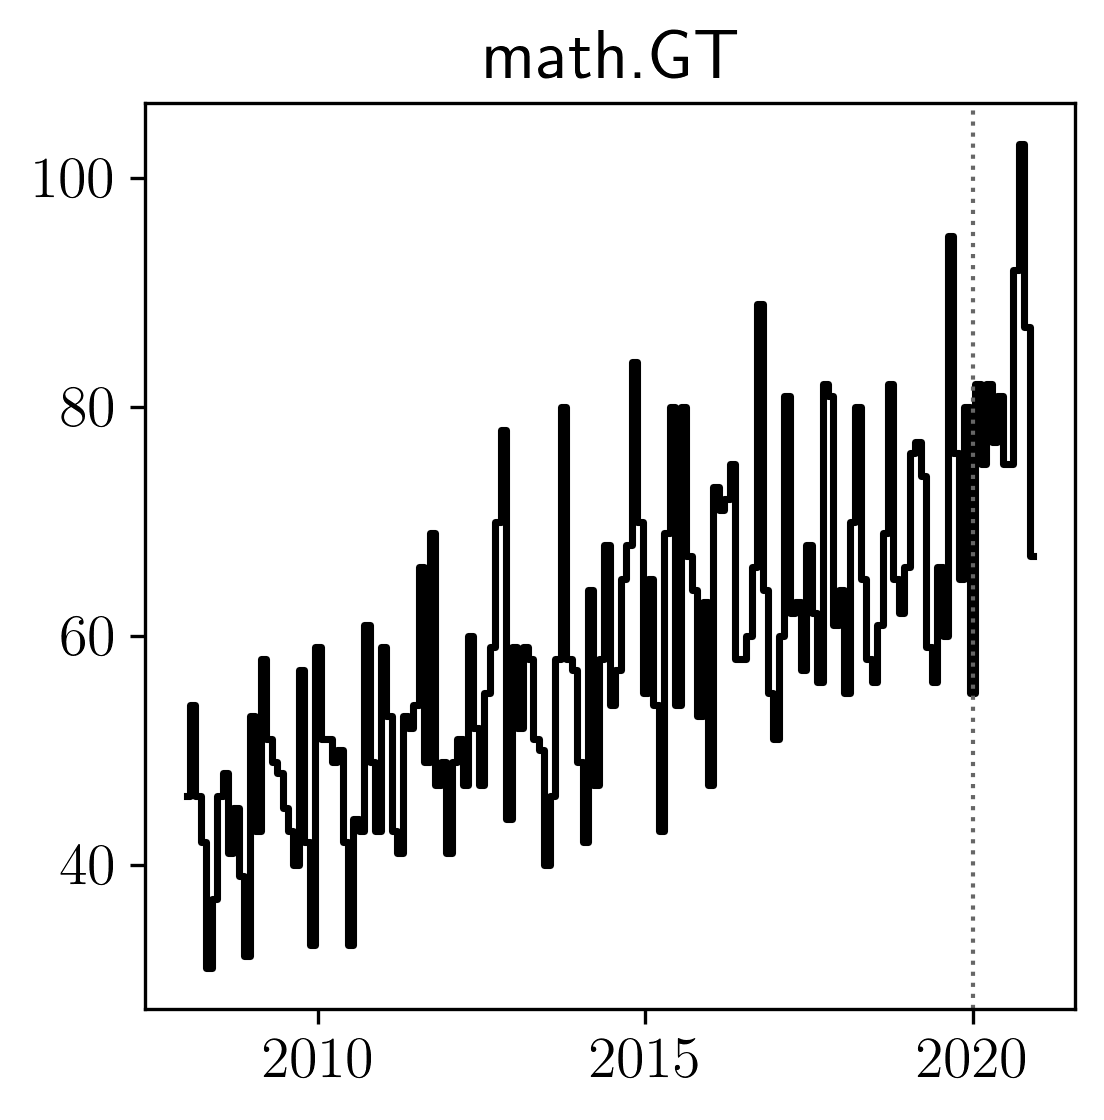

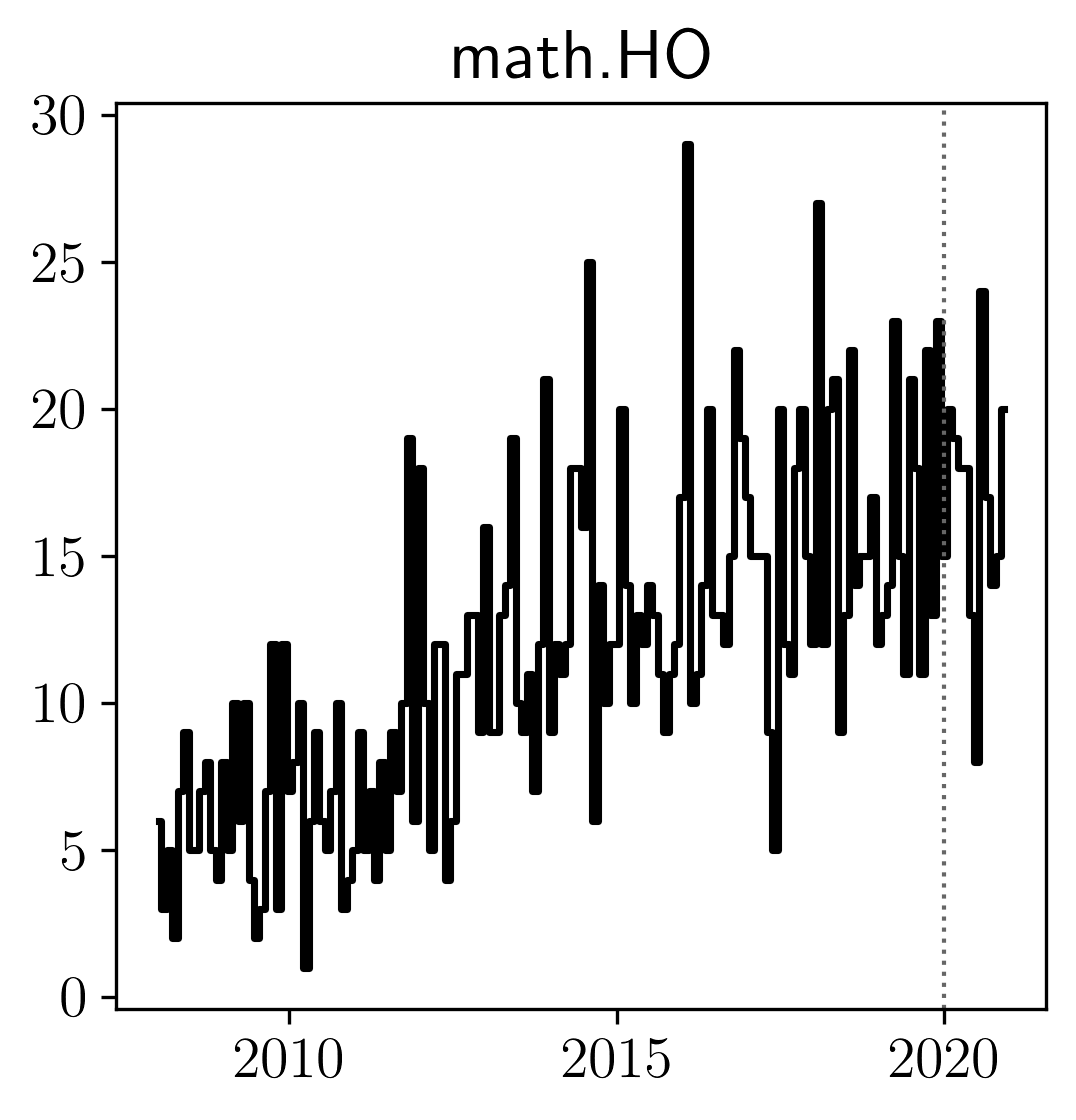

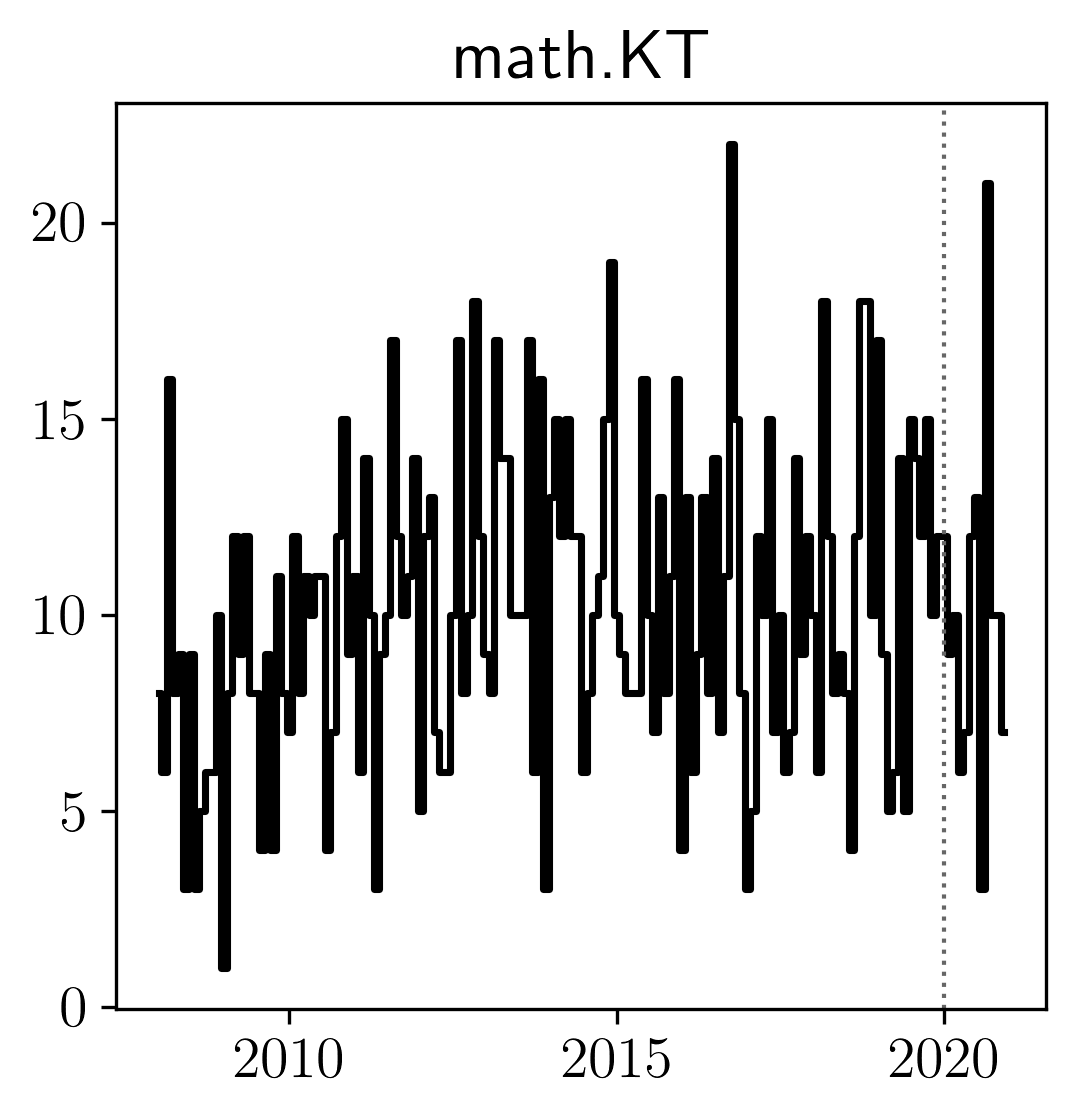

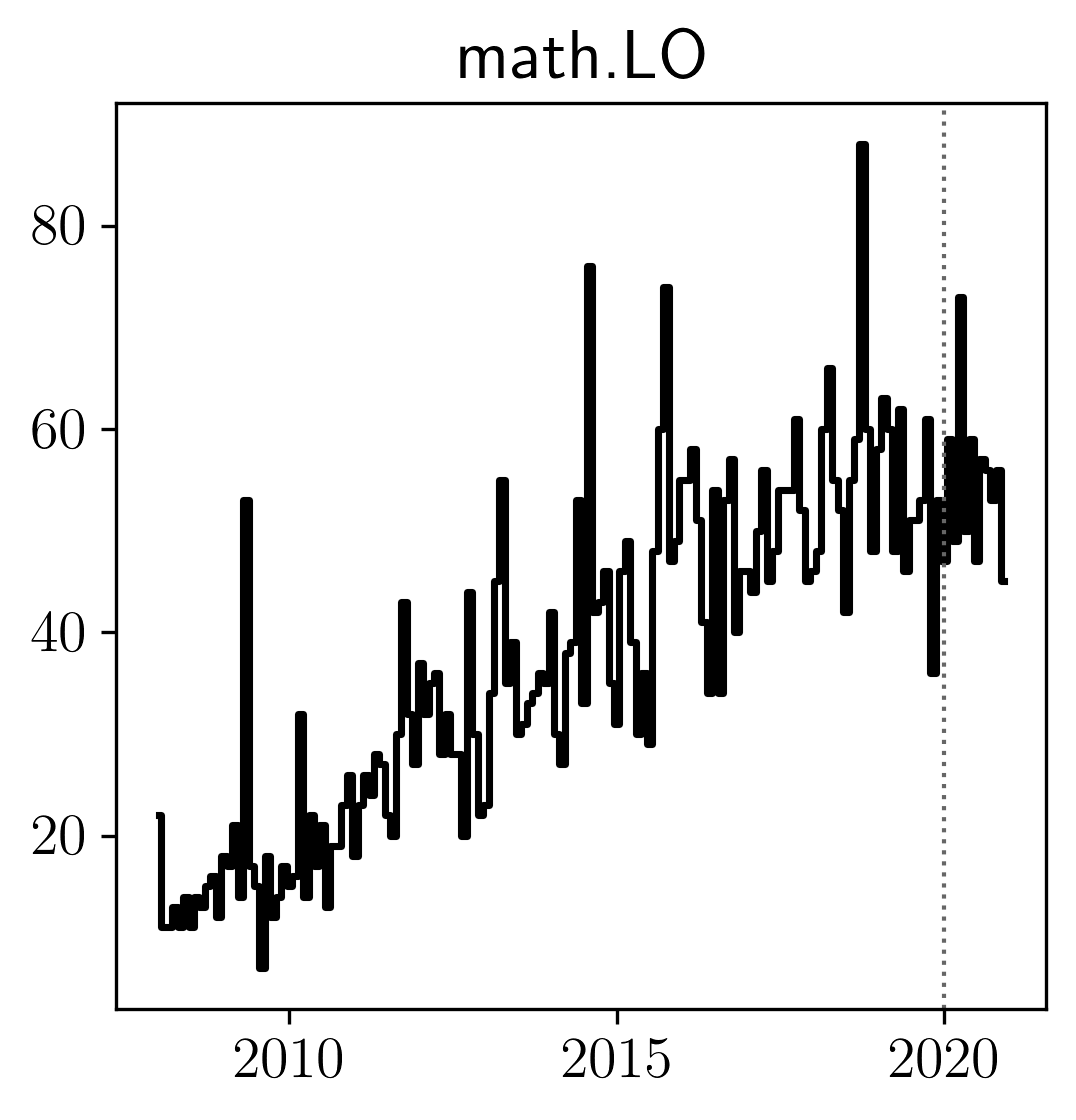

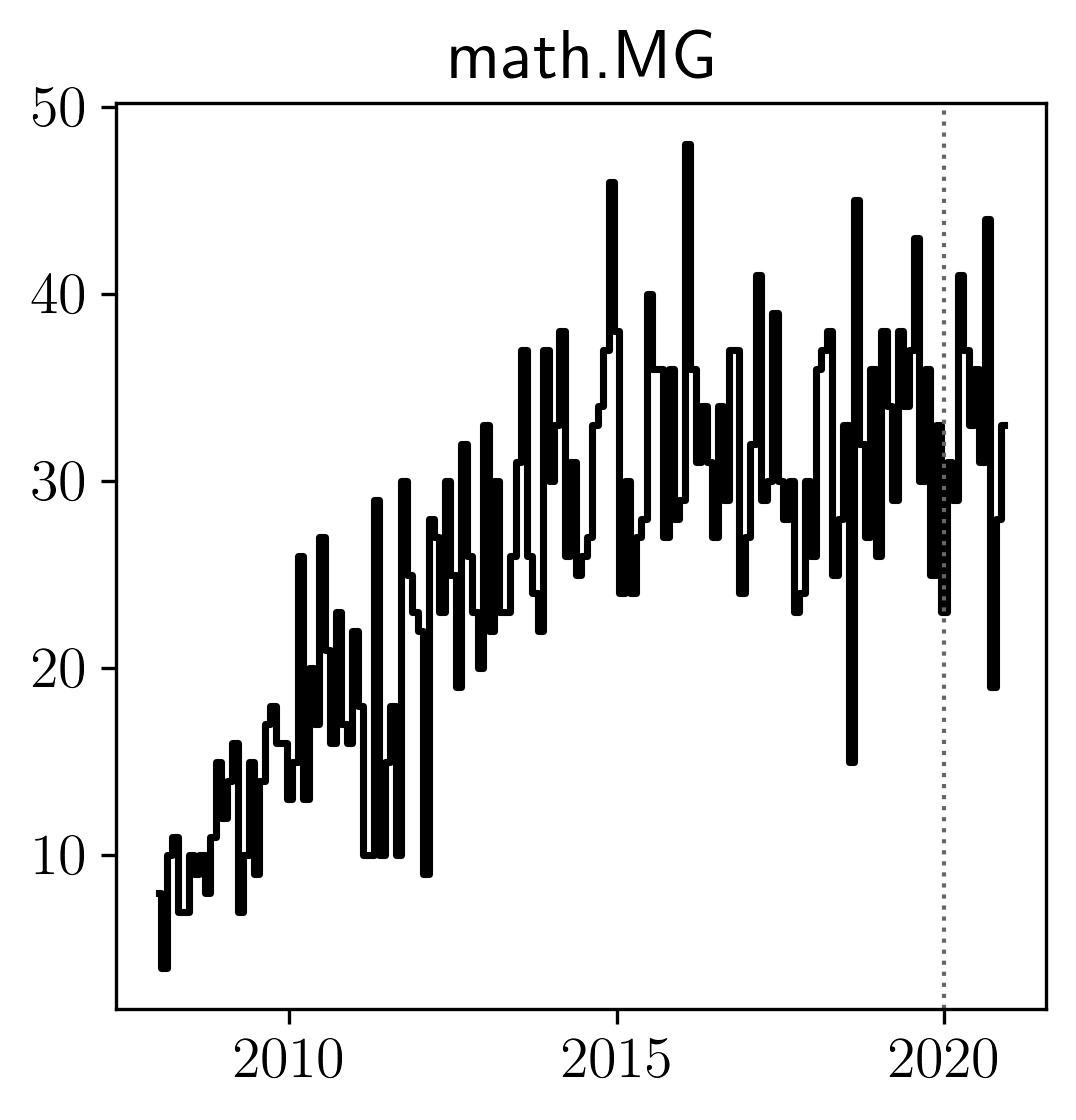

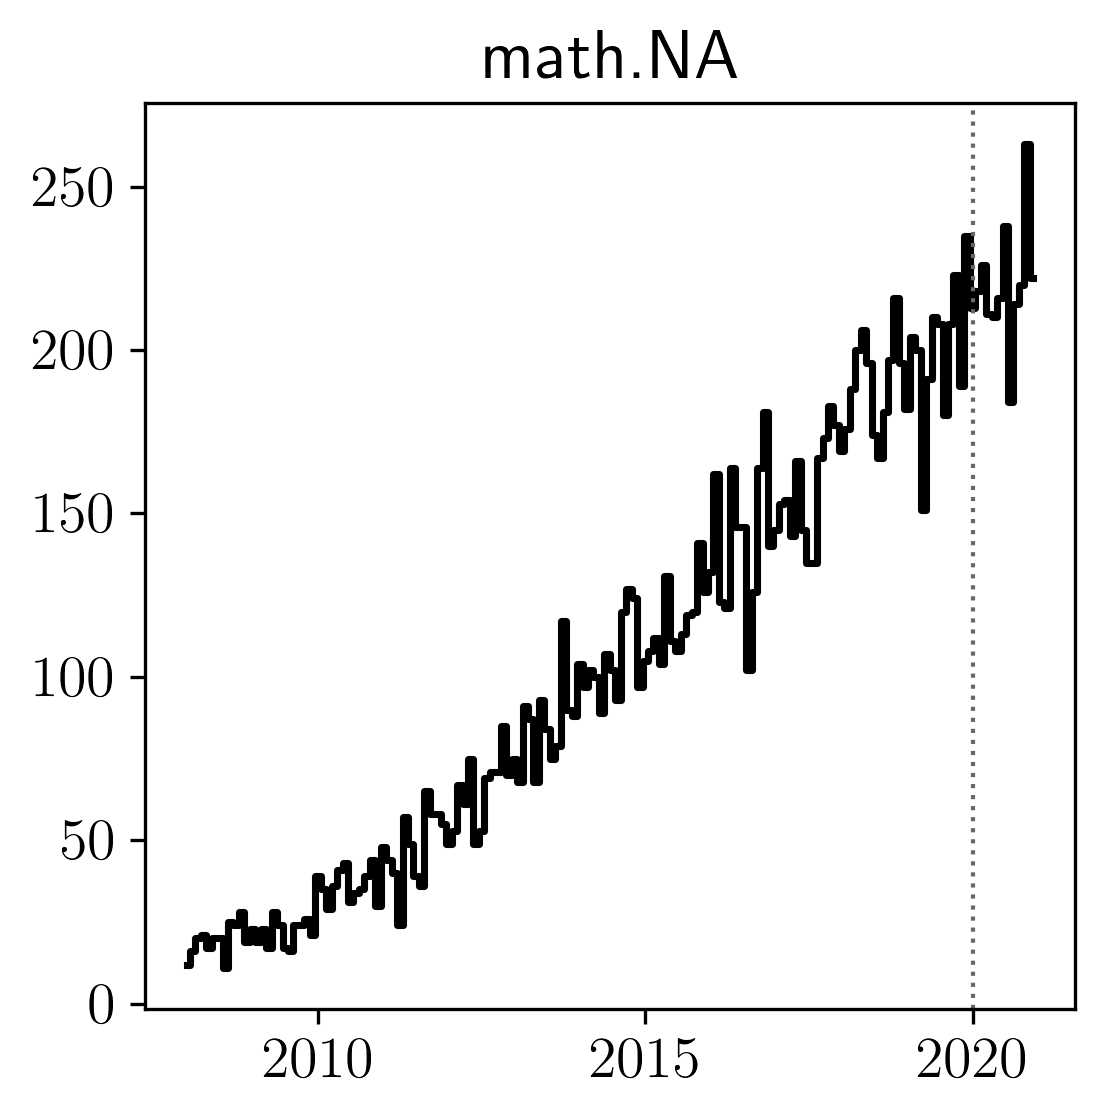

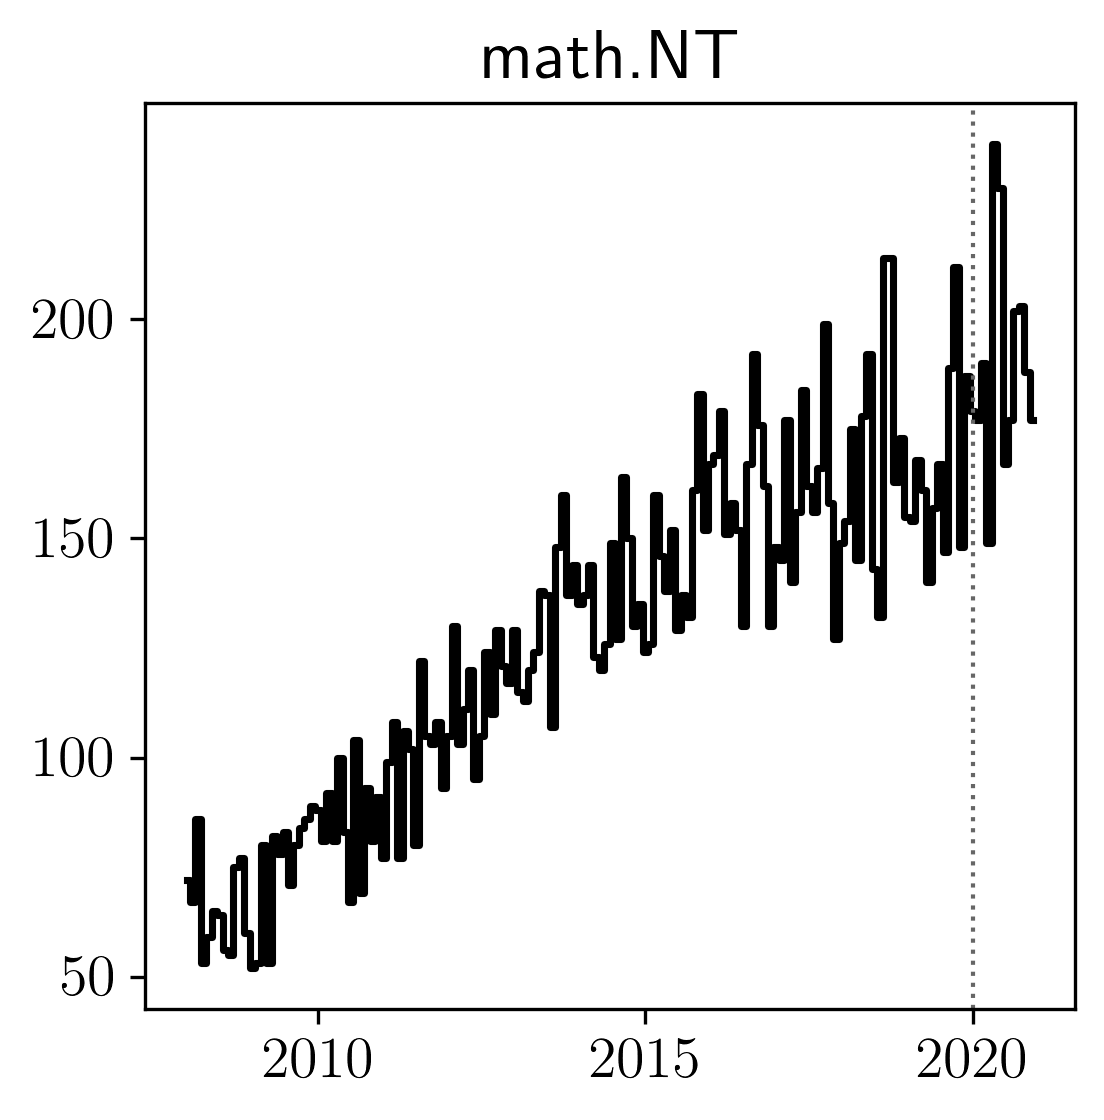

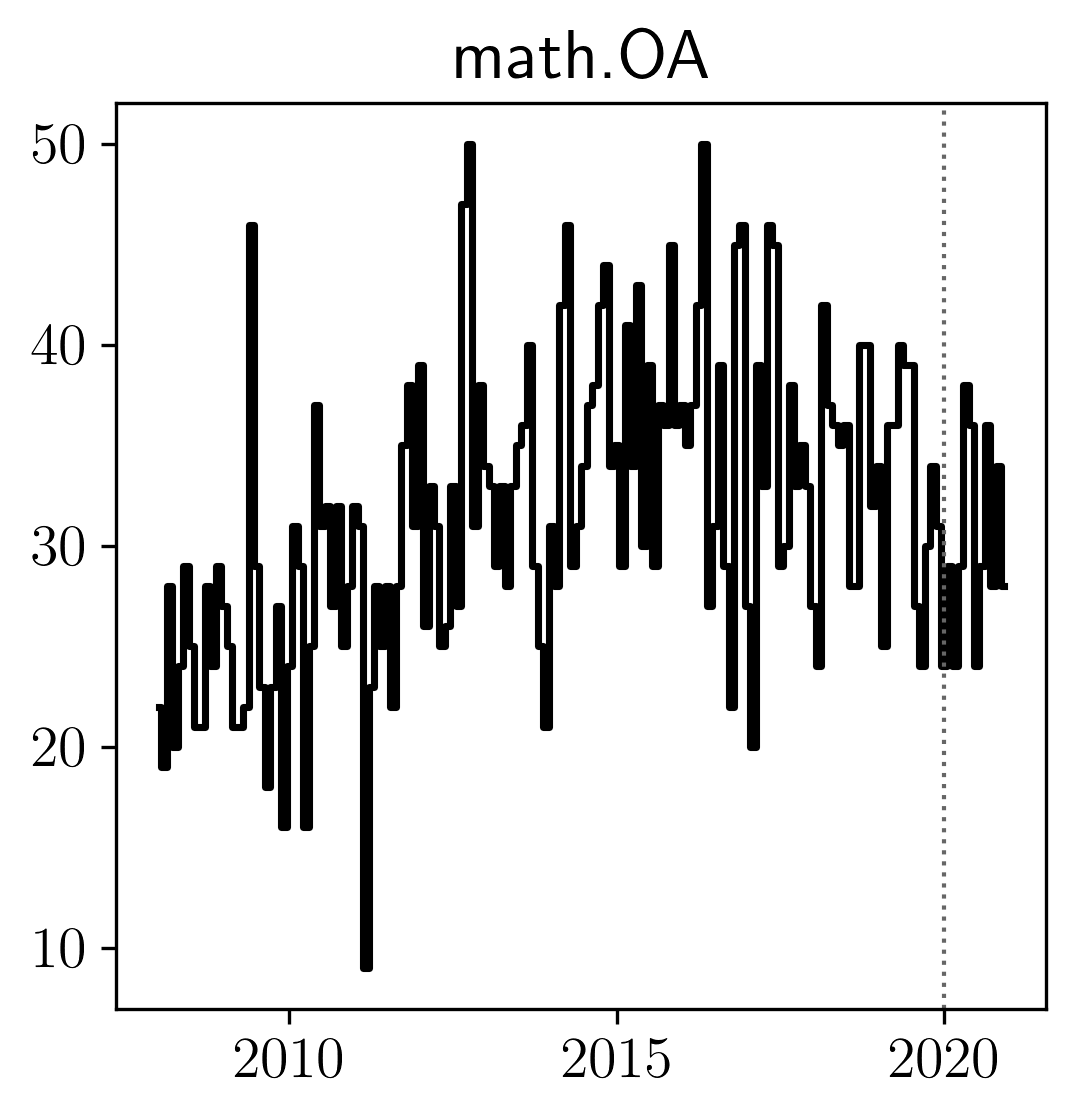

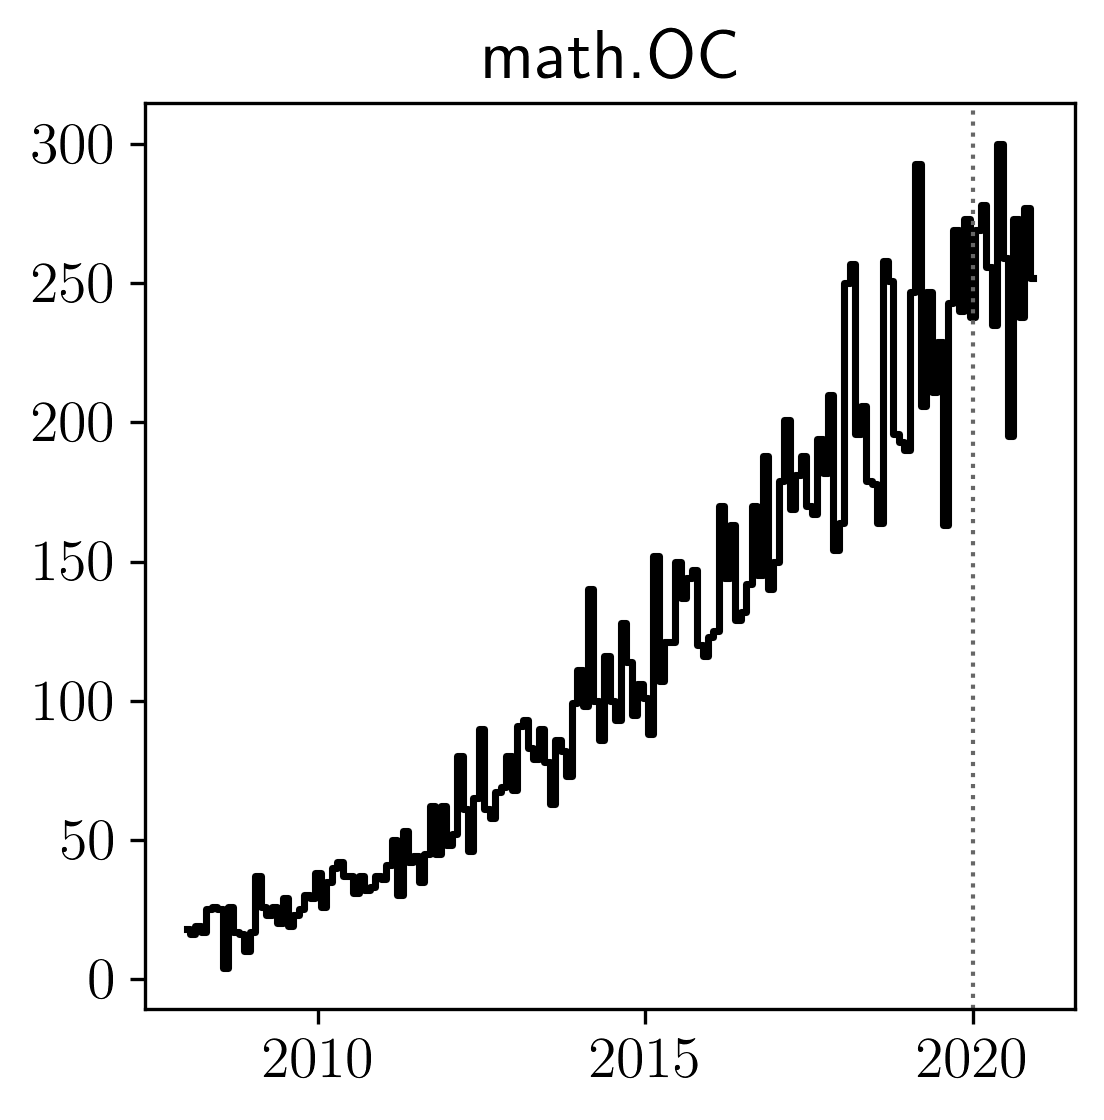

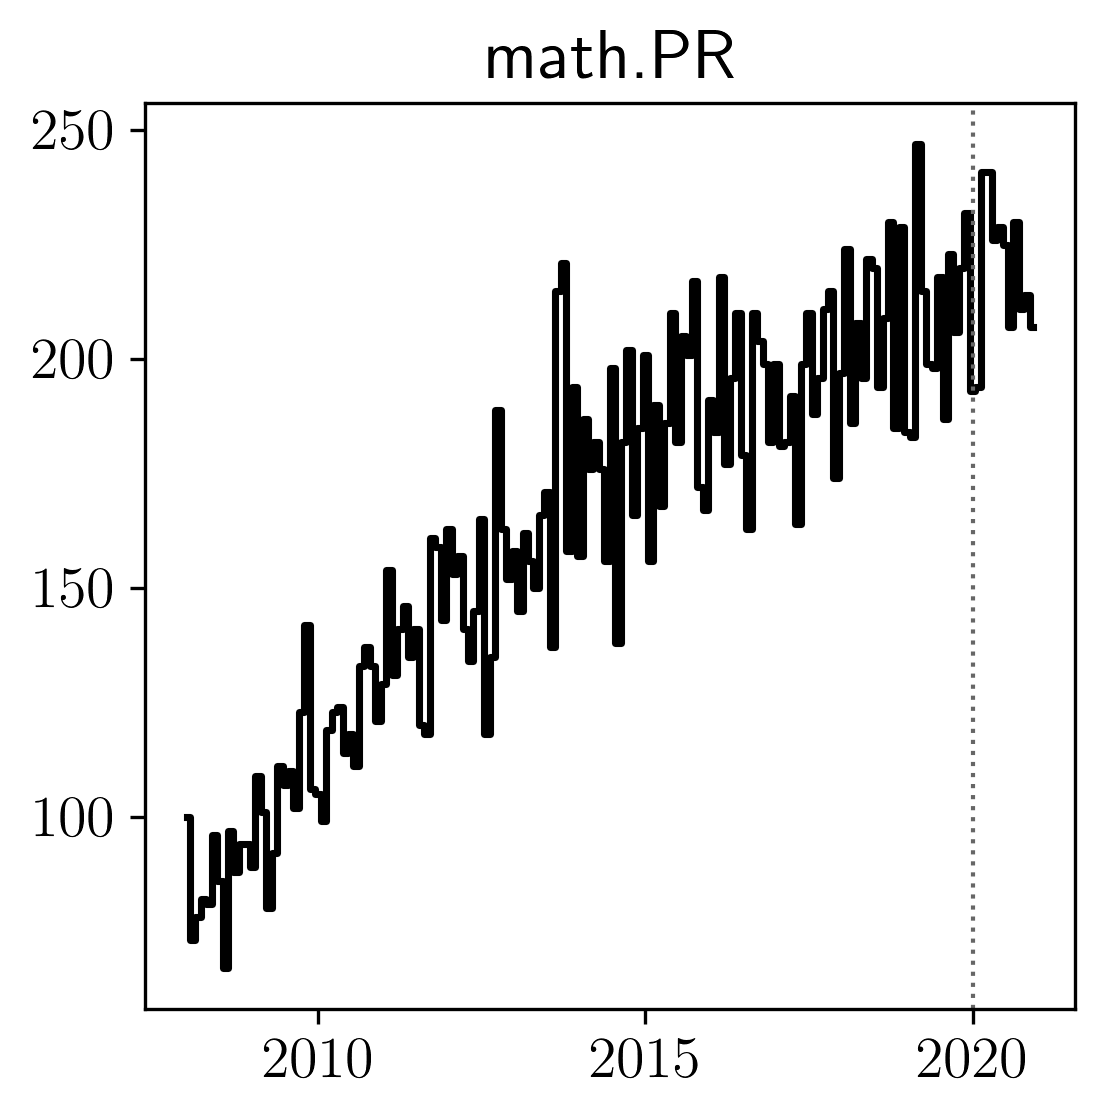

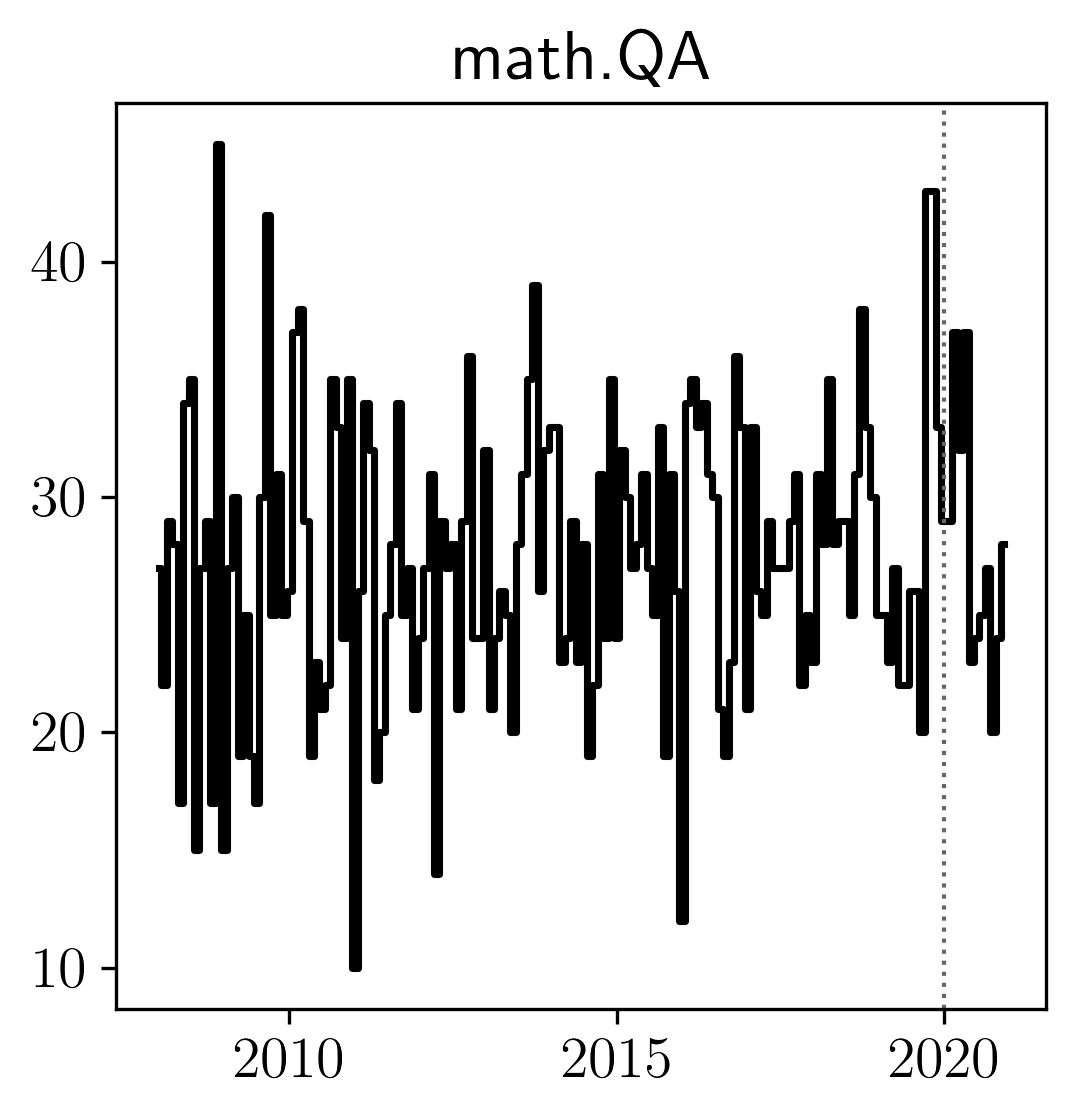

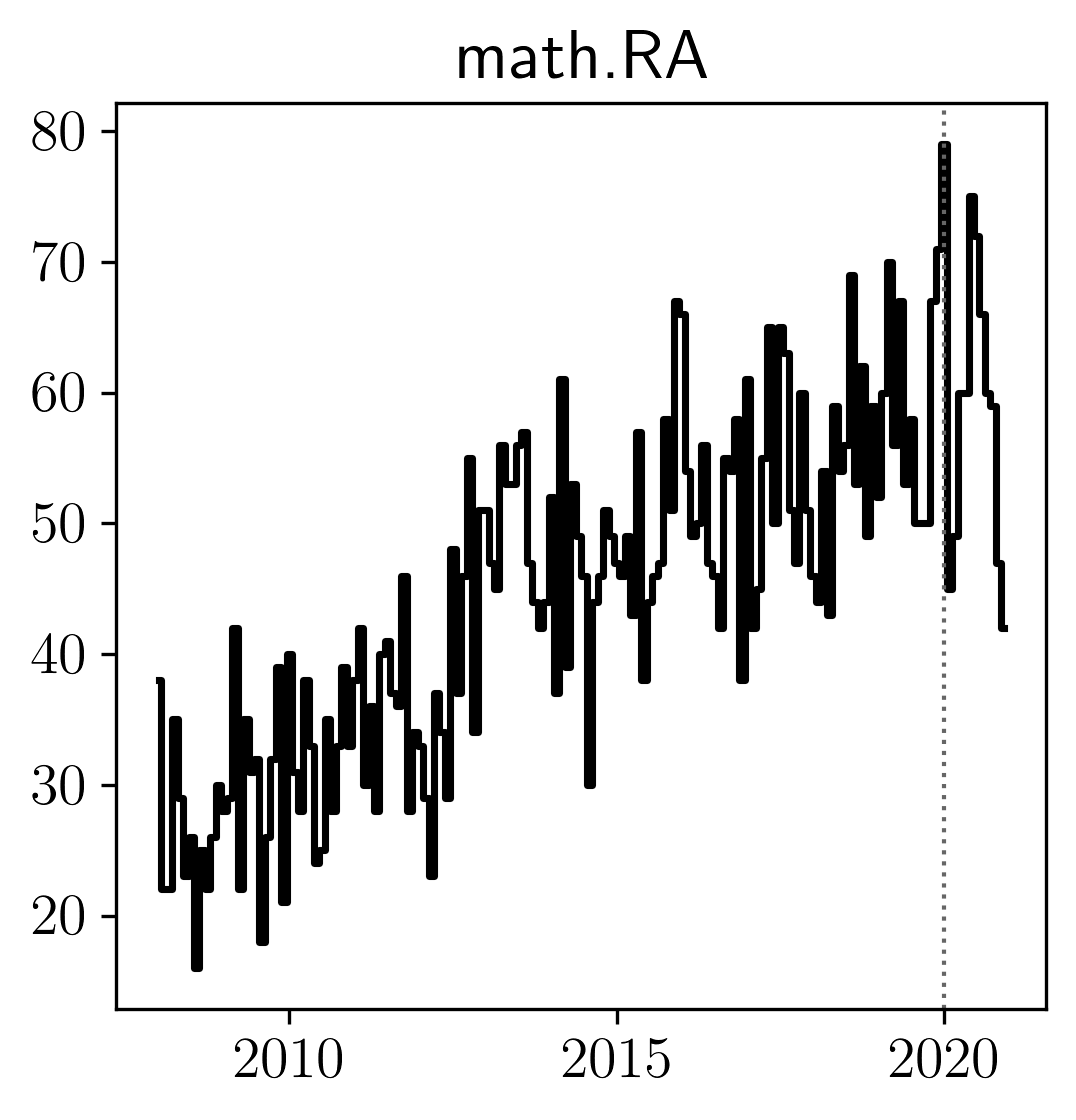

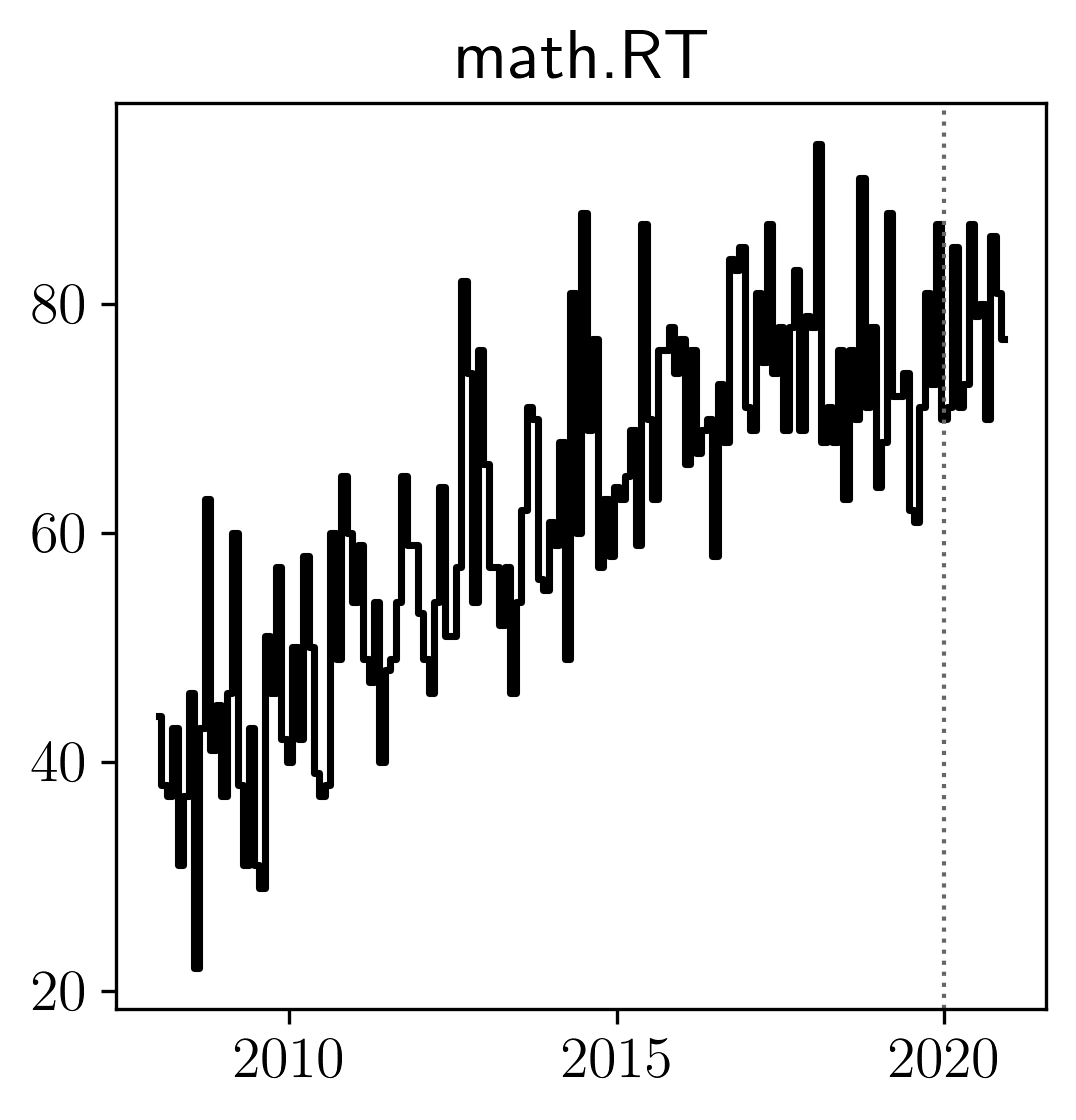

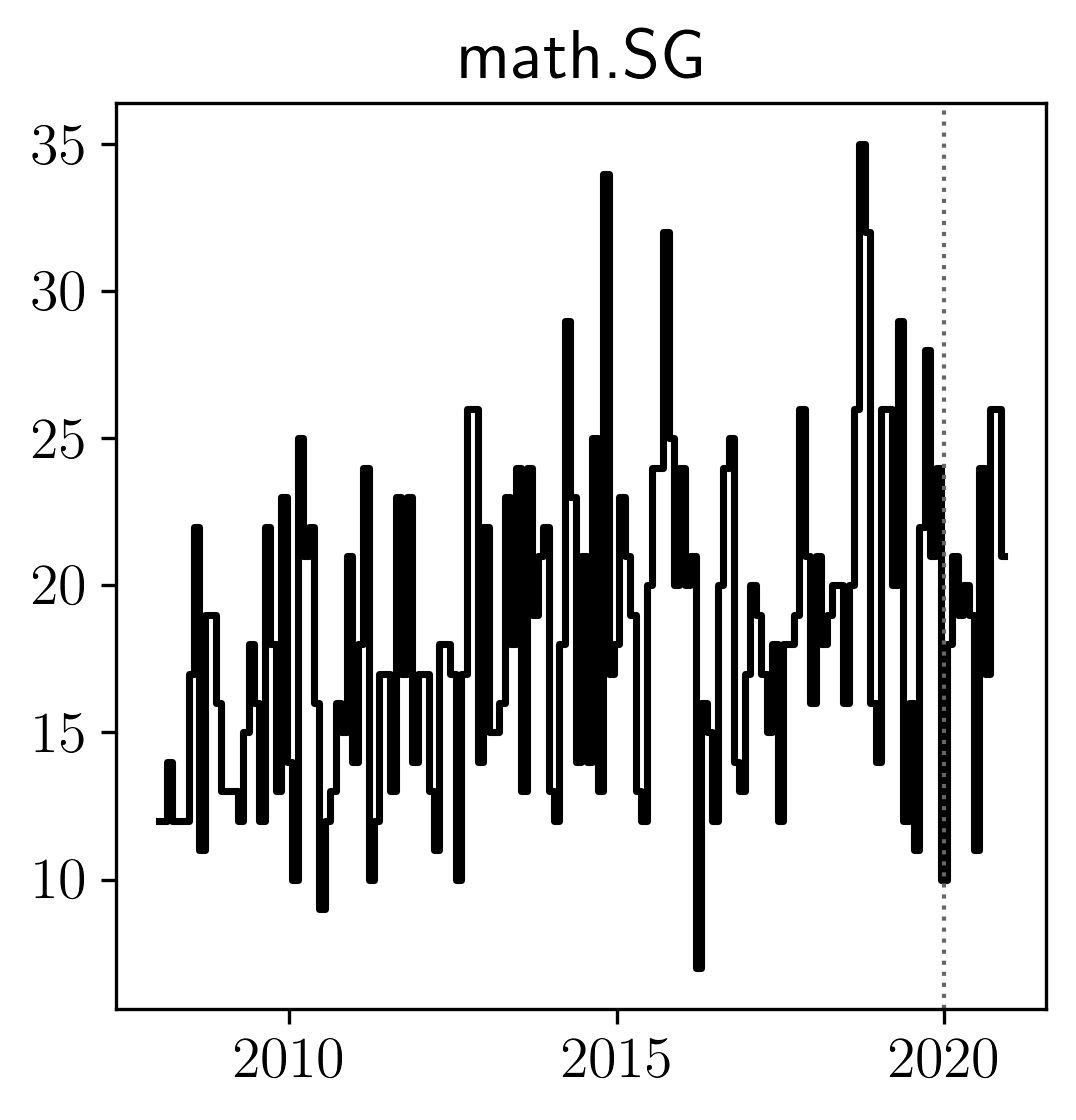

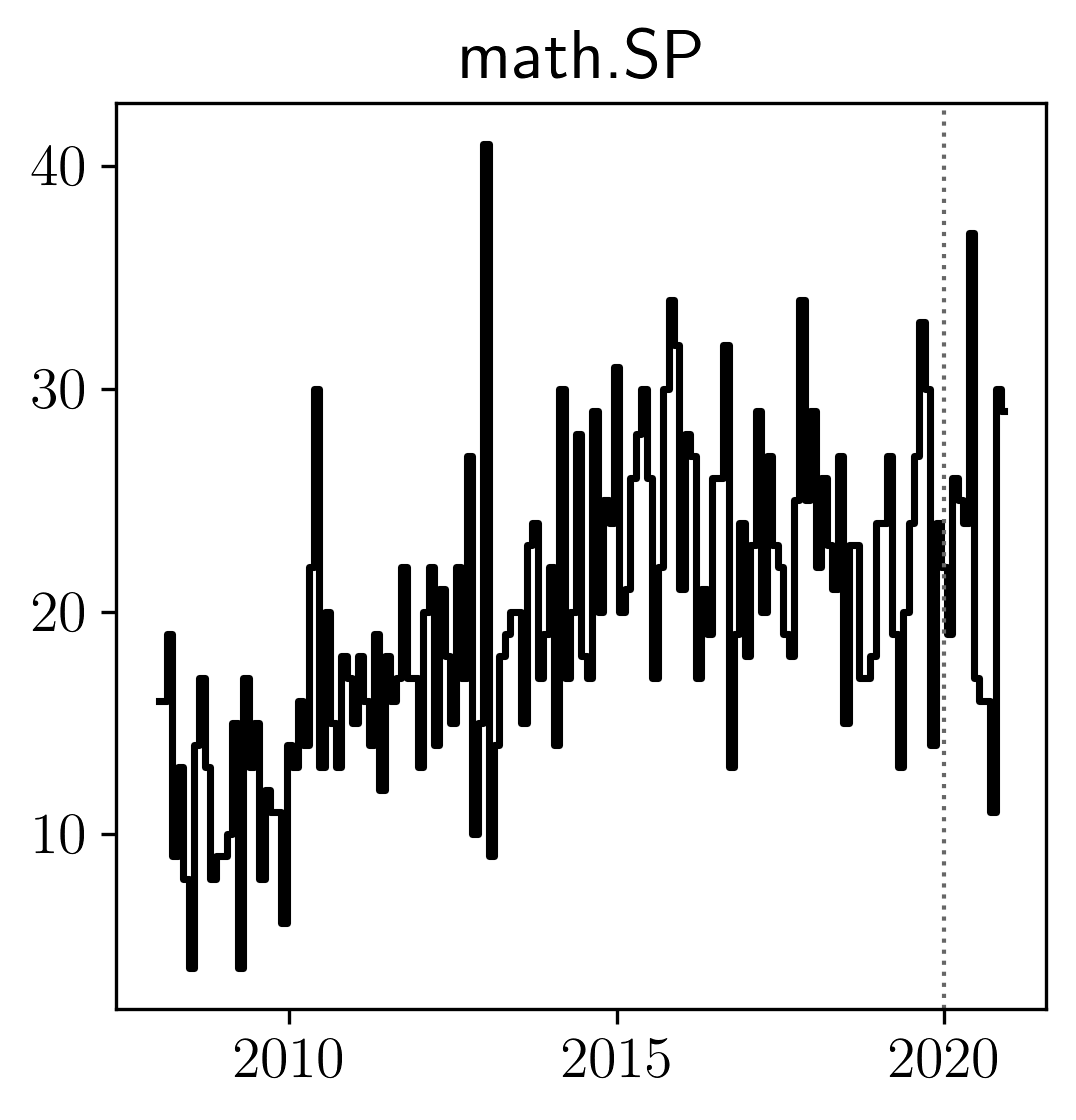

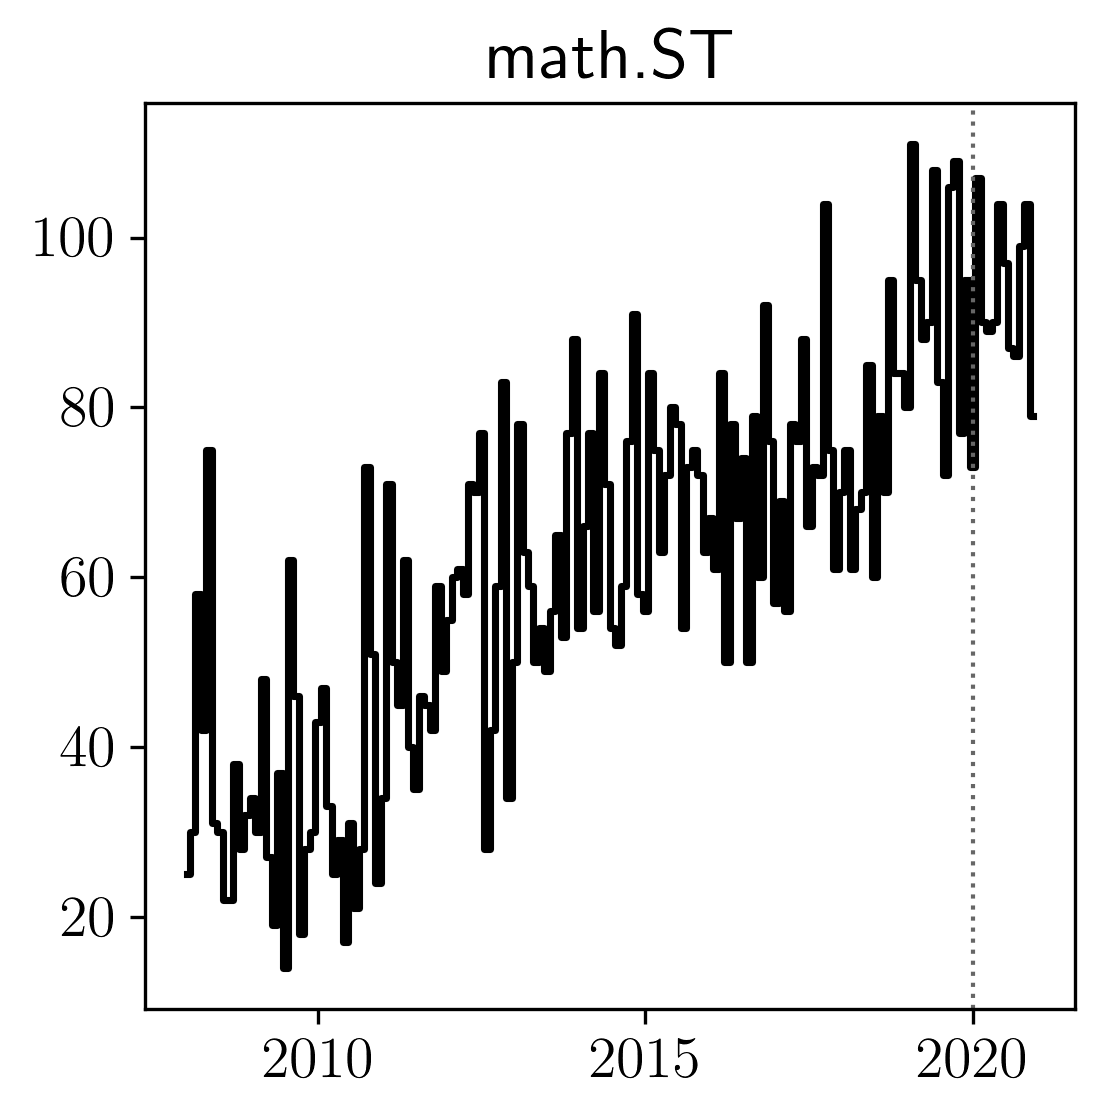

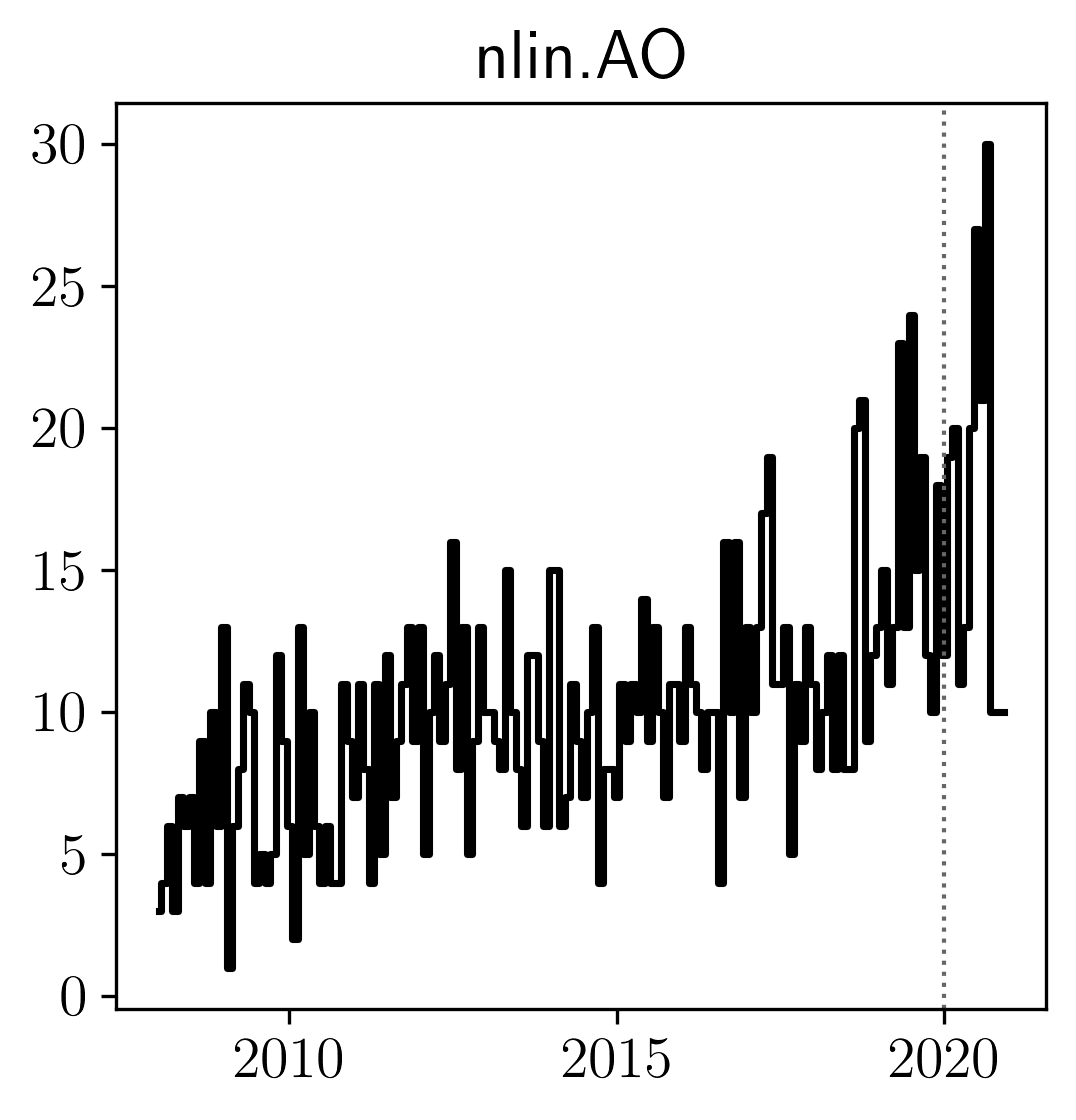

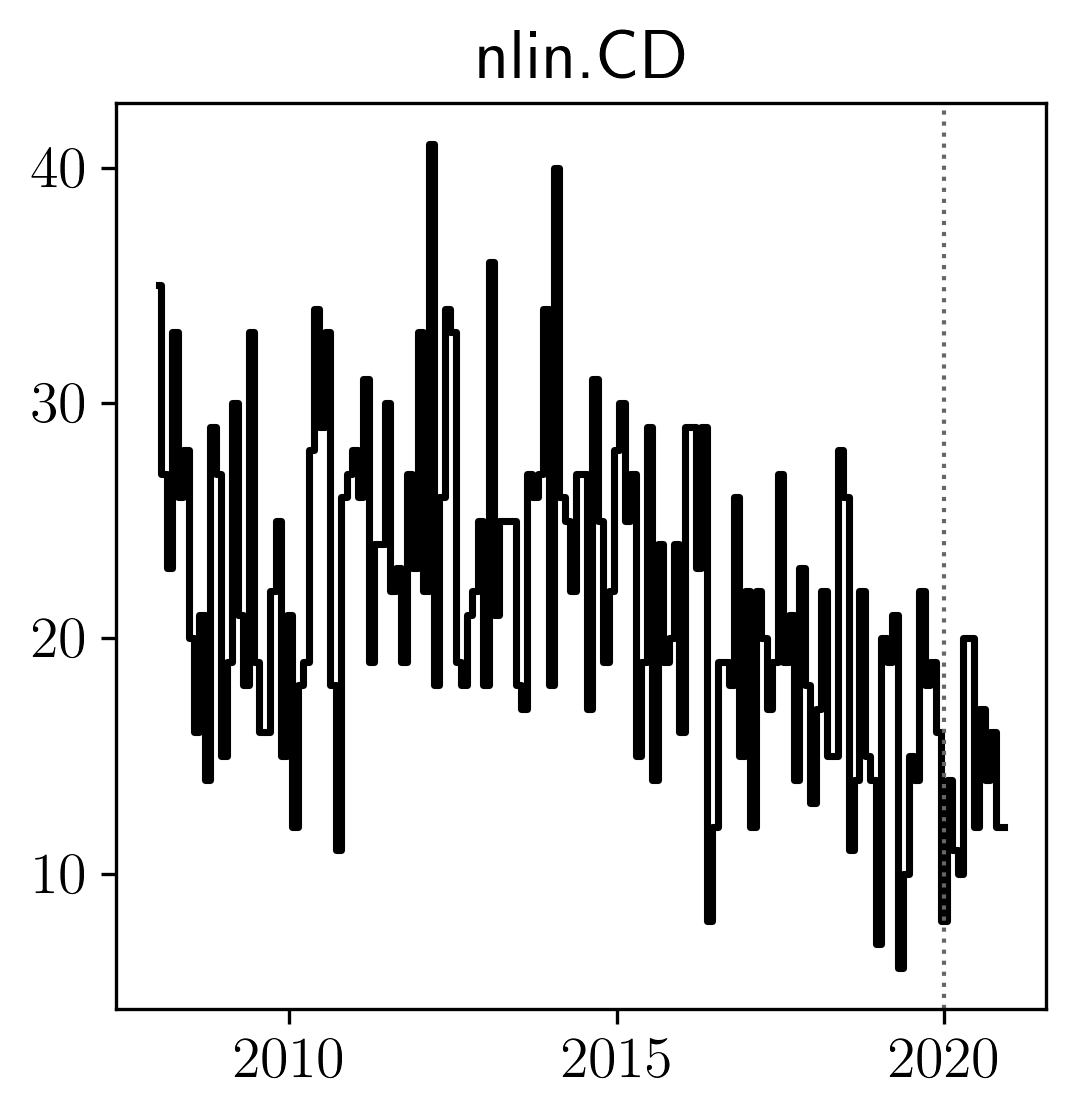

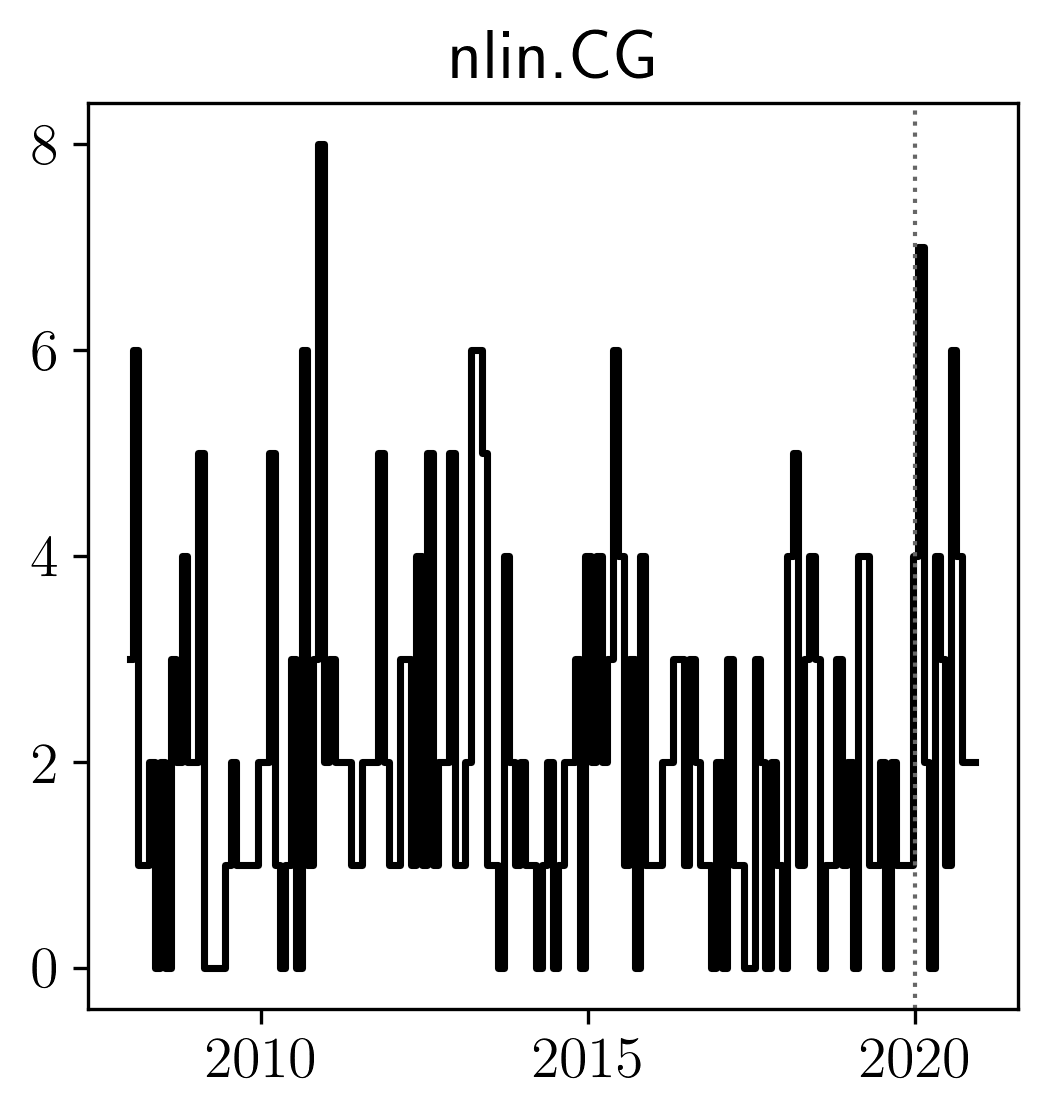

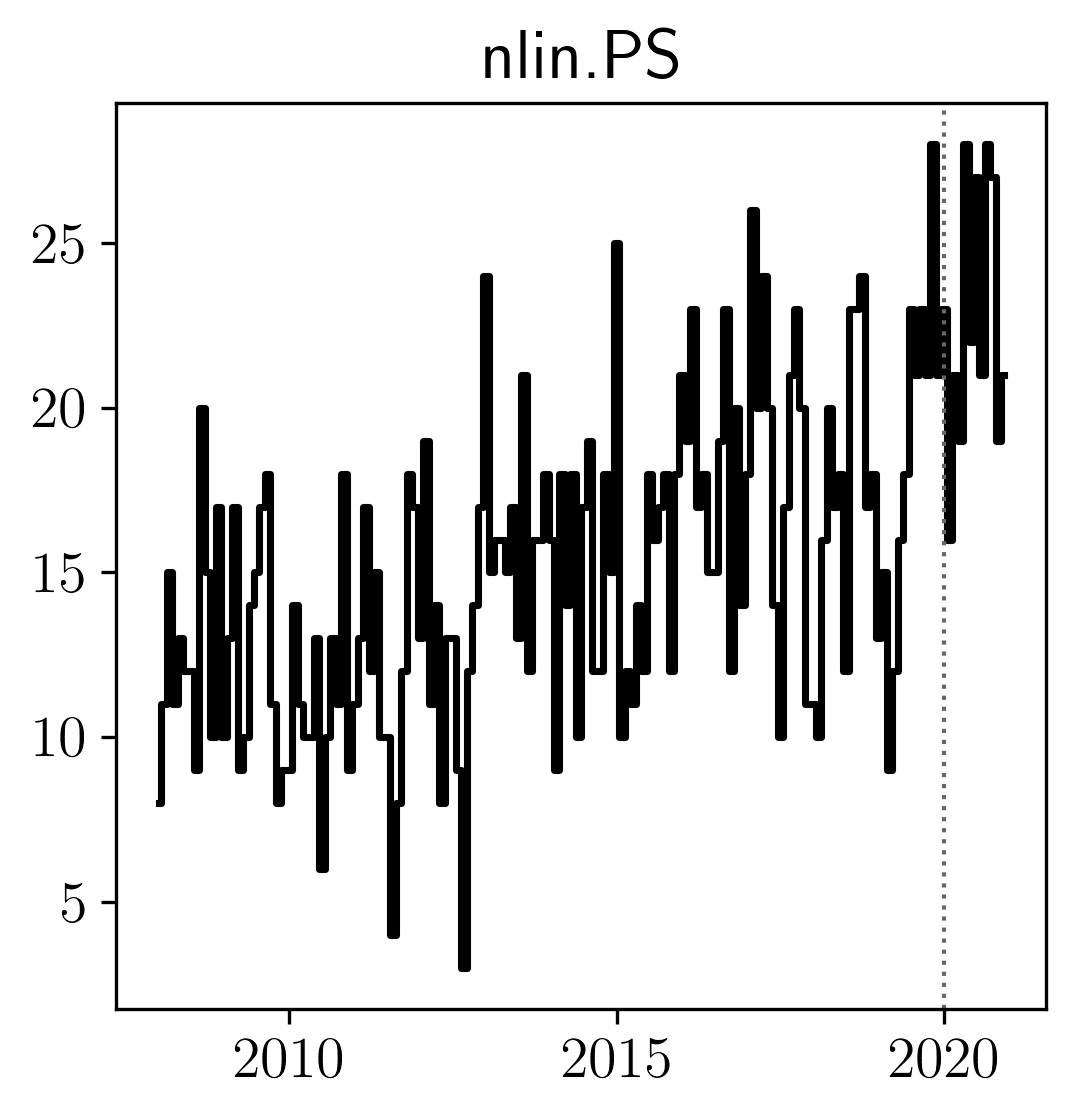

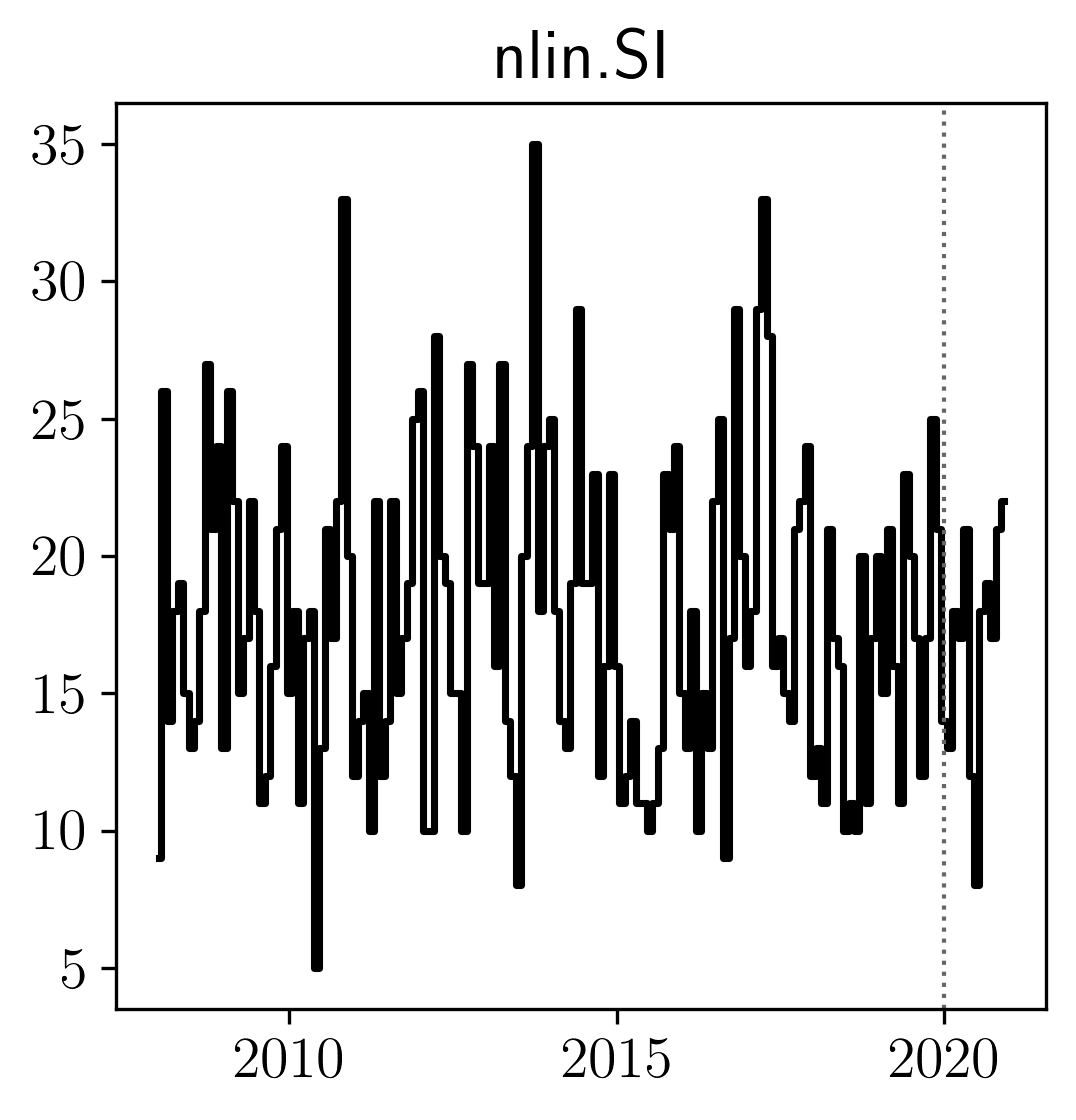

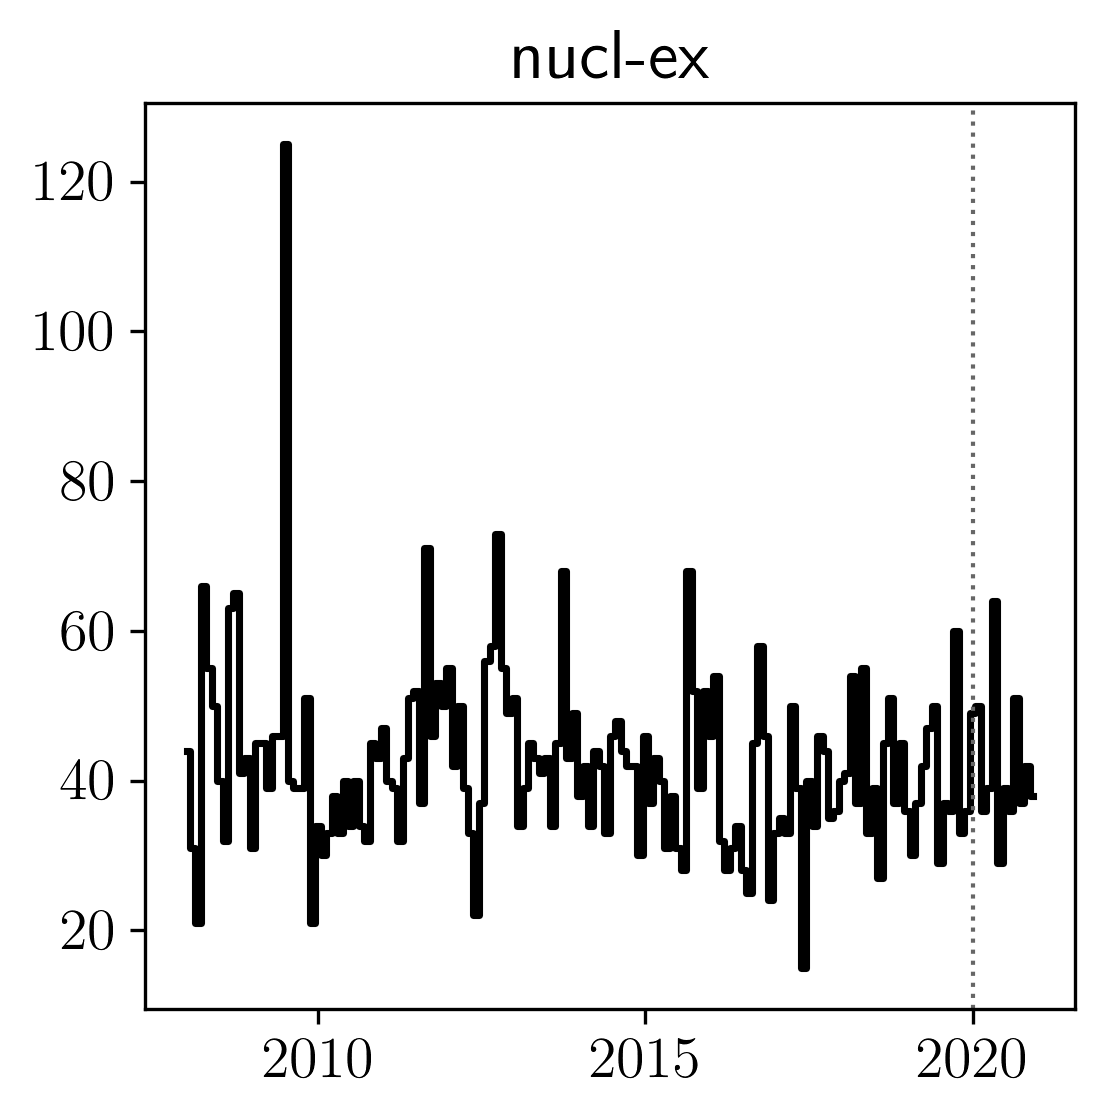

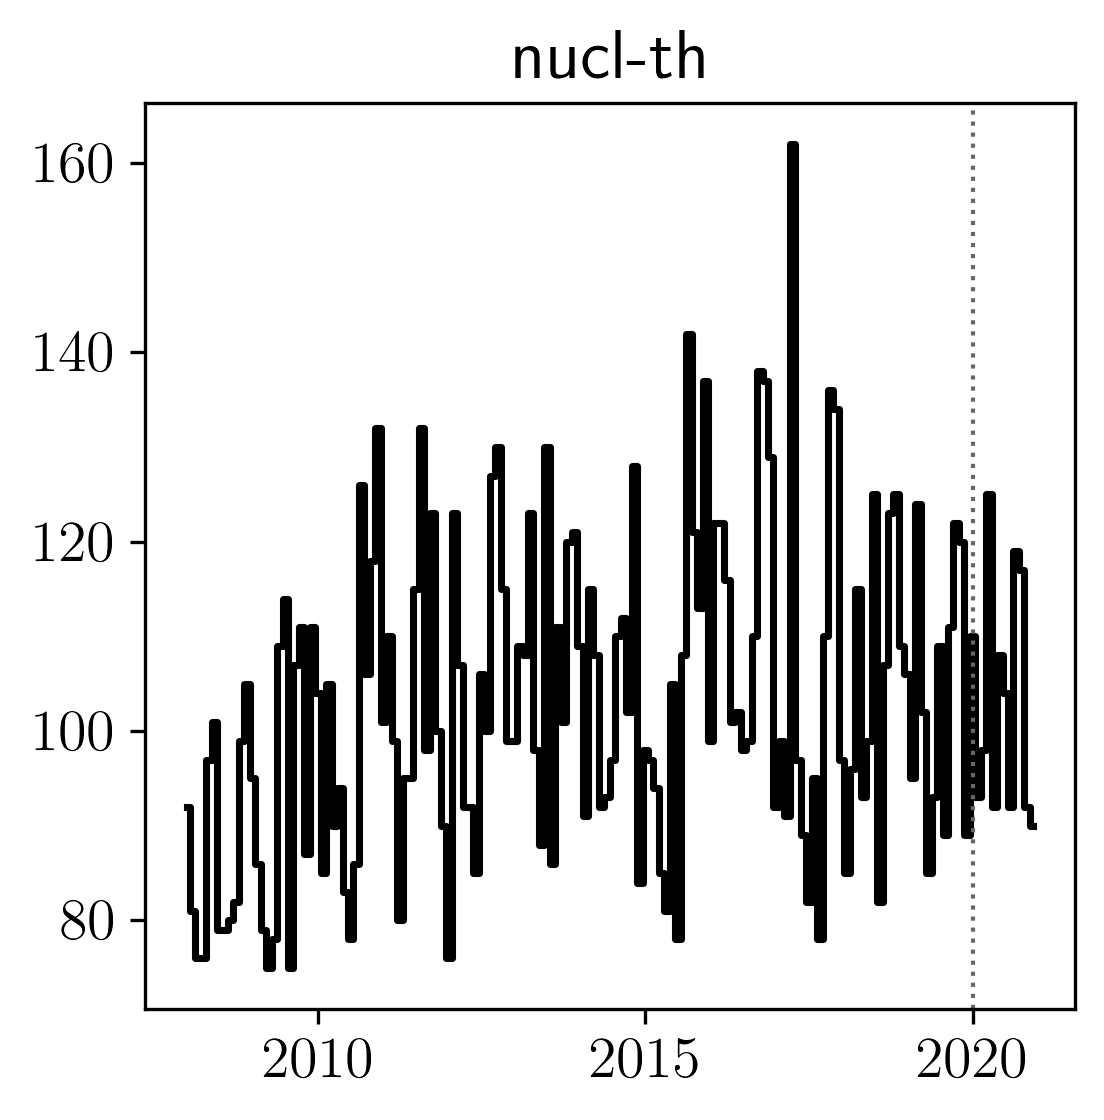

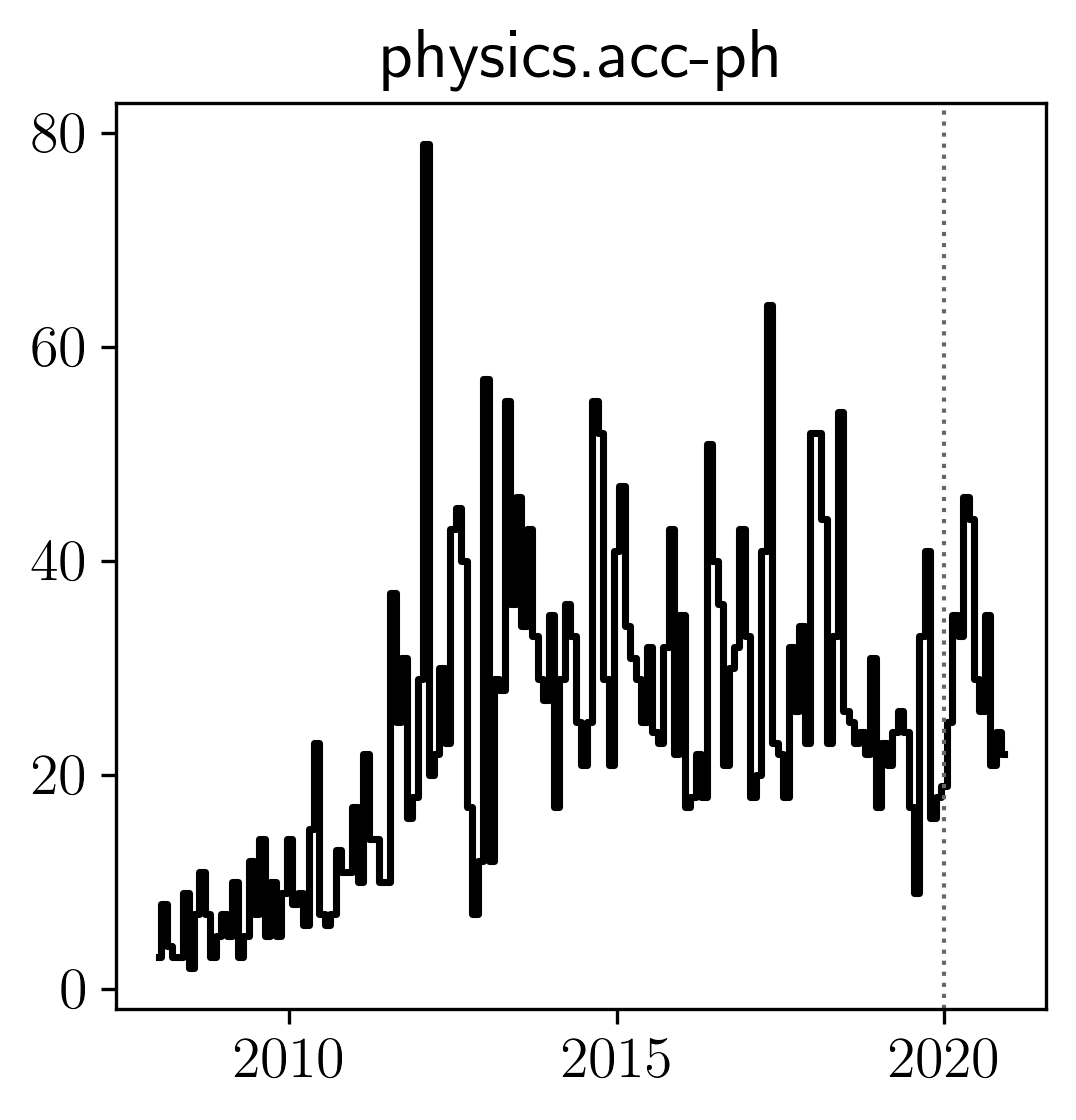

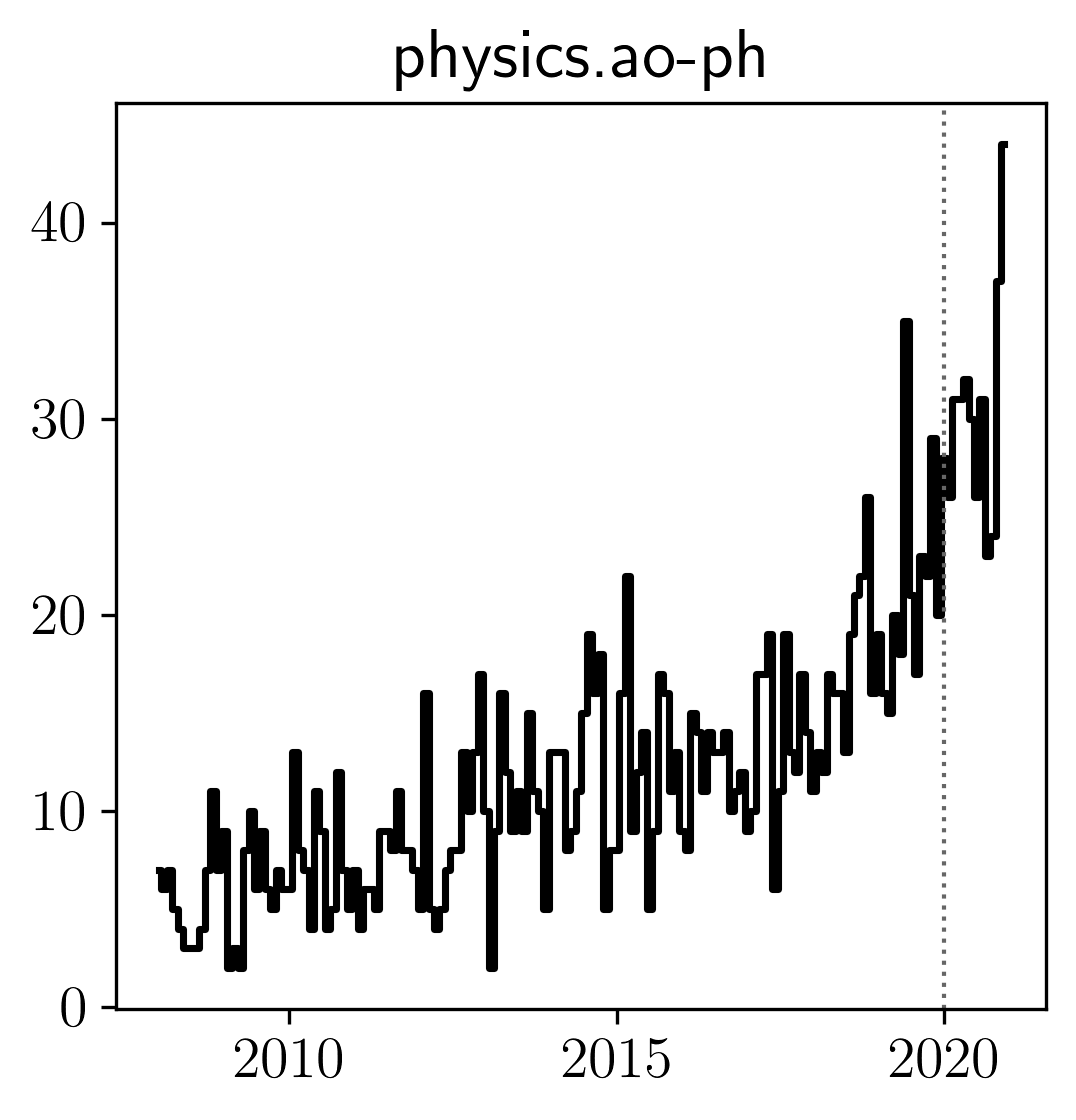

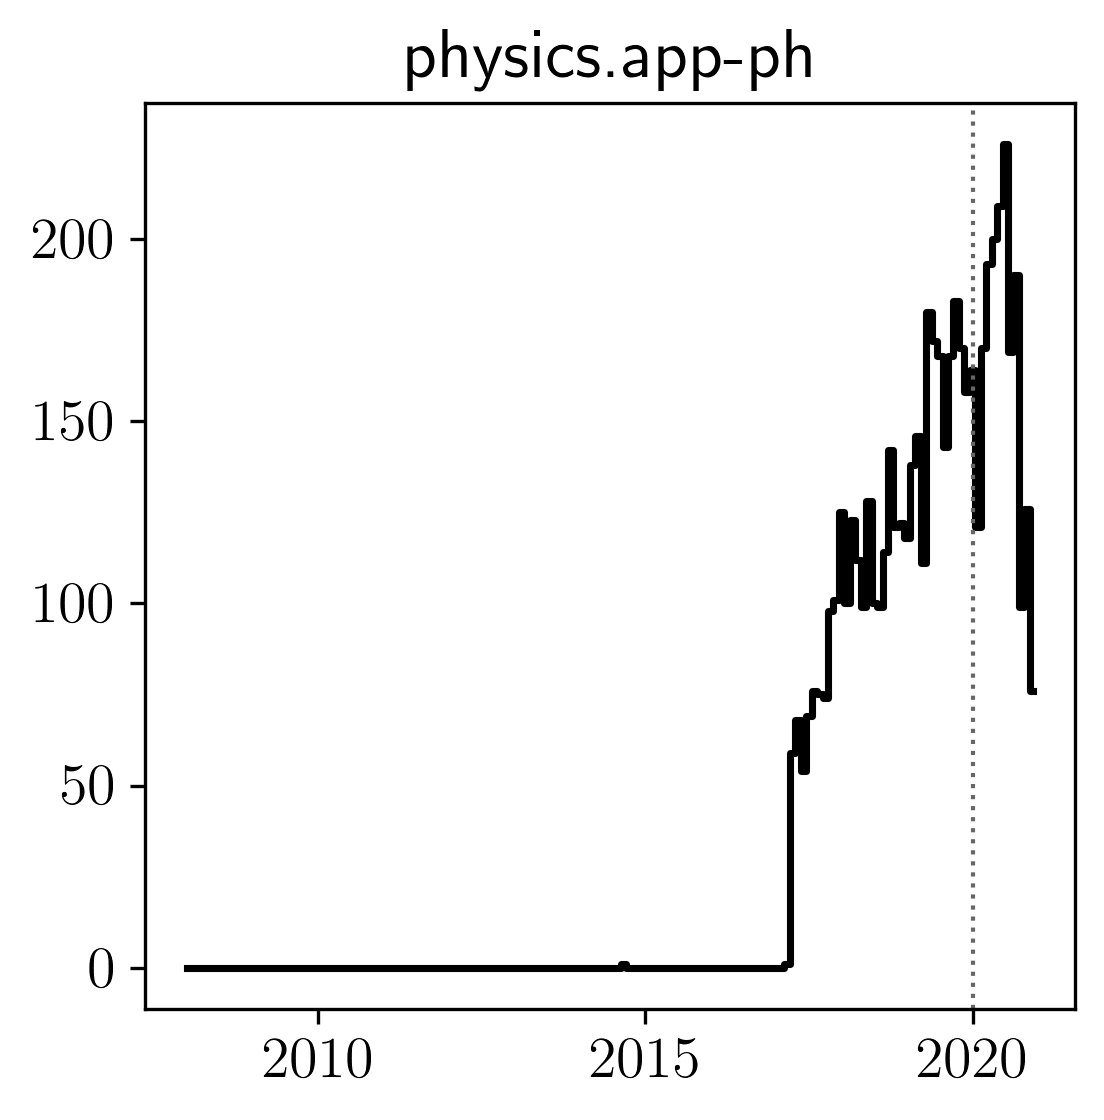

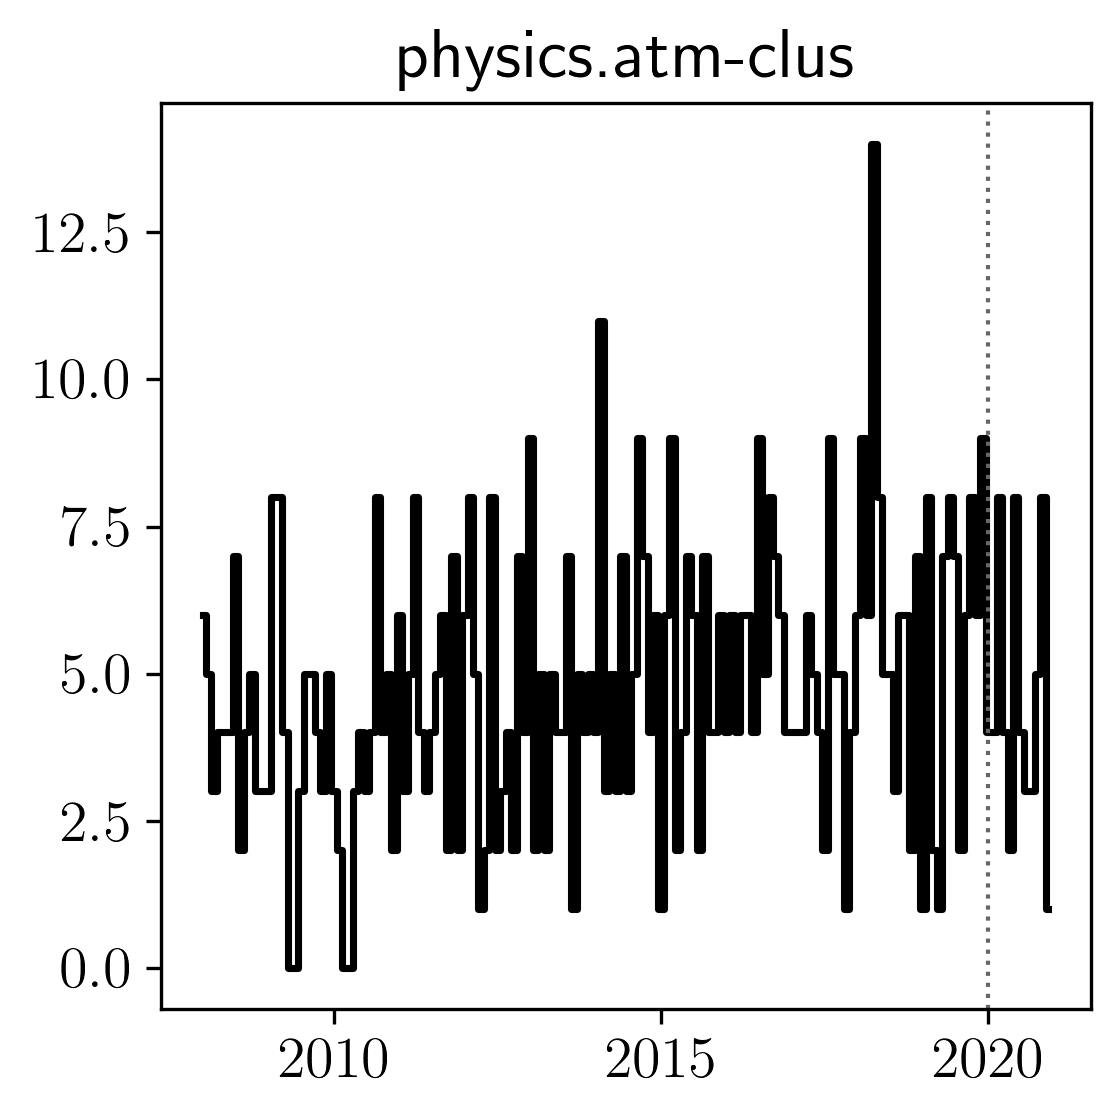

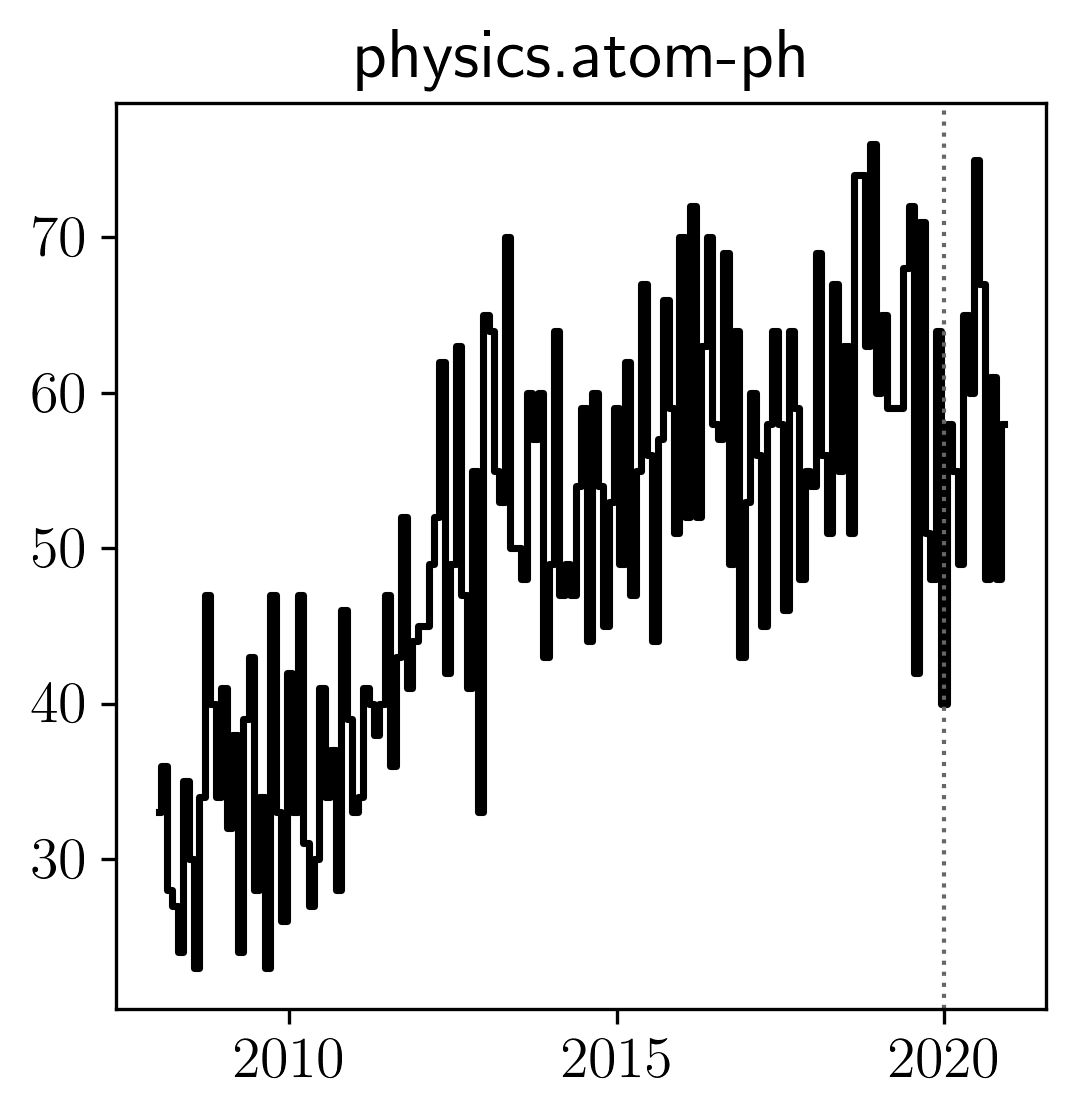

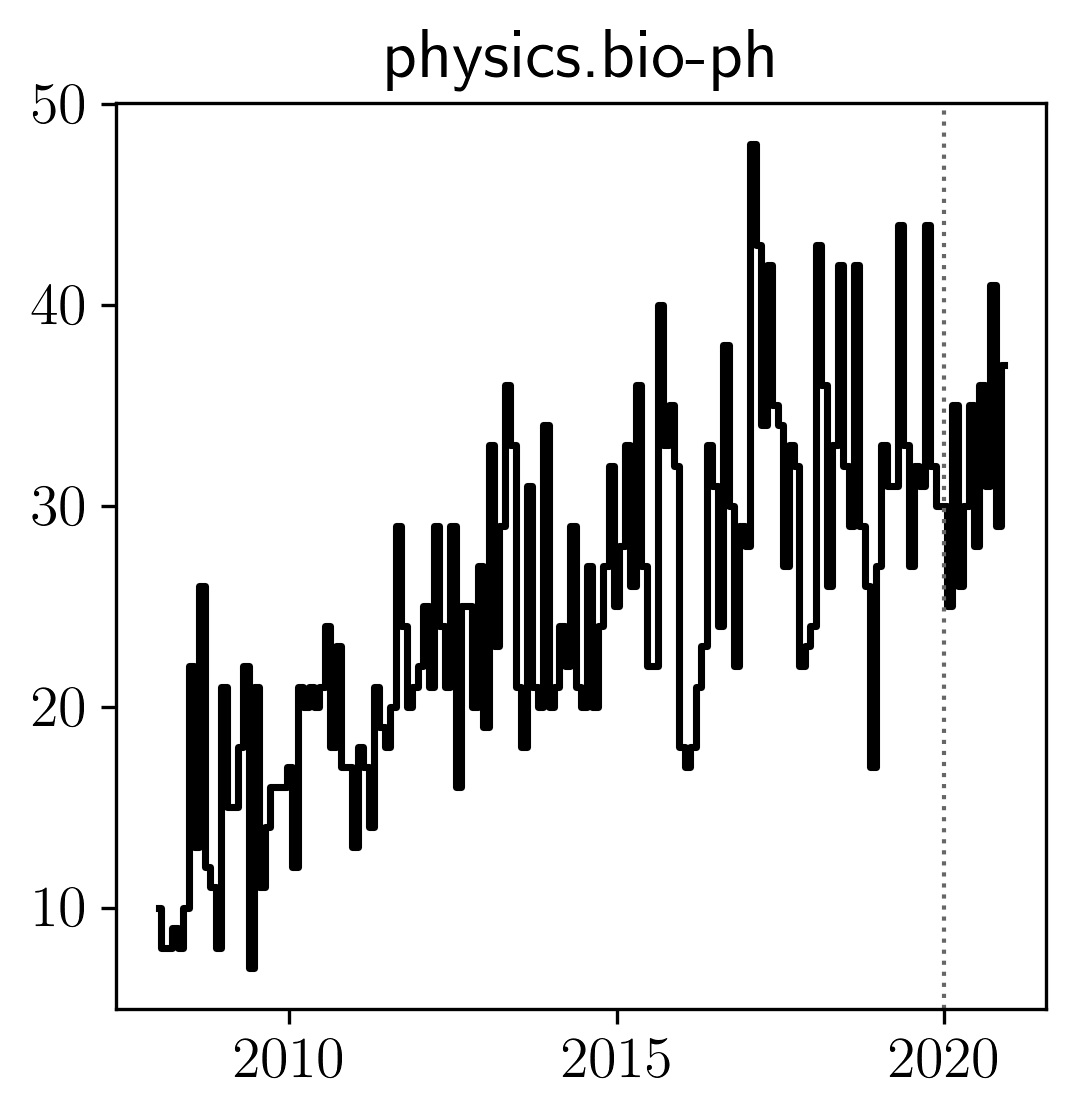

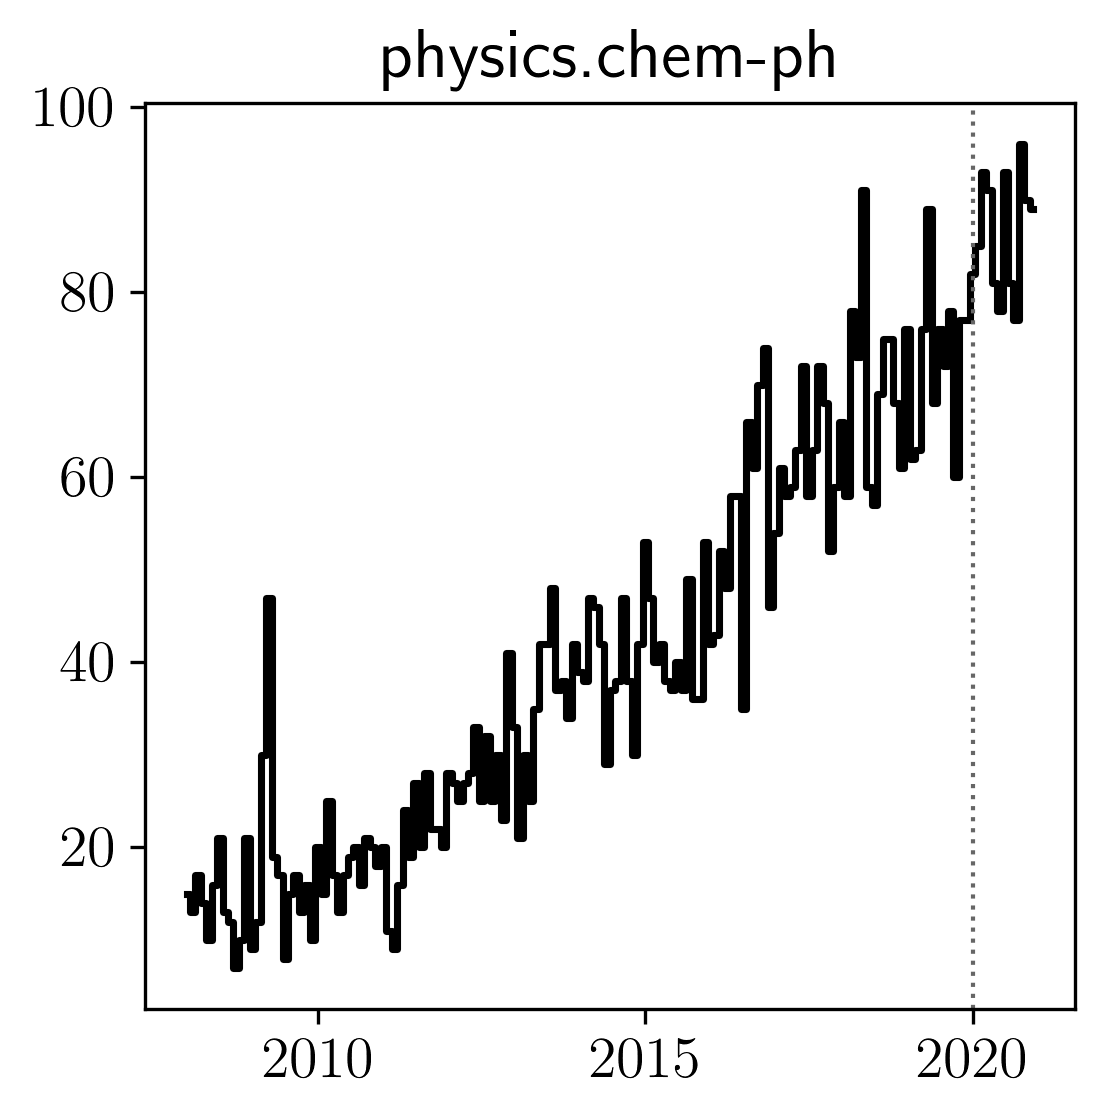

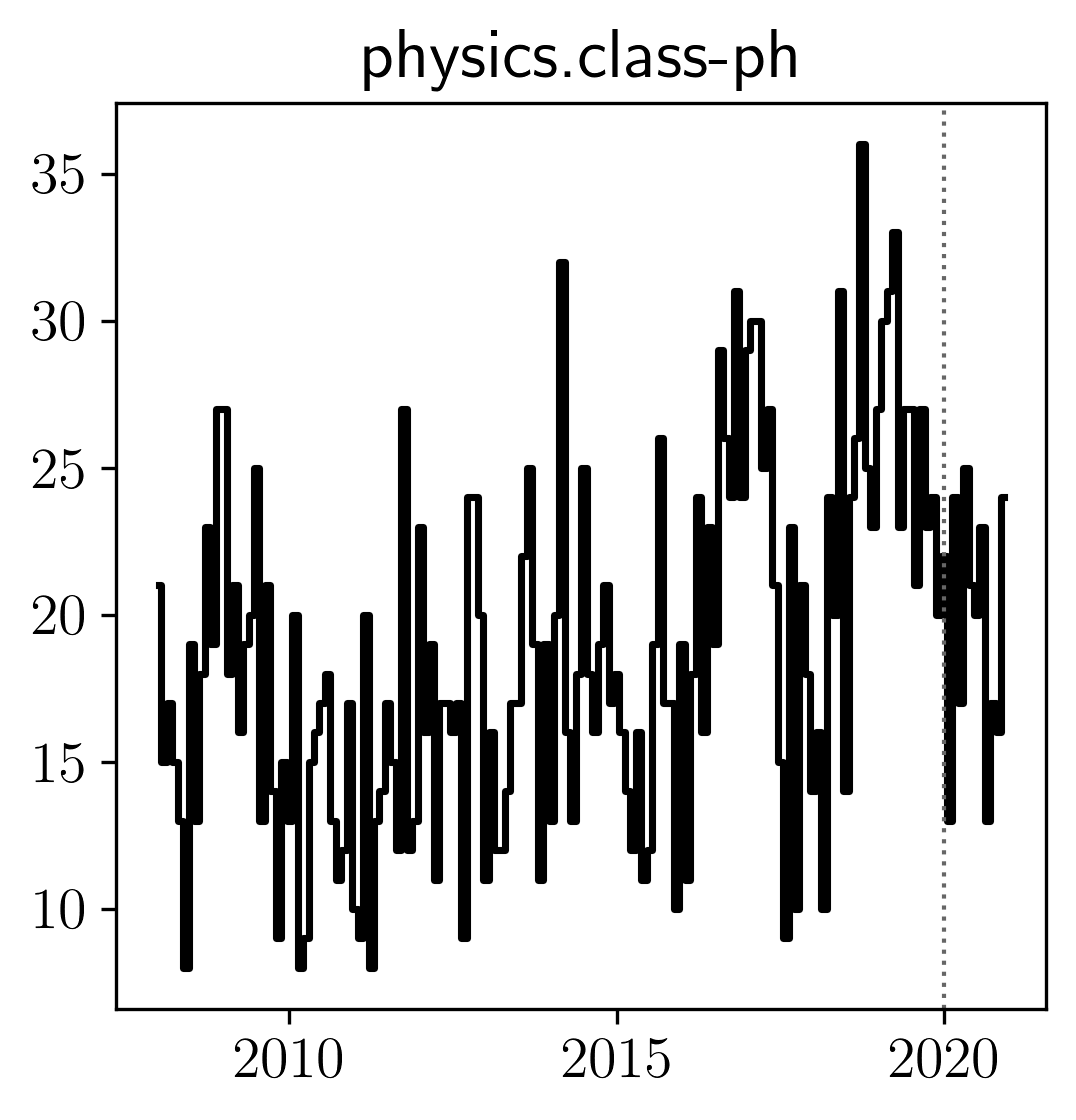

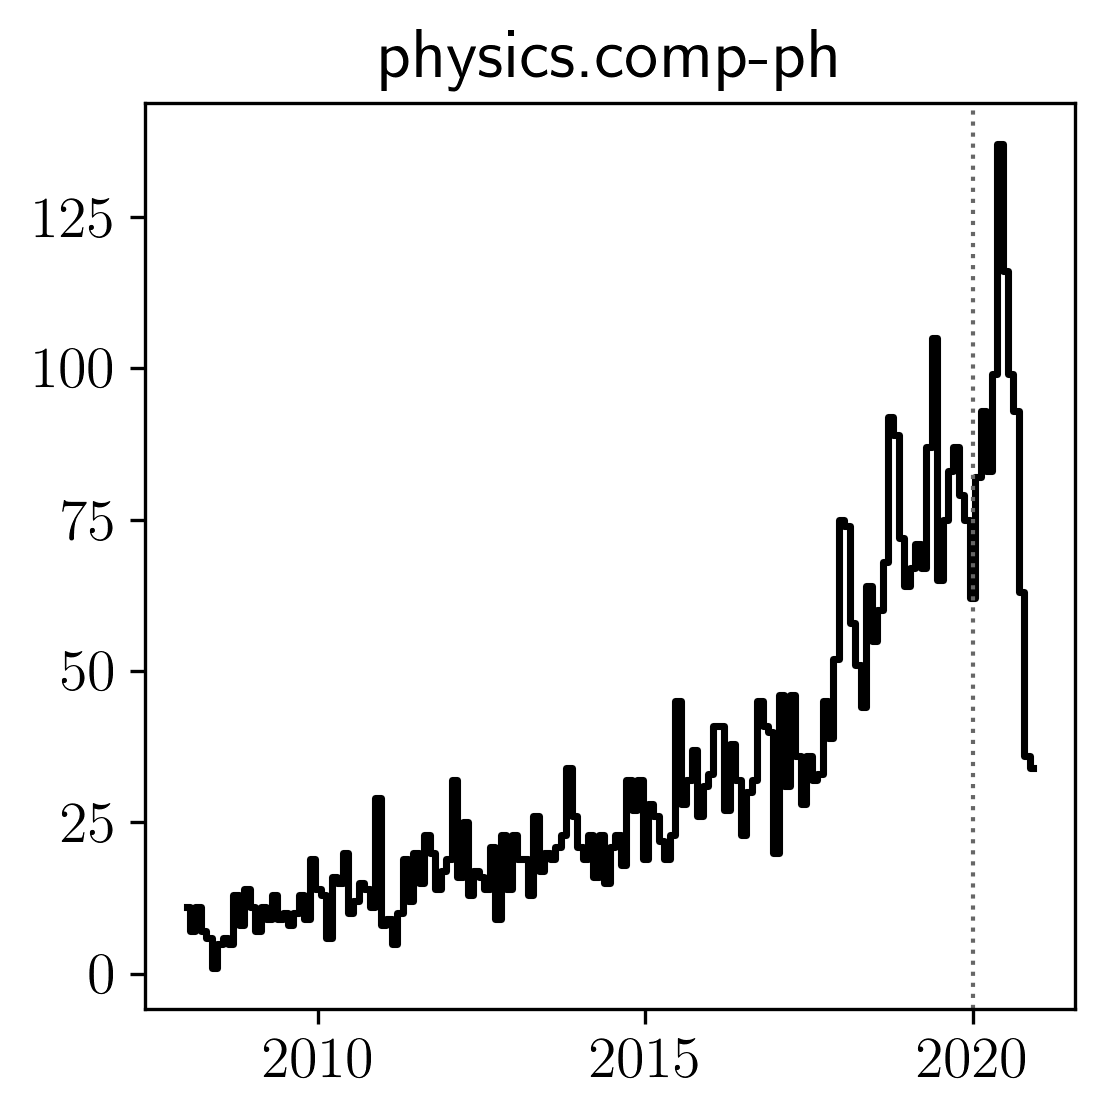

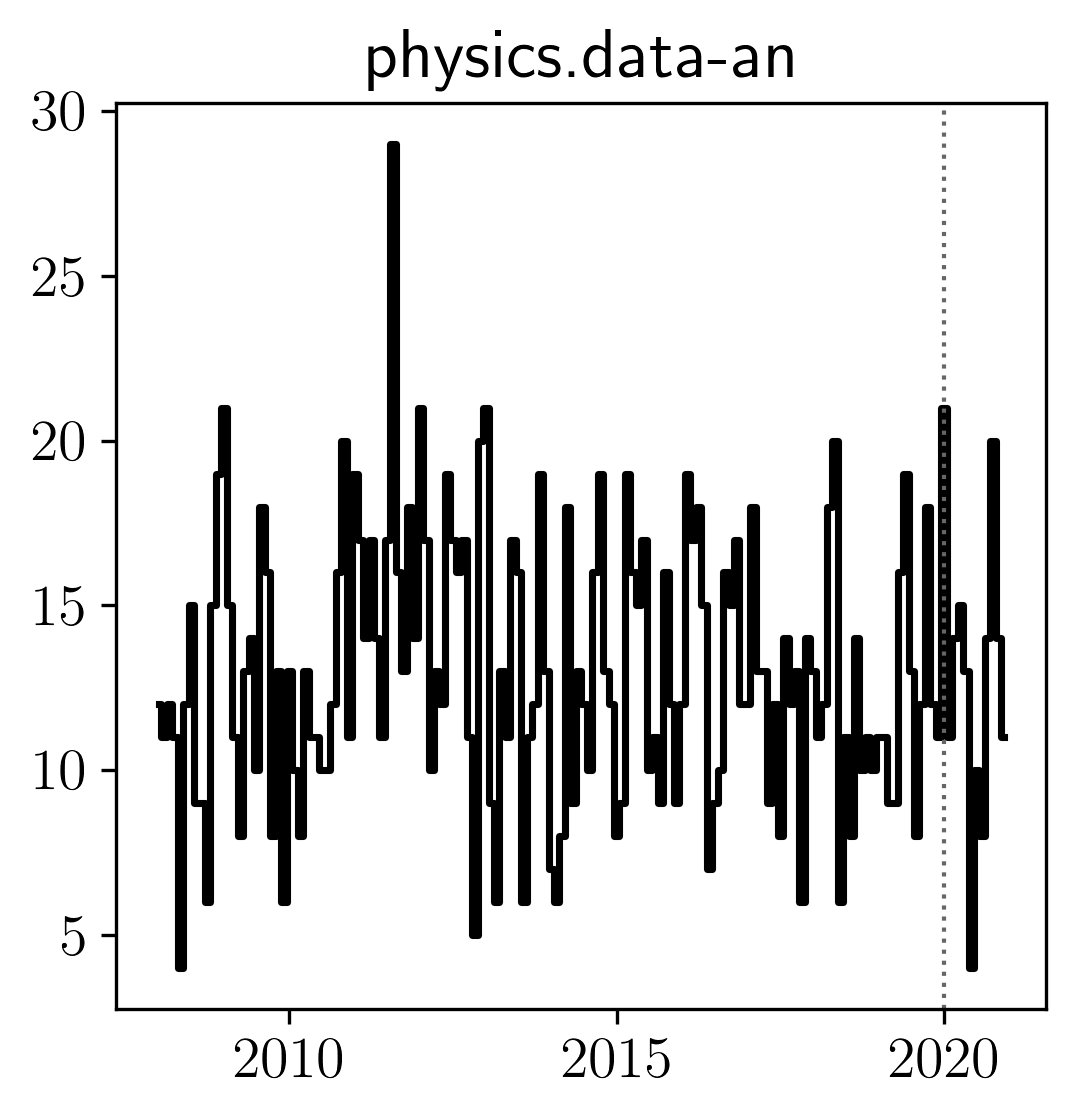

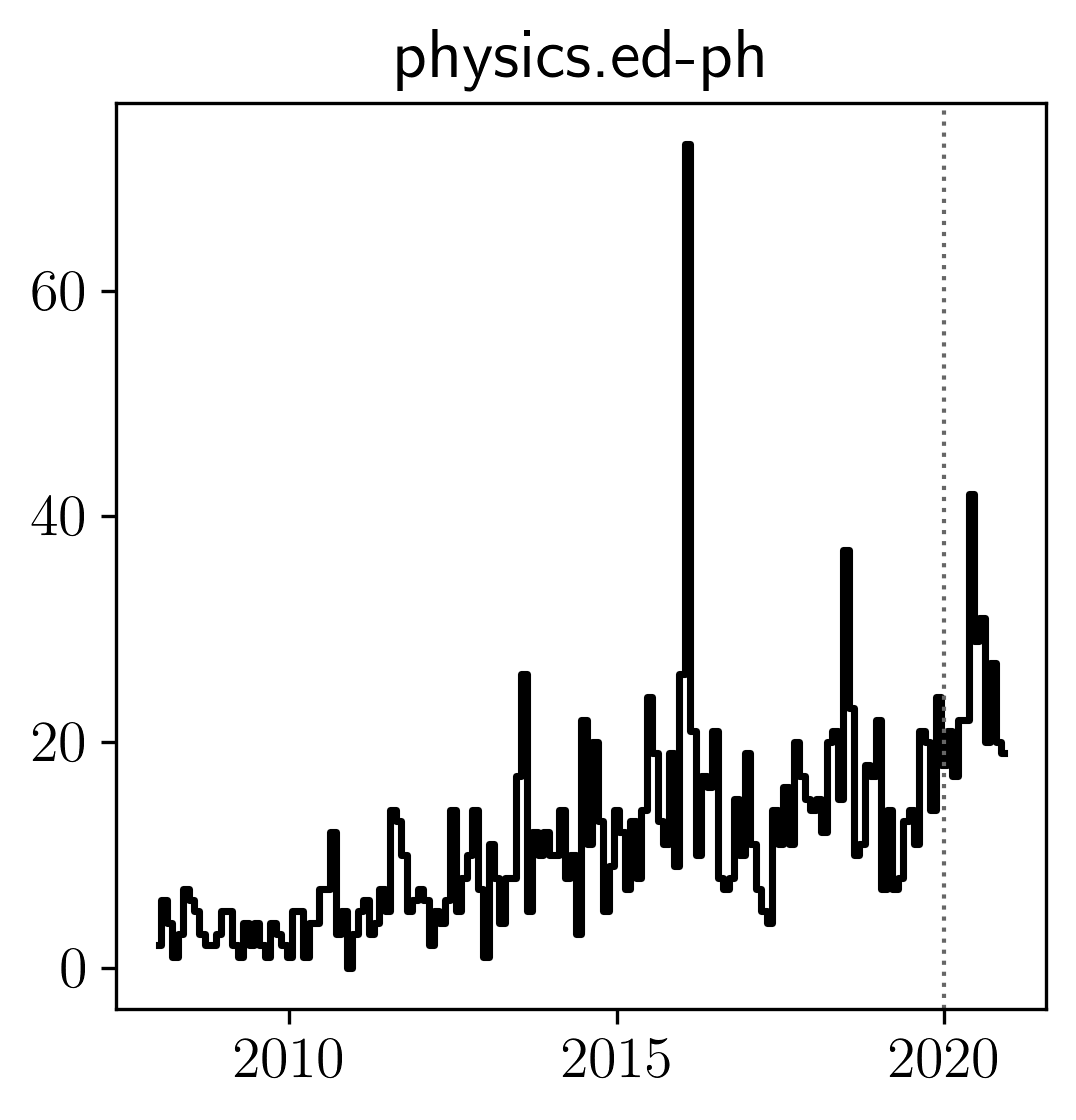

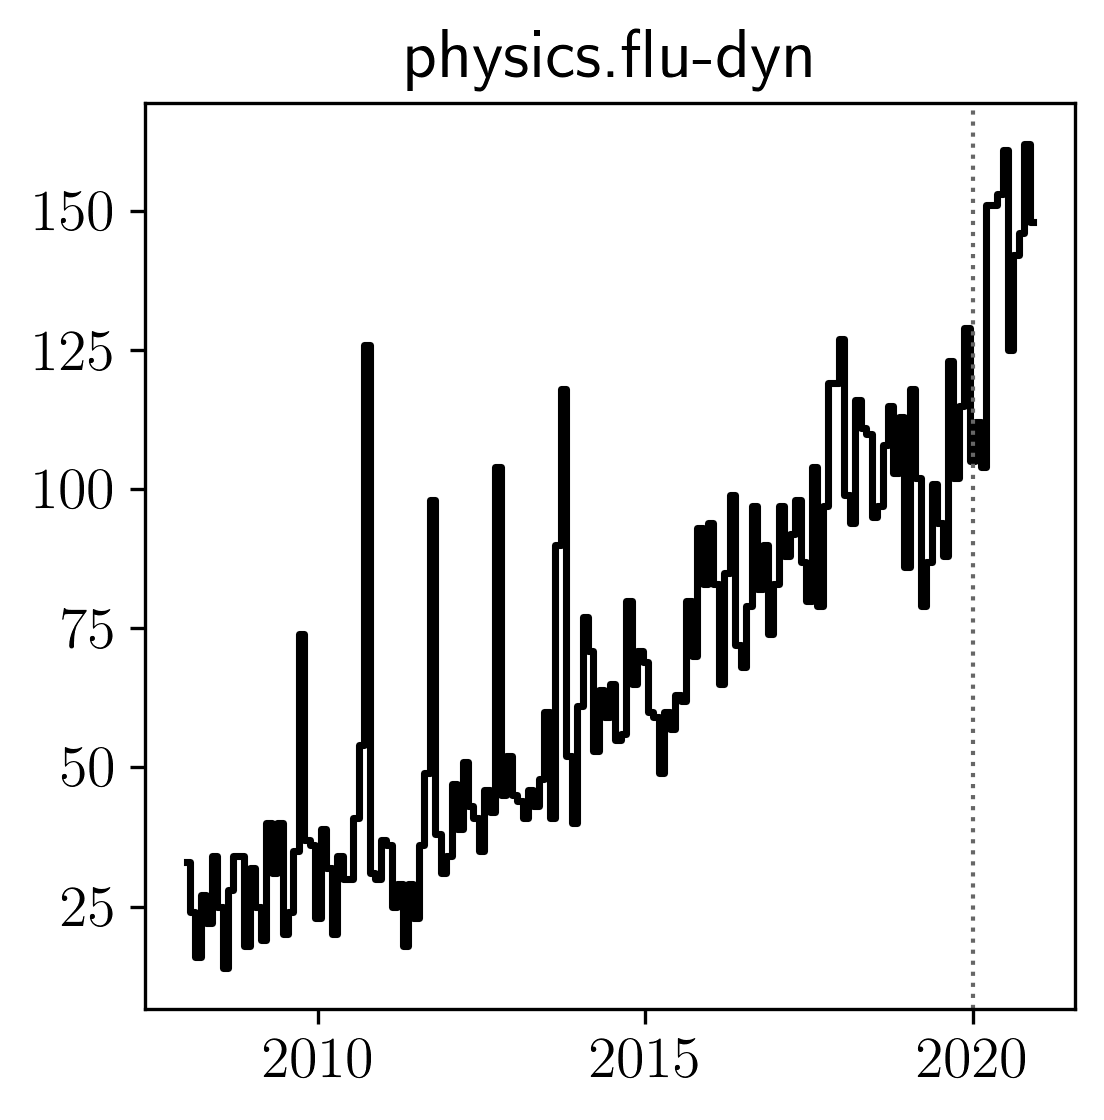

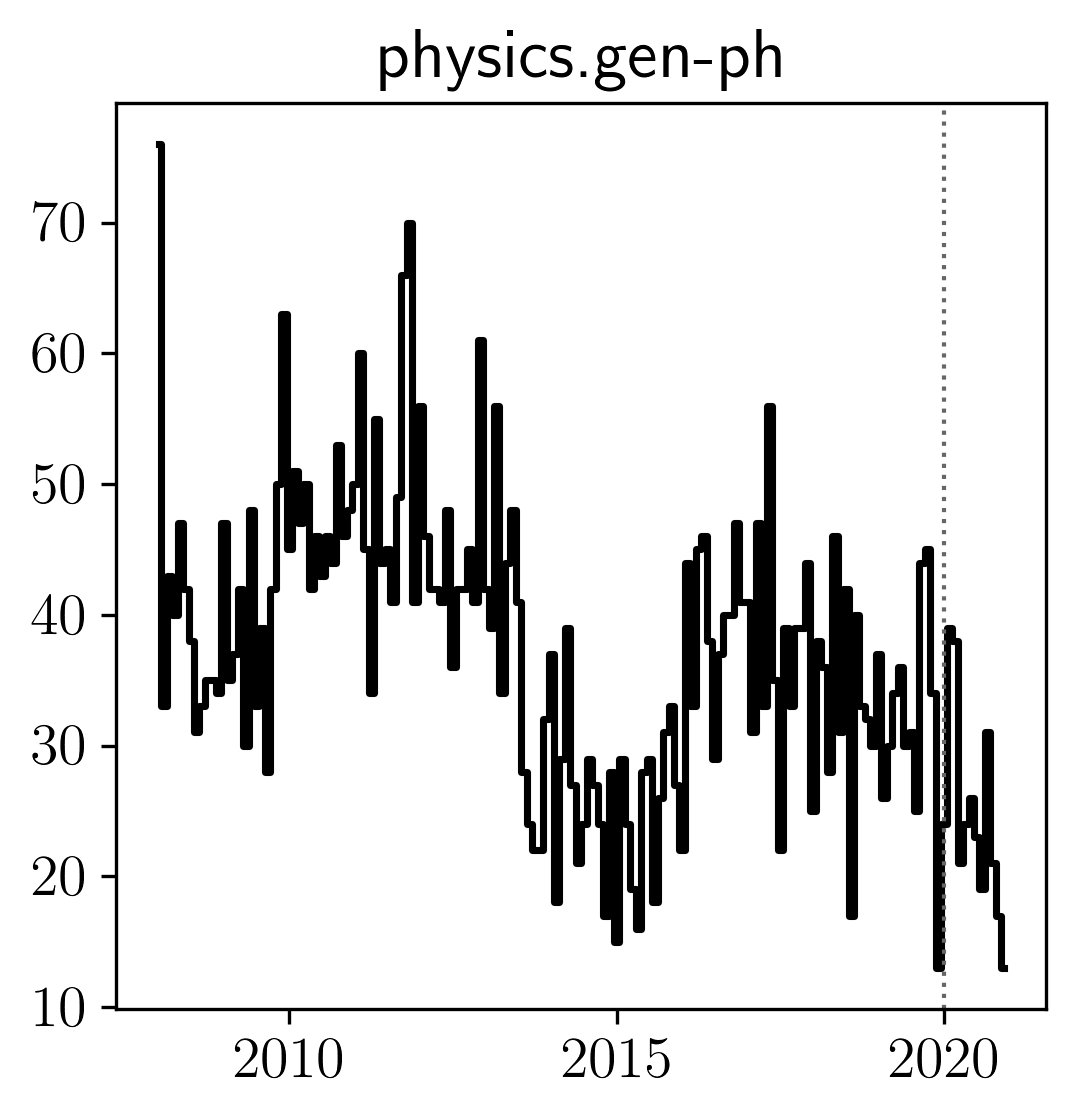

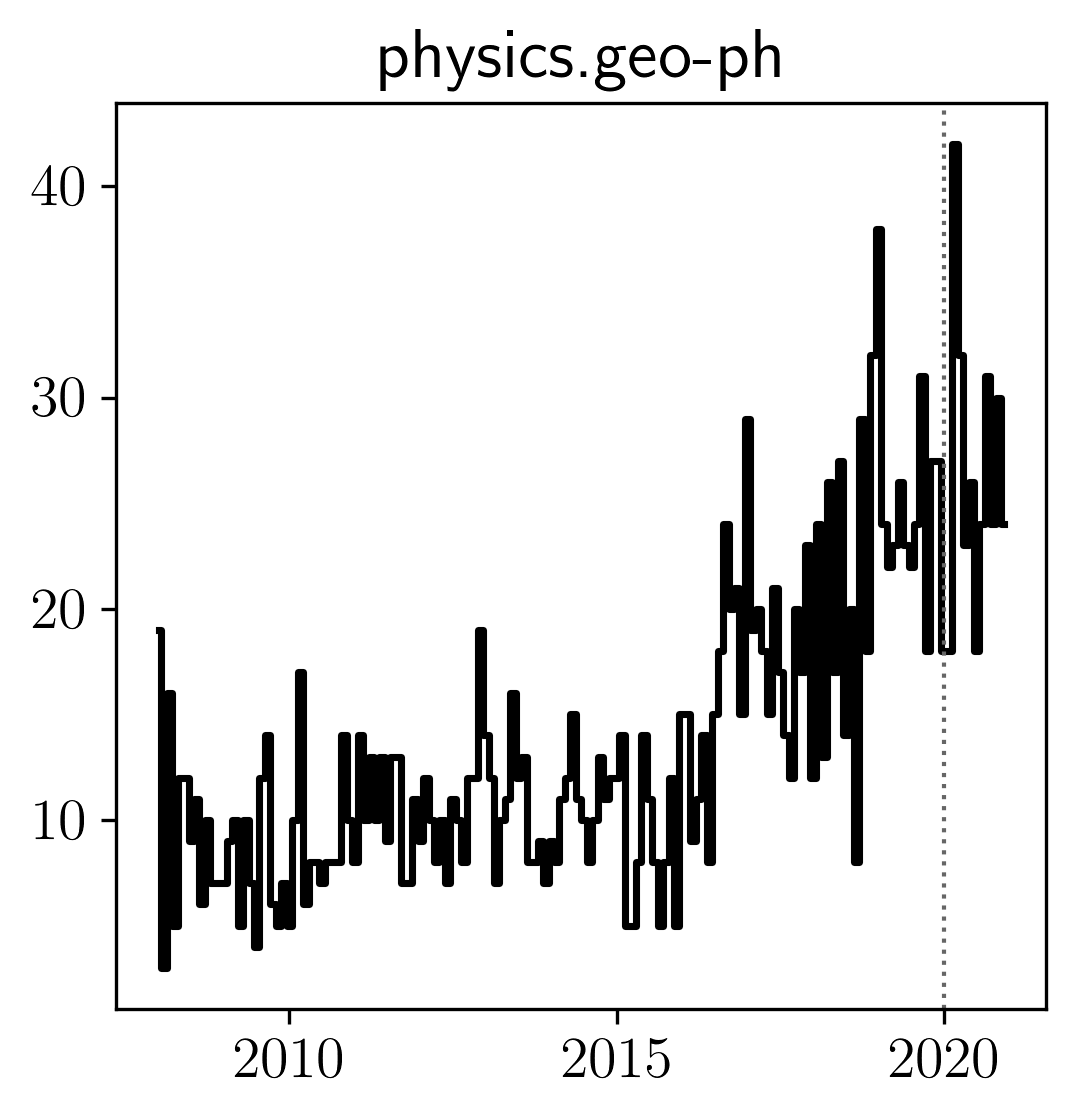

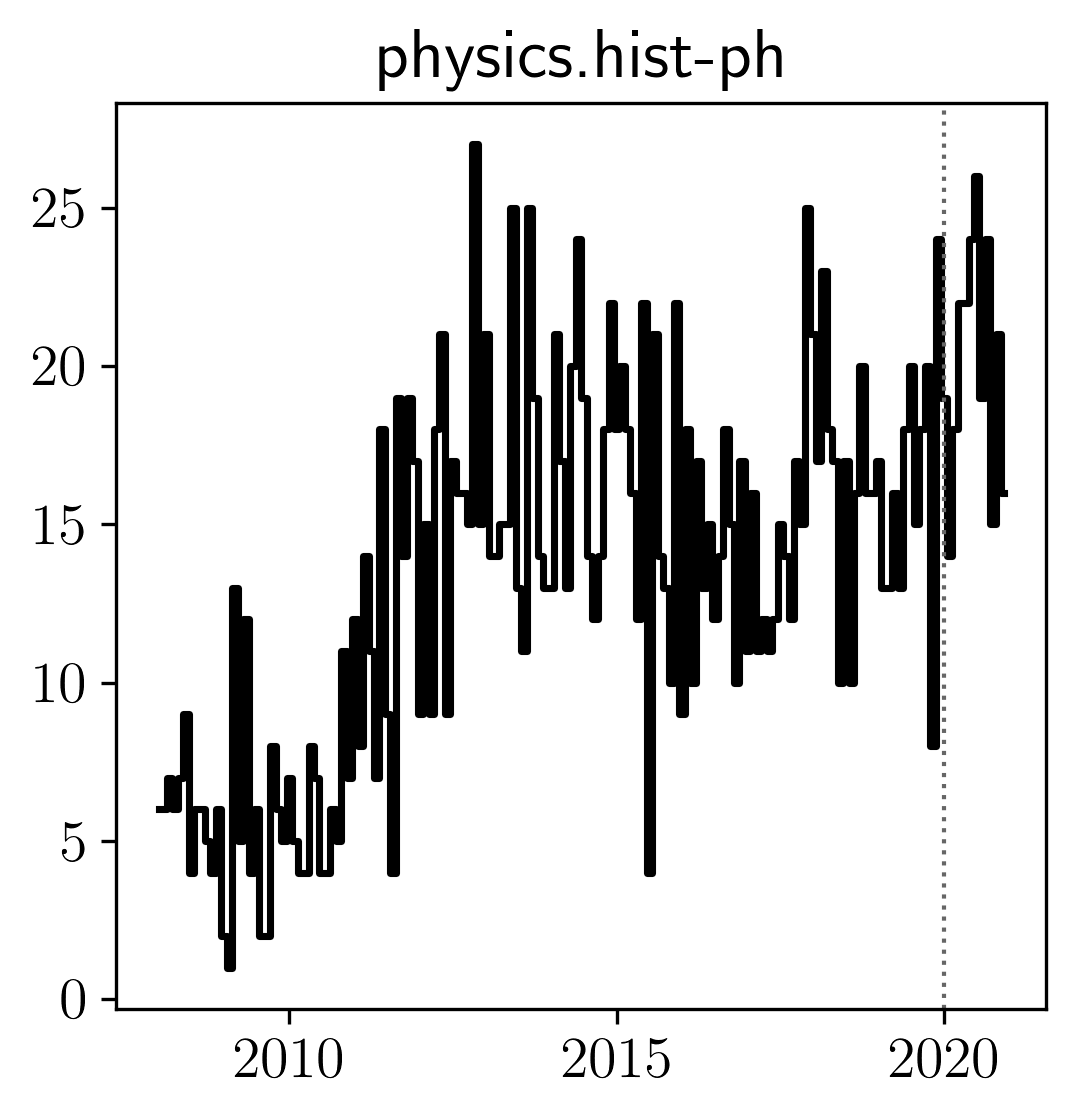

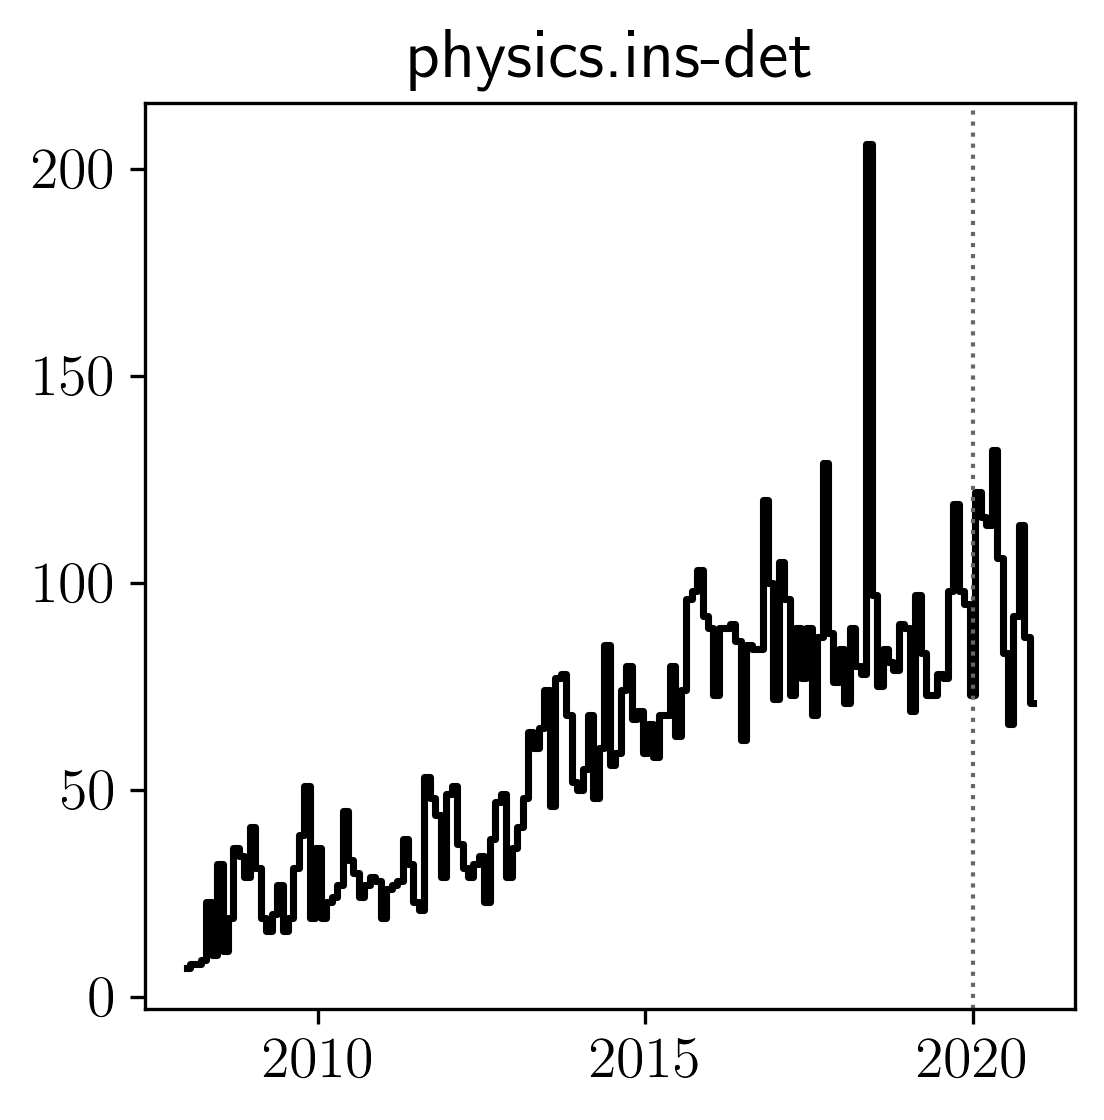

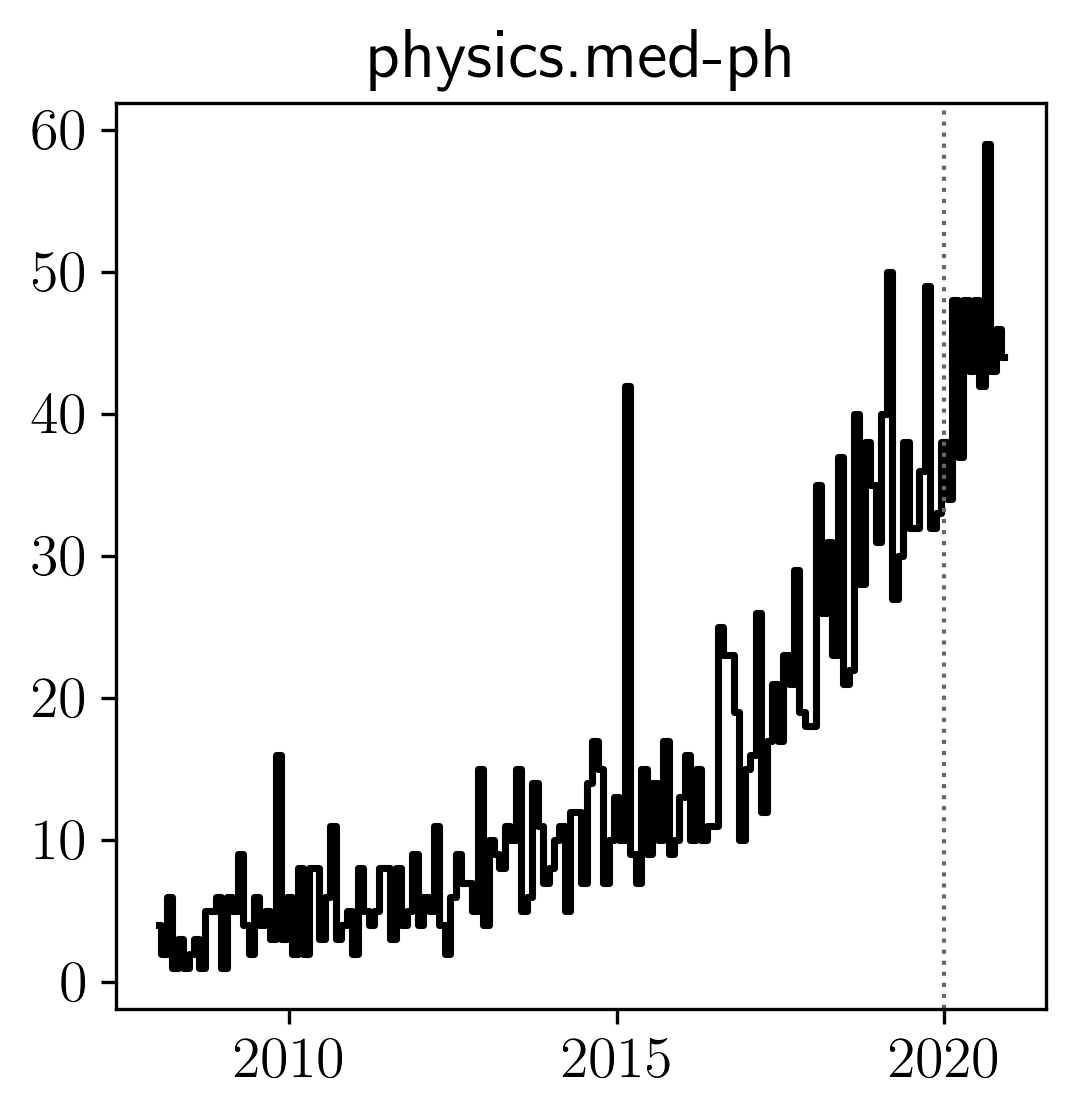

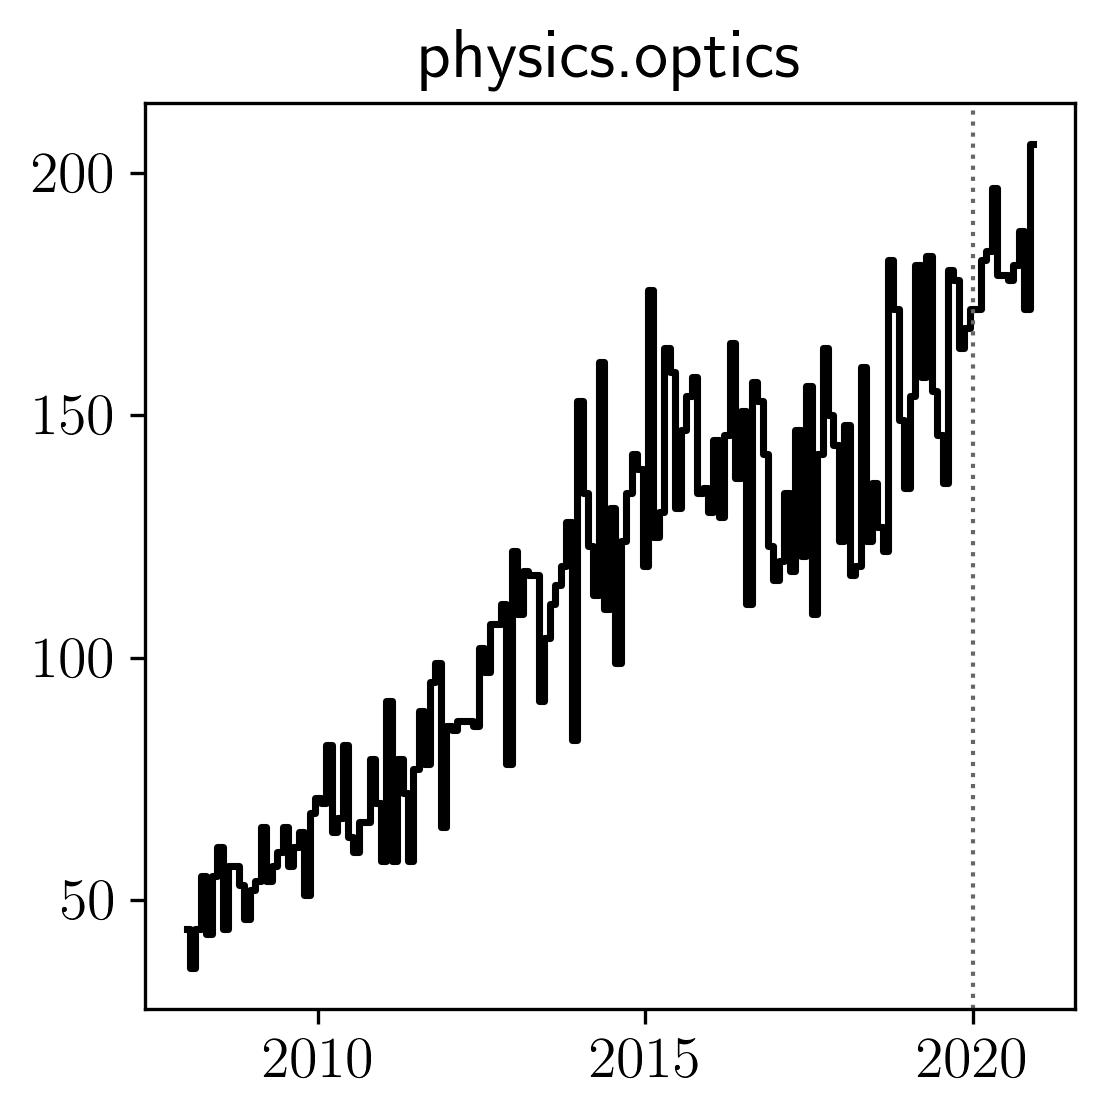

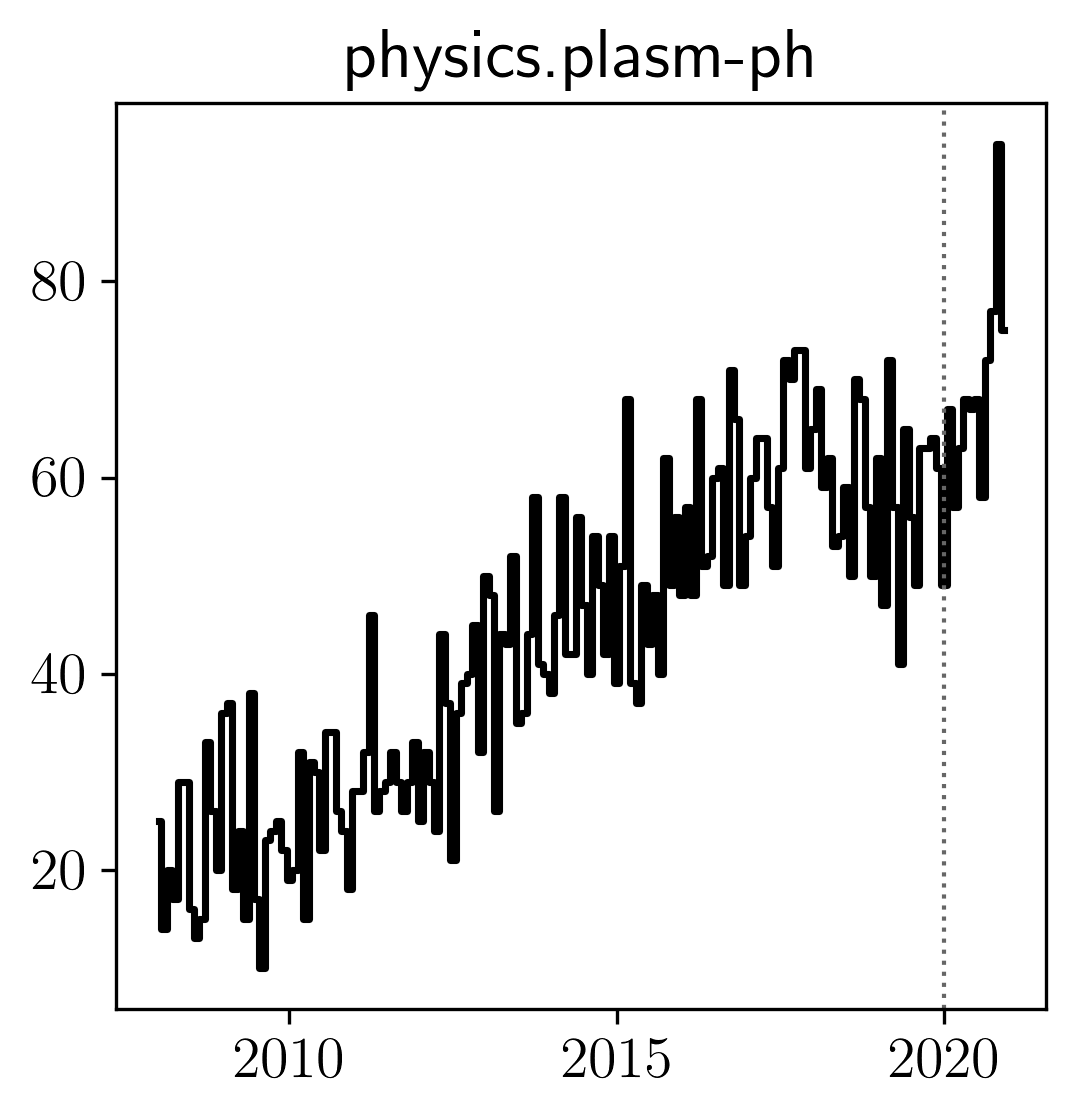

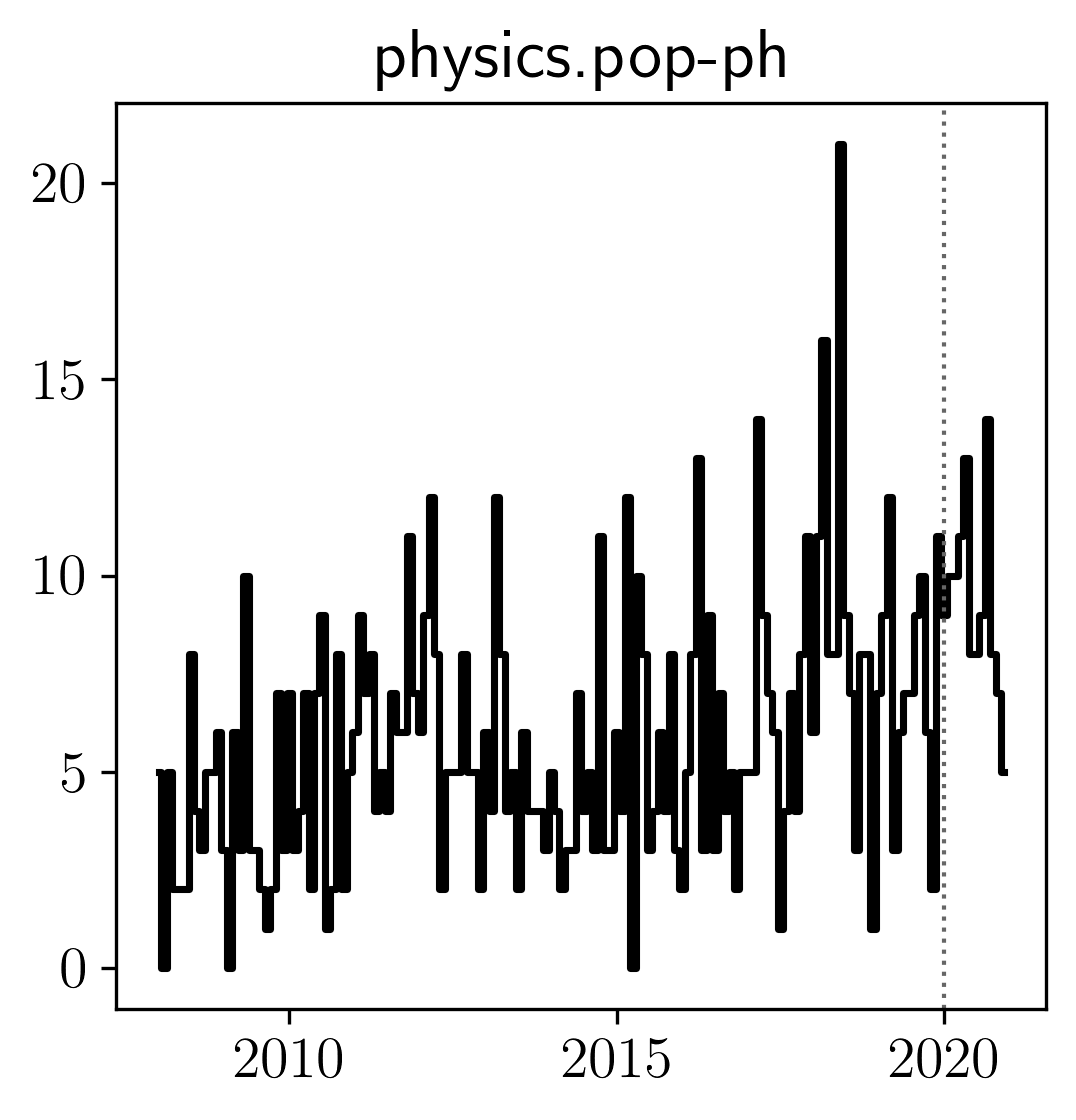

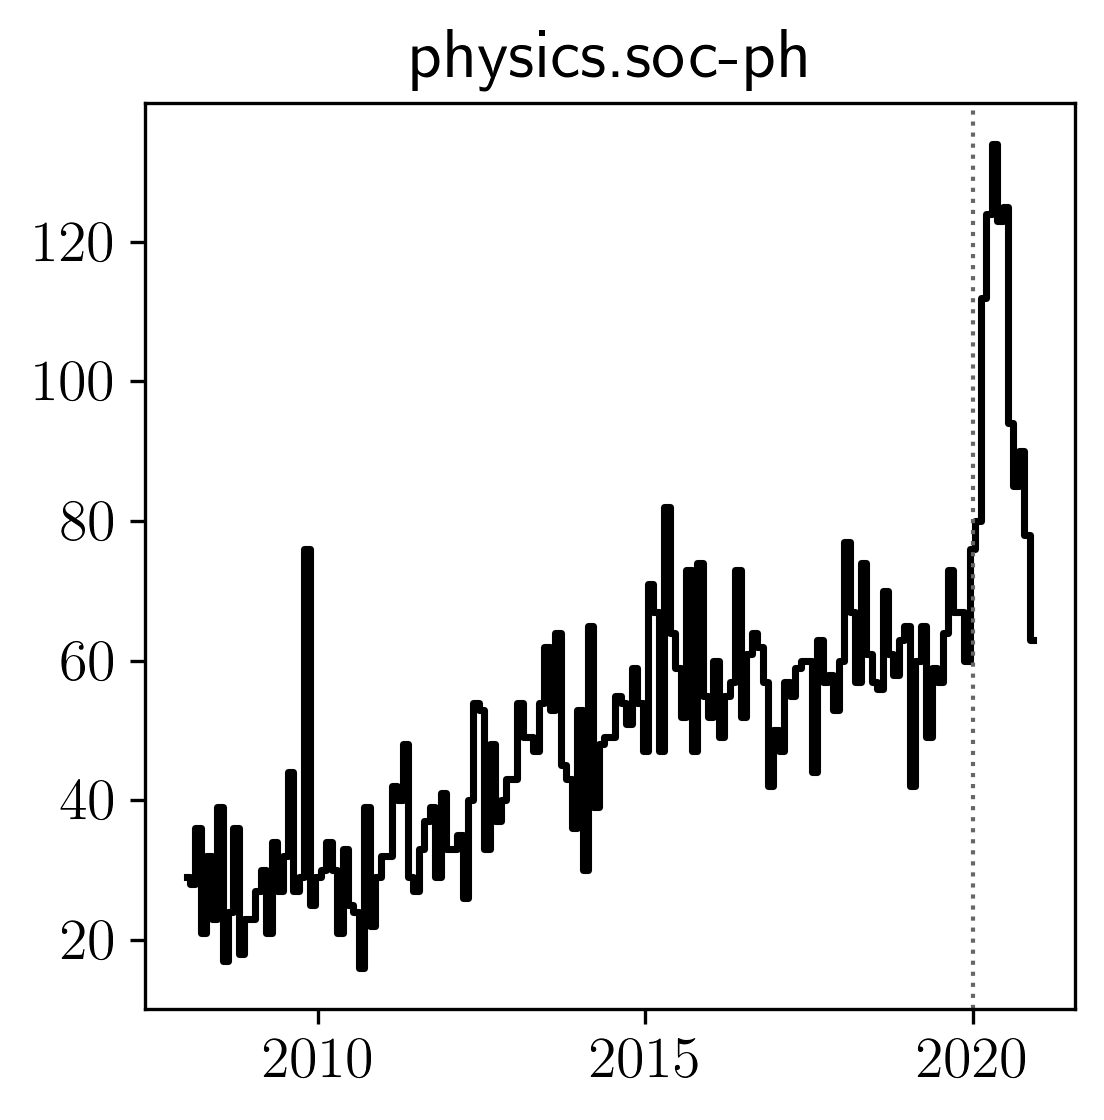

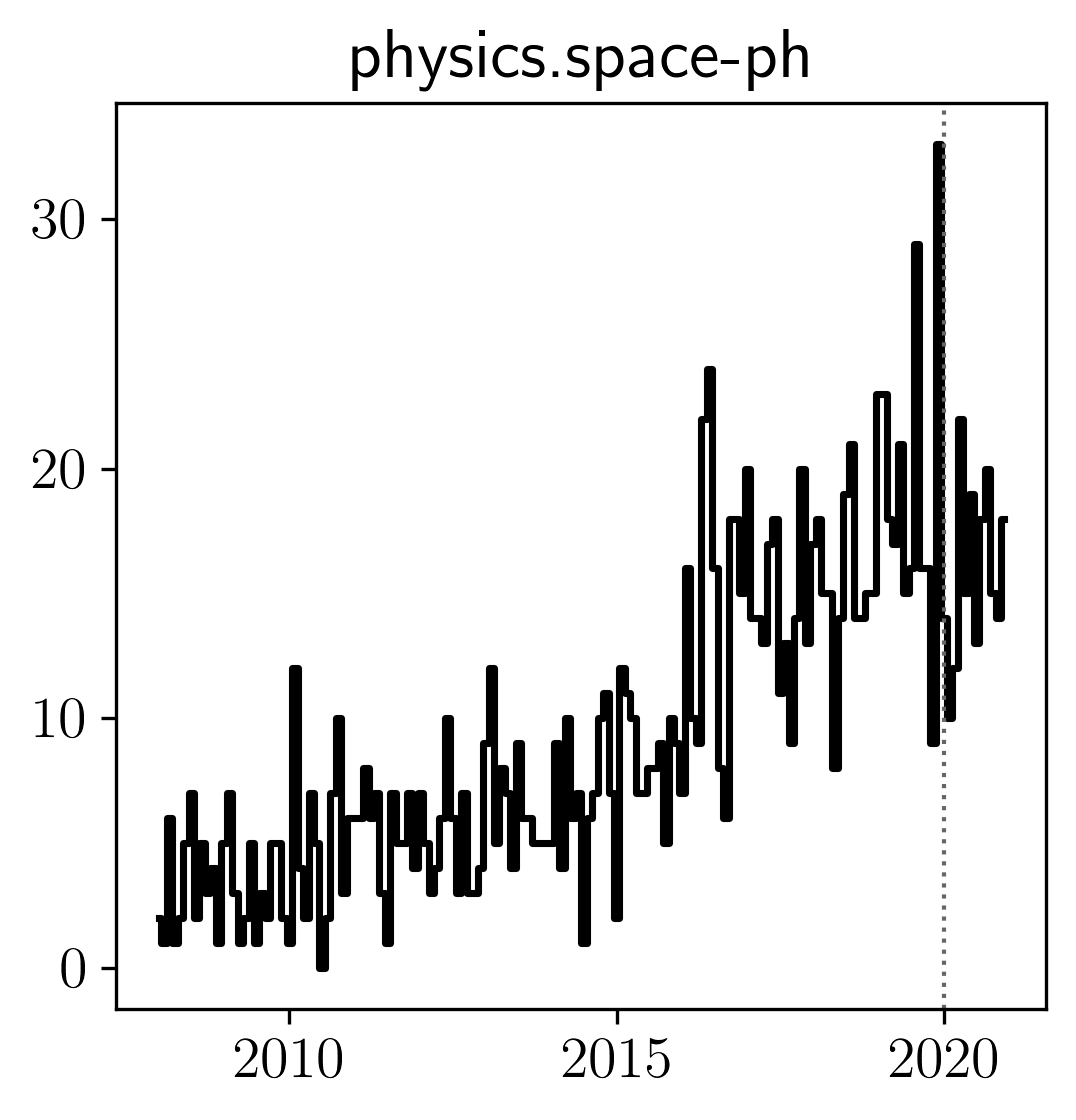

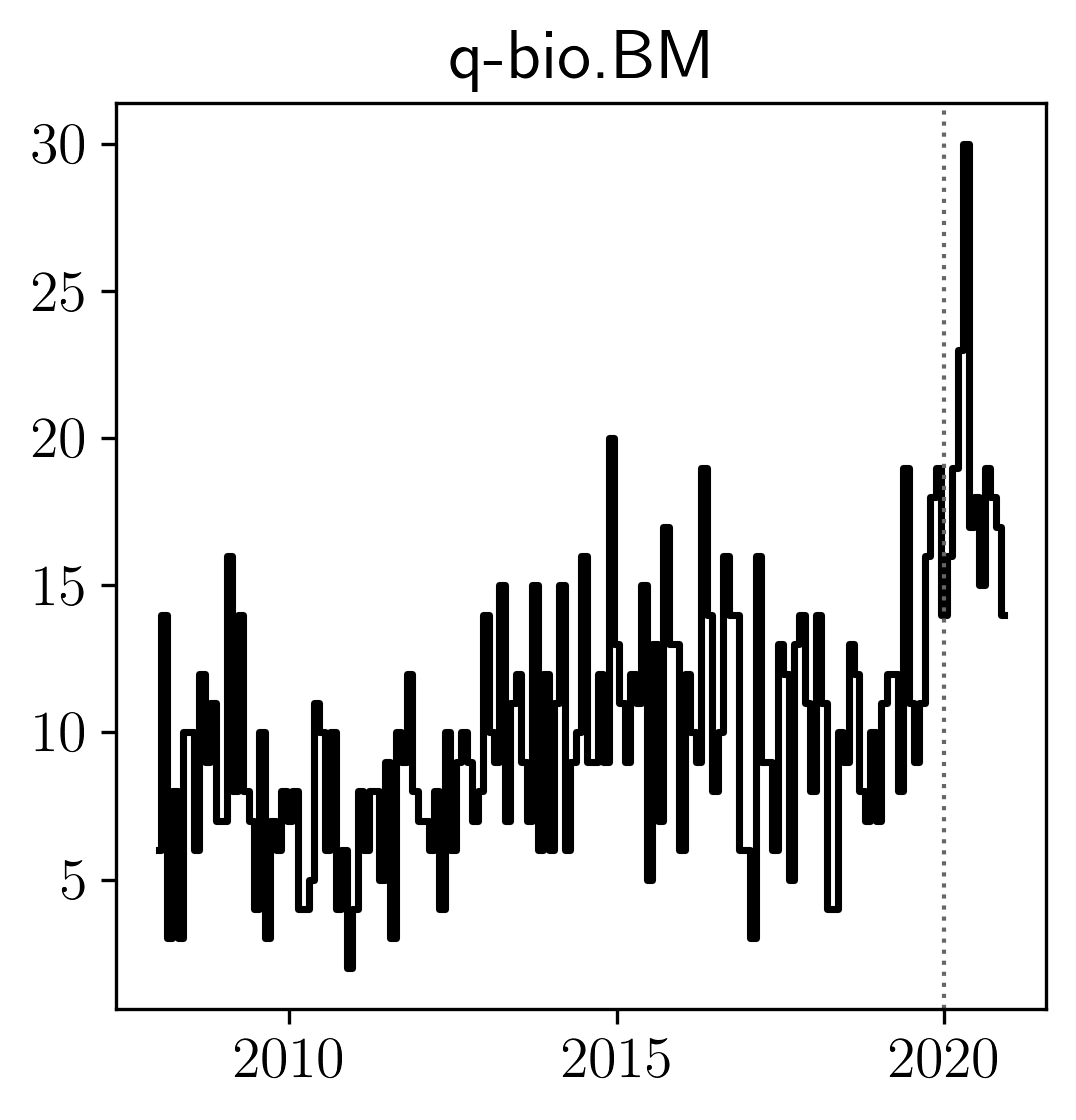

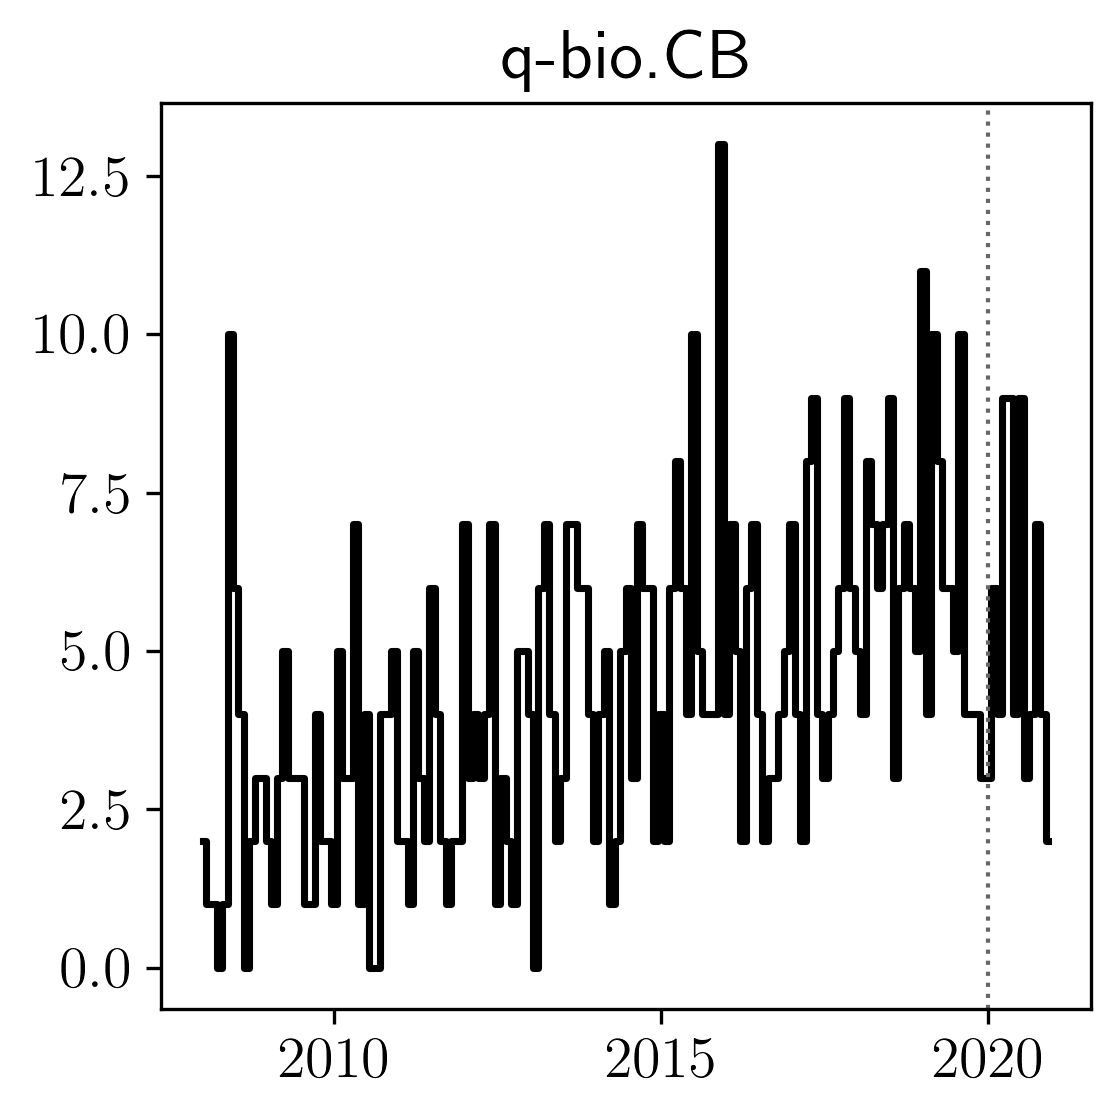

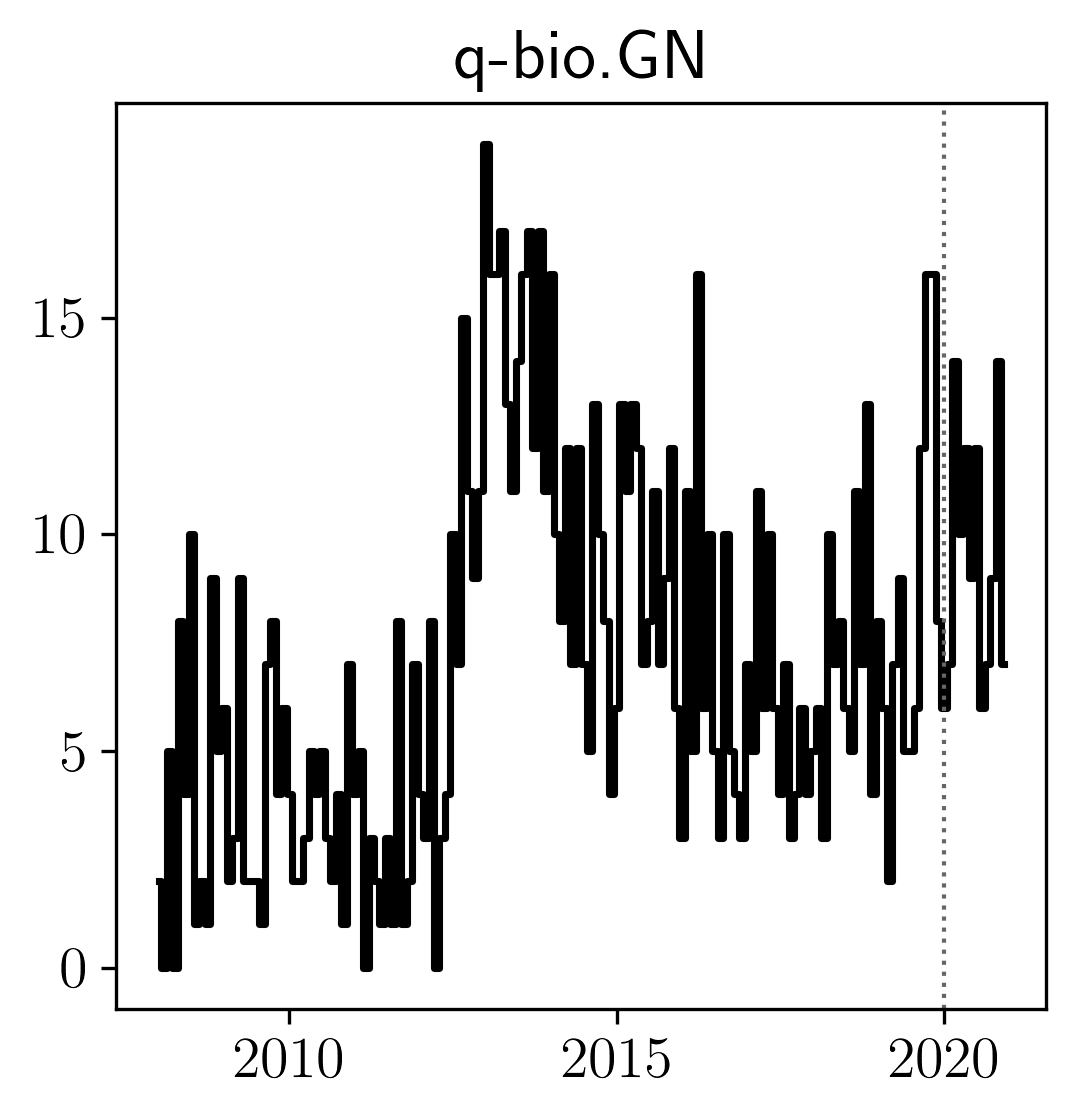

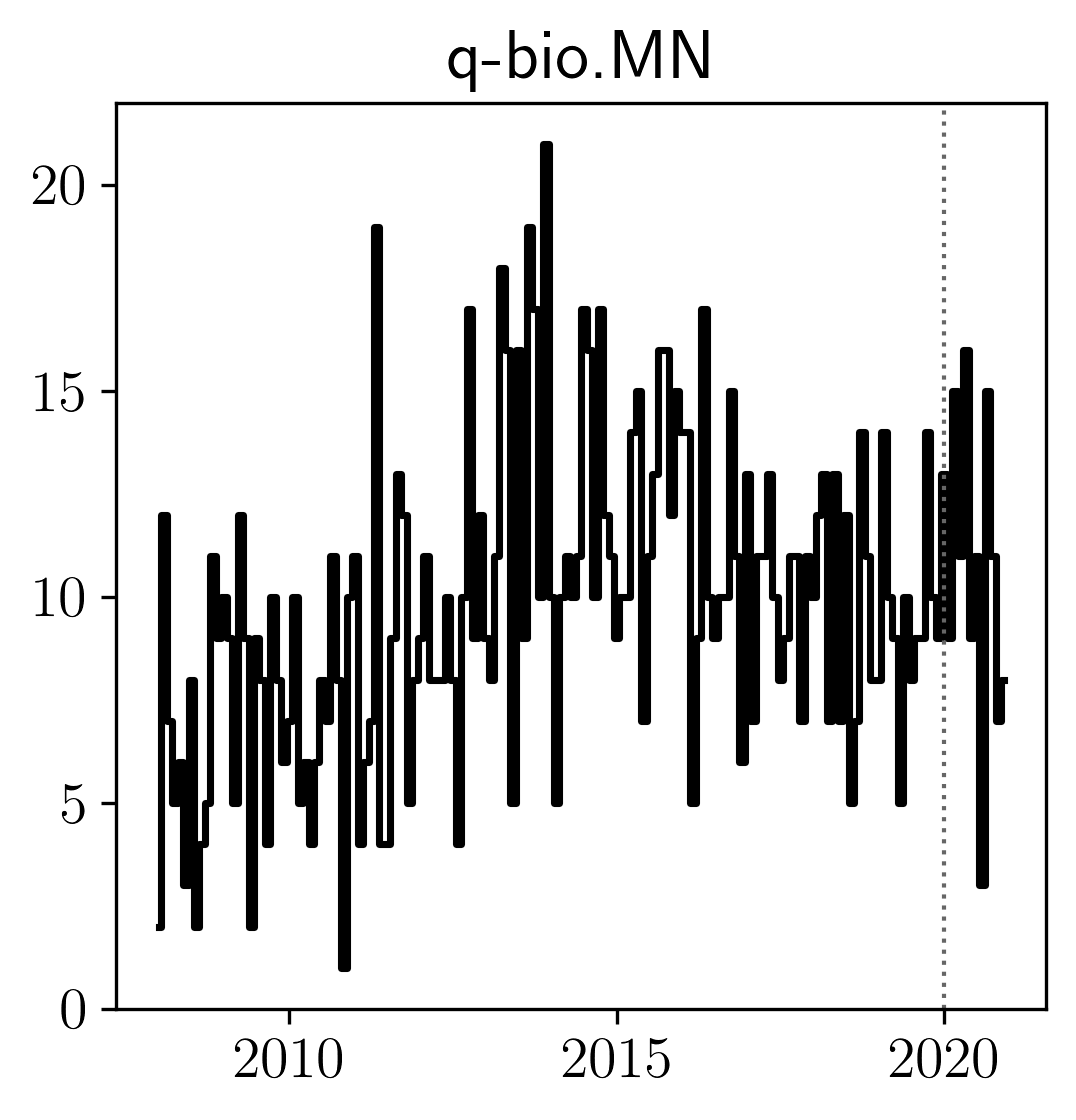

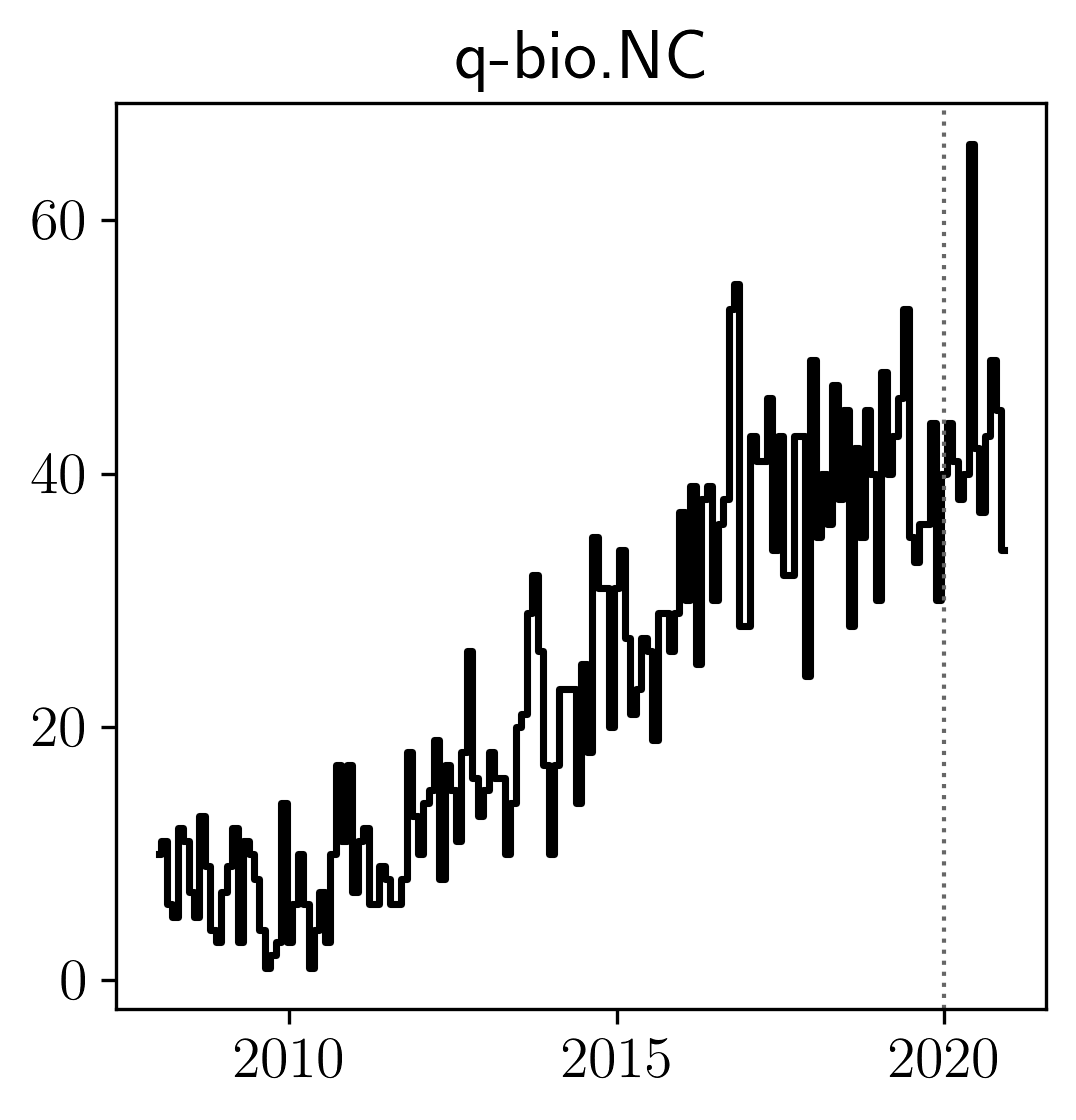

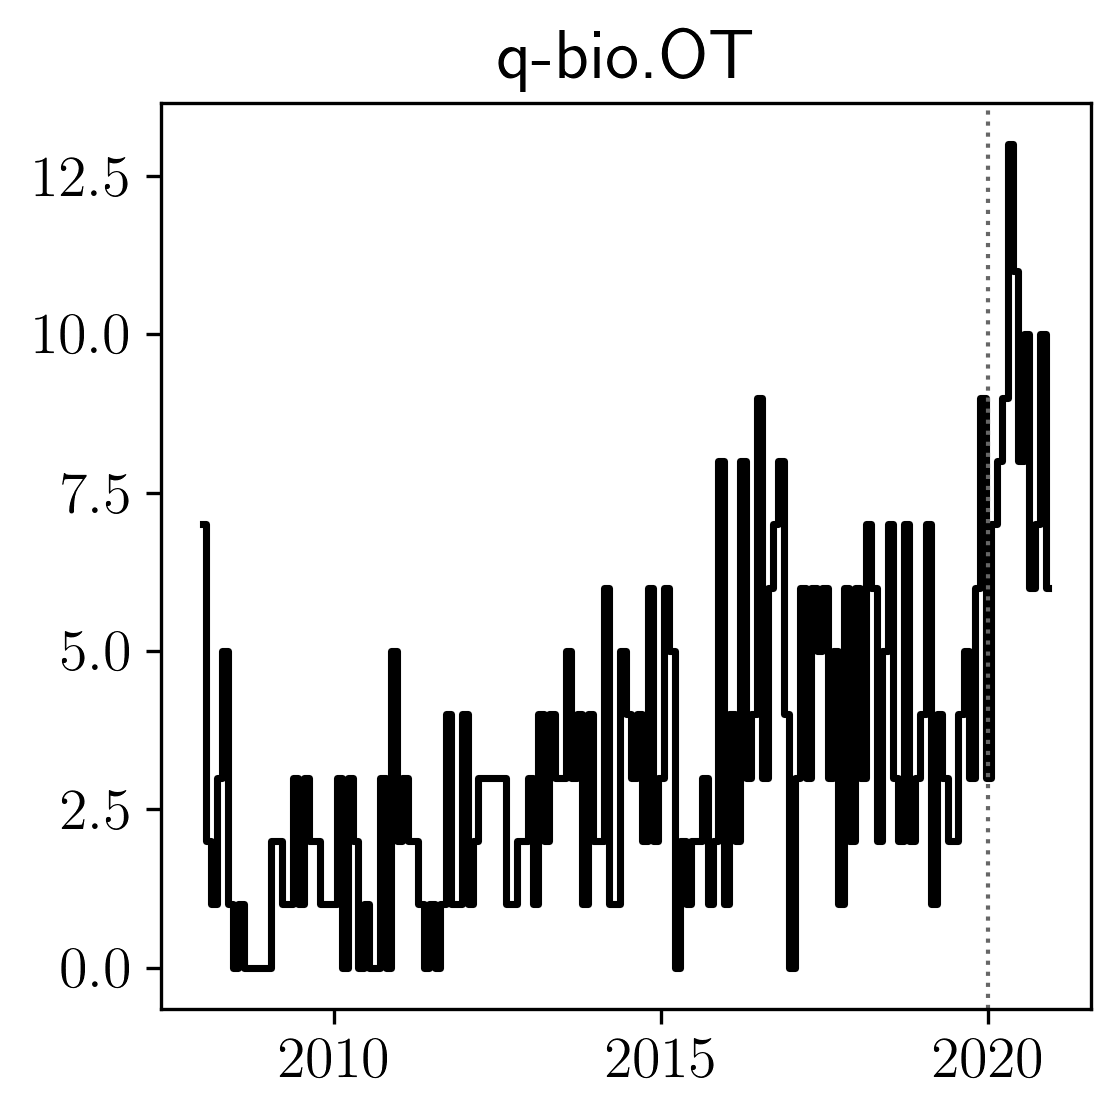

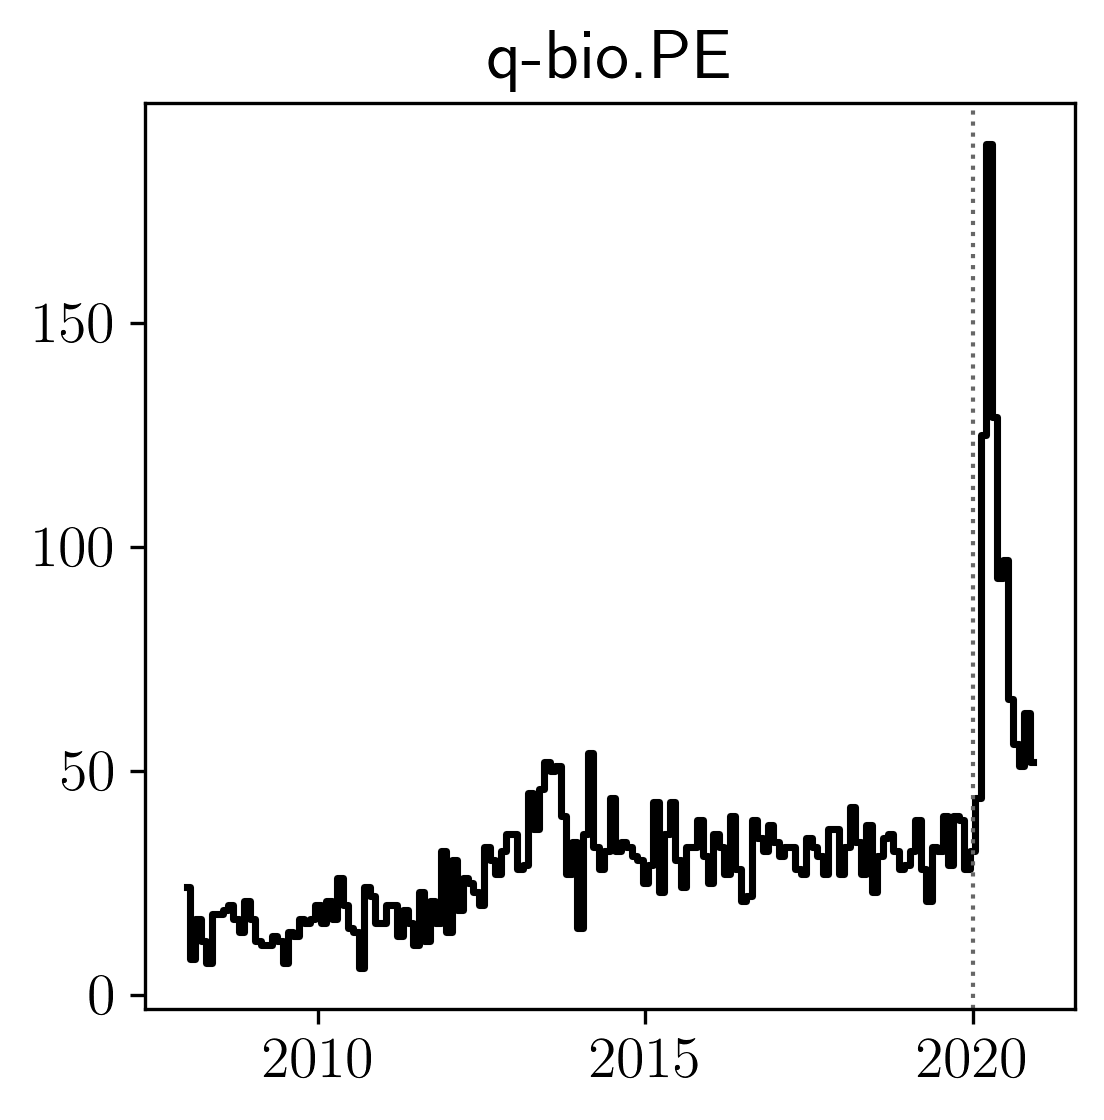

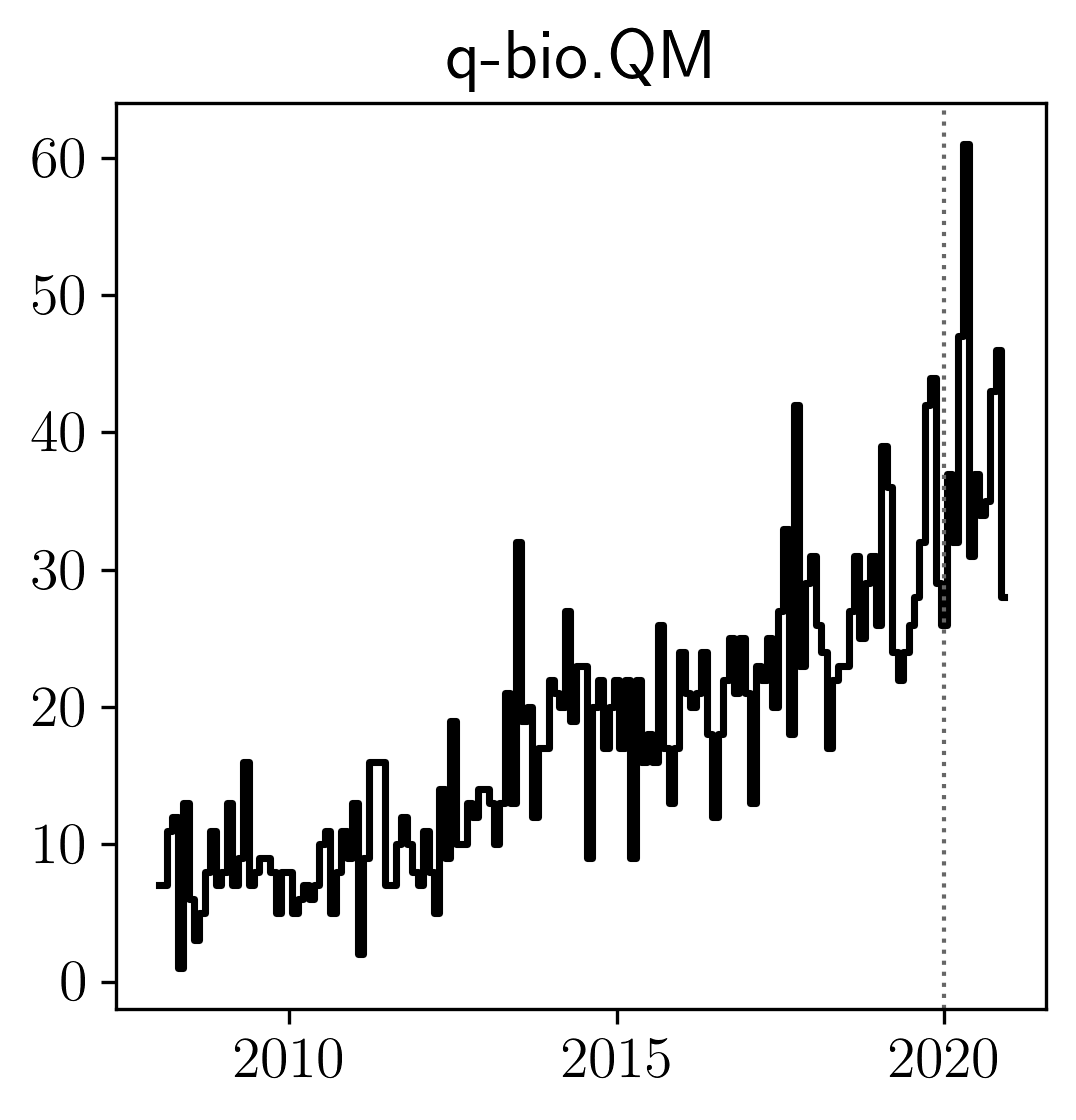

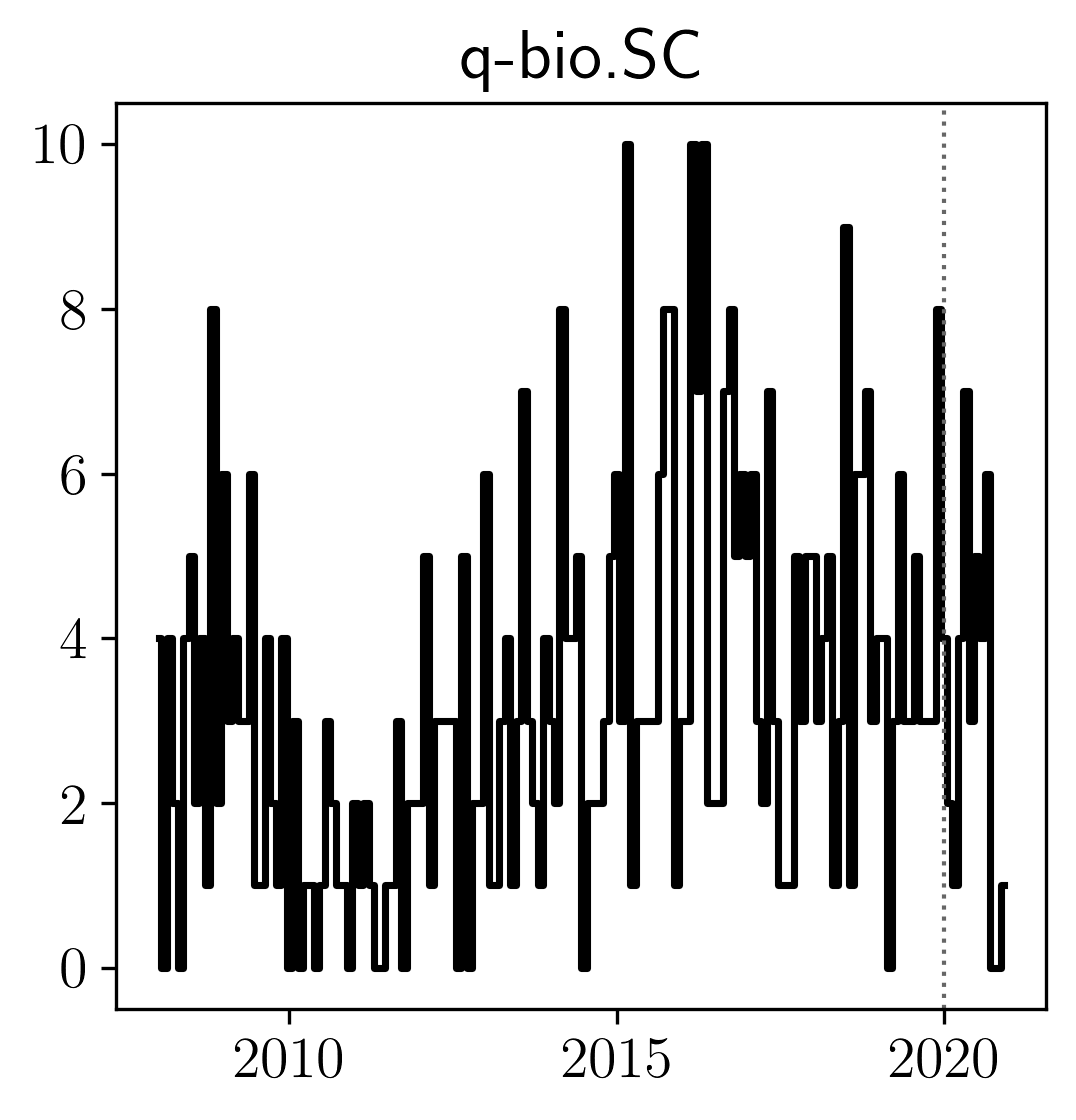

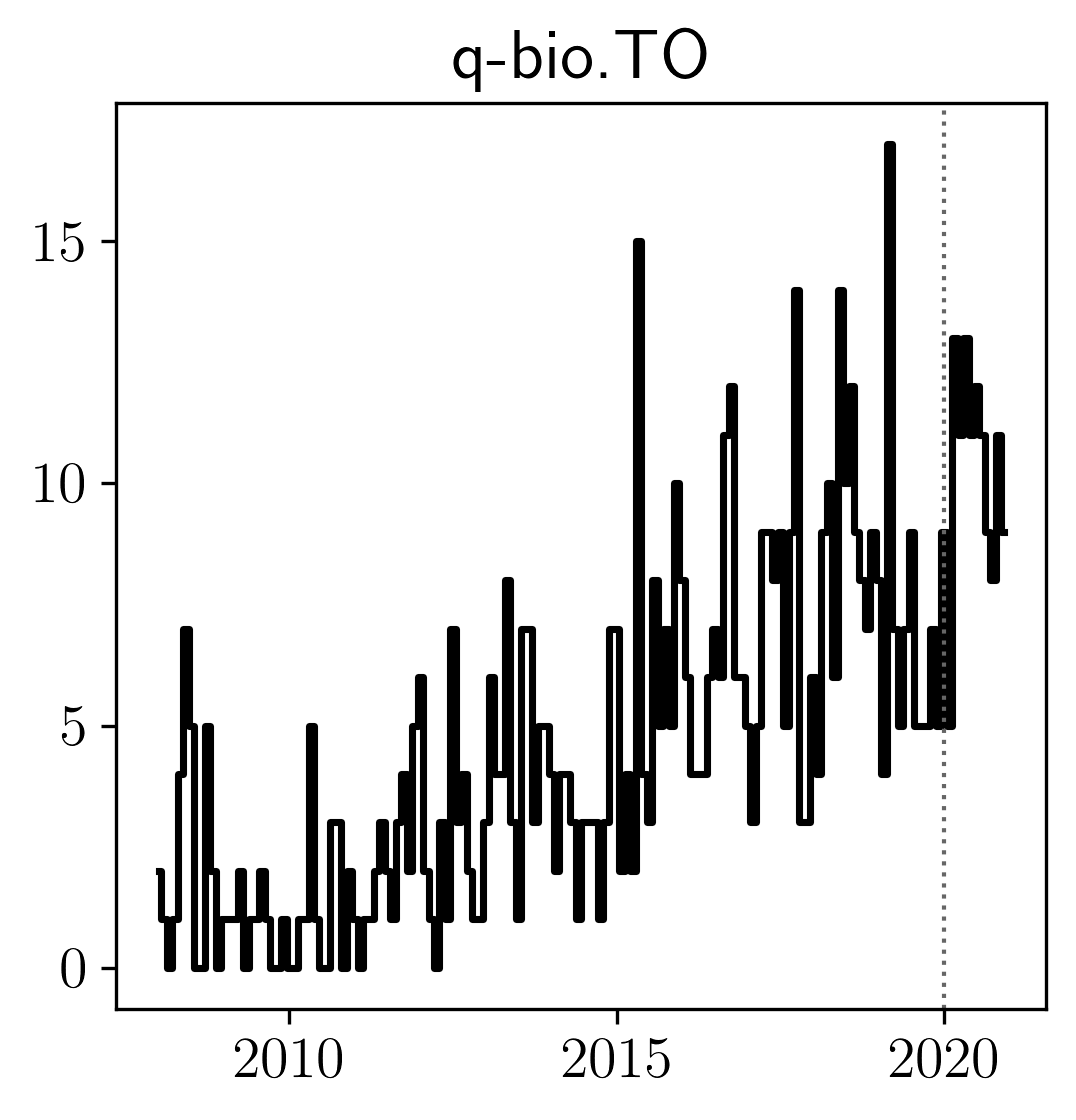

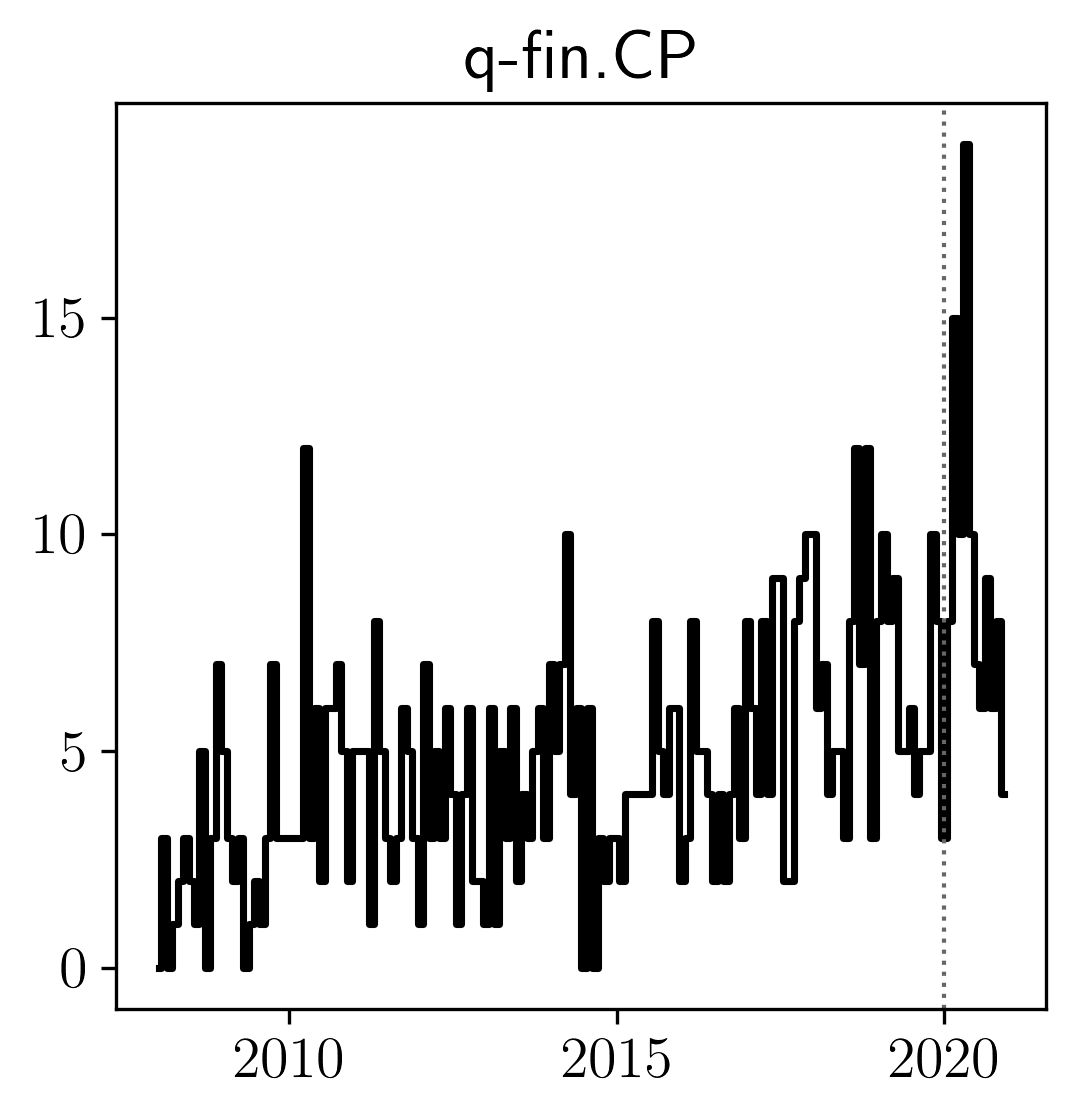

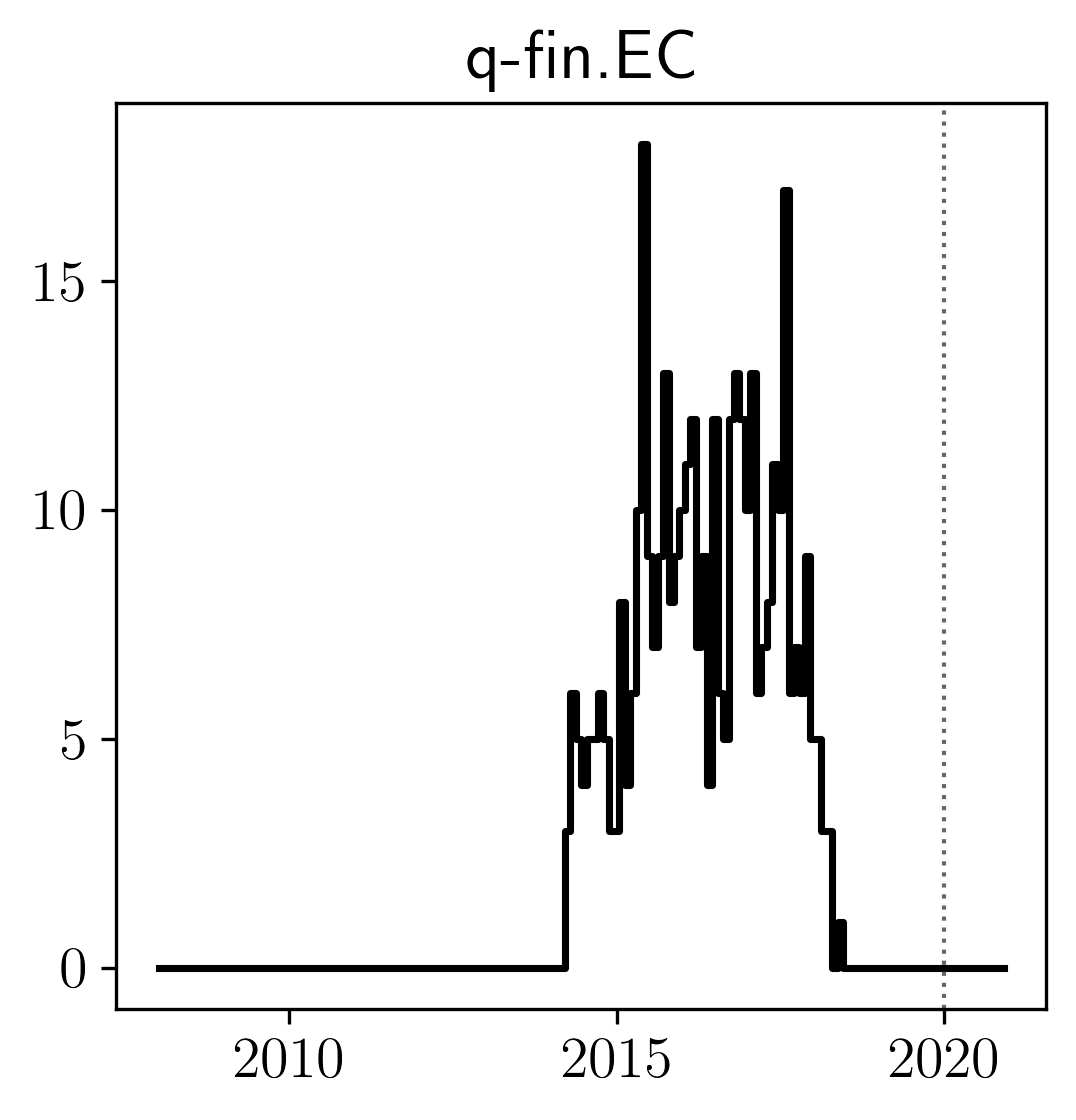

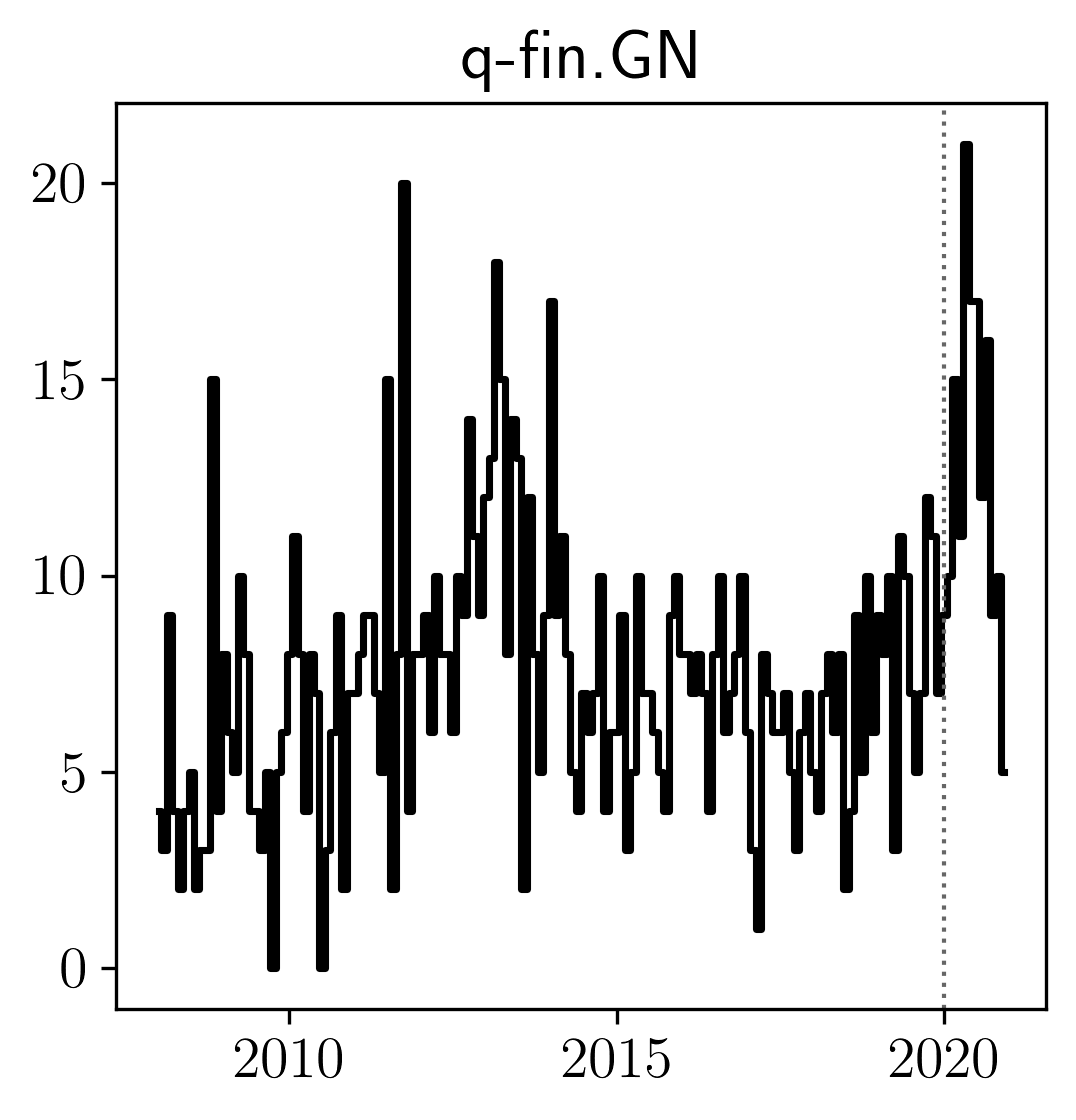

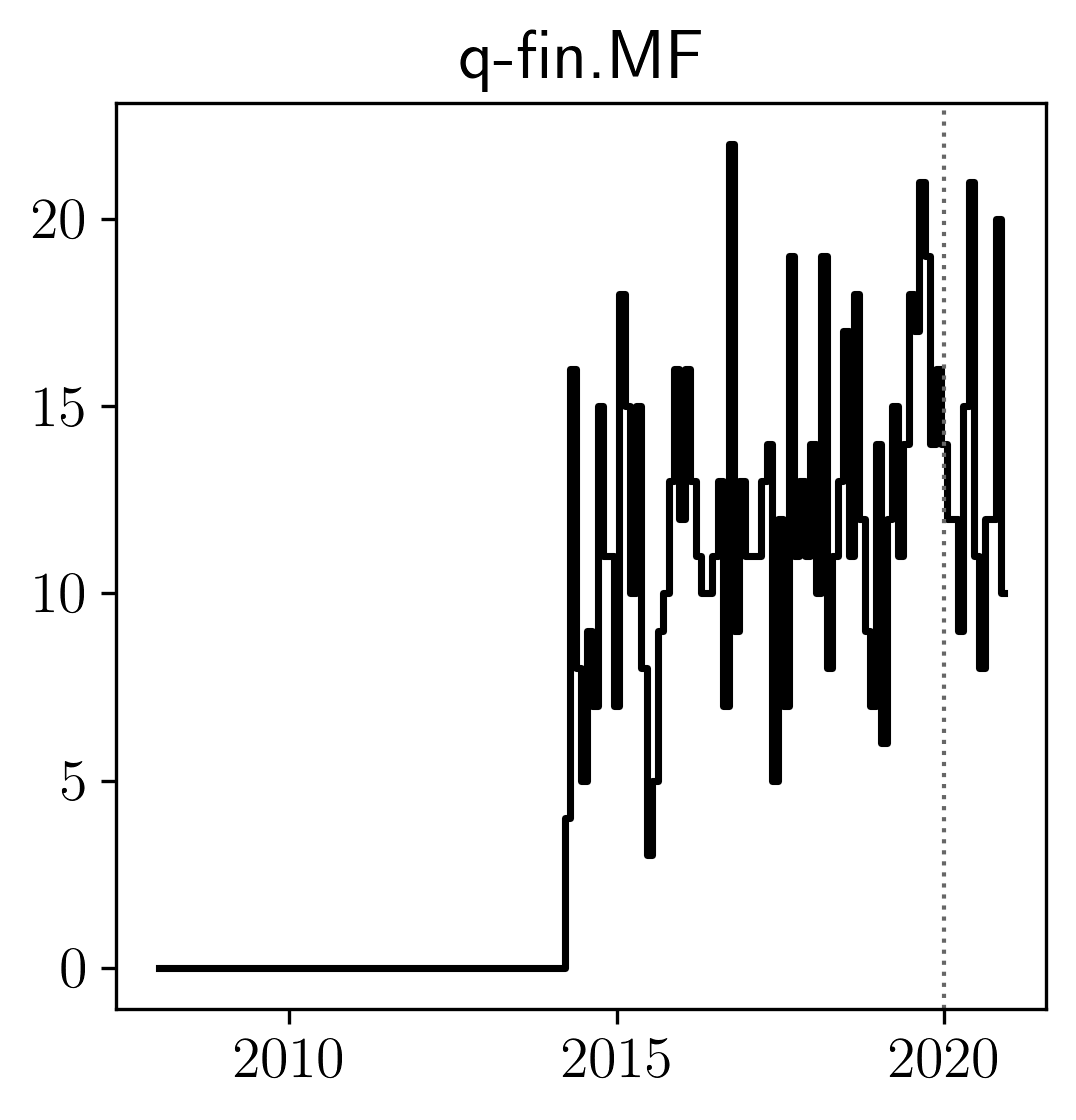

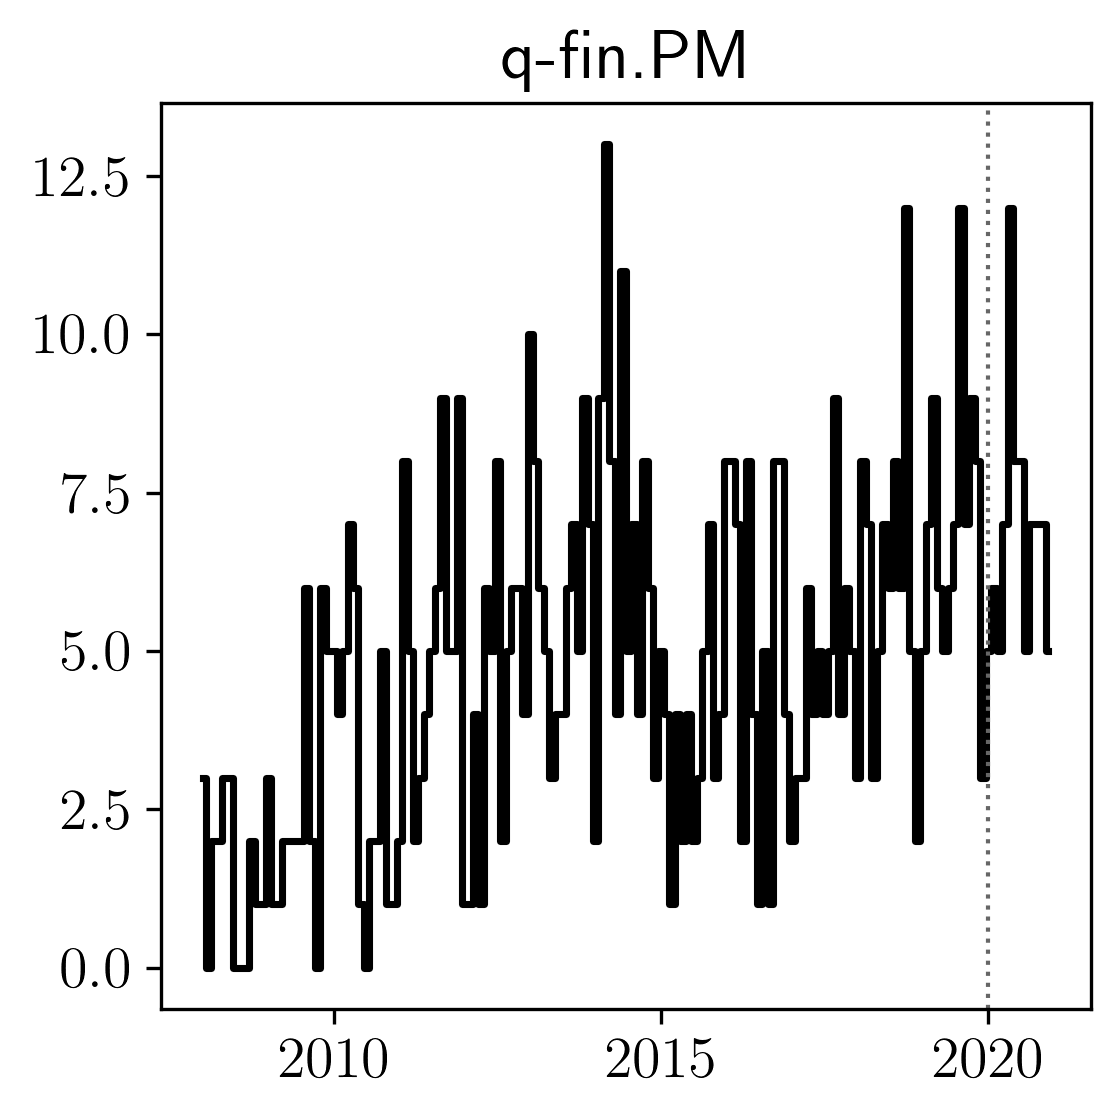

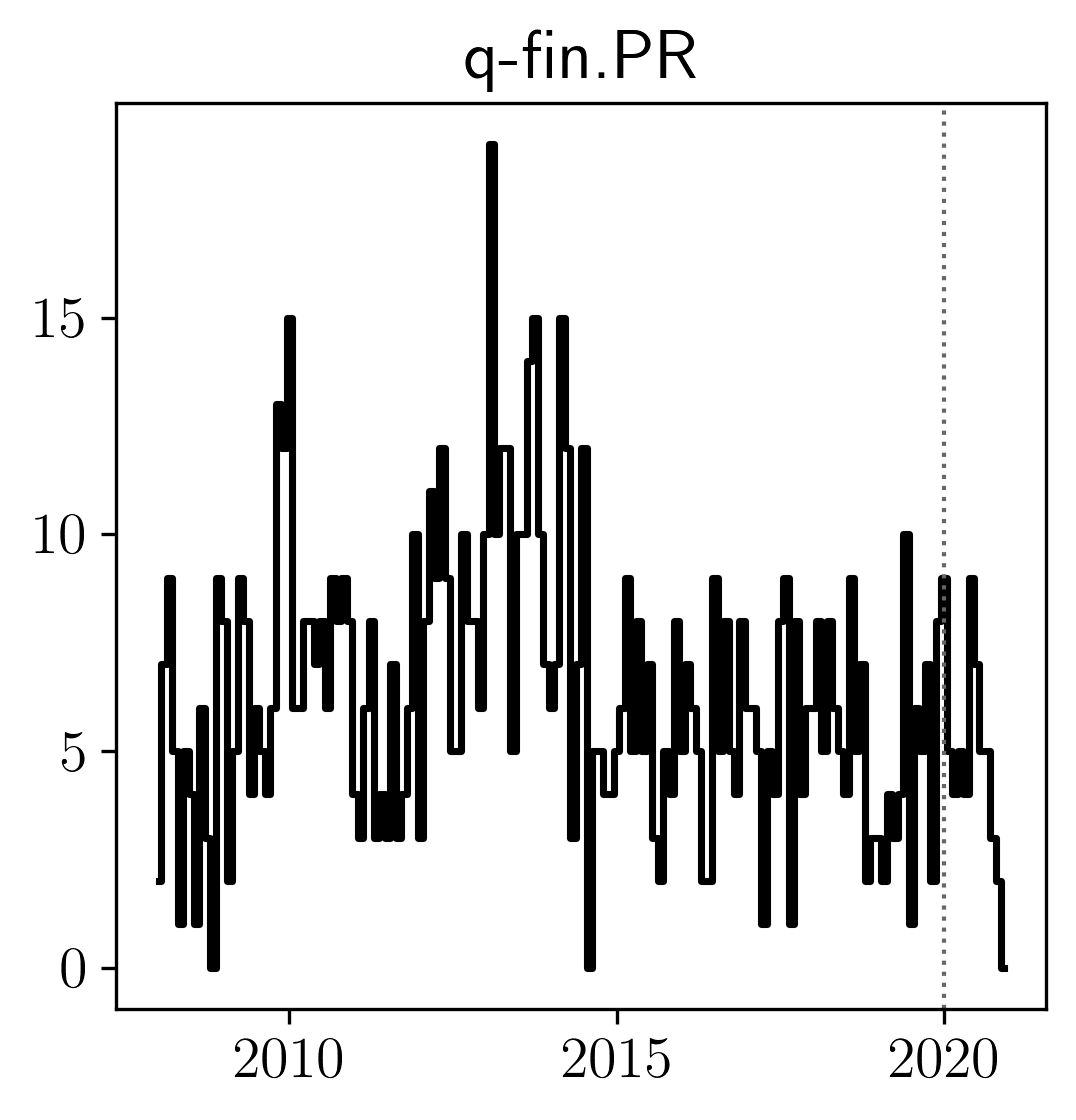

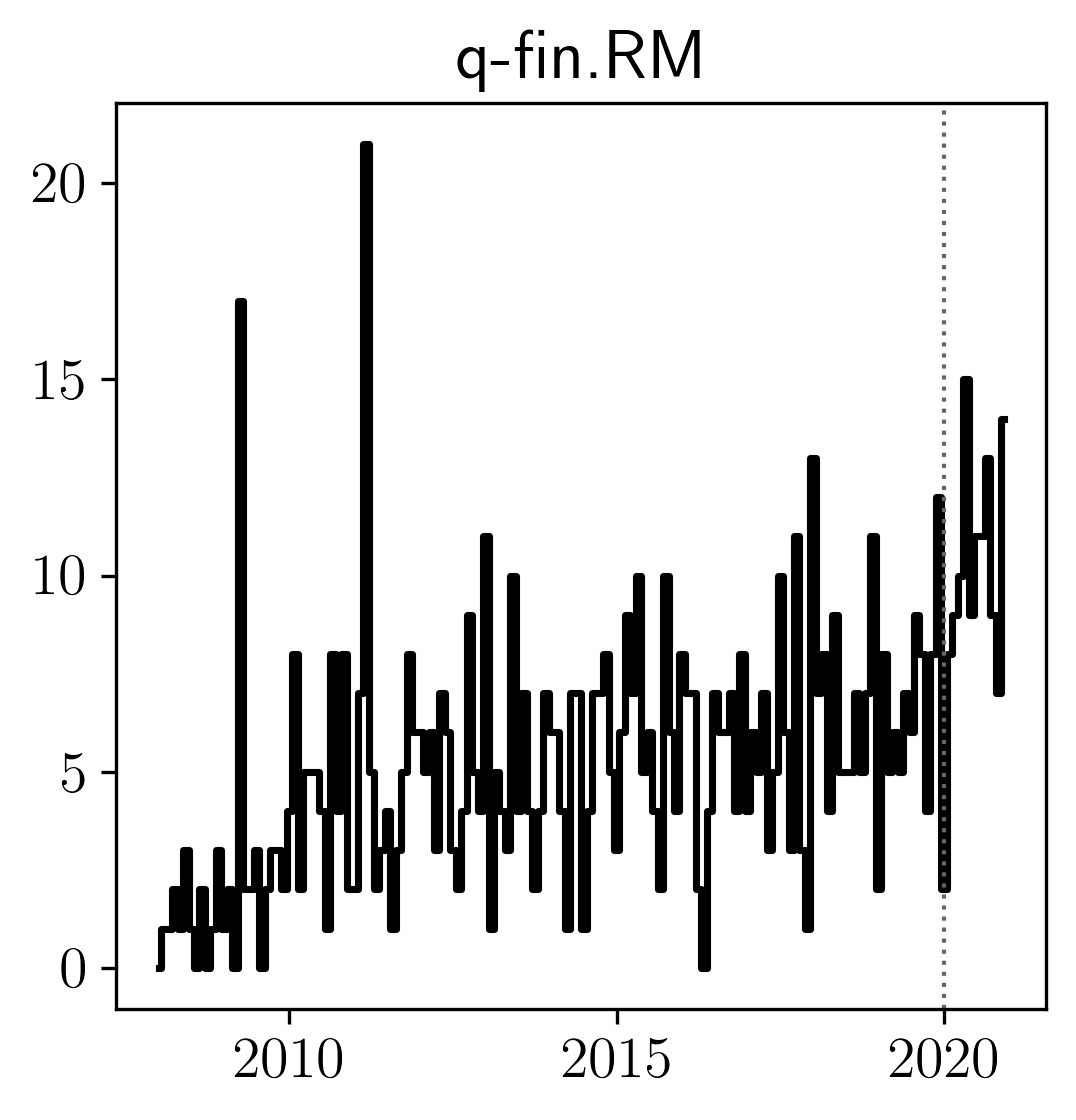

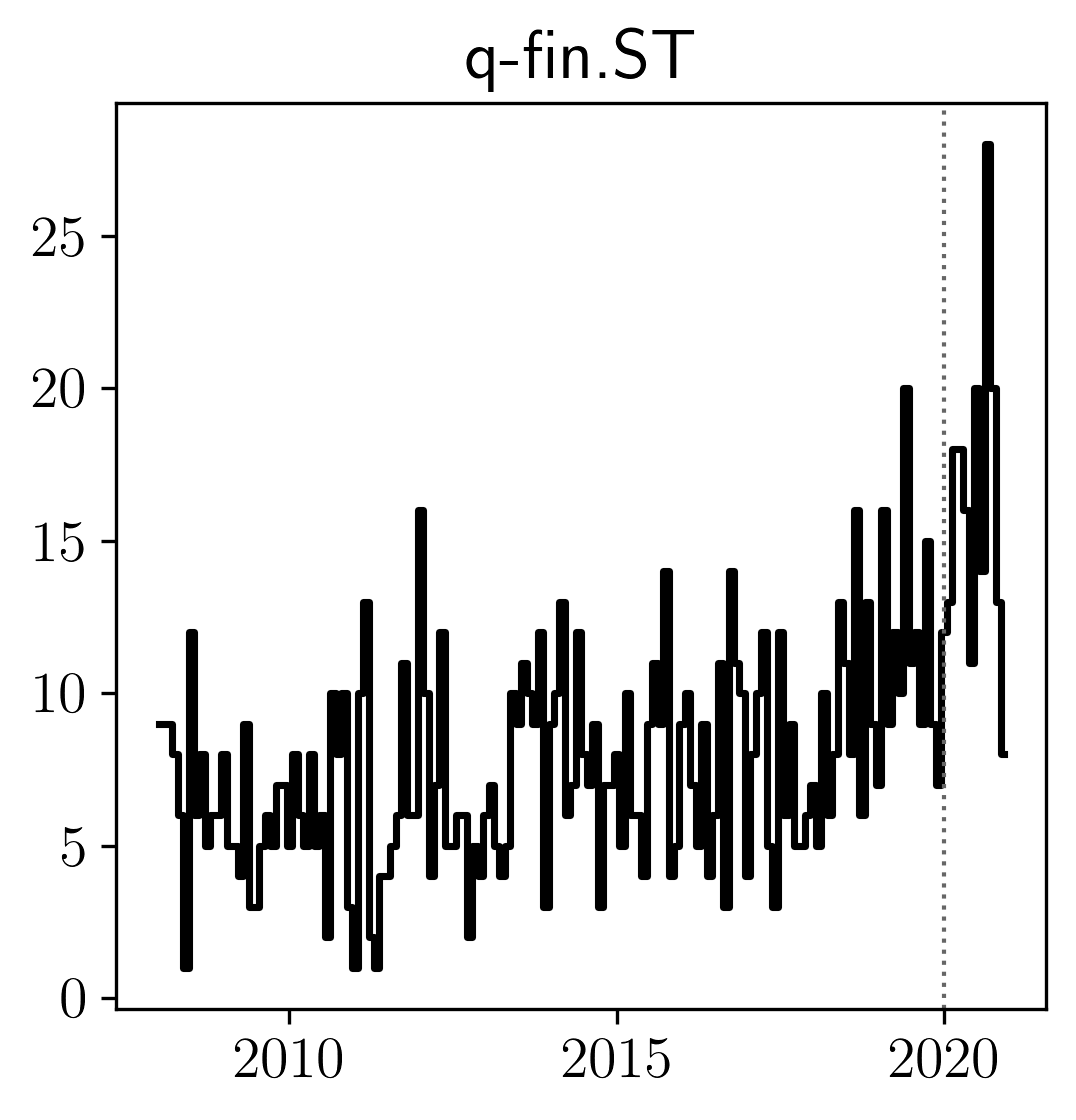

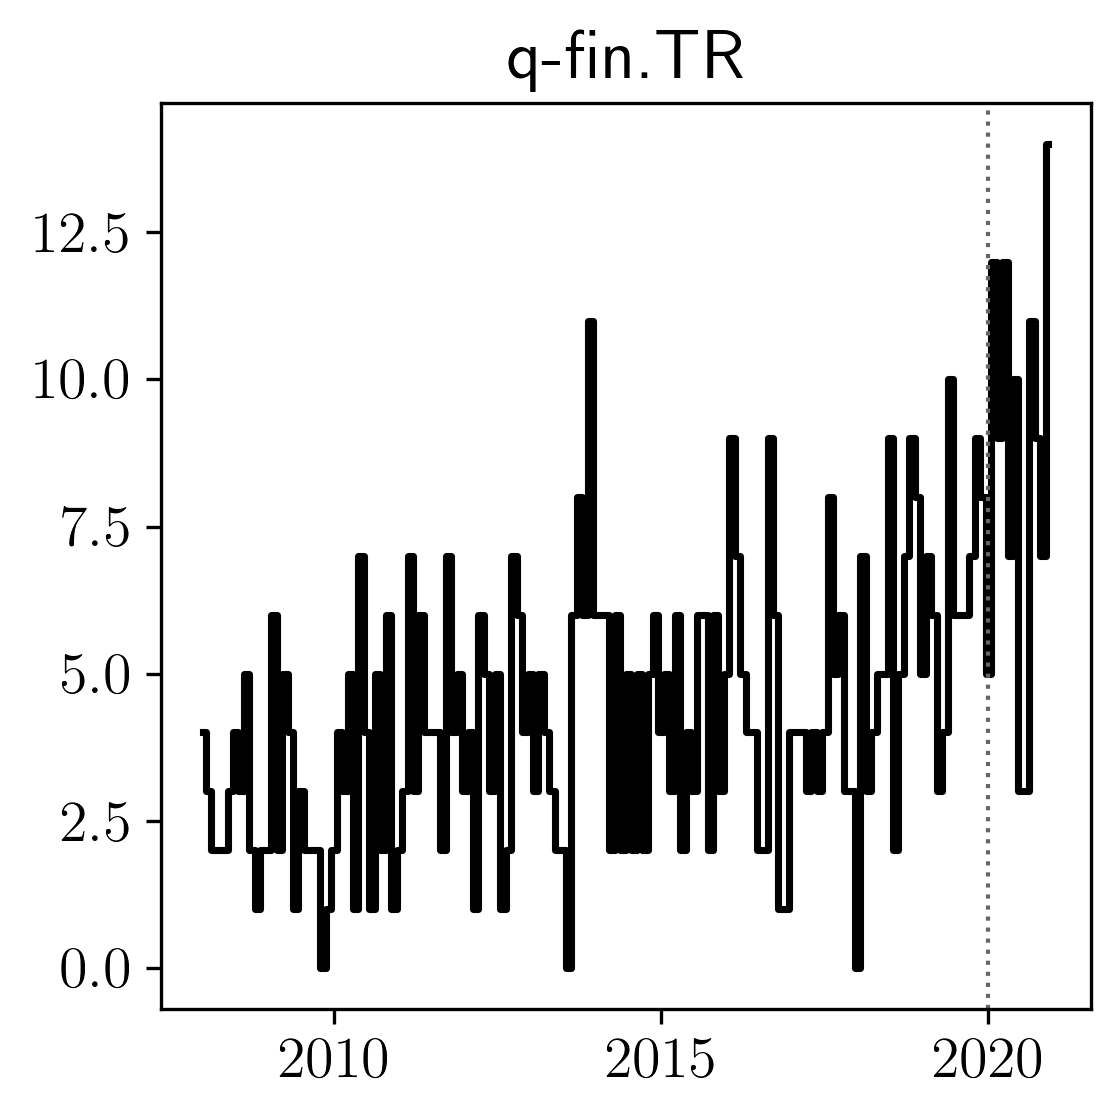

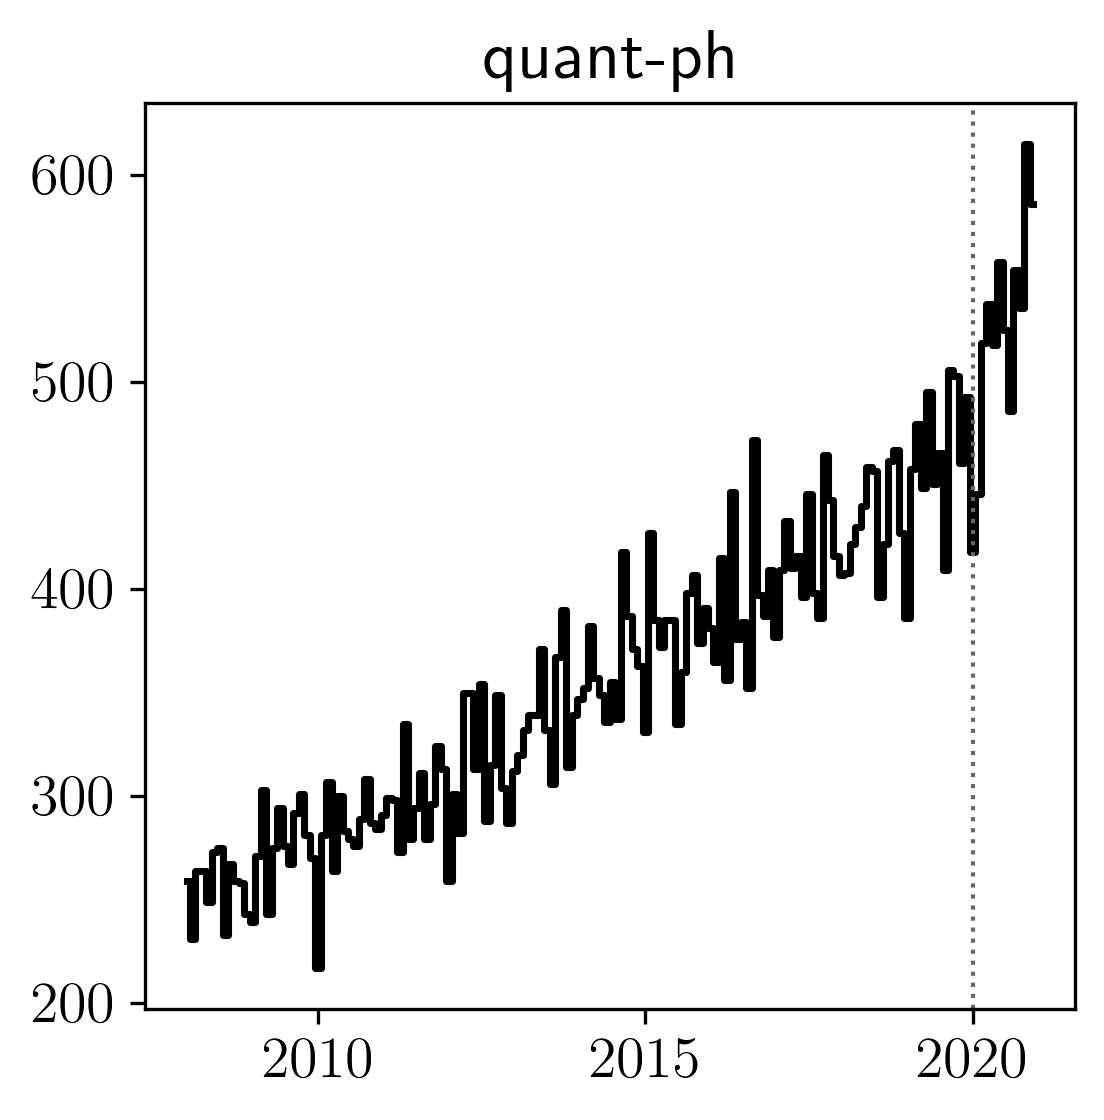

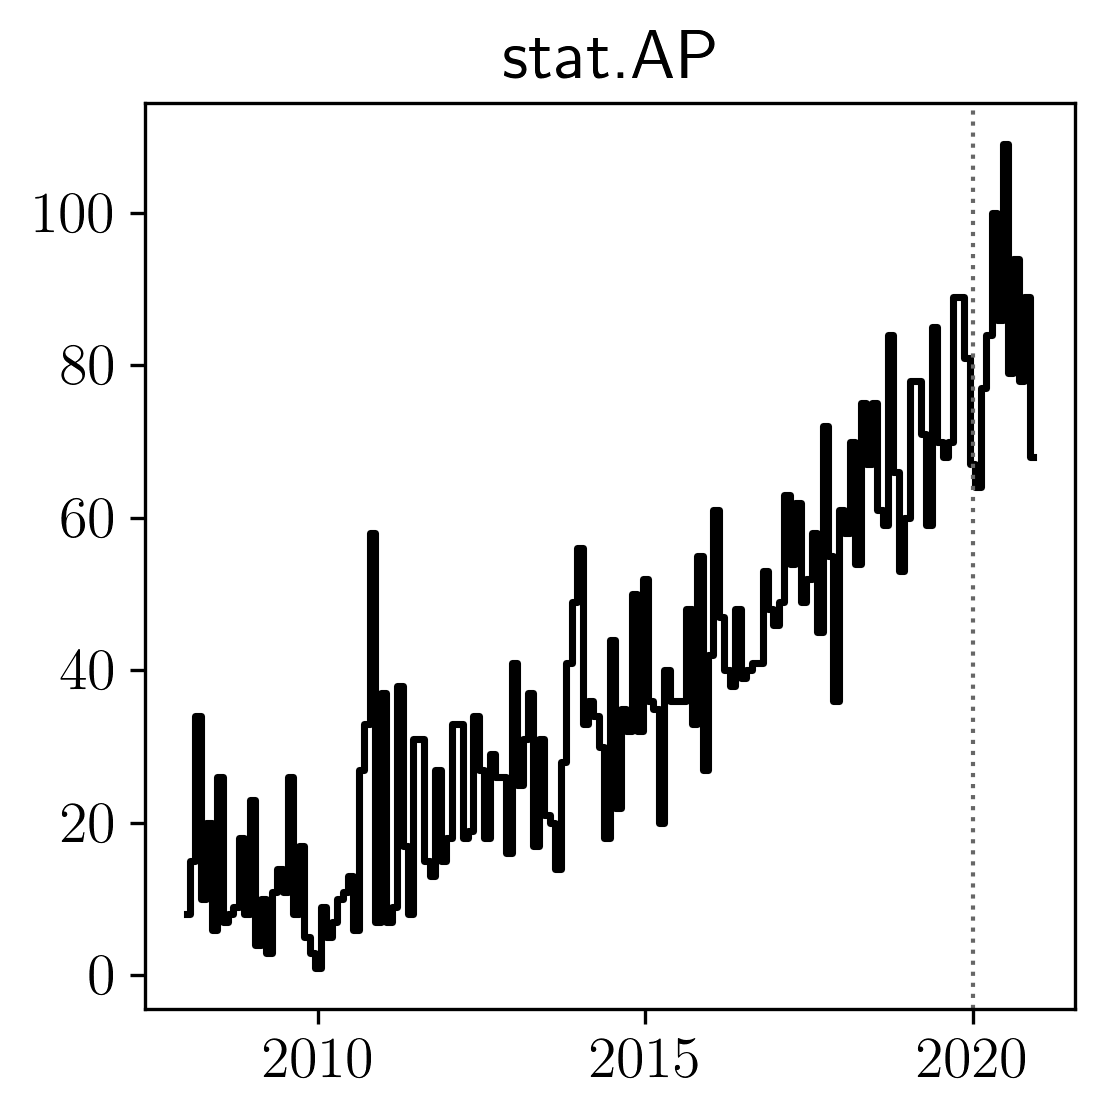

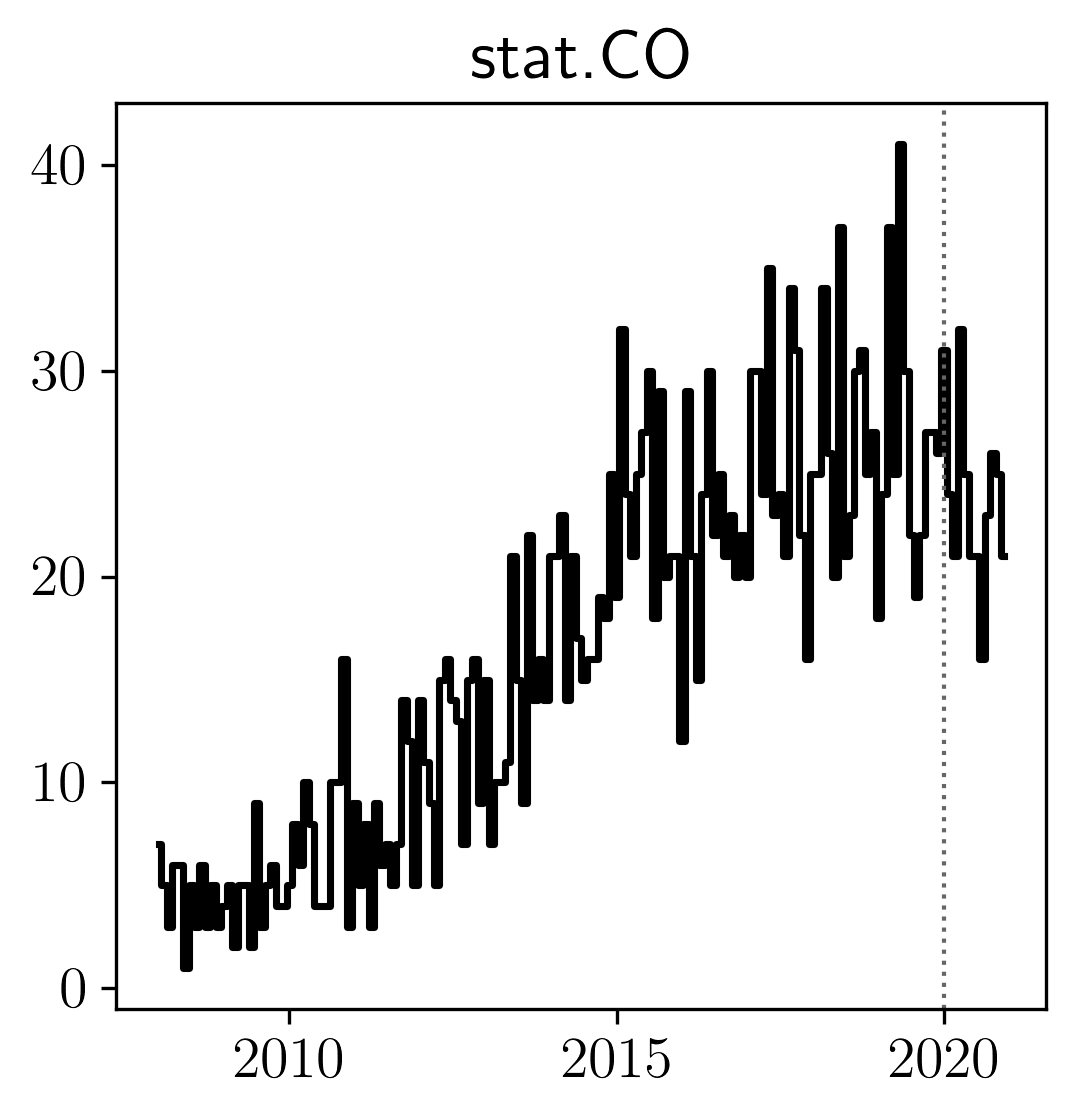

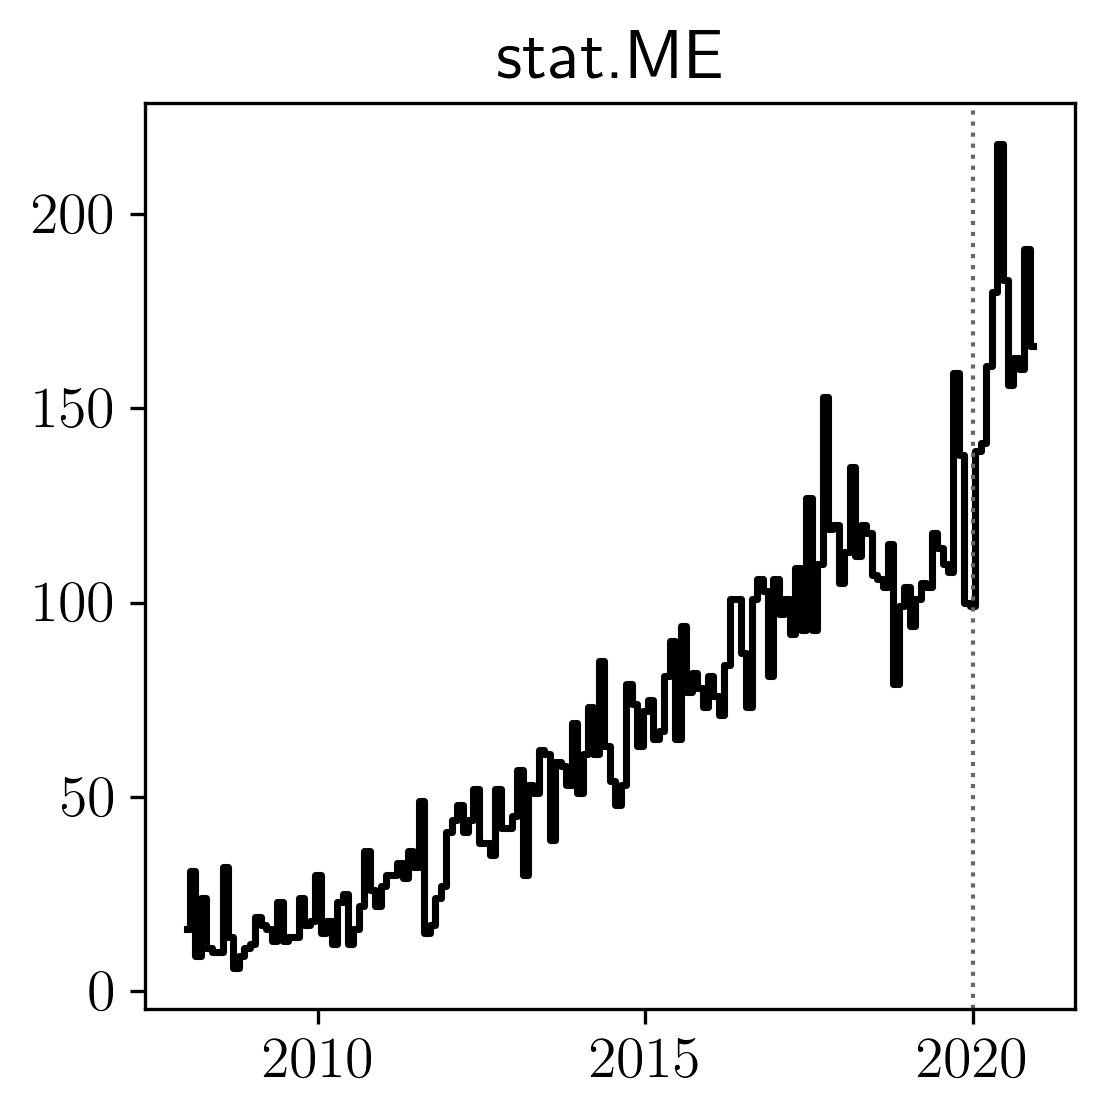

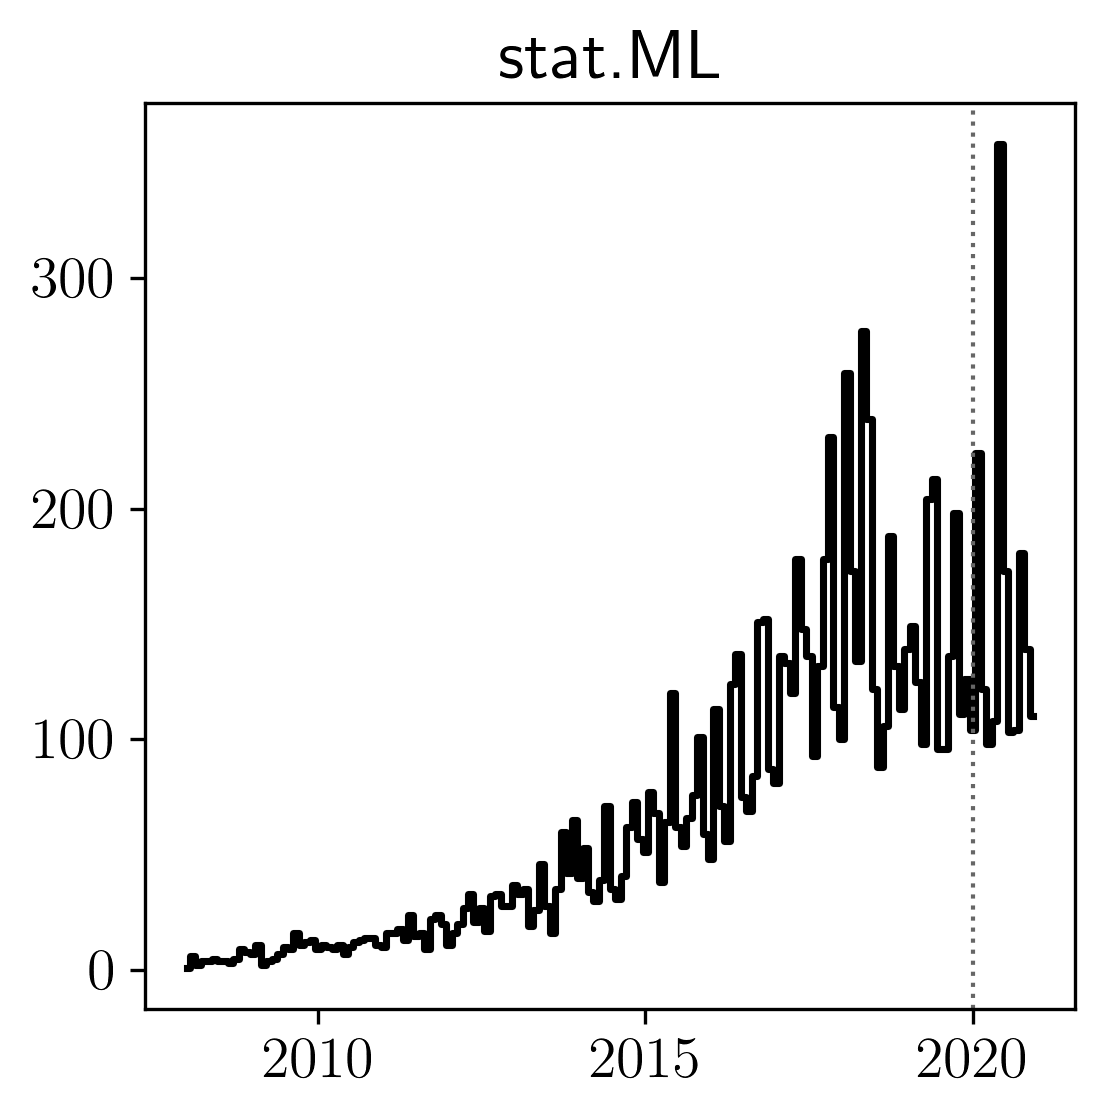

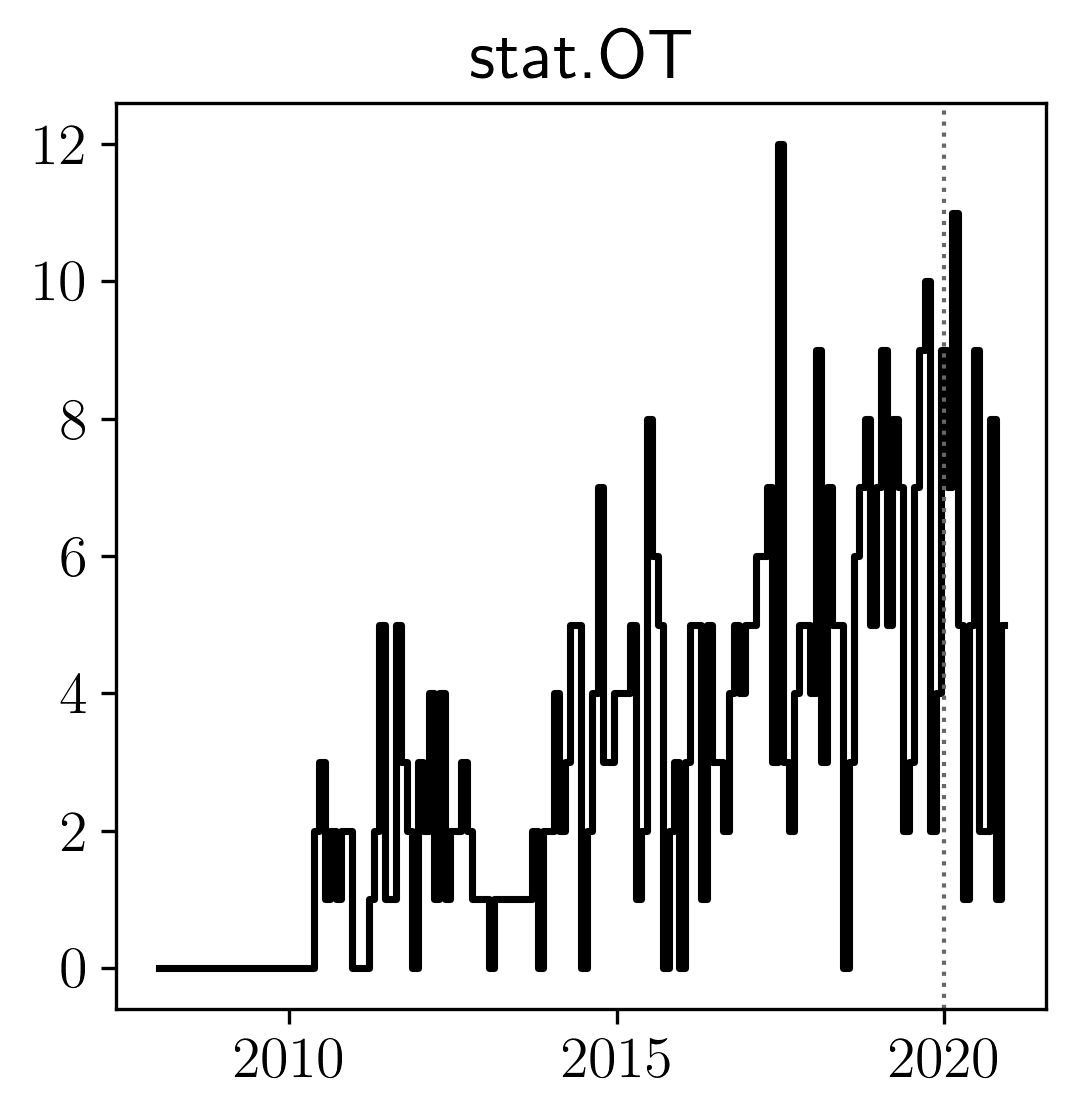

In [233]:
# Plot submissions by time for each field.

#records["year"] = records["created_decimal_year"].astype(int)

pcs = sorted(list(set(records["primary_category"])))

for i, pc in enumerate(pcs):
    
    mask = (records["primary_category"] == pc)
    group = records[mask]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    
    ax.set_title(r"{}".format(pc))

    ys = group["created_decimal_year"]
    bins = np.arange(2008, 2021 + 1/12, 1/12)
    
    H, bin_edges = np.histogram(group["created_decimal_year"], bins)
    
    
    ax.plot(
        bins[:-1],
        H,
        #c=colors[ppc],
        c="k",
        drawstyle="steps-mid",
        label=ppc,
    )
    
    ax.axvline(2020, c="#666666", ls=":", lw=1)

'''   
for ax in axes.flatten():
    if ax.is_last_row():
        ax.set_xlabel(r"Year")
        ax.set_xticks(range(2008, 2021, 2))
    else:
        ax.set_xticks([])
        
    if ax.is_first_col():
        ax.set_ylabel(r"$\textrm{Number~of~pre\-prints~posted}$")
    
    ax.axvline(2020, c="#666666", ls=":", lw=1, zorder=-1)
    ax.set_xlim(2008, 2021)

fig.tight_layout()
''' 

physics.comp-ph 925 997 7.783783783783793
physics.soc-ph 728 1184 62.637362637362635
cond-mat.mtrl-sci 3397 4153 22.25493082131291


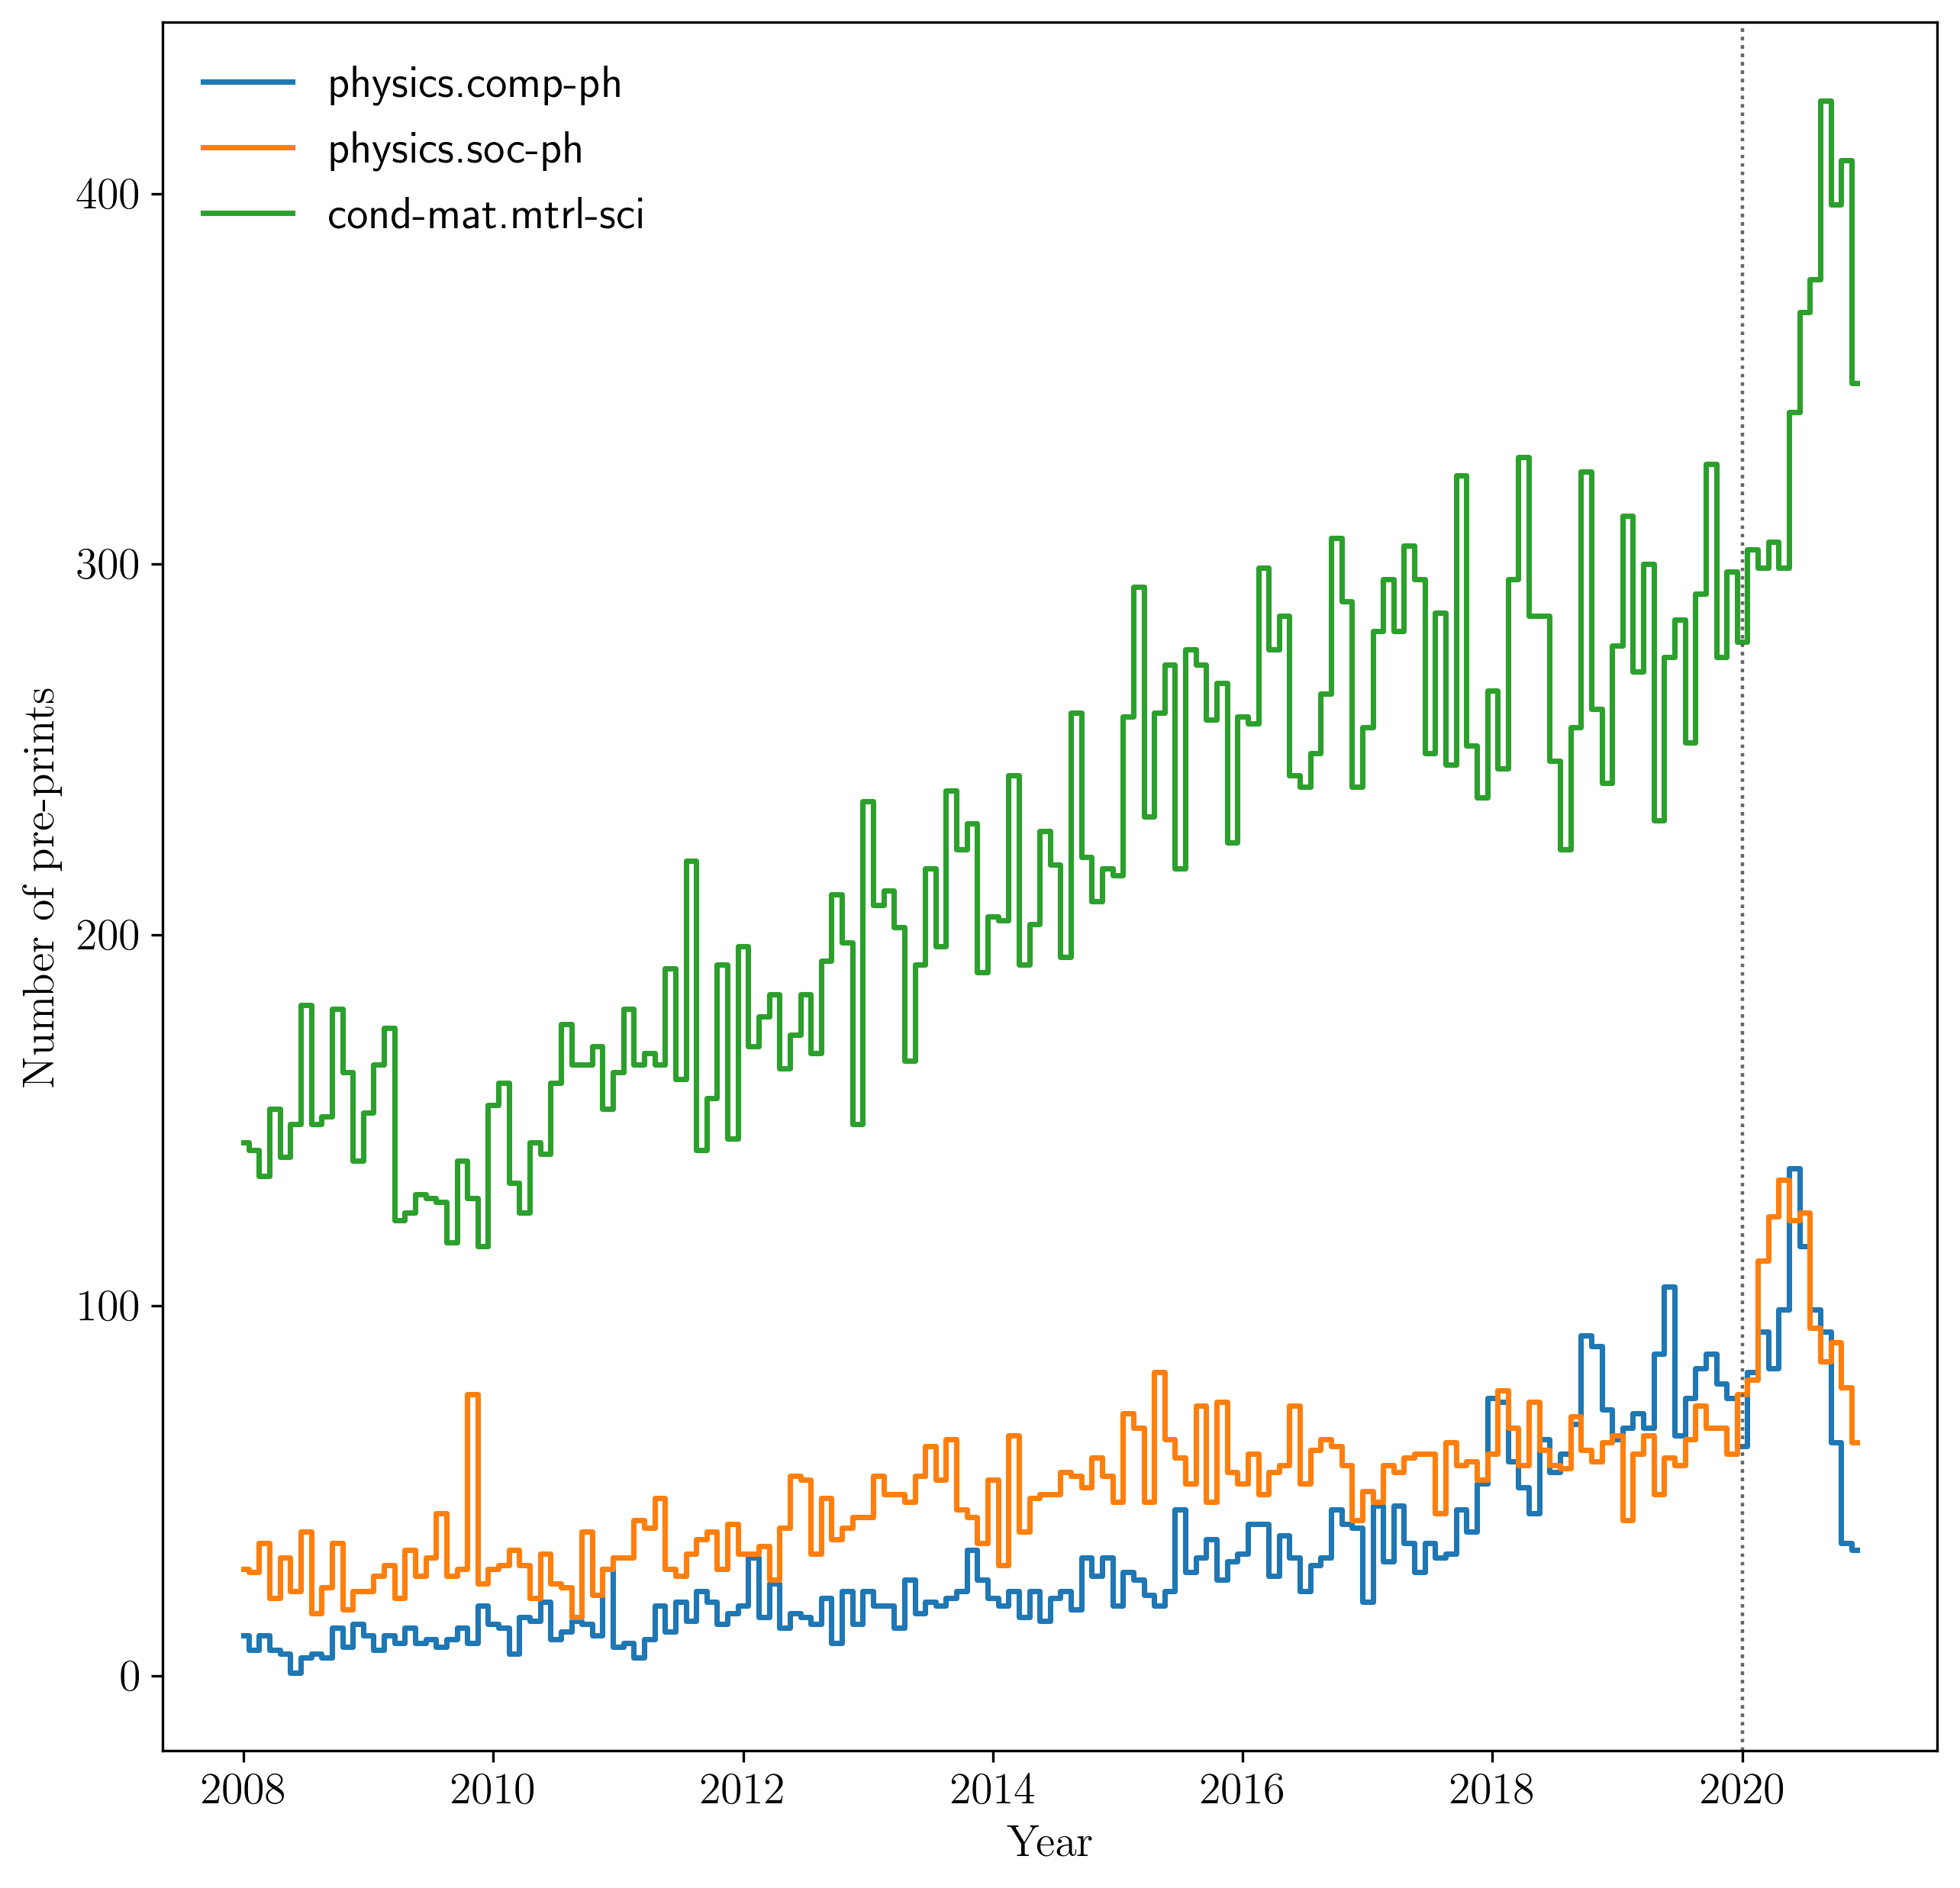

In [269]:
pcs = (
    "physics.comp-ph", 
    "physics.soc-ph", 
#    "stat.CO", 
    "cond-mat.mtrl-sci", 
#    "cs.AR", 
#    "cs.CY",  # --> I checked this below, and the boom is nothing to do with covid
#    "cs.SD"
)

bins = np.arange(2008, 2021 + 1/12, 1/12)

fig, ax = plt.subplots()

for pc in pcs:
    
    mask = (records["primary_category"] == pc)
    group = records[mask]
    
    ys = group["created_decimal_year"]
    
    H, bin_edges = np.histogram(group["created_decimal_year"], bins)
    
    ax.plot(
        bins[:-1],
        H,#/ H[bins.searchsorted(2019)],
        drawstyle="steps-mid",
        label=pc,
    )
    
    in_2020 = np.sum(ys >= 2020)
    in_2019 = np.sum((ys >= 2019) * (2020 > ys))
    print(pc, in_2019, in_2020, 100 * (in_2020/in_2019 - 1))
    ax.axvline(2020, c="#666666", ls=":", lw=1)
                    
    
    
    
ax.legend(frameon=False)
ax.set_xlabel(r"$\textrm{Year}$")
ax.set_ylabel(r"$\textrm{Number~of~pre-prints}$")
fig.savefig("article/winners-and-losers-of-covid.pdf", dpi=300)

In [252]:

with open("abstracts.json", "r") as fp:
    context = json.load(fp)


In [270]:
words = []
for arxiv_id in records["id"][(records["primary_category"] == "physics.soc-ph") * (records["created_decimal_year"] >= 2020)]:
    abstract = context[arxiv_id]["abstract"]
    title = context[arxiv_id]["title"]
    words.extend(f"{title.lower()} {abstract.lower()}".split())
    print(title)
    

Understanding the mesoscopic scaling patterns within cities
Nonlinear $q$-voter model from the quenched perspective
Study on departure time choice behavior in commute problem with
  stochastic bottleneck capacity: Experiments and modeling
Noisy voter model for the anomalous diffusion of parliamentary presence
Reconstruction of Demand Shocks in Input-Output Networks
Bottom-up energy supply optimization of a national building stock
Quartic Balance Theory: Global Minimum With Imbalanced Triangles
Whos Ditching the Bus?
Multiplex networks quantify robustness of the mental lexicon to
  catastrophic concept failures, aphasic degradation and ageing
Cooperation for public goods under uncertainty
Impact of environmental changes on the dynamics of temporal networks
Dynamic Interaction between Shared Autonomous Vehicles and Public
  Transit: A Competitive Perspective
Controlling network dynamics
Network Geometry
The cost of a future low-carbon electricity system without nuclear power
  for Sweden

In [272]:
from collections import Counter
counts = Counter(words)
for word, count in counts.most_common(50):
    print(word, count)

the 15502
of 10376
and 6454
to 5289
a 5247
in 5219
we 2929
is 2405
that 2362
for 2252
on 2022
with 1614
are 1607
this 1442
by 1419
as 1393
model 1159
an 1034
from 1011
be 953
network 921
can 896
which 805
social 755
networks 726
our 707
between 653
covid-19 635
data 557
their 552
or 547
these 540
different 539
it 525
at 509
have 504
results 494
show 493
such 483
dynamics 467
using 456
number 447
epidemic 439
two 432
more 429
time 426
has 423
not 408
study 403
based 397


In [259]:
counts["pandemic"]

188

In [274]:
words_comp = []
for arxiv_id in records["id"][(records["primary_category"] == "physics.comp-ph") * (records["created_decimal_year"] >= 2020)]:
    abstract = context[arxiv_id]["abstract"]
    title = context[arxiv_id]["title"]
    words_comp.extend(f"{title.lower()} {abstract.lower()}".split())


counts = Counter(words_comp)
for word, count in counts.most_common(50):
    print(word, count)

the 12349
of 7212
and 5019
a 4382
to 4044
in 3683
for 2961
is 2424
we 1960
with 1827
on 1397
that 1270
are 1261
this 1173
as 1076
by 1050
an 852
method 833
be 717
can 712
from 696
using 643
which 641
model 634
numerical 624
at 467
our 422
learning 421
based 420
it 409
simulations 377
these 369
neural 368
approach 365
computational 365
data 340
such 339
used 336
present 328
methods 326
models 325
dynamics 317
flow 307
results 306
have 301
has 301
time 296
or 295
new 294
equations 288
